In [1]:
!pwd

/home/pczapla/workspace/ulmfit-multilingual/experiments


In [2]:
from fastai.text import *

In [3]:
# unzip task6_test.zip
# unzip task_6-1.zip -d Task6/task\ 01
# unzip task_6-2.zip -d Task6/task\ 02
# mv Task6/task\ 01 task-1
# mv Task6/task\ 02 task-2
# rmdir Task6

In [4]:
dataset=Path('../data')/'poleval19'/'task-1'
dataset.ls()

[PosixPath('../data/poleval19/task-1/test_set_clean_only_text.txt'),
 PosixPath('../data/poleval19/task-1/training_set_clean_only_text.tmp.tok'),
 PosixPath('../data/poleval19/task-1/training_set_clean_only_text.txt'),
 PosixPath('../data/poleval19/task-1/test_set_clean_only_text.tmp.bpe'),
 PosixPath('../data/poleval19/task-1/test_set_clean_only_text.tmp.enc'),
 PosixPath('../data/poleval19/task-1/training_set_clean_only_tags.txt'),
 PosixPath('../data/poleval19/task-1/models'),
 PosixPath('../data/poleval19/task-1/evaulate1.pl'),
 PosixPath('../data/poleval19/task-1/test_set_clean_only_text.tmp.tok'),
 PosixPath('../data/poleval19/task-1/test_set_clean_only_tags.txt'),
 PosixPath('../data/poleval19/task-1/training_set_clean_only_text.tmp.enc'),
 PosixPath('../data/poleval19/task-1/training_set_clean_only_text.tmp.bpe')]

In [31]:
fn = '../data/toxic-comment/train.csv'
df = pd.read_csv(fn)
comment_text = df.comment_text.str.replace("\n", " ")
del df['comment_text']

In [54]:
comment_text.to_csv(dataset/"toxic-train-text.csv", sep='\t', index=False, header=False, quoting=csv.QUOTE_NONE, quotechar='|', escapechar='\\')
df.to_csv(dataset/"toxic-train-tags.csv", index=False, header=False)

In [38]:
!head {dataset/"toxic-train-text.csv"}

Explanation Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.
" More I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want 

In [39]:
LASER = os.environ.get('LASER', "/home/pczapla/workspace/_oss/LASER")
os.environ['LASER'] = LASER
def cond_add_pypath(*paths):
    for path in paths:
        if path not in sys.path:
            sys.path.append(path)
cond_add_pypath(LASER + '/source',LASER + '/source/tools')

from embed import SentenceEncoder, EncodeLoad, EncodeFile
from text_processing import Token, BPEfastApply, SplitLines, JoinEmbed

In [44]:
from subprocess import run, check_output, DEVNULL
def tokenize(inp_fname, out_fname, lang='en',
          lower_case=True, romanize=False, descape=False,
          verbose=False, over_write=False, gzip=False):
    FASTBPE = LASER + '/tools-external/fastBPE/fast'
    MOSES_BDIR = LASER + '/tools-external/moses-tokenizer/tokenizer/'
    MOSES_TOKENIZER = MOSES_BDIR + 'tokenizer.perl -q -no-escape -threads 20 -l '
    MOSES_LC = MOSES_BDIR + 'lowercase.perl'
    NORM_PUNC = MOSES_BDIR + 'normalize-punctuation.perl -l '
    DESCAPE = MOSES_BDIR + 'deescape-special-chars.perl'
    REM_NON_PRINT_CHAR = MOSES_BDIR + 'remove-non-printing-char.perl'

    # Romanization (Greek only)
    ROMAN_LC = 'python3 ' + LASER + '/source/lib/romanize_lc.py -l '

    # Mecab tokenizer for Japanese
    MECAB = LASER + '/tools-external/mecab'
    assert lower_case, 'lower case is needed by all the models'
    if not out_fname.exists():
        cat = 'zcat ' if gzip else 'cat '
        roman = lang if romanize else 'none'
        # handle some iso3 langauge codes
        if lang in ('cmn', 'wuu', 'yue'):
            lang = 'zh'
        if lang in ('jpn'):
            lang = 'ja'
        if verbose:
            print(' - Tokenizer: {} in language {} {} {}'
                  .format(os.path.basename(inp_fname), lang,
                          '(gzip)' if gzip else '',
                          '(de-escaped)' if descape else '',
                          '(romanized)' if romanize else ''))
        cmd = (cat + str(inp_fname)
            + '|' + REM_NON_PRINT_CHAR
            + '| sed "s/\(@anonymized_account *\)/account /gi"'
#            + '| iconv -f UTF-8 -t ASCII//TRANSLIT '
            + '|' + NORM_PUNC + lang
            + ('|' + DESCAPE if descape else '')
            + '|' + MOSES_TOKENIZER + lang
            + ('| python3 -m jieba -d ' if lang == 'zh' else '')
            + ('|' + MECAB + '/bin/mecab -O wakati -b 50000 ' if lang == 'ja' else '')
            + ('|' + ROMAN_LC + roman if romanize else '')
            + ('| tr "[:upper:]" "[:lower:]"' if lower_case else '')
            + '>' + str(out_fname))
        print ("Tokenziation CMD: ", cmd)
        run(cmd,
            env=dict(os.environ, LD_LIBRARY_PATH=MECAB + '/lib'),
            shell=True)
    elif not over_write and verbose:
        print(' - Tokenizer: {} exists already'
              .format(os.path.basename(out_fname), lang))


def split_lines(*args): return SplitLines(*list(map(str,args)))
def bpe_fast_apply(*args, **kwargs): return BPEfastApply(*list(map(str,args)), **kwargs)
def encode_file(enc, *args, **kwargs): return EncodeFile(enc, *list(map(str,args)), **kwargs)
def join_embed(*args): return JoinEmbed(*list(map(str,args)))
                      
def process_file(inputfn, lang='pl'):
    inputfn = Path(inputfn)
    args = SimpleNamespace(
        encoder=str(Path(LASER)/"models"/"bilstm.93langs.2018-12-26.pt"), 
        bpe_codes=str(Path(LASER)/"models"/"93langs.fcodes"),
        lang=lang,
        buffer_size=10000,
        max_tokens=12000,
        max_sentences=None,
        cpu=False,
        verbose=False,
        stable=True)
    enc = EncodeLoad(args)
    def fn(suffix):
        return inputfn.with_suffix(f'.tmp{suffix}')
    tokenize(inputfn,
          fn('.tok'),
          lang=lang,
          romanize=(True if lang == 'el' else False),
          lower_case=True, gzip=False,
          verbose=args.verbose, over_write=False)
    bpe_fast_apply(fn('.tok'),
             fn('.bpe'),
             args.bpe_codes,
             verbose=args.verbose, over_write=False)
    split_lines(fn('.bpe'),
               fn('.split'),
               fn('.sid'))
    encode_file(enc,
               fn('.split'),
               fn('.split.enc'),
               verbose=args.verbose, over_write=False,
               buffer_size=args.buffer_size)
    join_embed(fn('.split.enc'),
              fn('.sid'),
              fn('.enc'))
#     encode_file(enc,
#                fn('.bpe'),
#                fn('.enc'),
#                verbose=args.verbose, over_write=False,
#                buffer_size=args.buffer_size)
    return fn('.enc')

In [66]:
!rm {dataset}/toxic-train-text.tmp.*
tx_trn_fn = process_file(dataset / 'toxic-train-text.csv', lang='en')

 - loading encoder /home/pczapla/workspace/_oss/LASER/models/bilstm.93langs.2018-12-26.pt
Tokenziation CMD:  cat ../data/poleval19/task-1/toxic-train-text.csv|/home/pczapla/workspace/_oss/LASER/tools-external/moses-tokenizer/tokenizer/remove-non-printing-char.perl| sed "s/\(@anonymized_account *\)/account /gi"|/home/pczapla/workspace/_oss/LASER/tools-external/moses-tokenizer/tokenizer/normalize-punctuation.perl -l en|/home/pczapla/workspace/_oss/LASER/tools-external/moses-tokenizer/tokenizer/tokenizer.perl -q -no-escape -threads 20 -l en| tr "[:upper:]" "[:lower:]">../data/poleval19/task-1/toxic-train-text.tmp.tok
 - Split sentences: ../data/poleval19/task-1/toxic-train-text.tmp.bpe
 -                  lines/max words: 159571/4950 -> 619938/4951
 - Combine embeddings:
                input: ../data/poleval19/task-1/toxic-train-text.tmp.split.enc 619938 sentences
                IDs: ../data/poleval19/task-1/toxic-train-text.tmp.sid, 159571 sentences
                output: ../data/pole

In [67]:
!rm {dataset}/training_set_clean_only_text.tmp.*
trn_fn = process_file(dataset / 'training_set_clean_only_text.txt')

rm: cannot remove '../data/poleval19/task-1/training_set_clean_only_text.tmp.*': No such file or directory
 - loading encoder /home/pczapla/workspace/_oss/LASER/models/bilstm.93langs.2018-12-26.pt
Tokenziation CMD:  cat ../data/poleval19/task-1/training_set_clean_only_text.txt|/home/pczapla/workspace/_oss/LASER/tools-external/moses-tokenizer/tokenizer/remove-non-printing-char.perl| sed "s/\(@anonymized_account *\)/account /gi"|/home/pczapla/workspace/_oss/LASER/tools-external/moses-tokenizer/tokenizer/normalize-punctuation.perl -l pl|/home/pczapla/workspace/_oss/LASER/tools-external/moses-tokenizer/tokenizer/tokenizer.perl -q -no-escape -threads 20 -l pl| tr "[:upper:]" "[:lower:]">../data/poleval19/task-1/training_set_clean_only_text.tmp.tok
 - Split sentences: ../data/poleval19/task-1/training_set_clean_only_text.tmp.bpe
 -                  lines/max words: 10041/82 -> 12066/83
 - Combine embeddings:
                input: ../data/poleval19/task-1/training_set_clean_only_text.tmp.spl

In [69]:
! cat ../data/poleval19/task-1/training_set_clean_only_text.txt| sed 's/\(@anonymized_account *\)/account /gi' |head











sed: couldn't write 130 items to stdout: Broken pipe
cat: write error: Broken pipe


In [70]:
! cat ../data/poleval19/task-1/training_set_clean_only_text.txt| iconv -f UTF-8 -t ASCII//TRANSLIT |head











iconv: conversion stopped due to problem in writing the output


In [71]:
! head ../data/poleval19/task-1/training_set_clean_only_text.tmp.tok

dla mnie faworytem do tytułu będzie cracovia . zobaczymy , czy typ się sprawdzi .
account account brawo ty daria kibic ma być na dobre i złe
account account super , polski premier składa kwiaty na grobach kolaborantów . ale doczekaliśmy czasów .
account account musi . innej drogi nie mamy .
odrzut natychmiastowy , kwaśna mina , mam problem
jaki on był fajny xdd pamiętam , że spóźniłam się na jego pierwsze zajęcia i to sporo i za karę kazał mi usiąść w pierwszej ławce xd
account no nie ma u nas szczęścia 😉
account dawno kogoś tak wrednego nie widziałam xd
account account zaległości były , ale ważne czy były wezwania do zapłaty z których się klub nie wywiązał .
account account account gdzie jest account . brudziński jesteś kłamcą i marnym kutasem account


In [72]:
!rm {dataset}/test_set_clean_only_text.tmp.*
tst_fn = process_file(dataset / 'test_set_clean_only_text.txt')

 - loading encoder /home/pczapla/workspace/_oss/LASER/models/bilstm.93langs.2018-12-26.pt
Tokenziation CMD:  cat ../data/poleval19/task-1/test_set_clean_only_text.txt|/home/pczapla/workspace/_oss/LASER/tools-external/moses-tokenizer/tokenizer/remove-non-printing-char.perl| sed "s/\(@anonymized_account *\)/account /gi"|/home/pczapla/workspace/_oss/LASER/tools-external/moses-tokenizer/tokenizer/normalize-punctuation.perl -l pl|/home/pczapla/workspace/_oss/LASER/tools-external/moses-tokenizer/tokenizer/tokenizer.perl -q -no-escape -threads 20 -l pl| tr "[:upper:]" "[:lower:]">../data/poleval19/task-1/test_set_clean_only_text.tmp.tok
 - Split sentences: ../data/poleval19/task-1/test_set_clean_only_text.tmp.bpe
 -                  lines/max words: 1000/104 -> 1237/105
 - Combine embeddings:
                input: ../data/poleval19/task-1/test_set_clean_only_text.tmp.split.enc 1237 sentences
                IDs: ../data/poleval19/task-1/test_set_clean_only_text.tmp.sid, 1000 sentences
      

In [73]:
dim=1024
def read_enc(fn):
    em = np.fromfile(str(fn),dtype=np.float32).reshape(-1, dim)
    return em
read_enc(trn_fn).shape

(10041, 1024)

In [74]:
np.loadtxt(str(dataset/'test_set_clean_only_text.txt'), delimiter='\n', comments=None, dtype=np.str).shape

(1000,)

In [104]:
tst_df = pd.DataFrame({
    'y':np.loadtxt(str(dataset/'test_set_clean_only_tags.txt'),delimiter='\n', comments=None, dtype=np.int),
    'em':list(read_enc(tst_fn)), 
    'txt':np.loadtxt(str(dataset/'test_set_clean_only_text.tmp.bpe'), delimiter='\n', comments=None, dtype=np.str),
})

trn_df = pd.DataFrame({
    'y':np.loadtxt(str(dataset/'training_set_clean_only_tags.txt'),delimiter='\n', comments=None, dtype=np.int),
    'em':list(read_enc(trn_fn)), 
    'txt':np.loadtxt(str(dataset/'training_set_clean_only_text.tmp.bpe'), delimiter='\n', comments=None, dtype=np.str),
})

In [76]:
txt = np.loadtxt(str(dataset/'toxic-train-text.tmp.bpe'), delimiter='\n', comments=None, dtype=np.str)

In [77]:
len (txt)

159571

In [78]:
enc=read_enc(tx_trn_fn)
len(enc)

159571

In [79]:
tx_trn_df = pd.DataFrame({
    'y': df['toxic'],
    'em':list(enc), 
    'txt':txt,
})

In [105]:
trn_df = pd.concat([trn_df, tx_trn_df], ignore_index=True)

In [107]:
trn_df.head()

,y,em,txt
0,0,"[0.0047513233, 0.0040491223, 0.015147643, 0.01...",dla mnie fa@@ wor@@ y@@ tem do ty@@ tu@@ łu bę...
1,0,"[0.0037102806, -2.0261248e-05, 7.142721e-05, 0...",account account bra@@ wo ty dar@@ ia ki@@ bi@@...
2,0,"[0.0065289, 0.0048259646, -0.00015079533, 0.02...","account account super , pol@@ ski premier sk@@..."
3,0,"[0.025331493, -0.0001753498, 0.0006774627, 0.0...",account account musi . in@@ nej dro@@ gi nie m...
4,0,"[0.007905564, 0.0017290547, -0.0015668216, 0.0...","odr@@ zut nat@@ ych@@ mi@@ a@@ sto@@ wy , kwa@..."


In [108]:
trn_df.loc[1]

y                                                      0
em     [0.0037102806, -2.0261248e-05, 7.142721e-05, 0...
txt    account account bra@@ wo ty dar@@ ia ki@@ bi@@...
Name: 1, dtype: object

In [109]:
tst_df['em'][0]

array([ 0.015996,  0.002804, -0.004015,  0.018448, ...,  0.022837,  0.005017,  0.011453,  0.016846], dtype=float32)

In [84]:
class EmbeddingText(ItemBase):
    "Basic item for <code>text</code> data in numericalized `ids`."
    def __init__(self, emb, text): self.data,self.text = np.array(emb, dtype=np.float32),text
    def __str__(self):  return str(self.text)

In [85]:
class EmbeddingList(ItemList):
    "Basic `ItemList` for embeding of text data."
    _bunch = DataBunch # TextDataBunch converts input to LongTensor !
    _processor = []

    def __init__(self, items:Iterator, **kwargs):
        super().__init__(items, **kwargs)

    def find_text_for_em(self, em):
        # todo find a way to reverse embedding
        return self.inner_df['txt'][1]
        
    def get(self, i):
        o = super().get(i)
        return EmbeddingText(o, self.inner_df['txt'][i])

    def reconstruct(self, t:Tensor):
        return EmbeddingText(t, self.find_text_for_em(t))

    def show_xys(self, xs, ys, max_len:int=70)->None:
        "Show the `xs` (inputs) and `ys` (targets). `max_len` is the maximum number of tokens displayed."
        from IPython.display import display, HTML
        names = ['text','target']
        items = []
        for i, (x,y) in enumerate(zip(xs,ys)):
            txt_x = ' '.join(x.text.split(' ')[:max_len]) if max_len is not None else x.text
            items.append([txt_x, y])
        items = np.array(items)
        df = pd.DataFrame({n:items[:,i] for i,n in enumerate(names)}, columns=names)
        with pd.option_context('display.max_colwidth', -1):
            display(HTML(df.to_html(index=False)))

    def show_xyzs(self, xs, ys, zs, max_len:int=70):
        "Show `xs` (inputs), `ys` (targets) and `zs` (predictions). `max_len` is the maximum number of tokens displayed."
        from IPython.display import display, HTML
        items,names = [],['text','target','prediction']
        for i, (x,y,z) in enumerate(zip(xs,ys,zs)):
            txt_x = ' '.join(x.text.split(' ')[:max_len]) if max_len is not None else x.text
            items.append([txt_x, y, z])
        items = np.array(items)
        df = pd.DataFrame({n:items[:,i] for i,n in enumerate(names)}, columns=names)
        with pd.option_context('display.max_colwidth', -1):
            display(HTML(df.to_html(index=False)))

In [120]:
path=dataset/"models"
src = ItemLists(path, 
                EmbeddingList.from_df(trn_df, cols=1, path=path),
                EmbeddingList.from_df(tst_df, cols=1, path=path))
classes=np.unique(trn_df['y'])
src.label_from_lists(trn_df['y'], tst_df['y'], classes=classes, processor=[])
data = src.databunch(bs=200,num_workers=0)

In [121]:
data.show_batch()

text,target
account account bra@@ wo ty dar@@ ia ki@@ bi@@ c ma być na dobre i zł@@ e,1
account account bra@@ wo ty dar@@ ia ki@@ bi@@ c ma być na dobre i zł@@ e,1
account account bra@@ wo ty dar@@ ia ki@@ bi@@ c ma być na dobre i zł@@ e,0
account account bra@@ wo ty dar@@ ia ki@@ bi@@ c ma być na dobre i zł@@ e,0
account account bra@@ wo ty dar@@ ia ki@@ bi@@ c ma być na dobre i zł@@ e,0


In [122]:
next(iter(data.train_dl))

[tensor([[ 0.0059,  0.0047,  0.0050,  ...,  0.0178,  0.0170,  0.0075],
         [ 0.0036,  0.0011, -0.0010,  ...,  0.0107,  0.0075,  0.0215],
         [ 0.0106,  0.0089,  0.0017,  ...,  0.0143,  0.0104,  0.0265],
         ...,
         [ 0.0107,  0.0260,  0.0038,  ...,  0.0084,  0.0192,  0.0222],
         [ 0.0028,  0.0033, -0.0018,  ...,  0.0122,  0.0079,  0.0158],
         [ 0.0121,  0.0014,  0.0065,  ...,  0.0108,  0.0295,  0.0186]],
        device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,

In [111]:
len(data.train_ds)

169612

In [118]:
trn_df['em'][169611]

array([0.002153, 0.010403, 0.002925, 0.01095 , ..., 0.001673, 0.00638 , 0.008416, 0.021459], dtype=float32)

In [123]:
class LaserSentCLS(nn.Module):
    def __init__(self, idim=1024, odim=2, nhid=None,
                 dropout=0.0, activation='TANH'):
        super().__init__()
        modules = []

        modules = []
        print(' - mlp {:d}'.format(idim), end='')
        if len(nhid) > 0:
            if dropout > 0:
                modules.append(nn.Dropout(p=dropout))
            nprev = idim
            for nh in nhid:
                if nh > 0:
                    modules.append(nn.Linear(nprev, nh))
                    nprev = nh
                    if activation == 'TANH':
                        modules.append(nn.Tanh())
                        print('-{:d}t'.format(nh), end='')
                    elif activation == 'RELU':
                        modules.append(nn.ReLU())
                        print('-{:d}r'.format(nh), end='')
                    else:
                       raise Exception('Unrecognized activation {activation}')
                    if dropout > 0:
                        modules.append(nn.Dropout(p=dropout))
            modules.append(nn.Linear(nprev, odim))
            print('-{:d}, dropout={:.1f}'.format(odim, dropout))
        else:
            modules.append(nn.Linear(idim, odim))
            print(' - mlp %d-%d'.format(idim, odim))
        self.mlp = nn.Sequential(*modules)
    def forward(self, x):
        return self.mlp(x)

In [124]:
data.train_dl.dl.batch_sampler.sampler

In [125]:
data.train_dl.dl.batch_size

200

In [189]:
m=LaserSentCLS(nhid=[100, 50],dropout=0, activation='RELU')
learn = Learner(data, m, metrics=[accuracy, FBeta(beta=1, average='binary')])
learn.save("rnd")

 - mlp 1024-100r-50r-2, dropout=0.0


In [178]:
def f1_loss(input, target, reduction=None):
    eps = 1e-7
    logit = F.softmax(input, dim=-1) # [bs, 2]
    tp = logit[target == 1, 1].sum()
    tn = logit[target == 0, 0].sum()
    bs = target.shape[0]
    return 1.0 - 2.0*tp / (tp - tn + bs +eps)

In [179]:
learn.loss_func=f1_loss

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


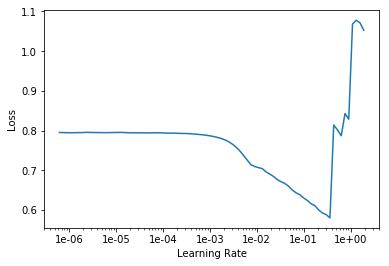

In [190]:
learn.lr_find();learn.recorder.plot()

In [205]:
from fastai.callbacks import * 
results = {}
def test_param(lr=1e-2, wd=None):
    runs=[]
    for i in range(0, 10):
        learn.load("rnd")
        cb=SaveModelCallback(learn, every='improvement',monitor='f_beta', name='best')
        learn.fit_one_cycle(5, 1e-2, wd=None, callbacks=[cb])
        runs.append(cb.best)
        print ("Run", cb.best)
    return runs

for lr in [annealing_linear(1e-3, 1e-1, pct=x/10) for x in range(0,10)]:
    for wd in [annealing_linear(1e-4, 1e-1, pct=x/10) for x in range(0,10)]: # def  wd=1e-2
        runs = test_param(lr, wd)
        print(f"lr={lr},wd={wd}",  [np.max(runs), np.mean(runs), np.std(runs)])
        results[f"lr={lr},wd={wd}"] = [np.max(runs), np.mean(runs), np.std(runs)]

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144424,0.393911,0.873000,0.320856,00:07
1,0.130089,0.365088,0.872000,0.311828,00:07
2,0.126679,0.314031,0.861000,0.177515,00:07
3,0.112081,0.320829,0.860000,0.135802,00:07
4,0.109499,0.317093,0.859000,0.134969,00:07


Better model found at epoch 0 with f_beta value: 0.32085564732551575.
Run tensor(0.3209)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.157625,0.357735,0.874000,0.376238,00:07
1,0.129884,0.388077,0.865000,0.201183,00:07
2,0.128798,0.322999,0.876000,0.380000,00:07
3,0.112867,0.314833,0.866000,0.192771,00:07
4,0.111586,0.320251,0.868000,0.223529,00:07


Better model found at epoch 0 with f_beta value: 0.3762376308441162.
Better model found at epoch 2 with f_beta value: 0.3799999952316284.
Run tensor(0.3800)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144829,0.338693,0.874000,0.388350,00:07
1,0.135630,0.330970,0.873000,0.398104,00:07
2,0.122907,0.341523,0.867000,0.222222,00:07
3,0.113183,0.319664,0.870000,0.269663,00:07
4,0.107122,0.314753,0.864000,0.190476,00:07


Better model found at epoch 0 with f_beta value: 0.3883495032787323.
Better model found at epoch 1 with f_beta value: 0.3981042802333832.
Run tensor(0.3981)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148490,0.366798,0.864000,0.418803,00:07
1,0.134365,0.334073,0.875000,0.390244,00:07
2,0.122084,0.315939,0.864000,0.200000,00:07
3,0.110597,0.309052,0.867000,0.231214,00:07
4,0.105261,0.314607,0.867000,0.231214,00:07


Better model found at epoch 0 with f_beta value: 0.4188034236431122.
Run tensor(0.4188)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145090,0.351198,0.876000,0.373737,00:07
1,0.130752,0.377143,0.872000,0.238095,00:07
2,0.119445,0.332086,0.868000,0.175000,00:07
3,0.116756,0.317956,0.871000,0.198758,00:07
4,0.107230,0.314514,0.869000,0.206061,00:07


Better model found at epoch 0 with f_beta value: 0.3737373948097229.
Run tensor(0.3737)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138431,0.353307,0.873000,0.409302,00:07
1,0.140777,0.335083,0.869000,0.242775,00:07
2,0.125057,0.336535,0.864000,0.160494,00:07
3,0.112864,0.334763,0.862000,0.126582,00:07
4,0.107490,0.317754,0.862000,0.092105,00:07


Better model found at epoch 0 with f_beta value: 0.409302294254303.
Run tensor(0.4093)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.149281,0.337926,0.871000,0.400000,00:07
1,0.127489,0.334585,0.876000,0.340426,00:07
2,0.115219,0.329802,0.871000,0.279330,00:07
3,0.111856,0.308317,0.864000,0.190476,00:07
4,0.117360,0.311881,0.863000,0.138365,00:07


Better model found at epoch 0 with f_beta value: 0.4000000059604645.
Run tensor(0.4000)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138211,0.361505,0.875000,0.407583,00:07
1,0.135180,0.322706,0.859000,0.134969,00:07
2,0.122224,0.326939,0.856000,0.111111,00:07
3,0.116590,0.331021,0.862000,0.067568,00:07
4,0.108863,0.323336,0.862000,0.080000,00:07


Better model found at epoch 0 with f_beta value: 0.40758296847343445.
Run tensor(0.4076)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142181,0.351633,0.876000,0.415094,00:07
1,0.130618,0.334738,0.873000,0.298343,00:07
2,0.121078,0.305277,0.864000,0.170732,00:07
3,0.109572,0.310349,0.867000,0.173913,00:07
4,0.102552,0.309732,0.868000,0.185185,00:07


Better model found at epoch 0 with f_beta value: 0.4150943160057068.
Run tensor(0.4151)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146297,0.347505,0.861000,0.398268,00:07
1,0.132557,0.329967,0.870000,0.252874,00:07
2,0.120979,0.320558,0.866000,0.151899,00:07
3,0.112123,0.312370,0.864000,0.180723,00:07
4,0.110394,0.313786,0.862000,0.126582,00:07


Better model found at epoch 0 with f_beta value: 0.3982684016227722.
Run tensor(0.3983)
lr=0.001,wd=0.0001 [0.41880342, 0.3921749, 0.027337264]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.135700,0.357776,0.872000,0.353535,00:07
1,0.127668,0.340809,0.878000,0.371134,00:07
2,0.130062,0.321151,0.861000,0.136646,00:07
3,0.110248,0.310227,0.868000,0.241379,00:07
4,0.108444,0.312771,0.865000,0.181818,00:07


Better model found at epoch 0 with f_beta value: 0.35353535413742065.
Better model found at epoch 1 with f_beta value: 0.37113404273986816.
Run tensor(0.3711)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143991,0.355409,0.857000,0.447876,00:07
1,0.137916,0.340732,0.873000,0.392345,00:07
2,0.125938,0.318636,0.864000,0.200000,00:07
3,0.113916,0.306219,0.871000,0.262857,00:07
4,0.106715,0.320254,0.869000,0.215569,00:07


Better model found at epoch 0 with f_beta value: 0.4478764235973358.
Run tensor(0.4479)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.157729,0.373645,0.870000,0.368932,00:07
1,0.139498,0.340676,0.875000,0.309392,00:07
2,0.129636,0.310810,0.870000,0.235294,00:07
3,0.113636,0.308912,0.868000,0.214286,00:07
4,0.110711,0.315987,0.867000,0.184049,00:07


Better model found at epoch 0 with f_beta value: 0.3689320683479309.
Run tensor(0.3689)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.136800,0.372386,0.874000,0.336842,00:07
1,0.130149,0.316793,0.862000,0.126582,00:07
2,0.122851,0.324541,0.861000,0.114650,00:07
3,0.120306,0.315041,0.863000,0.092715,00:07
4,0.106954,0.318484,0.861000,0.067114,00:07


Better model found at epoch 0 with f_beta value: 0.3368421196937561.
Run tensor(0.3368)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.156976,0.349026,0.871000,0.295082,00:07
1,0.132113,0.328126,0.875000,0.384236,00:07
2,0.125402,0.331332,0.864000,0.093333,00:07
3,0.112446,0.316068,0.864000,0.093333,00:07
4,0.105671,0.310705,0.863000,0.116129,00:07


Better model found at epoch 0 with f_beta value: 0.2950819730758667.
Better model found at epoch 1 with f_beta value: 0.3842364251613617.
Run tensor(0.3842)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.151699,0.324345,0.869000,0.299465,00:07
1,0.128246,0.345100,0.869000,0.233918,00:07
2,0.118513,0.330992,0.860000,0.135802,00:07
3,0.113787,0.318861,0.860000,0.125000,00:07
4,0.106069,0.313428,0.863000,0.104575,00:07


Better model found at epoch 0 with f_beta value: 0.29946523904800415.
Run tensor(0.2995)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143087,0.389033,0.873000,0.282486,00:07
1,0.129531,0.341547,0.877000,0.405797,00:07
2,0.121808,0.350079,0.874000,0.300000,00:07
3,0.113007,0.331424,0.860000,0.102564,00:07
4,0.110058,0.317786,0.868000,0.214286,00:06


Better model found at epoch 0 with f_beta value: 0.28248587250709534.
Better model found at epoch 1 with f_beta value: 0.4057970941066742.
Run tensor(0.4058)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144997,0.346963,0.871000,0.331606,00:07
1,0.137424,0.315458,0.876000,0.392157,00:07
2,0.122972,0.325893,0.863000,0.179641,00:07
3,0.117265,0.316162,0.861000,0.136646,00:07
4,0.109914,0.315069,0.863000,0.116129,00:07


Better model found at epoch 0 with f_beta value: 0.3316062092781067.
Better model found at epoch 1 with f_beta value: 0.3921568691730499.
Run tensor(0.3922)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.150242,0.323328,0.870000,0.343434,00:07
1,0.130365,0.319072,0.862000,0.168675,00:07
2,0.130059,0.345103,0.862000,0.137500,00:07
3,0.118355,0.309410,0.860000,0.102564,00:07
4,0.111958,0.315122,0.861000,0.114650,00:07


Better model found at epoch 0 with f_beta value: 0.34343433380126953.
Run tensor(0.3434)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144114,0.339540,0.874000,0.405660,00:07
1,0.132040,0.336931,0.862000,0.092105,00:07
2,0.120007,0.317441,0.865000,0.210526,00:07
3,0.114967,0.313192,0.860000,0.113924,00:07
4,0.107996,0.316730,0.863000,0.149068,00:07


Better model found at epoch 0 with f_beta value: 0.40566039085388184.
Run tensor(0.4057)
lr=0.001,wd=0.01009 [0.44787642, 0.3755535, 0.039731324]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142014,0.358018,0.877000,0.388060,00:07
1,0.132083,0.324711,0.861000,0.114650,00:07
2,0.121808,0.351781,0.864000,0.160494,00:07
3,0.115760,0.317603,0.864000,0.139241,00:07
4,0.106545,0.322483,0.865000,0.105960,00:07


Better model found at epoch 0 with f_beta value: 0.38805970549583435.
Run tensor(0.3881)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147430,0.353782,0.872000,0.407407,00:07
1,0.135070,0.338816,0.875000,0.358974,00:07
2,0.117463,0.329511,0.877000,0.369231,00:07
3,0.117167,0.318437,0.859000,0.124224,00:07
4,0.113987,0.317735,0.860000,0.135802,00:07


Better model found at epoch 0 with f_beta value: 0.40740737318992615.
Run tensor(0.4074)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148064,0.347952,0.871000,0.405530,00:07
1,0.129751,0.327114,0.875000,0.345550,00:07
2,0.122801,0.337786,0.871000,0.271186,00:07
3,0.115983,0.315398,0.861000,0.157576,00:07
4,0.112948,0.316446,0.861000,0.136646,00:07


Better model found at epoch 0 with f_beta value: 0.4055299758911133.
Run tensor(0.4055)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146216,0.361404,0.868000,0.421053,00:07
1,0.141068,0.330736,0.869000,0.268156,00:07
2,0.120826,0.321070,0.865000,0.210526,00:07
3,0.114533,0.334852,0.866000,0.211765,00:07
4,0.109959,0.316821,0.859000,0.134969,00:07


Better model found at epoch 0 with f_beta value: 0.42105263471603394.
Run tensor(0.4211)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140122,0.374905,0.869000,0.335025,00:07
1,0.135837,0.315225,0.868000,0.214286,00:07
2,0.123070,0.317630,0.868000,0.214286,00:07
3,0.109247,0.309605,0.875000,0.316940,00:07
4,0.106416,0.311008,0.872000,0.255814,00:07


Better model found at epoch 0 with f_beta value: 0.3350253999233246.
Run tensor(0.3350)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140313,0.339749,0.874000,0.400000,00:07
1,0.126886,0.331535,0.878000,0.383838,00:07
2,0.126821,0.308640,0.878000,0.336957,00:07
3,0.112071,0.315593,0.868000,0.214286,00:07
4,0.109153,0.312998,0.867000,0.203593,00:07


Better model found at epoch 0 with f_beta value: 0.4000000059604645.
Run tensor(0.4000)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138859,0.350590,0.870000,0.403670,00:07
1,0.134021,0.331129,0.865000,0.210526,00:07
2,0.124354,0.317627,0.871000,0.287293,00:07
3,0.114616,0.316037,0.859000,0.101911,00:07
4,0.104061,0.317248,0.858000,0.089744,00:07


Better model found at epoch 0 with f_beta value: 0.4036697447299957.
Run tensor(0.4037)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143324,0.416519,0.875000,0.345550,00:07
1,0.135574,0.327691,0.875000,0.301676,00:07
2,0.126173,0.358863,0.866000,0.106667,00:07
3,0.116960,0.311551,0.877000,0.335135,00:07
4,0.104922,0.311547,0.871000,0.254335,00:07


Better model found at epoch 0 with f_beta value: 0.34554973244667053.
Run tensor(0.3455)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146675,0.360957,0.871000,0.351759,00:07
1,0.131960,0.326756,0.875000,0.345550,00:07
2,0.120959,0.350932,0.862000,0.158537,00:07
3,0.115947,0.318538,0.868000,0.195122,00:07
4,0.105920,0.314365,0.866000,0.172840,00:07


Better model found at epoch 0 with f_beta value: 0.35175880789756775.
Run tensor(0.3518)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144589,0.328847,0.876000,0.398058,00:07
1,0.125656,0.346023,0.879000,0.373057,00:07
2,0.121312,0.309668,0.872000,0.280899,00:07
3,0.115767,0.318787,0.869000,0.206061,00:07
4,0.106962,0.312206,0.869000,0.206061,00:07


Better model found at epoch 0 with f_beta value: 0.3980582654476166.
Run tensor(0.3981)
lr=0.001,wd=0.02008 [0.42105263, 0.38561115, 0.02851636]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.150153,0.352522,0.857000,0.425703,00:07
1,0.138453,0.362648,0.860000,0.125000,00:07
2,0.125370,0.316530,0.869000,0.242775,00:07
3,0.115512,0.317566,0.865000,0.181818,00:07
4,0.113209,0.317156,0.866000,0.202381,00:07


Better model found at epoch 0 with f_beta value: 0.4257028102874756.
Run tensor(0.4257)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145442,0.366328,0.873000,0.392345,00:07
1,0.133006,0.367970,0.872000,0.280899,00:07
2,0.124822,0.313327,0.876000,0.333333,00:07
3,0.114083,0.305945,0.870000,0.261364,00:07
4,0.108277,0.313879,0.863000,0.179641,00:07


Better model found at epoch 0 with f_beta value: 0.39234450459480286.
Run tensor(0.3923)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.152112,0.382504,0.876000,0.403846,00:07
1,0.137202,0.318586,0.873000,0.386473,00:07
2,0.123876,0.314468,0.870000,0.261364,00:07
3,0.112822,0.336522,0.863000,0.127389,00:07
4,0.103291,0.315985,0.863000,0.169697,00:07


Better model found at epoch 0 with f_beta value: 0.4038461744785309.
Run tensor(0.4038)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141818,0.360556,0.876000,0.367347,00:07
1,0.127878,0.366780,0.870000,0.207317,00:07
2,0.118829,0.330378,0.868000,0.223529,00:07
3,0.113890,0.320093,0.868000,0.223529,00:07
4,0.113165,0.317072,0.872000,0.247059,00:07


Better model found at epoch 0 with f_beta value: 0.36734694242477417.
Run tensor(0.3673)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.151503,0.331460,0.866000,0.436975,00:07
1,0.130207,0.346635,0.872000,0.280899,00:07
2,0.126962,0.315991,0.876000,0.354167,00:07
3,0.120211,0.319598,0.876000,0.340426,00:07
4,0.104642,0.314588,0.869000,0.233918,00:07


Better model found at epoch 0 with f_beta value: 0.43697476387023926.
Run tensor(0.4370)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146825,0.347546,0.873000,0.420091,00:07
1,0.130645,0.342491,0.872000,0.401869,00:07
2,0.129352,0.330188,0.865000,0.191617,00:07
3,0.118705,0.313809,0.866000,0.238636,00:07
4,0.111122,0.318296,0.866000,0.211765,00:07


Better model found at epoch 0 with f_beta value: 0.42009133100509644.
Run tensor(0.4201)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139795,0.365667,0.871000,0.364532,00:07
1,0.130162,0.321385,0.874000,0.382353,00:07
2,0.126724,0.316057,0.861000,0.136646,00:07
3,0.114694,0.329916,0.867000,0.203593,00:07
4,0.110465,0.315632,0.862000,0.148148,00:07


Better model found at epoch 0 with f_beta value: 0.3645320236682892.
Better model found at epoch 1 with f_beta value: 0.38235291838645935.
Run tensor(0.3824)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137702,0.344110,0.876000,0.415094,00:07
1,0.132309,0.331012,0.873000,0.361809,00:07
2,0.123851,0.322342,0.864000,0.150000,00:07
3,0.108037,0.332985,0.864000,0.170732,00:07
4,0.106105,0.317875,0.866000,0.202381,00:07


Better model found at epoch 0 with f_beta value: 0.4150943160057068.
Run tensor(0.4151)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139226,0.363077,0.867000,0.419214,00:07
1,0.136241,0.343005,0.865000,0.410480,00:07
2,0.121078,0.327121,0.863000,0.179641,00:07
3,0.113203,0.321935,0.866000,0.211765,00:07
4,0.104016,0.309338,0.868000,0.232558,00:07


Better model found at epoch 0 with f_beta value: 0.4192139804363251.
Run tensor(0.4192)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144939,0.425183,0.871000,0.245614,00:07
1,0.138423,0.333017,0.870000,0.392523,00:07
2,0.127002,0.321726,0.862000,0.137500,00:07
3,0.115553,0.315566,0.866000,0.229885,00:07
4,0.108972,0.323951,0.864000,0.150000,00:07


Better model found at epoch 0 with f_beta value: 0.24561405181884766.
Better model found at epoch 1 with f_beta value: 0.3925234079360962.
Run tensor(0.3925)
lr=0.001,wd=0.03007 [0.43697476, 0.40554914, 0.020560784]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138057,0.364867,0.871000,0.405530,00:07
1,0.136703,0.349501,0.863000,0.169697,00:07
2,0.119868,0.317376,0.877000,0.375635,00:07
3,0.114478,0.321196,0.863000,0.179641,00:07
4,0.114315,0.319416,0.865000,0.171779,00:07


Better model found at epoch 0 with f_beta value: 0.4055299758911133.
Run tensor(0.4055)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146424,0.364162,0.873000,0.414747,00:07
1,0.127543,0.326961,0.870000,0.403670,00:07
2,0.114475,0.356650,0.864000,0.170732,00:07
3,0.115309,0.312740,0.870000,0.252874,00:07
4,0.111212,0.316512,0.868000,0.195122,00:07


Better model found at epoch 0 with f_beta value: 0.41474655270576477.
Run tensor(0.4147)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.152895,0.352926,0.871000,0.416290,00:07
1,0.129863,0.332154,0.872000,0.319149,00:07
2,0.120685,0.343497,0.874000,0.307692,00:07
3,0.117462,0.314537,0.873000,0.290503,00:07
4,0.104352,0.323837,0.865000,0.150943,00:07


Better model found at epoch 0 with f_beta value: 0.41628962755203247.
Run tensor(0.4163)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141011,0.355047,0.875000,0.413146,00:07
1,0.132280,0.329539,0.873000,0.313514,00:07
2,0.123393,0.327836,0.869000,0.276243,00:07
3,0.114259,0.300630,0.869000,0.242775,00:07
4,0.114028,0.310652,0.866000,0.182927,00:07


Better model found at epoch 0 with f_beta value: 0.4131455421447754.
Run tensor(0.4131)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140003,0.341209,0.870000,0.329897,00:07
1,0.133142,0.331258,0.877000,0.349206,00:07
2,0.124465,0.330560,0.861000,0.103226,00:07
3,0.110794,0.321640,0.870000,0.252874,00:07
4,0.106276,0.315423,0.870000,0.235294,00:07


Better model found at epoch 0 with f_beta value: 0.3298969268798828.
Better model found at epoch 1 with f_beta value: 0.3492063581943512.
Run tensor(0.3492)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139014,0.364934,0.872000,0.319149,00:07
1,0.131369,0.323329,0.871000,0.271186,00:07
2,0.124170,0.340025,0.871000,0.262857,00:07
3,0.114424,0.313443,0.872000,0.264368,00:07
4,0.109360,0.318295,0.872000,0.238095,00:07


Better model found at epoch 0 with f_beta value: 0.3191489577293396.
Run tensor(0.3191)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145462,0.350702,0.865000,0.410480,00:07
1,0.130198,0.330012,0.873000,0.320856,00:07
2,0.129741,0.320591,0.878000,0.371134,00:07
3,0.111818,0.306822,0.868000,0.250000,00:07
4,0.110675,0.309869,0.860000,0.135802,00:07


Better model found at epoch 0 with f_beta value: 0.4104803502559662.
Run tensor(0.4105)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145807,0.341348,0.871000,0.451064,00:07
1,0.131858,0.360870,0.866000,0.192771,00:07
2,0.123726,0.330841,0.869000,0.251429,00:07
3,0.114903,0.320449,0.870000,0.252874,00:07
4,0.109943,0.317559,0.867000,0.222222,00:07


Better model found at epoch 0 with f_beta value: 0.4510638415813446.
Run tensor(0.4511)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143970,0.352688,0.875000,0.378109,00:07
1,0.130884,0.349077,0.877000,0.356021,00:07
2,0.125659,0.311065,0.879000,0.403941,00:07
3,0.116305,0.307228,0.873000,0.257310,00:07
4,0.110227,0.310298,0.875000,0.260355,00:07


Better model found at epoch 0 with f_beta value: 0.3781094551086426.
Better model found at epoch 2 with f_beta value: 0.403940886259079.
Run tensor(0.4039)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138954,0.358542,0.874000,0.350515,00:07
1,0.126979,0.321882,0.874000,0.370000,00:07
2,0.126101,0.354403,0.865000,0.181818,00:07
3,0.111417,0.326648,0.867000,0.213018,00:07
4,0.111443,0.320142,0.873000,0.282486,00:07


Better model found at epoch 0 with f_beta value: 0.3505154848098755.
Better model found at epoch 1 with f_beta value: 0.3700000047683716.
Run tensor(0.3700)
lr=0.001,wd=0.040060000000000005 [0.45106384, 0.39535522, 0.03635963]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.136542,0.359647,0.876000,0.367347,00:07
1,0.129583,0.320396,0.874000,0.329787,00:07
2,0.127690,0.329086,0.870000,0.244186,00:07
3,0.115413,0.322962,0.866000,0.182927,00:07
4,0.108484,0.314111,0.869000,0.224852,00:07


Better model found at epoch 0 with f_beta value: 0.36734694242477417.
Run tensor(0.3673)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146218,0.354377,0.876000,0.403846,00:07
1,0.127686,0.335273,0.867000,0.203593,00:07
2,0.128303,0.327379,0.863000,0.169697,00:07
3,0.116229,0.314555,0.865000,0.219653,00:07
4,0.113320,0.310443,0.871000,0.254335,00:07


Better model found at epoch 0 with f_beta value: 0.4038461744785309.
Run tensor(0.4038)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.149869,0.359342,0.863000,0.426778,00:07
1,0.137230,0.336724,0.872000,0.272727,00:07
2,0.125492,0.315541,0.874000,0.307692,00:07
3,0.111629,0.314325,0.872000,0.288889,00:07
4,0.106699,0.309525,0.869000,0.215569,00:07


Better model found at epoch 0 with f_beta value: 0.42677822709083557.
Run tensor(0.4268)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139676,0.348293,0.864000,0.408696,00:07
1,0.129612,0.343472,0.866000,0.151899,00:07
2,0.124574,0.330621,0.863000,0.169697,00:07
3,0.116305,0.301193,0.863000,0.080537,00:07
4,0.109047,0.315224,0.865000,0.081633,00:07


Better model found at epoch 0 with f_beta value: 0.40869563817977905.
Run tensor(0.4087)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144556,0.352086,0.873000,0.392345,00:07
1,0.134799,0.349037,0.871000,0.279330,00:07
2,0.122624,0.336438,0.865000,0.210526,00:07
3,0.118963,0.333871,0.859000,0.124224,00:07
4,0.109067,0.325734,0.859000,0.145455,00:07


Better model found at epoch 0 with f_beta value: 0.39234450459480286.
Run tensor(0.3923)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146754,0.368069,0.874000,0.382353,00:07
1,0.132624,0.353937,0.865000,0.191617,00:07
2,0.122163,0.341939,0.862000,0.168675,00:07
3,0.116593,0.315166,0.873000,0.274286,00:07
4,0.113989,0.318804,0.867000,0.193939,00:07


Better model found at epoch 0 with f_beta value: 0.38235291838645935.
Run tensor(0.3824)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141089,0.347881,0.868000,0.258427,00:07
1,0.130731,0.332625,0.876000,0.347368,00:07
2,0.125359,0.324069,0.869000,0.268156,00:07
3,0.113603,0.325876,0.867000,0.213018,00:07
4,0.106193,0.313026,0.863000,0.159509,00:07


Better model found at epoch 0 with f_beta value: 0.2584269642829895.
Better model found at epoch 1 with f_beta value: 0.34736841917037964.
Run tensor(0.3474)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.153408,0.336501,0.872000,0.255814,00:07
1,0.133317,0.331823,0.878000,0.336957,00:07
2,0.126132,0.346503,0.868000,0.223529,00:07
3,0.118748,0.319714,0.867000,0.203593,00:07
4,0.109045,0.317227,0.867000,0.193939,00:07


Better model found at epoch 0 with f_beta value: 0.25581395626068115.
Better model found at epoch 1 with f_beta value: 0.33695653080940247.
Run tensor(0.3370)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146119,0.340216,0.874000,0.416667,00:07
1,0.133020,0.328256,0.875000,0.324324,00:07
2,0.120078,0.317874,0.862000,0.188235,00:07
3,0.116566,0.318414,0.861000,0.125786,00:07
4,0.106252,0.312781,0.860000,0.113924,00:07


Better model found at epoch 0 with f_beta value: 0.4166666865348816.
Run tensor(0.4167)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146704,0.348963,0.868000,0.274725,00:07
1,0.131507,0.314049,0.871000,0.279330,00:07
2,0.116975,0.332720,0.874000,0.329787,00:07
3,0.114764,0.340396,0.861000,0.147239,00:07
4,0.106232,0.311253,0.860000,0.125000,00:07


Better model found at epoch 0 with f_beta value: 0.2747252881526947.
Better model found at epoch 1 with f_beta value: 0.2793295979499817.
Better model found at epoch 2 with f_beta value: 0.3297872245311737.
Run tensor(0.3298)
lr=0.001,wd=0.050050000000000004 [0.42677823, 0.38121435, 0.0326602]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140619,0.343079,0.873000,0.403756,00:07
1,0.134751,0.326988,0.867000,0.222222,00:07
2,0.124622,0.329487,0.870000,0.277778,00:07
3,0.109049,0.328823,0.868000,0.185185,00:07
4,0.106268,0.311130,0.873000,0.248521,00:07


Better model found at epoch 0 with f_beta value: 0.4037558436393738.
Run tensor(0.4038)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140293,0.357851,0.863000,0.406926,00:07
1,0.130833,0.345349,0.867000,0.222222,00:07
2,0.126837,0.322423,0.859000,0.113208,00:07
3,0.115825,0.322966,0.864000,0.200000,00:07
4,0.105708,0.306418,0.869000,0.242775,00:07


Better model found at epoch 0 with f_beta value: 0.4069264233112335.
Run tensor(0.4069)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.135466,0.386050,0.873000,0.361809,00:07
1,0.125707,0.353659,0.865000,0.171779,00:07
2,0.122122,0.350467,0.870000,0.277778,00:07
3,0.110001,0.320494,0.866000,0.220930,00:07
4,0.108917,0.315244,0.861000,0.157576,00:07


Better model found at epoch 0 with f_beta value: 0.36180904507637024.
Run tensor(0.3618)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142163,0.356811,0.872000,0.384615,00:07
1,0.123348,0.322731,0.879000,0.352941,00:07
2,0.127488,0.319409,0.867000,0.213018,00:07
3,0.114999,0.319683,0.867000,0.184049,00:07
4,0.106356,0.319976,0.868000,0.195122,00:07


Better model found at epoch 0 with f_beta value: 0.38461539149284363.
Run tensor(0.3846)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146271,0.362058,0.874000,0.382353,00:07
1,0.139761,0.337682,0.871000,0.271186,00:07
2,0.120387,0.326103,0.870000,0.285714,00:07
3,0.116797,0.317510,0.872000,0.264368,00:07
4,0.108388,0.308031,0.869000,0.206061,00:07


Better model found at epoch 0 with f_beta value: 0.38235291838645935.
Run tensor(0.3824)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145396,0.411295,0.874000,0.322581,00:07
1,0.139425,0.322320,0.879000,0.373057,00:07
2,0.127894,0.320041,0.875000,0.338624,00:07
3,0.116345,0.317873,0.874000,0.307692,00:07
4,0.109496,0.320829,0.868000,0.214286,00:07


Better model found at epoch 0 with f_beta value: 0.32258063554763794.
Better model found at epoch 1 with f_beta value: 0.3730570077896118.
Run tensor(0.3731)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.134543,0.364149,0.868000,0.421053,00:07
1,0.128796,0.314666,0.873000,0.290503,00:07
2,0.124025,0.341381,0.864000,0.180723,00:07
3,0.115995,0.348372,0.866000,0.202381,00:07
4,0.114122,0.320483,0.864000,0.180723,00:07


Better model found at epoch 0 with f_beta value: 0.42105263471603394.
Run tensor(0.4211)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138139,0.338618,0.870000,0.414414,00:07
1,0.135783,0.330602,0.873000,0.320856,00:07
2,0.126863,0.318091,0.871000,0.271186,00:07
3,0.114671,0.329788,0.867000,0.130719,00:07
4,0.108216,0.306902,0.870000,0.226190,00:07


Better model found at epoch 0 with f_beta value: 0.4144144058227539.
Run tensor(0.4144)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140363,0.337384,0.874000,0.416667,00:07
1,0.129974,0.410394,0.874000,0.322581,00:07
2,0.128190,0.309259,0.862000,0.188235,00:07
3,0.117812,0.331648,0.860000,0.135802,00:07
4,0.115310,0.315776,0.861000,0.103226,00:07


Better model found at epoch 0 with f_beta value: 0.4166666865348816.
Run tensor(0.4167)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137091,0.392376,0.873000,0.380488,00:07
1,0.139737,0.319793,0.873000,0.265896,00:07
2,0.117963,0.331084,0.870000,0.252874,00:07
3,0.117707,0.310924,0.874000,0.292135,00:07
4,0.107766,0.317269,0.869000,0.242775,00:07


Better model found at epoch 0 with f_beta value: 0.3804878294467926.
Run tensor(0.3805)
lr=0.001,wd=0.06004 [0.42105263, 0.39451385, 0.01950172]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141563,0.364375,0.873000,0.425339,00:07
1,0.131183,0.336398,0.876000,0.311111,00:07
2,0.120860,0.353211,0.867000,0.213018,00:07
3,0.115083,0.327832,0.866000,0.202381,00:07
4,0.106040,0.315952,0.865000,0.201183,00:07


Better model found at epoch 0 with f_beta value: 0.42533937096595764.
Run tensor(0.4253)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141778,0.337167,0.869000,0.422907,00:07
1,0.131755,0.373674,0.870000,0.252874,00:07
2,0.120271,0.333718,0.871000,0.262857,00:07
3,0.118048,0.310795,0.870000,0.301075,00:07
4,0.101904,0.316543,0.870000,0.226190,00:07


Better model found at epoch 0 with f_beta value: 0.4229074716567993.
Run tensor(0.4229)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143129,0.364811,0.868000,0.305263,00:07
1,0.126305,0.334646,0.878000,0.357895,00:07
2,0.125015,0.337926,0.862000,0.158537,00:07
3,0.109493,0.326055,0.871000,0.245614,00:07
4,0.113525,0.321575,0.862000,0.137500,00:07


Better model found at epoch 0 with f_beta value: 0.3052631616592407.
Better model found at epoch 1 with f_beta value: 0.35789474844932556.
Run tensor(0.3579)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145698,0.358754,0.874000,0.416667,00:07
1,0.136255,0.312955,0.875000,0.309392,00:07
2,0.124469,0.324872,0.861000,0.157576,00:07
3,0.118640,0.343113,0.862000,0.148148,00:07
4,0.111184,0.317338,0.862000,0.158537,00:07


Better model found at epoch 0 with f_beta value: 0.4166666865348816.
Run tensor(0.4167)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142386,0.358342,0.869000,0.422907,00:07
1,0.131359,0.381421,0.867000,0.222222,00:07
2,0.120111,0.338803,0.871000,0.245614,00:07
3,0.116278,0.311067,0.869000,0.242775,00:07
4,0.105438,0.312593,0.870000,0.244186,00:07


Better model found at epoch 0 with f_beta value: 0.4229074716567993.
Run tensor(0.4229)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147846,0.320850,0.872000,0.353535,00:07
1,0.131259,0.331812,0.873000,0.392345,00:07
2,0.125802,0.329314,0.880000,0.368421,00:07
3,0.116233,0.323847,0.861000,0.147239,00:07
4,0.108634,0.318791,0.860000,0.146341,00:07


Better model found at epoch 0 with f_beta value: 0.35353535413742065.
Better model found at epoch 1 with f_beta value: 0.39234450459480286.
Run tensor(0.3923)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144435,0.367558,0.872000,0.304348,00:07
1,0.135557,0.326963,0.869000,0.233918,00:07
2,0.126909,0.310561,0.876000,0.340426,00:07
3,0.115129,0.318567,0.863000,0.179641,00:07
4,0.110100,0.320419,0.868000,0.223529,00:07


Better model found at epoch 0 with f_beta value: 0.30434784293174744.
Better model found at epoch 2 with f_beta value: 0.3404255211353302.
Run tensor(0.3404)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143632,0.346657,0.868000,0.426087,00:07
1,0.131099,0.349973,0.867000,0.163522,00:07
2,0.123062,0.320103,0.876000,0.333333,00:07
3,0.115424,0.292987,0.878000,0.344086,00:07
4,0.104712,0.304931,0.873000,0.274286,00:07


Better model found at epoch 0 with f_beta value: 0.4260869324207306.
Run tensor(0.4261)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141638,0.359331,0.875000,0.418605,00:07
1,0.137653,0.323476,0.870000,0.244186,00:07
2,0.125367,0.330940,0.872000,0.264368,00:07
3,0.114557,0.316114,0.865000,0.140127,00:07
4,0.110865,0.322161,0.866000,0.151899,00:07


Better model found at epoch 0 with f_beta value: 0.41860464215278625.
Run tensor(0.4186)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138554,0.366316,0.874000,0.370000,00:07
1,0.132561,0.344655,0.865000,0.161491,00:07
2,0.124532,0.321207,0.877000,0.335135,00:07
3,0.113052,0.309720,0.869000,0.259887,00:07
4,0.103479,0.317064,0.860000,0.135802,00:07


Better model found at epoch 0 with f_beta value: 0.3700000047683716.
Run tensor(0.3700)
lr=0.001,wd=0.07003 [0.42608693, 0.39931774, 0.030449877]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142864,0.381483,0.874000,0.400000,00:07
1,0.133634,0.326875,0.876000,0.326087,00:07
2,0.126539,0.326934,0.869000,0.206061,00:07
3,0.121882,0.308556,0.870000,0.244186,00:07
4,0.107060,0.321028,0.862000,0.158537,00:07


Better model found at epoch 0 with f_beta value: 0.4000000059604645.
Run tensor(0.4000)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138673,0.345308,0.872000,0.412844,00:07
1,0.131665,0.336554,0.874000,0.343750,00:07
2,0.119295,0.330645,0.866000,0.211765,00:07
3,0.119229,0.309190,0.865000,0.129032,00:07
4,0.108033,0.314174,0.867000,0.193939,00:07


Better model found at epoch 0 with f_beta value: 0.4128440320491791.
Run tensor(0.4128)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.153182,0.417751,0.869000,0.284153,00:07
1,0.138653,0.316574,0.879000,0.345946,00:07
2,0.123113,0.334113,0.868000,0.223529,00:07
3,0.115561,0.319516,0.873000,0.298343,00:07
4,0.105271,0.313931,0.870000,0.235294,00:07


Better model found at epoch 0 with f_beta value: 0.2841529846191406.
Better model found at epoch 1 with f_beta value: 0.34594595432281494.
Run tensor(0.3459)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140000,0.346120,0.873000,0.320856,00:07
1,0.132517,0.349583,0.861000,0.398268,00:07
2,0.121567,0.324406,0.874000,0.322581,00:07
3,0.115141,0.325997,0.861000,0.167665,00:07
4,0.109585,0.318444,0.859000,0.124224,00:07


Better model found at epoch 0 with f_beta value: 0.32085564732551575.
Better model found at epoch 1 with f_beta value: 0.3982684016227722.
Run tensor(0.3983)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147272,0.397451,0.872000,0.333333,00:07
1,0.131276,0.369702,0.864000,0.139241,00:07
2,0.123368,0.337161,0.862000,0.158537,00:07
3,0.112682,0.311006,0.869000,0.224852,00:07
4,0.105909,0.312659,0.869000,0.233918,00:07


Better model found at epoch 0 with f_beta value: 0.3333333134651184.
Run tensor(0.3333)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.151448,0.394307,0.874000,0.250000,00:07
1,0.128325,0.307549,0.873000,0.298343,00:07
2,0.126718,0.312877,0.875000,0.301676,00:07
3,0.112262,0.309516,0.865000,0.191617,00:07
4,0.106721,0.310104,0.862000,0.126582,00:07


Better model found at epoch 0 with f_beta value: 0.25.
Better model found at epoch 1 with f_beta value: 0.2983425259590149.
Better model found at epoch 2 with f_beta value: 0.3016759753227234.
Run tensor(0.3017)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140677,0.352696,0.874000,0.400000,00:07
1,0.130837,0.320803,0.867000,0.273224,00:07
2,0.123900,0.332707,0.868000,0.232558,00:07
3,0.113181,0.324853,0.869000,0.224852,00:07
4,0.111778,0.319707,0.868000,0.204819,00:07


Better model found at epoch 0 with f_beta value: 0.4000000059604645.
Run tensor(0.4000)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142061,0.344983,0.873000,0.430493,00:07
1,0.130830,0.415260,0.868000,0.223529,00:07
2,0.119402,0.333135,0.861000,0.147239,00:07
3,0.115616,0.317737,0.862000,0.158537,00:07
4,0.103362,0.317721,0.865000,0.105960,00:07


Better model found at epoch 0 with f_beta value: 0.4304932951927185.
Run tensor(0.4305)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141993,0.338774,0.873000,0.445415,00:07
1,0.139769,0.327700,0.873000,0.290503,00:07
2,0.122910,0.320422,0.873000,0.313514,00:07
3,0.115316,0.321680,0.863000,0.116129,00:07
4,0.111488,0.311391,0.868000,0.232558,00:07


Better model found at epoch 0 with f_beta value: 0.44541487097740173.
Run tensor(0.4454)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146332,0.370467,0.874000,0.382353,00:07
1,0.130609,0.348736,0.873000,0.282486,00:07
2,0.122180,0.338016,0.871000,0.271186,00:07
3,0.111797,0.298002,0.870000,0.226190,00:07
4,0.106587,0.313577,0.866000,0.151899,00:07


Better model found at epoch 0 with f_beta value: 0.38235291838645935.
Run tensor(0.3824)
lr=0.001,wd=0.08002000000000001 [0.44541487, 0.38503286, 0.042738147]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137715,0.369539,0.872000,0.360000,00:07
1,0.129458,0.330164,0.877000,0.356021,00:07
2,0.124109,0.326274,0.871000,0.262857,00:07
3,0.116093,0.335789,0.866000,0.182927,00:07
4,0.113267,0.316214,0.867000,0.193939,00:07


Better model found at epoch 0 with f_beta value: 0.36000004410743713.
Run tensor(0.3600)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.136675,0.405064,0.871000,0.416290,00:07
1,0.133621,0.344484,0.863000,0.179641,00:07
2,0.128474,0.316148,0.863000,0.159509,00:07
3,0.116961,0.313408,0.860000,0.125000,00:07
4,0.112390,0.310322,0.862000,0.137500,00:07


Better model found at epoch 0 with f_beta value: 0.41628962755203247.
Run tensor(0.4163)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.157351,0.353420,0.873000,0.239521,00:07
1,0.127976,0.343873,0.876000,0.354167,00:07
2,0.126401,0.314296,0.876000,0.392157,00:07
3,0.116382,0.310037,0.875000,0.301676,00:07
4,0.104970,0.316367,0.867000,0.213018,00:07


Better model found at epoch 0 with f_beta value: 0.23952095210552216.
Better model found at epoch 1 with f_beta value: 0.3541666567325592.
Better model found at epoch 2 with f_beta value: 0.3921568691730499.
Run tensor(0.3922)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.150238,0.340454,0.874000,0.442478,00:07
1,0.132985,0.375091,0.867000,0.203593,00:07
2,0.127649,0.331208,0.862000,0.148148,00:07
3,0.116100,0.315887,0.863000,0.149068,00:07
4,0.109201,0.315513,0.862000,0.158537,00:07


Better model found at epoch 0 with f_beta value: 0.44247785210609436.
Run tensor(0.4425)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.150581,0.340508,0.874000,0.437500,00:07
1,0.136865,0.340468,0.874000,0.376238,00:07
2,0.124501,0.322952,0.874000,0.307692,00:07
3,0.112723,0.316631,0.861000,0.147239,00:07
4,0.108860,0.320652,0.867000,0.193939,00:07


Better model found at epoch 0 with f_beta value: 0.4375.
Run tensor(0.4375)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137522,0.340282,0.873000,0.348718,00:07
1,0.130800,0.354223,0.874000,0.357143,00:07
2,0.128819,0.339768,0.868000,0.223529,00:07
3,0.116137,0.304766,0.873000,0.265896,00:07
4,0.113761,0.310945,0.868000,0.204819,00:07


Better model found at epoch 0 with f_beta value: 0.34871798753738403.
Better model found at epoch 1 with f_beta value: 0.357142835855484.
Run tensor(0.3571)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145051,0.375166,0.872000,0.304348,00:07
1,0.123237,0.358535,0.878000,0.371134,00:07
2,0.124950,0.329962,0.866000,0.211765,00:07
3,0.114408,0.317606,0.869000,0.233918,00:07
4,0.109627,0.319574,0.867000,0.222222,00:07


Better model found at epoch 0 with f_beta value: 0.30434784293174744.
Better model found at epoch 1 with f_beta value: 0.37113404273986816.
Run tensor(0.3711)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140644,0.371052,0.873000,0.341969,00:07
1,0.134449,0.318916,0.863000,0.138365,00:07
2,0.126410,0.316861,0.868000,0.241379,00:07
3,0.113057,0.312990,0.869000,0.224852,00:07
4,0.104501,0.310328,0.871000,0.236686,00:07


Better model found at epoch 0 with f_beta value: 0.3419688940048218.
Run tensor(0.3420)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141900,0.366752,0.871000,0.324607,00:07
1,0.131462,0.322599,0.877000,0.362694,00:07
2,0.123091,0.323511,0.879000,0.379487,00:07
3,0.115036,0.318529,0.864000,0.150000,00:07
4,0.107536,0.319949,0.863000,0.138365,00:07


Better model found at epoch 0 with f_beta value: 0.32460734248161316.
Better model found at epoch 1 with f_beta value: 0.36269432306289673.
Better model found at epoch 2 with f_beta value: 0.37948715686798096.
Run tensor(0.3795)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144719,0.331192,0.870000,0.434783,00:07
1,0.125401,0.325611,0.877000,0.375635,00:07
2,0.117936,0.357220,0.870000,0.252874,00:07
3,0.117180,0.320806,0.862000,0.137500,00:07
4,0.113440,0.318357,0.862000,0.148148,00:07


Better model found at epoch 0 with f_beta value: 0.43478259444236755.
Run tensor(0.4348)
lr=0.001,wd=0.09001 [0.44247785, 0.393294, 0.03515106]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144453,0.380754,0.875000,0.407583,00:07
1,0.129607,0.378740,0.877000,0.405797,00:07
2,0.123891,0.335804,0.871000,0.279330,00:07
3,0.107304,0.328680,0.863000,0.159509,00:07
4,0.109225,0.323316,0.861000,0.147239,00:07


Better model found at epoch 0 with f_beta value: 0.40758296847343445.
Run tensor(0.4076)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138477,0.338752,0.876000,0.403846,00:07
1,0.136716,0.323525,0.877000,0.369231,00:07
2,0.121961,0.348366,0.875000,0.316940,00:07
3,0.118643,0.306804,0.862000,0.115385,00:07
4,0.107259,0.314326,0.862000,0.103896,00:07


Better model found at epoch 0 with f_beta value: 0.4038461744785309.
Run tensor(0.4038)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.159284,0.368802,0.866000,0.436975,00:07
1,0.130994,0.338021,0.866000,0.192771,00:07
2,0.122706,0.314911,0.861000,0.125786,00:07
3,0.113875,0.316979,0.862000,0.158537,00:07
4,0.107989,0.313635,0.863000,0.149068,00:07


Better model found at epoch 0 with f_beta value: 0.43697476387023926.
Run tensor(0.4370)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.149408,0.365828,0.871000,0.317460,00:07
1,0.137847,0.331459,0.870000,0.308511,00:07
2,0.124516,0.315421,0.870000,0.269663,00:07
3,0.112096,0.311278,0.867000,0.222222,00:07
4,0.111611,0.318144,0.863000,0.179641,00:07


Better model found at epoch 0 with f_beta value: 0.3174603283405304.
Run tensor(0.3175)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138325,0.342476,0.872000,0.412844,00:07
1,0.133437,0.352685,0.869000,0.251429,00:07
2,0.121213,0.315239,0.877000,0.342246,00:07
3,0.112443,0.317784,0.873000,0.282486,00:07
4,0.106918,0.319178,0.871000,0.227545,00:07


Better model found at epoch 0 with f_beta value: 0.4128440320491791.
Run tensor(0.4128)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146494,0.358226,0.873000,0.425339,00:07
1,0.135955,0.348914,0.875000,0.352332,00:07
2,0.119449,0.367147,0.863000,0.149068,00:07
3,0.115256,0.318502,0.864000,0.180723,00:07
4,0.107101,0.314379,0.867000,0.193939,00:07


Better model found at epoch 0 with f_beta value: 0.42533937096595764.
Run tensor(0.4253)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.151345,0.338911,0.868000,0.435897,00:07
1,0.132786,0.341400,0.877000,0.369231,00:07
2,0.124674,0.332813,0.869000,0.215569,00:07
3,0.116514,0.302961,0.873000,0.230303,00:07
4,0.110495,0.312652,0.872000,0.228916,00:07


Better model found at epoch 0 with f_beta value: 0.43589743971824646.
Run tensor(0.4359)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139232,0.344131,0.875000,0.390244,00:07
1,0.136163,0.320812,0.877000,0.381910,00:07
2,0.119584,0.382039,0.862000,0.137500,00:07
3,0.115018,0.315076,0.866000,0.192771,00:07
4,0.107438,0.318041,0.863000,0.159509,00:07


Better model found at epoch 0 with f_beta value: 0.39024391770362854.
Run tensor(0.3902)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145574,0.354804,0.874000,0.357143,00:07
1,0.131234,0.344778,0.865000,0.161491,00:07
2,0.121741,0.341694,0.875000,0.324324,00:07
3,0.113382,0.315471,0.867000,0.222222,00:07
4,0.107832,0.314772,0.865000,0.181818,00:07


Better model found at epoch 0 with f_beta value: 0.357142835855484.
Run tensor(0.3571)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.136538,0.365441,0.874000,0.382353,00:07
1,0.134136,0.350308,0.875000,0.352332,00:07
2,0.122182,0.347051,0.865000,0.210526,00:07
3,0.112282,0.305636,0.872000,0.272727,00:07
4,0.105584,0.314934,0.869000,0.233918,00:07


Better model found at epoch 0 with f_beta value: 0.38235291838645935.
Run tensor(0.3824)
lr=0.0109,wd=0.0001 [0.43697476, 0.39696845, 0.035354402]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142584,0.345867,0.877000,0.438356,00:07
1,0.139084,0.324870,0.877000,0.394089,00:07
2,0.123179,0.324248,0.863000,0.138365,00:07
3,0.112871,0.315524,0.869000,0.259887,00:07
4,0.105466,0.317156,0.867000,0.184049,00:07


Better model found at epoch 0 with f_beta value: 0.4383561611175537.
Run tensor(0.4384)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.136939,0.359578,0.874000,0.411215,00:07
1,0.135588,0.312470,0.873000,0.355330,00:07
2,0.117604,0.312338,0.879000,0.359788,00:07
3,0.113299,0.317529,0.867000,0.222222,00:07
4,0.106519,0.309586,0.864000,0.170732,00:07


Better model found at epoch 0 with f_beta value: 0.4112149477005005.
Run tensor(0.4112)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.150574,0.337939,0.874000,0.376238,00:07
1,0.132118,0.323256,0.879000,0.385787,00:07
2,0.120041,0.334580,0.869000,0.215569,00:07
3,0.113366,0.312906,0.871000,0.271186,00:07
4,0.110051,0.318164,0.871000,0.245614,00:07


Better model found at epoch 0 with f_beta value: 0.3762376308441162.
Better model found at epoch 1 with f_beta value: 0.3857868015766144.
Run tensor(0.3858)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144851,0.370260,0.872000,0.272727,00:07
1,0.132154,0.371470,0.875000,0.301676,00:07
2,0.121872,0.322709,0.874000,0.322581,00:07
3,0.116905,0.311932,0.871000,0.279330,00:07
4,0.102619,0.316951,0.868000,0.214286,00:07


Better model found at epoch 0 with f_beta value: 0.27272728085517883.
Better model found at epoch 1 with f_beta value: 0.3016759753227234.
Better model found at epoch 2 with f_beta value: 0.32258063554763794.
Run tensor(0.3226)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147786,0.347835,0.875000,0.358974,00:07
1,0.133480,0.338046,0.871000,0.302703,00:07
2,0.126970,0.312587,0.864000,0.093333,00:07
3,0.111348,0.315736,0.861000,0.147239,00:07
4,0.102638,0.319090,0.866000,0.172840,00:07


Better model found at epoch 0 with f_beta value: 0.3589743375778198.
Run tensor(0.3590)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148350,0.361282,0.872000,0.418182,00:07
1,0.134558,0.342007,0.879000,0.352941,00:07
2,0.122027,0.311649,0.864000,0.190476,00:07
3,0.119018,0.316874,0.861000,0.136646,00:07
4,0.107707,0.314874,0.859000,0.113208,00:07


Better model found at epoch 0 with f_beta value: 0.418181836605072.
Run tensor(0.4182)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145992,0.348614,0.864000,0.438017,00:07
1,0.131705,0.362821,0.877000,0.335135,00:07
2,0.121042,0.315724,0.880000,0.381443,00:07
3,0.114973,0.305072,0.867000,0.213018,00:07
4,0.104007,0.312215,0.865000,0.191617,00:07


Better model found at epoch 0 with f_beta value: 0.43801653385162354.
Run tensor(0.4380)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144521,0.354127,0.872000,0.401869,00:07
1,0.130804,0.345633,0.871000,0.295082,00:07
2,0.120722,0.313395,0.862000,0.188235,00:07
3,0.114050,0.320015,0.863000,0.116129,00:07
4,0.111948,0.314620,0.863000,0.116129,00:07


Better model found at epoch 0 with f_beta value: 0.40186917781829834.
Run tensor(0.4019)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.158296,0.386702,0.876000,0.270588,00:07
1,0.135052,0.356891,0.871000,0.271186,00:07
2,0.130244,0.317029,0.878000,0.344086,00:07
3,0.114880,0.318521,0.863000,0.179641,00:07
4,0.107138,0.318773,0.863000,0.169697,00:07


Better model found at epoch 0 with f_beta value: 0.2705882489681244.
Better model found at epoch 1 with f_beta value: 0.2711864709854126.
Better model found at epoch 2 with f_beta value: 0.34408602118492126.
Run tensor(0.3441)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.152506,0.355331,0.861000,0.459144,00:07
1,0.131177,0.330131,0.863000,0.189349,00:07
2,0.117828,0.345217,0.863000,0.138365,00:07
3,0.117529,0.305475,0.874000,0.284091,00:07
4,0.105009,0.316265,0.863000,0.169697,00:07


Better model found at epoch 0 with f_beta value: 0.4591439664363861.
Run tensor(0.4591)
lr=0.0109,wd=0.01009 [0.45914397, 0.397821, 0.042228047]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.151708,0.333932,0.866000,0.390909,00:07
1,0.132106,0.354558,0.875000,0.390244,00:07
2,0.123895,0.309359,0.874000,0.258824,00:07
3,0.116740,0.320025,0.874000,0.267442,00:07
4,0.117024,0.312166,0.873000,0.265896,00:07


Better model found at epoch 0 with f_beta value: 0.3909090757369995.
Run tensor(0.3909)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140000,0.400917,0.875000,0.390244,00:07
1,0.131962,0.345813,0.872000,0.280899,00:07
2,0.121694,0.331279,0.864000,0.139241,00:07
3,0.115593,0.313479,0.868000,0.232558,00:07
4,0.109655,0.315845,0.866000,0.172840,00:07


Better model found at epoch 0 with f_beta value: 0.39024391770362854.
Run tensor(0.3902)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146649,0.354177,0.866000,0.401786,00:07
1,0.134253,0.329786,0.859000,0.155689,00:07
2,0.116831,0.325383,0.873000,0.341969,00:07
3,0.115535,0.322248,0.861000,0.114650,00:07
4,0.106330,0.321113,0.865000,0.117647,00:07


Better model found at epoch 0 with f_beta value: 0.4017857015132904.
Run tensor(0.4018)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.154016,0.319132,0.876000,0.347368,00:07
1,0.136235,0.334632,0.880000,0.387755,00:07
2,0.121733,0.340919,0.863000,0.169697,00:07
3,0.117228,0.315428,0.865000,0.181818,00:07
4,0.107666,0.325928,0.868000,0.214286,00:07


Better model found at epoch 0 with f_beta value: 0.34736841917037964.
Better model found at epoch 1 with f_beta value: 0.3877550959587097.
Run tensor(0.3878)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.149694,0.399851,0.870000,0.308511,00:07
1,0.131215,0.356573,0.871000,0.271186,00:07
2,0.127016,0.322807,0.878000,0.396040,00:07
3,0.114678,0.332024,0.870000,0.226190,00:07
4,0.110957,0.314456,0.871000,0.236686,00:07


Better model found at epoch 0 with f_beta value: 0.3085106313228607.
Better model found at epoch 2 with f_beta value: 0.39603960514068604.
Run tensor(0.3960)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137683,0.382685,0.871000,0.287293,00:07
1,0.136301,0.324871,0.878000,0.351064,00:07
2,0.125739,0.365199,0.860000,0.090909,00:07
3,0.112120,0.305065,0.862000,0.148148,00:07
4,0.107186,0.309940,0.859000,0.090323,00:07


Better model found at epoch 0 with f_beta value: 0.28729280829429626.
Better model found at epoch 1 with f_beta value: 0.3510638177394867.
Run tensor(0.3511)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142073,0.346525,0.873000,0.386473,00:07
1,0.129986,0.349234,0.876000,0.398058,00:07
2,0.121190,0.315466,0.861000,0.205714,00:07
3,0.106648,0.314644,0.863000,0.116129,00:07
4,0.104241,0.310130,0.863000,0.116129,00:07


Better model found at epoch 0 with f_beta value: 0.3864734172821045.
Better model found at epoch 1 with f_beta value: 0.3980582654476166.
Run tensor(0.3981)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137912,0.334791,0.871000,0.405530,00:07
1,0.130739,0.328097,0.864000,0.170732,00:07
2,0.120195,0.311122,0.861000,0.157576,00:07
3,0.114452,0.318887,0.862000,0.158537,00:07
4,0.113427,0.314666,0.860000,0.125000,00:07


Better model found at epoch 0 with f_beta value: 0.4055299758911133.
Run tensor(0.4055)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143407,0.356628,0.868000,0.415929,00:07
1,0.127685,0.335468,0.873000,0.282486,00:07
2,0.124820,0.333374,0.870000,0.261364,00:07
3,0.116605,0.316420,0.871000,0.271186,00:07
4,0.108595,0.315616,0.865000,0.191617,00:07


Better model found at epoch 0 with f_beta value: 0.41592922806739807.
Run tensor(0.4159)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146571,0.338236,0.874000,0.432432,00:07
1,0.133310,0.329427,0.879000,0.345946,00:07
2,0.127421,0.312902,0.868000,0.250000,00:07
3,0.116304,0.318947,0.864000,0.160494,00:07
4,0.108504,0.315687,0.861000,0.125786,00:07


Better model found at epoch 0 with f_beta value: 0.4324324429035187.
Run tensor(0.4324)
lr=0.0109,wd=0.02008 [0.43243244, 0.39697474, 0.01997453]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.136741,0.378773,0.871000,0.331606,00:07
1,0.132596,0.341813,0.878000,0.357895,00:07
2,0.122657,0.358283,0.870000,0.244186,00:07
3,0.113837,0.311010,0.871000,0.262857,00:07
4,0.109367,0.316056,0.873000,0.265896,00:07


Better model found at epoch 0 with f_beta value: 0.3316062092781067.
Better model found at epoch 1 with f_beta value: 0.35789474844932556.
Run tensor(0.3579)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141813,0.361694,0.860000,0.421488,00:07
1,0.132948,0.333203,0.867000,0.222222,00:07
2,0.124742,0.317974,0.865000,0.068966,00:07
3,0.117685,0.320589,0.860000,0.090909,00:07
4,0.104457,0.318655,0.863000,0.104575,00:07


Better model found at epoch 0 with f_beta value: 0.42148759961128235.
Run tensor(0.4215)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143339,0.356435,0.875000,0.378109,00:07
1,0.122756,0.335117,0.877000,0.335135,00:07
2,0.125874,0.330973,0.865000,0.161491,00:07
3,0.112304,0.320476,0.874000,0.300000,00:07
4,0.109005,0.316928,0.868000,0.232558,00:07


Better model found at epoch 0 with f_beta value: 0.3781094551086426.
Run tensor(0.3781)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146784,0.367801,0.874000,0.411215,00:07
1,0.133401,0.332159,0.876000,0.340426,00:07
2,0.122770,0.320231,0.870000,0.285714,00:07
3,0.107420,0.312466,0.880000,0.381443,00:07
4,0.109544,0.315390,0.871000,0.254335,00:07


Better model found at epoch 0 with f_beta value: 0.4112149477005005.
Run tensor(0.4112)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.153245,0.365064,0.865000,0.415584,00:07
1,0.131316,0.322893,0.874000,0.300000,00:07
2,0.121380,0.332947,0.861000,0.114650,00:07
3,0.115930,0.306271,0.875000,0.331551,00:07
4,0.106491,0.317201,0.871000,0.227545,00:07


Better model found at epoch 0 with f_beta value: 0.4155844449996948.
Run tensor(0.4156)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.152062,0.350313,0.871000,0.317460,00:07
1,0.127745,0.384353,0.864000,0.170732,00:07
2,0.124056,0.351972,0.864000,0.209302,00:07
3,0.118820,0.307507,0.874000,0.300000,00:07
4,0.107842,0.312841,0.868000,0.214286,00:07


Better model found at epoch 0 with f_beta value: 0.3174603283405304.
Run tensor(0.3175)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137248,0.421630,0.872000,0.340206,00:07
1,0.137567,0.350182,0.878000,0.390000,00:07
2,0.125457,0.314097,0.873000,0.265896,00:07
3,0.114762,0.319622,0.870000,0.252874,00:07
4,0.113333,0.311567,0.871000,0.262857,00:07


Better model found at epoch 0 with f_beta value: 0.34020617604255676.
Better model found at epoch 1 with f_beta value: 0.38999998569488525.
Run tensor(0.3900)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141588,0.350179,0.863000,0.431535,00:07
1,0.123909,0.372699,0.878000,0.357895,00:07
2,0.124528,0.320803,0.868000,0.241379,00:07
3,0.116992,0.331699,0.867000,0.240000,00:07
4,0.104380,0.319048,0.869000,0.242775,00:07


Better model found at epoch 0 with f_beta value: 0.4315352737903595.
Run tensor(0.4315)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146073,0.335003,0.860000,0.430894,00:07
1,0.135000,0.360545,0.873000,0.282486,00:07
2,0.125354,0.310059,0.870000,0.252874,00:07
3,0.117740,0.314200,0.865000,0.191617,00:07
4,0.108771,0.326419,0.863000,0.169697,00:07


Better model found at epoch 0 with f_beta value: 0.43089431524276733.
Run tensor(0.4309)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147562,0.341579,0.870000,0.429825,00:07
1,0.135192,0.328993,0.877000,0.394089,00:07
2,0.124489,0.311815,0.868000,0.241379,00:07
3,0.112862,0.324173,0.865000,0.219653,00:07
4,0.104391,0.318057,0.860000,0.156627,00:07


Better model found at epoch 0 with f_beta value: 0.429824560880661.
Run tensor(0.4298)
lr=0.0109,wd=0.03007 [0.43153527, 0.39840057, 0.03578836]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140438,0.335247,0.872000,0.396226,00:07
1,0.135457,0.334013,0.877000,0.394089,00:07
2,0.128399,0.347072,0.865000,0.191617,00:07
3,0.116381,0.323486,0.864000,0.209302,00:07
4,0.108865,0.315132,0.862000,0.158537,00:07


Better model found at epoch 0 with f_beta value: 0.3962264358997345.
Run tensor(0.3962)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143204,0.347812,0.877000,0.438356,00:07
1,0.132013,0.360295,0.846000,0.393701,00:07
2,0.122461,0.337090,0.878000,0.390000,00:07
3,0.111878,0.308256,0.871000,0.310160,00:07
4,0.107092,0.314906,0.871000,0.287293,00:07


Better model found at epoch 0 with f_beta value: 0.4383561611175537.
Run tensor(0.4384)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138210,0.360130,0.876000,0.420561,00:07
1,0.130032,0.326627,0.874000,0.315217,00:07
2,0.129007,0.340911,0.870000,0.226190,00:07
3,0.115341,0.328184,0.862000,0.126582,00:07
4,0.106808,0.320078,0.866000,0.182927,00:07


Better model found at epoch 0 with f_beta value: 0.42056071758270264.
Run tensor(0.4206)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140032,0.338708,0.871000,0.400000,00:07
1,0.125400,0.340690,0.875000,0.371859,00:07
2,0.116884,0.316880,0.874000,0.388350,00:07
3,0.109343,0.312929,0.877000,0.342246,00:07
4,0.110531,0.313869,0.870000,0.252874,00:07


Better model found at epoch 0 with f_beta value: 0.4000000059604645.
Run tensor(0.4000)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146473,0.385971,0.872000,0.366337,00:07
1,0.142062,0.342898,0.876000,0.386139,00:07
2,0.122800,0.360669,0.872000,0.255814,00:07
3,0.107858,0.335020,0.863000,0.138365,00:07
4,0.109039,0.320424,0.863000,0.138365,00:07


Better model found at epoch 0 with f_beta value: 0.3663366138935089.
Better model found at epoch 1 with f_beta value: 0.38613858819007874.
Run tensor(0.3861)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147914,0.338664,0.874000,0.394231,00:07
1,0.135487,0.322624,0.869000,0.268156,00:07
2,0.129292,0.342914,0.860000,0.125000,00:07
3,0.115681,0.320362,0.859000,0.101911,00:07
4,0.103485,0.313076,0.860000,0.102564,00:07


Better model found at epoch 0 with f_beta value: 0.39423078298568726.
Run tensor(0.3942)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144839,0.336456,0.869000,0.427948,00:07
1,0.125840,0.357248,0.869000,0.224852,00:07
2,0.123835,0.343669,0.863000,0.127389,00:07
3,0.114890,0.322079,0.863000,0.169697,00:07
4,0.107778,0.314165,0.864000,0.139241,00:07


Better model found at epoch 0 with f_beta value: 0.4279475808143616.
Run tensor(0.4279)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143409,0.347892,0.872000,0.407407,00:07
1,0.132524,0.320211,0.875000,0.309392,00:07
2,0.123406,0.351880,0.868000,0.232558,00:07
3,0.117306,0.314805,0.866000,0.192771,00:07
4,0.103566,0.317370,0.867000,0.213018,00:07


Better model found at epoch 0 with f_beta value: 0.40740737318992615.
Run tensor(0.4074)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141003,0.374472,0.871000,0.345178,00:07
1,0.130279,0.318100,0.874000,0.343750,00:07
2,0.117626,0.320965,0.879000,0.359788,00:07
3,0.112633,0.321039,0.867000,0.173913,00:07
4,0.108727,0.313603,0.872000,0.264368,00:07


Better model found at epoch 0 with f_beta value: 0.34517768025398254.
Better model found at epoch 2 with f_beta value: 0.35978832840919495.
Run tensor(0.3598)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140454,0.333518,0.876000,0.409524,00:07
1,0.130930,0.326000,0.877000,0.381910,00:07
2,0.121206,0.312831,0.867000,0.240000,00:07
3,0.118642,0.317334,0.868000,0.195122,00:07
4,0.107159,0.316618,0.868000,0.185185,00:07


Better model found at epoch 0 with f_beta value: 0.4095238149166107.
Run tensor(0.4095)
lr=0.0109,wd=0.040060000000000005 [0.43835616, 0.40401798, 0.021250358]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147853,0.336322,0.871000,0.370732,00:07
1,0.125940,0.371142,0.868000,0.232558,00:07
2,0.125635,0.332034,0.872000,0.288889,00:07
3,0.112220,0.332635,0.862000,0.168675,00:07
4,0.110849,0.318295,0.867000,0.203593,00:07


Better model found at epoch 0 with f_beta value: 0.3707317113876343.
Run tensor(0.3707)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148485,0.341944,0.871000,0.338462,00:07
1,0.122055,0.346081,0.876000,0.373737,00:07
2,0.118916,0.336098,0.866000,0.182927,00:07
3,0.115774,0.318352,0.872000,0.280899,00:07
4,0.104818,0.311544,0.865000,0.201183,00:07


Better model found at epoch 0 with f_beta value: 0.3384615182876587.
Better model found at epoch 1 with f_beta value: 0.3737373948097229.
Run tensor(0.3737)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141279,0.334466,0.874000,0.363636,00:07
1,0.131788,0.318058,0.870000,0.269663,00:07
2,0.120625,0.353531,0.860000,0.135802,00:07
3,0.112526,0.303057,0.871000,0.271186,00:07
4,0.102652,0.308754,0.868000,0.204819,00:07


Better model found at epoch 0 with f_beta value: 0.3636363744735718.
Run tensor(0.3636)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137535,0.355519,0.873000,0.341969,00:07
1,0.129457,0.319092,0.877000,0.381910,00:07
2,0.120558,0.363472,0.863000,0.138365,00:07
3,0.119574,0.307972,0.866000,0.220930,00:07
4,0.107764,0.323146,0.866000,0.202381,00:07


Better model found at epoch 0 with f_beta value: 0.3419688940048218.
Better model found at epoch 1 with f_beta value: 0.3819095492362976.
Run tensor(0.3819)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145714,0.341017,0.859000,0.410042,00:07
1,0.130939,0.345070,0.875000,0.365482,00:07
2,0.118596,0.323849,0.867000,0.231214,00:07
3,0.112259,0.325850,0.874000,0.307692,00:07
4,0.108070,0.317798,0.865000,0.201183,00:07


Better model found at epoch 0 with f_beta value: 0.41004180908203125.
Run tensor(0.4100)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142874,0.354305,0.873000,0.361809,00:07
1,0.132110,0.351125,0.872000,0.272727,00:07
2,0.125552,0.338351,0.873000,0.239521,00:07
3,0.113450,0.317413,0.876000,0.333333,00:07
4,0.112880,0.324902,0.871000,0.245614,00:07


Better model found at epoch 0 with f_beta value: 0.36180904507637024.
Run tensor(0.3618)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140617,0.353944,0.865000,0.400000,00:07
1,0.131923,0.344896,0.872000,0.326316,00:07
2,0.124974,0.316882,0.863000,0.159509,00:07
3,0.114731,0.314761,0.874000,0.315217,00:07
4,0.106660,0.310403,0.864000,0.200000,00:07


Better model found at epoch 0 with f_beta value: 0.4000000059604645.
Run tensor(0.4000)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.151137,0.344924,0.873000,0.403756,00:07
1,0.126638,0.346631,0.872000,0.304348,00:07
2,0.122057,0.335570,0.863000,0.159509,00:07
3,0.114816,0.307880,0.872000,0.288889,00:07
4,0.104773,0.317059,0.866000,0.202381,00:07


Better model found at epoch 0 with f_beta value: 0.4037558436393738.
Run tensor(0.4038)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.159706,0.351193,0.867000,0.424242,00:07
1,0.134412,0.329446,0.863000,0.169697,00:07
2,0.121018,0.332806,0.879000,0.359788,00:07
3,0.114573,0.325141,0.868000,0.175000,00:07
4,0.110916,0.314514,0.869000,0.196319,00:07


Better model found at epoch 0 with f_beta value: 0.42424240708351135.
Run tensor(0.4242)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139177,0.393290,0.871000,0.364532,00:07
1,0.132634,0.317326,0.876000,0.326087,00:07
2,0.123247,0.345326,0.873000,0.282486,00:07
3,0.114107,0.321170,0.864000,0.170732,00:07
4,0.106539,0.322170,0.864000,0.170732,00:07


Better model found at epoch 0 with f_beta value: 0.3645320236682892.
Run tensor(0.3645)
lr=0.0109,wd=0.050050000000000004 [0.4242424, 0.38543963, 0.021201538]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144228,0.431977,0.871000,0.279330,00:07
1,0.134935,0.336989,0.868000,0.241379,00:07
2,0.126806,0.324393,0.872000,0.296703,00:07
3,0.113238,0.311156,0.876000,0.326087,00:07
4,0.109686,0.311994,0.868000,0.214286,00:07


Better model found at epoch 0 with f_beta value: 0.2793295979499817.
Better model found at epoch 2 with f_beta value: 0.2967032790184021.
Better model found at epoch 3 with f_beta value: 0.32608696818351746.
Run tensor(0.3261)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137603,0.364935,0.862000,0.425000,00:07
1,0.131115,0.372448,0.864000,0.180723,00:07
2,0.123330,0.321149,0.865000,0.210526,00:07
3,0.112848,0.308822,0.872000,0.272727,00:07
4,0.110082,0.317175,0.868000,0.204819,00:07


Better model found at epoch 0 with f_beta value: 0.42500001192092896.
Run tensor(0.4250)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143245,0.356632,0.875000,0.407583,00:07
1,0.133928,0.323153,0.872000,0.288889,00:07
2,0.125871,0.319436,0.873000,0.298343,00:07
3,0.115161,0.310229,0.869000,0.242775,00:07
4,0.106640,0.319824,0.867000,0.222222,00:07


Better model found at epoch 0 with f_beta value: 0.40758296847343445.
Run tensor(0.4076)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146799,0.361061,0.873000,0.348718,00:07
1,0.132483,0.343901,0.866000,0.211765,00:07
2,0.125431,0.358275,0.872000,0.272727,00:07
3,0.117958,0.308913,0.864000,0.200000,00:07
4,0.107159,0.316661,0.869000,0.259887,00:07


Better model found at epoch 0 with f_beta value: 0.34871798753738403.
Run tensor(0.3487)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140130,0.338238,0.873000,0.403756,00:07
1,0.129083,0.343984,0.874000,0.394231,00:07
2,0.116456,0.315201,0.876000,0.373737,00:07
3,0.112829,0.319962,0.869000,0.259887,00:07
4,0.108731,0.315881,0.872000,0.264368,00:07


Better model found at epoch 0 with f_beta value: 0.4037558436393738.
Run tensor(0.4038)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142800,0.363993,0.874000,0.363636,00:07
1,0.133944,0.372522,0.866000,0.436975,00:07
2,0.120379,0.350224,0.867000,0.130719,00:07
3,0.119311,0.316759,0.866000,0.172840,00:07
4,0.110743,0.317800,0.867000,0.203593,00:07


Better model found at epoch 0 with f_beta value: 0.3636363744735718.
Better model found at epoch 1 with f_beta value: 0.43697476387023926.
Run tensor(0.4370)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138196,0.352284,0.872000,0.396226,00:07
1,0.134007,0.344571,0.869000,0.215569,00:07
2,0.117748,0.321965,0.875000,0.338624,00:07
3,0.109509,0.313873,0.868000,0.204819,00:07
4,0.107374,0.306051,0.871000,0.236686,00:07


Better model found at epoch 0 with f_beta value: 0.3962264358997345.
Run tensor(0.3962)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143174,0.401337,0.872000,0.326316,00:07
1,0.138254,0.325971,0.869000,0.291892,00:07
2,0.128093,0.313535,0.868000,0.214286,00:07
3,0.117104,0.322126,0.864000,0.139241,00:07
4,0.107139,0.320759,0.864000,0.170732,00:07


Better model found at epoch 0 with f_beta value: 0.3263157606124878.
Run tensor(0.3263)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145417,0.365595,0.874000,0.370000,00:07
1,0.130214,0.347872,0.876000,0.373737,00:07
2,0.129607,0.309233,0.876000,0.340426,00:07
3,0.119288,0.302546,0.872000,0.311828,00:07
4,0.107244,0.310468,0.867000,0.240000,00:07


Better model found at epoch 0 with f_beta value: 0.3700000047683716.
Better model found at epoch 1 with f_beta value: 0.3737373948097229.
Run tensor(0.3737)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146135,0.348600,0.872000,0.396226,00:07
1,0.133976,0.354778,0.861000,0.157576,00:07
2,0.123345,0.333167,0.863000,0.138365,00:07
3,0.116365,0.312415,0.863000,0.138365,00:07
4,0.103168,0.316221,0.863000,0.138365,00:07


Better model found at epoch 0 with f_beta value: 0.3962264358997345.
Run tensor(0.3962)
lr=0.0109,wd=0.06004 [0.43697476, 0.38406244, 0.037100192]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138921,0.375908,0.874000,0.411215,00:07
1,0.132809,0.328149,0.872000,0.272727,00:07
2,0.129488,0.309802,0.876000,0.403846,00:07
3,0.117222,0.313212,0.870000,0.261364,00:07
4,0.107865,0.319642,0.868000,0.223529,00:07


Better model found at epoch 0 with f_beta value: 0.4112149477005005.
Run tensor(0.4112)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.152982,0.364588,0.872000,0.407407,00:07
1,0.132208,0.342562,0.872000,0.272727,00:07
2,0.123667,0.353903,0.861000,0.103226,00:07
3,0.120584,0.315160,0.865000,0.161491,00:07
4,0.110841,0.324514,0.866000,0.182927,00:07


Better model found at epoch 0 with f_beta value: 0.40740737318992615.
Run tensor(0.4074)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.150638,0.344587,0.876000,0.425926,00:07
1,0.132249,0.316604,0.866000,0.192771,00:07
2,0.129131,0.325726,0.875000,0.324324,00:07
3,0.109543,0.327563,0.865000,0.210526,00:07
4,0.111332,0.321521,0.865000,0.210526,00:07


Better model found at epoch 0 with f_beta value: 0.42592594027519226.
Run tensor(0.4259)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140696,0.345725,0.872000,0.407407,00:07
1,0.133303,0.369584,0.866000,0.192771,00:07
2,0.117188,0.336659,0.862000,0.158537,00:07
3,0.120231,0.313288,0.862000,0.158537,00:07
4,0.110568,0.315804,0.863000,0.169697,00:07


Better model found at epoch 0 with f_beta value: 0.40740737318992615.
Run tensor(0.4074)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144369,0.391547,0.871000,0.262857,00:07
1,0.133141,0.328714,0.866000,0.220930,00:07
2,0.122035,0.329625,0.861000,0.114650,00:07
3,0.119840,0.318217,0.860000,0.066667,00:07
4,0.108250,0.320753,0.860000,0.066667,00:07


Better model found at epoch 0 with f_beta value: 0.2628571689128876.
Run tensor(0.2629)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138854,0.385077,0.873000,0.355330,00:07
1,0.135634,0.325689,0.876000,0.326087,00:07
2,0.124488,0.326582,0.869000,0.233918,00:07
3,0.114813,0.309631,0.876000,0.333333,00:07
4,0.108678,0.312562,0.867000,0.222222,00:07


Better model found at epoch 0 with f_beta value: 0.3553299605846405.
Run tensor(0.3553)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.149173,0.351772,0.868000,0.400000,00:07
1,0.136623,0.352006,0.871000,0.271186,00:07
2,0.122080,0.312937,0.863000,0.189349,00:07
3,0.113184,0.314234,0.862000,0.148148,00:07
4,0.111026,0.321621,0.861000,0.125786,00:07


Better model found at epoch 0 with f_beta value: 0.40000003576278687.
Run tensor(0.4000)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145966,0.350071,0.867000,0.331658,00:07
1,0.129093,0.319007,0.874000,0.370000,00:07
2,0.129975,0.311740,0.866000,0.220930,00:07
3,0.112683,0.305381,0.862000,0.188235,00:07
4,0.106840,0.312205,0.864000,0.200000,00:07


Better model found at epoch 0 with f_beta value: 0.33165833353996277.
Better model found at epoch 1 with f_beta value: 0.3700000047683716.
Run tensor(0.3700)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145165,0.337314,0.865000,0.425532,00:07
1,0.131996,0.346251,0.867000,0.231214,00:07
2,0.125007,0.326547,0.870000,0.277778,00:07
3,0.115917,0.318191,0.863000,0.127389,00:07
4,0.112442,0.320720,0.861000,0.103226,00:07


Better model found at epoch 0 with f_beta value: 0.42553189396858215.
Run tensor(0.4255)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146425,0.336034,0.871000,0.295082,00:07
1,0.127029,0.314894,0.866000,0.202381,00:07
2,0.126409,0.322942,0.860000,0.125000,00:07
3,0.116253,0.315076,0.861000,0.136646,00:07
4,0.110327,0.317619,0.863000,0.138365,00:07


Better model found at epoch 0 with f_beta value: 0.2950819730758667.
Run tensor(0.2951)
lr=0.0109,wd=0.07003 [0.42592594, 0.37607566, 0.053429548]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142641,0.395245,0.873000,0.392345,00:07
1,0.133734,0.367179,0.867000,0.203593,00:07
2,0.123897,0.311852,0.863000,0.179641,00:07
3,0.114462,0.314364,0.867000,0.184049,00:07
4,0.109202,0.314122,0.865000,0.161491,00:07


Better model found at epoch 0 with f_beta value: 0.39234450459480286.
Run tensor(0.3923)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.135467,0.398830,0.868000,0.326531,00:07
1,0.136305,0.333800,0.877000,0.411483,00:07
2,0.121637,0.344328,0.874000,0.315217,00:07
3,0.118836,0.299546,0.876000,0.367347,00:07
4,0.102655,0.307418,0.874000,0.275862,00:07


Better model found at epoch 0 with f_beta value: 0.3265306055545807.
Better model found at epoch 1 with f_beta value: 0.4114832580089569.
Run tensor(0.4115)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141773,0.349284,0.865000,0.420601,00:07
1,0.134576,0.328510,0.875000,0.384236,00:07
2,0.123396,0.321077,0.874000,0.315217,00:07
3,0.114772,0.308693,0.863000,0.169697,00:07
4,0.111157,0.320663,0.866000,0.211765,00:07


Better model found at epoch 0 with f_beta value: 0.42060086131095886.
Run tensor(0.4206)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138060,0.339832,0.873000,0.414747,00:07
1,0.138759,0.317447,0.871000,0.364532,00:07
2,0.119093,0.329729,0.876000,0.367347,00:07
3,0.119706,0.313212,0.871000,0.279330,00:06
4,0.108250,0.318007,0.866000,0.211765,00:07


Better model found at epoch 0 with f_beta value: 0.41474655270576477.
Run tensor(0.4147)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140341,0.320941,0.876000,0.354167,00:07
1,0.131196,0.333601,0.875000,0.396135,00:07
2,0.127232,0.325292,0.869000,0.233918,00:07
3,0.113359,0.314812,0.868000,0.204819,00:07
4,0.109956,0.311339,0.868000,0.195122,00:07


Better model found at epoch 0 with f_beta value: 0.3541666567325592.
Better model found at epoch 1 with f_beta value: 0.39613527059555054.
Run tensor(0.3961)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146487,0.335039,0.874000,0.411215,00:07
1,0.141632,0.331427,0.874000,0.394231,00:07
2,0.122605,0.324584,0.869000,0.251429,00:07
3,0.114009,0.313043,0.867000,0.184049,00:07
4,0.105301,0.314280,0.866000,0.172840,00:07


Better model found at epoch 0 with f_beta value: 0.4112149477005005.
Run tensor(0.4112)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140009,0.383835,0.876000,0.360825,00:07
1,0.139371,0.339672,0.873000,0.355330,00:07
2,0.120328,0.335381,0.875000,0.324324,00:07
3,0.114568,0.326072,0.868000,0.185185,00:07
4,0.106989,0.314458,0.864000,0.160494,00:07


Better model found at epoch 0 with f_beta value: 0.36082470417022705.
Run tensor(0.3608)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140217,0.367938,0.872000,0.333333,00:07
1,0.126561,0.422348,0.872000,0.272727,00:07
2,0.124895,0.330534,0.872000,0.264368,00:07
3,0.114552,0.313296,0.872000,0.264368,00:07
4,0.108050,0.317676,0.872000,0.247059,00:07


Better model found at epoch 0 with f_beta value: 0.3333333134651184.
Run tensor(0.3333)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143817,0.356411,0.861000,0.437247,00:07
1,0.134384,0.335743,0.876000,0.318681,00:07
2,0.124463,0.317289,0.871000,0.279330,00:07
3,0.114828,0.329124,0.862000,0.168675,00:07
4,0.110045,0.316136,0.865000,0.210526,00:07


Better model found at epoch 0 with f_beta value: 0.4372469484806061.
Run tensor(0.4372)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142736,0.341195,0.871000,0.405530,00:07
1,0.138706,0.319618,0.865000,0.210526,00:07
2,0.124410,0.332051,0.867000,0.222222,00:07
3,0.117312,0.324644,0.862000,0.054795,00:07
4,0.104934,0.316822,0.861000,0.067114,00:07


Better model found at epoch 0 with f_beta value: 0.4055299758911133.
Run tensor(0.4055)
lr=0.0109,wd=0.08002000000000001 [0.43724695, 0.39834604, 0.02888382]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.135168,0.365452,0.873000,0.392345,00:07
1,0.131995,0.325521,0.868000,0.223529,00:07
2,0.125518,0.330145,0.873000,0.313514,00:07
3,0.108646,0.321083,0.870000,0.244186,00:07
4,0.106646,0.317137,0.871000,0.245614,00:07


Better model found at epoch 0 with f_beta value: 0.39234450459480286.
Run tensor(0.3923)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148864,0.337277,0.872000,0.418182,00:07
1,0.127098,0.342464,0.872000,0.296703,00:07
2,0.123998,0.328554,0.863000,0.138365,00:07
3,0.117228,0.314373,0.865000,0.171779,00:07
4,0.107488,0.308366,0.862000,0.126582,00:07


Better model found at epoch 0 with f_beta value: 0.418181836605072.
Run tensor(0.4182)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143339,0.355847,0.872000,0.366337,00:07
1,0.123980,0.376883,0.880000,0.361702,00:07
2,0.128078,0.315527,0.874000,0.315217,00:07
3,0.118484,0.312088,0.869000,0.259887,00:07
4,0.106740,0.320939,0.866000,0.192771,00:07


Better model found at epoch 0 with f_beta value: 0.3663366138935089.
Run tensor(0.3663)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142204,0.389469,0.873000,0.380488,00:07
1,0.133262,0.332346,0.872000,0.396226,00:07
2,0.127251,0.323009,0.862000,0.168675,00:07
3,0.118489,0.317299,0.872000,0.280899,00:06
4,0.111282,0.319550,0.860000,0.135802,00:07


Better model found at epoch 0 with f_beta value: 0.3804878294467926.
Better model found at epoch 1 with f_beta value: 0.3962264358997345.
Run tensor(0.3962)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142167,0.374826,0.873000,0.386473,00:07
1,0.133048,0.344175,0.870000,0.403670,00:07
2,0.122366,0.319421,0.858000,0.134146,00:07
3,0.115136,0.315104,0.858000,0.112500,00:07
4,0.105213,0.319401,0.860000,0.113924,00:07


Better model found at epoch 0 with f_beta value: 0.3864734172821045.
Better model found at epoch 1 with f_beta value: 0.4036697447299957.
Run tensor(0.4037)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139002,0.357474,0.864000,0.442623,00:07
1,0.127637,0.362998,0.872000,0.255814,00:07
2,0.124369,0.315921,0.877000,0.362694,00:07
3,0.113178,0.329207,0.866000,0.162500,00:07
4,0.106508,0.306810,0.868000,0.175000,00:07


Better model found at epoch 0 with f_beta value: 0.44262292981147766.
Run tensor(0.4426)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145986,0.348625,0.864000,0.451613,00:07
1,0.130825,0.324203,0.874000,0.363636,00:07
2,0.126114,0.319340,0.869000,0.259887,00:07
3,0.113885,0.307243,0.876000,0.333333,00:07
4,0.108147,0.313220,0.873000,0.282486,00:07


Better model found at epoch 0 with f_beta value: 0.4516128897666931.
Run tensor(0.4516)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.134089,0.357099,0.873000,0.403756,00:07
1,0.128428,0.325686,0.867000,0.240000,00:07
2,0.120848,0.314464,0.870000,0.216867,00:07
3,0.109222,0.321115,0.866000,0.141026,00:07
4,0.108061,0.317175,0.868000,0.175000,00:07


Better model found at epoch 0 with f_beta value: 0.4037558436393738.
Run tensor(0.4038)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143882,0.337092,0.866000,0.412281,00:07
1,0.137633,0.326073,0.877000,0.400000,00:07
2,0.127776,0.320770,0.870000,0.252874,00:07
3,0.118473,0.318208,0.867000,0.222222,00:07
4,0.108104,0.316526,0.865000,0.201183,00:07


Better model found at epoch 0 with f_beta value: 0.41228070855140686.
Run tensor(0.4123)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143419,0.343522,0.862000,0.439024,00:07
1,0.131654,0.315183,0.874000,0.300000,00:07
2,0.127695,0.323107,0.863000,0.127389,00:07
3,0.114646,0.317700,0.866000,0.162500,00:07
4,0.110379,0.315440,0.868000,0.153846,00:07


Better model found at epoch 0 with f_beta value: 0.439024418592453.
Run tensor(0.4390)
lr=0.0109,wd=0.09001 [0.4516129, 0.41260558, 0.024757905]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145721,0.359453,0.874000,0.267442,00:07
1,0.130774,0.333521,0.877000,0.405797,00:07
2,0.124782,0.331243,0.877000,0.335135,00:07
3,0.117809,0.311656,0.867000,0.222222,00:07
4,0.113471,0.319635,0.864000,0.190476,00:07


Better model found at epoch 0 with f_beta value: 0.26744186878204346.
Better model found at epoch 1 with f_beta value: 0.4057970941066742.
Run tensor(0.4058)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141479,0.393753,0.873000,0.361809,00:07
1,0.127320,0.321930,0.869000,0.259887,00:07
2,0.125341,0.321816,0.872000,0.264368,00:07
3,0.119397,0.315044,0.868000,0.223529,00:07
4,0.113062,0.316319,0.867000,0.213018,00:07


Better model found at epoch 0 with f_beta value: 0.36180904507637024.
Run tensor(0.3618)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.149109,0.370715,0.875000,0.407583,00:07
1,0.133473,0.337453,0.869000,0.224852,00:07
2,0.123758,0.355462,0.863000,0.149068,00:07
3,0.114998,0.328872,0.862000,0.137500,00:07
4,0.107837,0.317634,0.859000,0.124224,00:07


Better model found at epoch 0 with f_beta value: 0.40758296847343445.
Run tensor(0.4076)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143971,0.359319,0.869000,0.427948,00:07
1,0.135554,0.345265,0.866000,0.202381,00:07
2,0.124189,0.313891,0.875000,0.345550,00:07
3,0.118250,0.314512,0.869000,0.251429,00:07
4,0.113347,0.314109,0.867000,0.203593,00:07


Better model found at epoch 0 with f_beta value: 0.4279475808143616.
Run tensor(0.4279)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143596,0.338667,0.869000,0.396313,00:07
1,0.130399,0.316502,0.868000,0.195122,00:07
2,0.123516,0.314541,0.868000,0.258427,00:07
3,0.112263,0.324191,0.864000,0.160494,00:07
4,0.110949,0.314237,0.866000,0.182927,00:07


Better model found at epoch 0 with f_beta value: 0.3963133990764618.
Run tensor(0.3963)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140855,0.359731,0.870000,0.409091,00:07
1,0.140598,0.335962,0.878000,0.371134,00:07
2,0.119220,0.399940,0.868000,0.223529,00:07
3,0.121778,0.310046,0.865000,0.201183,00:07
4,0.110455,0.316603,0.861000,0.167665,00:07


Better model found at epoch 0 with f_beta value: 0.40909087657928467.
Run tensor(0.4091)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139588,0.339224,0.874000,0.479339,00:07
1,0.138891,0.316460,0.869000,0.242775,00:07
2,0.124864,0.354898,0.866000,0.182927,00:07
3,0.114864,0.309641,0.865000,0.201183,00:07
4,0.109161,0.313362,0.865000,0.201183,00:07


Better model found at epoch 0 with f_beta value: 0.4793388545513153.
Run tensor(0.4793)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146131,0.340017,0.868000,0.421053,00:07
1,0.140370,0.350228,0.877000,0.381910,00:07
2,0.126897,0.313438,0.864000,0.190476,00:07
3,0.112393,0.329281,0.859000,0.066225,00:07
4,0.105819,0.319255,0.859000,0.134969,00:07


Better model found at epoch 0 with f_beta value: 0.42105263471603394.
Run tensor(0.4211)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.136399,0.342276,0.869000,0.401826,00:07
1,0.126776,0.337948,0.874000,0.322581,00:07
2,0.130946,0.326328,0.875000,0.316940,00:07
3,0.117497,0.313295,0.872000,0.280899,00:07
4,0.108857,0.316690,0.871000,0.262857,00:07


Better model found at epoch 0 with f_beta value: 0.4018264710903168.
Run tensor(0.4018)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147974,0.376288,0.875000,0.378109,00:07
1,0.138500,0.319685,0.876000,0.354167,00:07
2,0.125394,0.317933,0.864000,0.209302,00:07
3,0.113153,0.306215,0.869000,0.206061,00:07
4,0.104252,0.315245,0.867000,0.152866,00:07


Better model found at epoch 0 with f_beta value: 0.3781094551086426.
Run tensor(0.3781)
lr=0.020800000000000003,wd=0.0001 [0.47933885, 0.40888682, 0.029761719]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142269,0.382956,0.873000,0.414747,00:07
1,0.128640,0.324771,0.880000,0.411765,00:07
2,0.128466,0.313642,0.868000,0.214286,00:07
3,0.116603,0.317544,0.873000,0.274286,00:07
4,0.109949,0.316493,0.868000,0.214286,00:07


Better model found at epoch 0 with f_beta value: 0.41474655270576477.
Run tensor(0.4147)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145340,0.344491,0.875000,0.413146,00:07
1,0.139650,0.351148,0.868000,0.232558,00:07
2,0.120598,0.331910,0.874000,0.322581,00:07
3,0.118802,0.316012,0.870000,0.252874,00:07
4,0.116348,0.316266,0.867000,0.222222,00:07


Better model found at epoch 0 with f_beta value: 0.4131455421447754.
Run tensor(0.4131)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141440,0.357386,0.875000,0.365482,00:07
1,0.130604,0.325612,0.863000,0.179641,00:07
2,0.124324,0.323380,0.872000,0.296703,00:07
3,0.114022,0.330729,0.863000,0.138365,00:07
4,0.108035,0.317056,0.862000,0.126582,00:07


Better model found at epoch 0 with f_beta value: 0.36548227071762085.
Run tensor(0.3655)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142953,0.359430,0.872000,0.346939,00:07
1,0.134706,0.331724,0.868000,0.223529,00:07
2,0.122054,0.322961,0.871000,0.262857,00:07
3,0.111746,0.333641,0.866000,0.192771,00:07
4,0.110565,0.316220,0.871000,0.254335,00:07


Better model found at epoch 0 with f_beta value: 0.34693875908851624.
Run tensor(0.3469)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145348,0.356411,0.871000,0.431718,00:07
1,0.132415,0.369625,0.867000,0.213018,00:07
2,0.123848,0.327421,0.876000,0.326087,00:07
3,0.114010,0.318701,0.869000,0.284153,00:07
4,0.105956,0.313956,0.869000,0.233918,00:07


Better model found at epoch 0 with f_beta value: 0.43171805143356323.
Run tensor(0.4317)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141822,0.389995,0.873000,0.320856,00:07
1,0.130773,0.339926,0.862000,0.389381,00:07
2,0.125993,0.331503,0.869000,0.233918,00:07
3,0.112530,0.307142,0.864000,0.180723,00:07
4,0.106373,0.312807,0.865000,0.181818,00:07


Better model found at epoch 0 with f_beta value: 0.32085564732551575.
Better model found at epoch 1 with f_beta value: 0.389380544424057.
Run tensor(0.3894)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142086,0.338700,0.875000,0.401914,00:07
1,0.133715,0.328482,0.867000,0.248588,00:07
2,0.125603,0.327541,0.869000,0.276243,00:07
3,0.117249,0.312384,0.868000,0.250000,00:07
4,0.108723,0.317352,0.864000,0.139241,00:07


Better model found at epoch 0 with f_beta value: 0.4019138514995575.
Run tensor(0.4019)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142249,0.360323,0.874000,0.411215,00:06
1,0.126369,0.355331,0.877000,0.342246,00:07
2,0.125284,0.315886,0.860000,0.146341,00:07
3,0.117220,0.311902,0.863000,0.159509,00:07
4,0.106980,0.316964,0.864000,0.170732,00:07


Better model found at epoch 0 with f_beta value: 0.4112149477005005.
Run tensor(0.4112)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140868,0.415154,0.873000,0.403756,00:07
1,0.137880,0.331841,0.868000,0.305263,00:07
2,0.118684,0.329688,0.869000,0.224852,00:07
3,0.117925,0.311177,0.868000,0.232558,00:06
4,0.107793,0.319563,0.863000,0.159509,00:06


Better model found at epoch 0 with f_beta value: 0.4037558436393738.
Run tensor(0.4038)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139658,0.346791,0.870000,0.434783,00:07
1,0.134931,0.345220,0.875000,0.401914,00:07
2,0.128788,0.327279,0.864000,0.150000,00:07
3,0.113709,0.313985,0.861000,0.147239,00:07
4,0.110512,0.312331,0.859000,0.101911,00:07


Better model found at epoch 0 with f_beta value: 0.43478259444236755.
Run tensor(0.4348)
lr=0.020800000000000003,wd=0.01009 [0.4347826, 0.4013079, 0.026176916]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140704,0.387468,0.874000,0.357143,00:07
1,0.148729,0.336618,0.872000,0.401869,00:07
2,0.125312,0.315331,0.869000,0.259887,00:07
3,0.118788,0.310519,0.870000,0.244186,00:07
4,0.109230,0.321492,0.862000,0.158537,00:07


Better model found at epoch 0 with f_beta value: 0.357142835855484.
Better model found at epoch 1 with f_beta value: 0.40186917781829834.
Run tensor(0.4019)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145942,0.355546,0.873000,0.403756,00:07
1,0.137347,0.324600,0.874000,0.300000,00:07
2,0.126119,0.316808,0.879000,0.338798,00:07
3,0.115337,0.328418,0.872000,0.228916,00:07
4,0.110377,0.318099,0.871000,0.227545,00:07


Better model found at epoch 0 with f_beta value: 0.4037558436393738.
Run tensor(0.4038)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145727,0.362921,0.875000,0.384236,00:07
1,0.129094,0.330946,0.876000,0.333333,00:07
2,0.128080,0.345629,0.862000,0.158537,00:07
3,0.114381,0.318463,0.878000,0.401961,00:07
4,0.108470,0.316186,0.868000,0.214286,00:07


Better model found at epoch 0 with f_beta value: 0.3842364251613617.
Better model found at epoch 3 with f_beta value: 0.4019608199596405.
Run tensor(0.4020)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137460,0.338222,0.876000,0.373737,00:07
1,0.134063,0.335074,0.876000,0.326087,00:07
2,0.127374,0.320801,0.876000,0.333333,00:07
3,0.115234,0.335732,0.868000,0.214286,00:07
4,0.107756,0.309152,0.865000,0.201183,00:07


Better model found at epoch 0 with f_beta value: 0.3737373948097229.
Run tensor(0.3737)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143412,0.348359,0.876000,0.392157,00:07
1,0.130332,0.320529,0.866000,0.202381,00:07
2,0.120212,0.330477,0.859000,0.113208,00:07
3,0.116091,0.312074,0.864000,0.128205,00:07
4,0.108782,0.322466,0.864000,0.105263,00:07


Better model found at epoch 0 with f_beta value: 0.3921568691730499.
Run tensor(0.3922)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146144,0.333048,0.871000,0.421525,00:07
1,0.133685,0.357318,0.871000,0.236686,00:07
2,0.119713,0.338385,0.864000,0.150000,00:07
3,0.113609,0.323909,0.868000,0.175000,00:07
4,0.109795,0.317273,0.866000,0.182927,00:07


Better model found at epoch 0 with f_beta value: 0.42152467370033264.
Run tensor(0.4215)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143314,0.409198,0.870000,0.322917,00:07
1,0.139132,0.355315,0.865000,0.105960,00:07
2,0.127618,0.331387,0.865000,0.191617,00:07
3,0.110965,0.322973,0.865000,0.181818,00:07
4,0.108295,0.318736,0.868000,0.195122,00:07


Better model found at epoch 0 with f_beta value: 0.3229166865348816.
Run tensor(0.3229)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142699,0.329844,0.871000,0.421525,00:07
1,0.133887,0.326038,0.881000,0.407960,00:07
2,0.121173,0.348318,0.876000,0.333333,00:07
3,0.111772,0.318269,0.874000,0.315217,00:07
4,0.106387,0.313546,0.870000,0.261364,00:07


Better model found at epoch 0 with f_beta value: 0.42152467370033264.
Run tensor(0.4215)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.156244,0.342388,0.869000,0.407240,00:07
1,0.126338,0.338170,0.876000,0.398058,00:07
2,0.124025,0.326907,0.865000,0.191617,00:07
3,0.120615,0.303982,0.872000,0.280899,00:07
4,0.102988,0.316863,0.867000,0.203593,00:07


Better model found at epoch 0 with f_beta value: 0.40723979473114014.
Run tensor(0.4072)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147362,0.344215,0.875000,0.413146,00:07
1,0.134487,0.321075,0.872000,0.372549,00:07
2,0.124813,0.336430,0.867000,0.231214,00:07
3,0.122024,0.312393,0.871000,0.279330,00:07
4,0.108244,0.312773,0.863000,0.189349,00:07


Better model found at epoch 0 with f_beta value: 0.4131455421447754.
Run tensor(0.4131)
lr=0.020800000000000003,wd=0.02008 [0.42152467, 0.39598313, 0.027757907]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140009,0.340416,0.878000,0.419048,00:07
1,0.131306,0.332814,0.871000,0.358209,00:07
2,0.125801,0.322903,0.868000,0.223529,00:07
3,0.113261,0.344930,0.867000,0.222222,00:07
4,0.107127,0.320748,0.862000,0.158537,00:07


Better model found at epoch 0 with f_beta value: 0.41904759407043457.
Run tensor(0.4190)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.149873,0.375626,0.871000,0.351759,00:07
1,0.134482,0.339305,0.870000,0.252874,00:07
2,0.125115,0.321570,0.875000,0.316940,00:07
3,0.118165,0.338930,0.865000,0.171779,00:07
4,0.106771,0.314689,0.868000,0.214286,00:07


Better model found at epoch 0 with f_beta value: 0.35175880789756775.
Run tensor(0.3518)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137700,0.347082,0.869000,0.401826,00:07
1,0.136621,0.375938,0.864000,0.180723,00:07
2,0.123419,0.323163,0.877000,0.356021,00:07
3,0.116144,0.310118,0.873000,0.239521,00:07
4,0.108109,0.310616,0.870000,0.235294,00:07


Better model found at epoch 0 with f_beta value: 0.4018264710903168.
Run tensor(0.4018)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140624,0.409356,0.876000,0.373737,00:07
1,0.128628,0.320481,0.869000,0.259887,00:07
2,0.123306,0.316411,0.862000,0.148148,00:07
3,0.112145,0.323005,0.868000,0.223529,00:07
4,0.106496,0.314129,0.865000,0.191617,00:07


Better model found at epoch 0 with f_beta value: 0.3737373948097229.
Run tensor(0.3737)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142592,0.352630,0.875000,0.345550,00:07
1,0.136335,0.320821,0.874000,0.284091,00:07
2,0.125018,0.315500,0.869000,0.276243,00:07
3,0.117838,0.305515,0.872000,0.296703,00:07
4,0.103719,0.317878,0.862000,0.168675,00:07


Better model found at epoch 0 with f_beta value: 0.34554973244667053.
Run tensor(0.3455)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146448,0.354408,0.873000,0.420091,00:07
1,0.143317,0.349028,0.878000,0.383838,00:07
2,0.118788,0.333142,0.868000,0.250000,00:07
3,0.114196,0.310026,0.861000,0.136646,00:07
4,0.107983,0.318436,0.864000,0.128205,00:07


Better model found at epoch 0 with f_beta value: 0.42009133100509644.
Run tensor(0.4201)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140969,0.350608,0.872000,0.401869,00:07
1,0.127289,0.330086,0.874000,0.370000,00:07
2,0.125202,0.318988,0.860000,0.135802,00:07
3,0.115071,0.312977,0.864000,0.150000,00:07
4,0.108234,0.319387,0.863000,0.138365,00:07


Better model found at epoch 0 with f_beta value: 0.40186917781829834.
Run tensor(0.4019)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.152800,0.334658,0.872000,0.401869,00:07
1,0.140571,0.344219,0.873000,0.282486,00:07
2,0.129501,0.324402,0.867000,0.213018,00:07
3,0.109472,0.321540,0.866000,0.202381,00:07
4,0.107984,0.314195,0.865000,0.191617,00:07


Better model found at epoch 0 with f_beta value: 0.40186917781829834.
Run tensor(0.4019)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139674,0.348106,0.879000,0.426540,00:07
1,0.132456,0.360901,0.873000,0.290503,00:07
2,0.124783,0.325948,0.877000,0.349206,00:07
3,0.110044,0.346319,0.864000,0.200000,00:07
4,0.110039,0.322173,0.863000,0.179641,00:07


Better model found at epoch 0 with f_beta value: 0.4265402555465698.
Run tensor(0.4265)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144642,0.320013,0.872000,0.366337,00:07
1,0.126878,0.326197,0.876000,0.367347,00:07
2,0.124135,0.312630,0.877000,0.312849,00:07
3,0.120528,0.323153,0.865000,0.140127,00:07
4,0.103337,0.311347,0.866000,0.182927,00:07


Better model found at epoch 0 with f_beta value: 0.3663366138935089.
Better model found at epoch 1 with f_beta value: 0.36734694242477417.
Run tensor(0.3673)
lr=0.020800000000000003,wd=0.03007 [0.42654026, 0.39096373, 0.027771609]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145066,0.346395,0.877000,0.417062,00:07
1,0.128651,0.356259,0.864000,0.170732,00:07
2,0.124008,0.324948,0.872000,0.288889,00:07
3,0.114917,0.312747,0.873000,0.306011,00:07
4,0.106432,0.314889,0.867000,0.240000,00:07


Better model found at epoch 0 with f_beta value: 0.41706159710884094.
Run tensor(0.4171)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143480,0.333276,0.864000,0.428571,00:07
1,0.133835,0.358963,0.878000,0.336957,00:07
2,0.121322,0.324157,0.878000,0.351064,00:07
3,0.114085,0.311289,0.876000,0.318681,00:07
4,0.107505,0.315884,0.866000,0.192771,00:07


Better model found at epoch 0 with f_beta value: 0.4285714328289032.
Run tensor(0.4286)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147015,0.331531,0.872000,0.401869,00:07
1,0.135714,0.330797,0.877000,0.362694,00:07
2,0.126837,0.310844,0.860000,0.135802,00:07
3,0.110585,0.326358,0.860000,0.156627,00:07
4,0.107118,0.320054,0.861000,0.136646,00:07


Better model found at epoch 0 with f_beta value: 0.40186917781829834.
Run tensor(0.4019)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139498,0.367643,0.867000,0.448133,00:07
1,0.132625,0.324401,0.869000,0.242775,00:07
2,0.127332,0.361941,0.865000,0.171779,00:07
3,0.118909,0.308253,0.869000,0.242775,00:07
4,0.109191,0.312887,0.869000,0.233918,00:07


Better model found at epoch 0 with f_beta value: 0.4481327533721924.
Run tensor(0.4481)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141879,0.339972,0.868000,0.440678,00:07
1,0.129919,0.328550,0.874000,0.300000,00:07
2,0.124867,0.346759,0.862000,0.126582,00:07
3,0.115747,0.318034,0.860000,0.146341,00:07
4,0.111958,0.312857,0.862000,0.148148,00:07


Better model found at epoch 0 with f_beta value: 0.4406780004501343.
Run tensor(0.4407)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145545,0.402241,0.873000,0.386473,00:07
1,0.130585,0.343236,0.878000,0.357895,00:07
2,0.123807,0.324513,0.862000,0.178571,00:07
3,0.115133,0.311609,0.877000,0.335135,00:07
4,0.107717,0.319172,0.869000,0.233918,00:07


Better model found at epoch 0 with f_beta value: 0.3864734172821045.
Run tensor(0.3865)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145779,0.366828,0.874000,0.357143,00:07
1,0.130229,0.323769,0.871000,0.279330,00:07
2,0.120670,0.363466,0.875000,0.316940,00:07
3,0.115901,0.318348,0.865000,0.201183,00:07
4,0.106424,0.315643,0.863000,0.169697,00:07


Better model found at epoch 0 with f_beta value: 0.357142835855484.
Run tensor(0.3571)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.152267,0.328348,0.870000,0.398148,00:07
1,0.130883,0.372275,0.875000,0.338624,00:07
2,0.123626,0.316453,0.878000,0.357895,00:07
3,0.109624,0.323061,0.871000,0.245614,00:07
4,0.109347,0.313435,0.872000,0.238095,00:07


Better model found at epoch 0 with f_beta value: 0.39814814925193787.
Run tensor(0.3981)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141616,0.331112,0.872000,0.428571,00:07
1,0.132083,0.335040,0.871000,0.287293,00:07
2,0.125661,0.318861,0.863000,0.169697,00:07
3,0.118531,0.303753,0.869000,0.276243,00:07
4,0.112964,0.314797,0.868000,0.195122,00:07


Better model found at epoch 0 with f_beta value: 0.4285714626312256.
Run tensor(0.4286)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.153280,0.330232,0.876000,0.386139,00:07
1,0.126414,0.349566,0.872000,0.280899,00:07
2,0.122577,0.336477,0.866000,0.229885,00:07
3,0.112840,0.326690,0.863000,0.080537,00:07
4,0.108627,0.313466,0.863000,0.104575,00:07


Better model found at epoch 0 with f_beta value: 0.38613858819007874.
Run tensor(0.3861)
lr=0.020800000000000003,wd=0.040060000000000005 [0.44813275, 0.40927872, 0.026931453]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141339,0.366860,0.868000,0.421053,00:07
1,0.131957,0.350693,0.870000,0.308511,00:07
2,0.123498,0.322653,0.869000,0.268156,00:07
3,0.114291,0.316332,0.869000,0.242775,00:07
4,0.112853,0.321729,0.863000,0.159509,00:07


Better model found at epoch 0 with f_beta value: 0.42105263471603394.
Run tensor(0.4211)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138406,0.344845,0.870000,0.480000,00:07
1,0.137199,0.313436,0.863000,0.159509,00:07
2,0.125282,0.312390,0.870000,0.244186,00:07
3,0.113366,0.315426,0.866000,0.202381,00:07
4,0.104808,0.316189,0.863000,0.179641,00:07


Better model found at epoch 0 with f_beta value: 0.48000001907348633.
Run tensor(0.4800)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140608,0.365467,0.864000,0.423729,00:07
1,0.134295,0.340890,0.873000,0.355330,00:07
2,0.121997,0.322455,0.864000,0.180723,00:07
3,0.110692,0.313163,0.868000,0.204819,00:07
4,0.108423,0.313191,0.863000,0.092715,00:07


Better model found at epoch 0 with f_beta value: 0.4237288236618042.
Run tensor(0.4237)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141038,0.345909,0.871000,0.400000,00:07
1,0.138152,0.335777,0.868000,0.250000,00:07
2,0.128398,0.315047,0.868000,0.241379,00:07
3,0.113930,0.324095,0.871000,0.208589,00:07
4,0.108656,0.322593,0.870000,0.177215,00:07


Better model found at epoch 0 with f_beta value: 0.4000000059604645.
Run tensor(0.4000)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137766,0.344678,0.876000,0.425926,00:07
1,0.130747,0.323201,0.873000,0.282486,00:07
2,0.114419,0.352815,0.864000,0.180723,00:07
3,0.115156,0.313116,0.865000,0.210526,00:07
4,0.109778,0.322449,0.861000,0.147239,00:07


Better model found at epoch 0 with f_beta value: 0.42592594027519226.
Run tensor(0.4259)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148153,0.383867,0.869000,0.206061,00:07
1,0.135809,0.344517,0.869000,0.242775,00:07
2,0.121192,0.324584,0.881000,0.363636,00:07
3,0.118099,0.344835,0.860000,0.135802,00:07
4,0.111154,0.318445,0.859000,0.134969,00:07


Better model found at epoch 0 with f_beta value: 0.20606058835983276.
Better model found at epoch 1 with f_beta value: 0.2427745759487152.
Better model found at epoch 2 with f_beta value: 0.3636363446712494.
Run tensor(0.3636)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145748,0.366165,0.872000,0.407407,00:07
1,0.130282,0.333673,0.877000,0.381910,00:07
2,0.125968,0.343766,0.868000,0.223529,00:07
3,0.118499,0.310992,0.866000,0.229885,00:07
4,0.108023,0.317958,0.868000,0.214286,00:07


Better model found at epoch 0 with f_beta value: 0.40740737318992615.
Run tensor(0.4074)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143938,0.334691,0.871000,0.338462,00:07
1,0.128795,0.352433,0.870000,0.244186,00:07
2,0.119586,0.332451,0.875000,0.331551,00:07
3,0.116274,0.308210,0.874000,0.322581,00:06
4,0.116654,0.315033,0.867000,0.222222,00:07


Better model found at epoch 0 with f_beta value: 0.3384615182876587.
Run tensor(0.3385)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146198,0.338480,0.870000,0.414414,00:07
1,0.129258,0.370548,0.870000,0.226190,00:07
2,0.120755,0.314976,0.875000,0.309392,00:07
3,0.118098,0.316652,0.869000,0.215569,00:07
4,0.110912,0.316775,0.869000,0.215569,00:07


Better model found at epoch 0 with f_beta value: 0.4144144058227539.
Run tensor(0.4144)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147365,0.375820,0.873000,0.380488,00:07
1,0.127423,0.367145,0.864000,0.200000,00:07
2,0.120387,0.305289,0.874000,0.307692,00:07
3,0.117292,0.300859,0.868000,0.214286,00:07
4,0.104853,0.313539,0.867000,0.193939,00:07


Better model found at epoch 0 with f_beta value: 0.3804878294467926.
Run tensor(0.3805)
lr=0.020800000000000003,wd=0.050050000000000004 [0.48000002, 0.40551147, 0.03677952]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143818,0.372937,0.870000,0.419643,00:07
1,0.131497,0.329692,0.877000,0.375635,00:07
2,0.123766,0.353933,0.861000,0.125786,00:07
3,0.113111,0.316429,0.869000,0.206061,00:07
4,0.109334,0.313352,0.872000,0.238095,00:07


Better model found at epoch 0 with f_beta value: 0.4196428656578064.
Run tensor(0.4196)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141499,0.340431,0.873000,0.403756,00:07
1,0.137741,0.340399,0.865000,0.201183,00:07
2,0.122524,0.319452,0.874000,0.300000,00:07
3,0.117300,0.309447,0.871000,0.271186,00:07
4,0.110875,0.307365,0.867000,0.240000,00:07


Better model found at epoch 0 with f_beta value: 0.4037558436393738.
Run tensor(0.4038)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142970,0.377725,0.872000,0.311828,00:07
1,0.134012,0.361055,0.868000,0.232558,00:07
2,0.127179,0.318111,0.865000,0.117647,00:07
3,0.115781,0.323462,0.871000,0.254335,00:07
4,0.111195,0.317714,0.865000,0.171779,00:07


Better model found at epoch 0 with f_beta value: 0.31182795763015747.
Run tensor(0.3118)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141268,0.380846,0.874000,0.370000,00:07
1,0.135136,0.390773,0.874000,0.275862,00:07
2,0.124368,0.330536,0.878000,0.351064,00:07
3,0.116694,0.318629,0.860000,0.146341,00:07
4,0.111791,0.319249,0.860000,0.135802,00:07


Better model found at epoch 0 with f_beta value: 0.3700000047683716.
Run tensor(0.3700)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143156,0.391755,0.871000,0.287293,00:07
1,0.133678,0.335722,0.874000,0.322581,00:07
2,0.122298,0.335065,0.866000,0.229885,00:07
3,0.112107,0.318771,0.864000,0.180723,00:07
4,0.104252,0.314101,0.866000,0.202381,00:07


Better model found at epoch 0 with f_beta value: 0.28729280829429626.
Better model found at epoch 1 with f_beta value: 0.32258063554763794.
Run tensor(0.3226)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143125,0.349958,0.872000,0.304348,00:07
1,0.130355,0.340491,0.871000,0.262857,00:07
2,0.126307,0.316046,0.873000,0.298343,00:07
3,0.117043,0.310316,0.869000,0.242775,00:07
4,0.102938,0.313594,0.866000,0.211765,00:07


Better model found at epoch 0 with f_beta value: 0.30434784293174744.
Run tensor(0.3043)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148805,0.332244,0.876000,0.398058,00:07
1,0.131123,0.327766,0.873000,0.306011,00:07
2,0.125983,0.321818,0.862000,0.115385,00:07
3,0.116230,0.315791,0.866000,0.182927,00:07
4,0.111617,0.328750,0.861000,0.114650,00:07


Better model found at epoch 0 with f_beta value: 0.3980582654476166.
Run tensor(0.3981)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.150693,0.328615,0.873000,0.420091,00:07
1,0.132738,0.337337,0.876000,0.340426,00:07
2,0.124326,0.319812,0.862000,0.115385,00:07
3,0.115865,0.309842,0.861000,0.125786,00:07
4,0.108415,0.321120,0.863000,0.127389,00:07


Better model found at epoch 0 with f_beta value: 0.42009133100509644.
Run tensor(0.4201)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142478,0.372617,0.874000,0.394231,00:07
1,0.136599,0.321590,0.876000,0.360825,00:07
2,0.123733,0.325421,0.863000,0.149068,00:06
3,0.115714,0.326997,0.868000,0.250000,00:07
4,0.107994,0.320989,0.870000,0.252874,00:07


Better model found at epoch 0 with f_beta value: 0.39423078298568726.
Run tensor(0.3942)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143473,0.362840,0.873000,0.392345,00:07
1,0.131775,0.364841,0.867000,0.203593,00:07
2,0.123496,0.325809,0.863000,0.149068,00:07
3,0.118293,0.315492,0.861000,0.147239,00:06
4,0.107847,0.319452,0.863000,0.149068,00:07


Better model found at epoch 0 with f_beta value: 0.39234450459480286.
Run tensor(0.3923)
lr=0.020800000000000003,wd=0.06004 [0.42009133, 0.37368798, 0.042182297]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142977,0.372993,0.847000,0.439560,00:07
1,0.134589,0.362877,0.877000,0.362694,00:07
2,0.128805,0.321903,0.860000,0.125000,00:07
3,0.113632,0.321706,0.864000,0.170732,00:07
4,0.107464,0.320254,0.864000,0.105263,00:07


Better model found at epoch 0 with f_beta value: 0.4395604431629181.
Run tensor(0.4396)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141083,0.359360,0.875000,0.365482,00:07
1,0.130203,0.341378,0.875000,0.331551,00:07
2,0.122798,0.336034,0.866000,0.182927,00:07
3,0.111759,0.322694,0.865000,0.171779,00:07
4,0.110583,0.320609,0.866000,0.211765,00:07


Better model found at epoch 0 with f_beta value: 0.36548227071762085.
Run tensor(0.3655)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140147,0.364104,0.874000,0.388350,00:07
1,0.132324,0.348105,0.865000,0.181818,00:07
2,0.129239,0.334184,0.867000,0.213018,00:07
3,0.114065,0.312985,0.861000,0.103226,00:07
4,0.105760,0.312796,0.861000,0.091503,00:07


Better model found at epoch 0 with f_beta value: 0.3883495032787323.
Run tensor(0.3883)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144012,0.370831,0.872000,0.333333,00:07
1,0.130912,0.376531,0.876000,0.326087,00:07
2,0.119665,0.320634,0.879000,0.359788,00:07
3,0.114178,0.310477,0.865000,0.191617,00:07
4,0.110487,0.317563,0.867000,0.213018,00:07


Better model found at epoch 0 with f_beta value: 0.3333333134651184.
Better model found at epoch 2 with f_beta value: 0.35978832840919495.
Run tensor(0.3598)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143002,0.334025,0.875000,0.390244,00:07
1,0.127232,0.332750,0.874000,0.322581,00:07
2,0.127508,0.324451,0.876000,0.326087,00:07
3,0.114449,0.320519,0.874000,0.307692,00:07
4,0.111362,0.321158,0.873000,0.290503,00:07


Better model found at epoch 0 with f_beta value: 0.39024391770362854.
Run tensor(0.3902)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145572,0.331665,0.872000,0.401869,00:07
1,0.132940,0.330604,0.869000,0.259887,00:07
2,0.122332,0.328523,0.861000,0.157576,00:07
3,0.115692,0.317678,0.864000,0.139241,00:07
4,0.108754,0.315810,0.871000,0.245614,00:07


Better model found at epoch 0 with f_beta value: 0.40186917781829834.
Run tensor(0.4019)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137035,0.343137,0.881000,0.430622,00:07
1,0.131380,0.327092,0.880000,0.375000,00:07
2,0.118509,0.357061,0.868000,0.232558,00:07
3,0.117974,0.310650,0.860000,0.113924,00:07
4,0.110706,0.317067,0.861000,0.125786,00:07


Better model found at epoch 0 with f_beta value: 0.4306219816207886.
Run tensor(0.4306)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141693,0.375532,0.867000,0.424242,00:07
1,0.128156,0.330293,0.876000,0.392157,00:07
2,0.120793,0.347121,0.870000,0.235294,00:07
3,0.112174,0.322300,0.866000,0.172840,00:07
4,0.106507,0.312498,0.865000,0.191617,00:07


Better model found at epoch 0 with f_beta value: 0.42424240708351135.
Run tensor(0.4242)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142879,0.349235,0.867000,0.392694,00:07
1,0.136678,0.344331,0.861000,0.147239,00:07
2,0.123399,0.324317,0.873000,0.313514,00:07
3,0.110715,0.338081,0.865000,0.140127,00:07
4,0.109538,0.316556,0.874000,0.258824,00:07


Better model found at epoch 0 with f_beta value: 0.39269405603408813.
Run tensor(0.3927)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139931,0.335997,0.878000,0.429907,00:07
1,0.138706,0.352224,0.874000,0.307692,00:07
2,0.119506,0.322565,0.871000,0.271186,00:07
3,0.116847,0.310731,0.869000,0.233918,00:07
4,0.106624,0.316257,0.862000,0.148148,00:07


Better model found at epoch 0 with f_beta value: 0.42990654706954956.
Run tensor(0.4299)
lr=0.020800000000000003,wd=0.07003 [0.43956044, 0.40227586, 0.026512776]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140575,0.352574,0.867000,0.429185,00:07
1,0.134526,0.339459,0.867000,0.240000,00:07
2,0.123889,0.337450,0.868000,0.250000,00:07
3,0.115519,0.323643,0.862000,0.115385,00:07
4,0.114499,0.322076,0.861000,0.114650,00:07


Better model found at epoch 0 with f_beta value: 0.42918452620506287.
Run tensor(0.4292)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.151147,0.356979,0.877000,0.411483,00:07
1,0.140046,0.316722,0.875000,0.331551,00:07
2,0.127340,0.307967,0.868000,0.241379,00:07
3,0.116142,0.315802,0.862000,0.137500,00:07
4,0.107116,0.316396,0.859000,0.101911,00:07


Better model found at epoch 0 with f_beta value: 0.4114832580089569.
Run tensor(0.4115)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140156,0.334163,0.874000,0.400000,00:07
1,0.129065,0.382141,0.871000,0.310160,00:07
2,0.122212,0.316651,0.869000,0.259887,00:07
3,0.116279,0.331169,0.864000,0.128205,00:07
4,0.107903,0.313467,0.869000,0.196319,00:07


Better model found at epoch 0 with f_beta value: 0.4000000059604645.
Run tensor(0.4000)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145737,0.351441,0.876000,0.392157,00:07
1,0.135667,0.323146,0.866000,0.220930,00:07
2,0.118691,0.337719,0.875000,0.324324,00:07
3,0.113265,0.337354,0.864000,0.150000,00:07
4,0.109980,0.317632,0.865000,0.191617,00:07


Better model found at epoch 0 with f_beta value: 0.3921568691730499.
Run tensor(0.3922)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148664,0.342856,0.872000,0.390476,00:07
1,0.126344,0.330356,0.876000,0.360825,00:07
2,0.124910,0.339102,0.866000,0.182927,00:07
3,0.116313,0.314385,0.867000,0.193939,00:07
4,0.111223,0.320590,0.867000,0.193939,00:07


Better model found at epoch 0 with f_beta value: 0.3904762268066406.
Run tensor(0.3905)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148301,0.370350,0.872000,0.412844,00:07
1,0.128054,0.342927,0.871000,0.279330,00:07
2,0.126383,0.329091,0.871000,0.262857,00:07
3,0.119511,0.301855,0.875000,0.324324,00:07
4,0.111633,0.311547,0.868000,0.195122,00:07


Better model found at epoch 0 with f_beta value: 0.4128440320491791.
Run tensor(0.4128)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138955,0.379148,0.870000,0.315789,00:07
1,0.128895,0.322338,0.876000,0.392157,00:07
2,0.128234,0.324388,0.877000,0.356021,00:07
3,0.116741,0.313600,0.879000,0.352941,00:07
4,0.111314,0.315844,0.871000,0.245614,00:07


Better model found at epoch 0 with f_beta value: 0.31578949093818665.
Better model found at epoch 1 with f_beta value: 0.3921568691730499.
Run tensor(0.3922)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141127,0.380284,0.874000,0.400000,00:07
1,0.131189,0.326866,0.861000,0.114650,00:07
2,0.124508,0.335439,0.864000,0.160494,00:07
3,0.113471,0.317267,0.867000,0.141935,00:07
4,0.106978,0.311968,0.866000,0.118421,00:07


Better model found at epoch 0 with f_beta value: 0.4000000059604645.
Run tensor(0.4000)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.154501,0.348650,0.870000,0.439655,00:07
1,0.132235,0.347015,0.867000,0.419214,00:07
2,0.127740,0.316842,0.869000,0.224852,00:07
3,0.116773,0.319407,0.864000,0.150000,00:07
4,0.108866,0.318125,0.869000,0.206061,00:07


Better model found at epoch 0 with f_beta value: 0.43965521454811096.
Run tensor(0.4397)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141477,0.360552,0.877000,0.405797,00:07
1,0.133199,0.337611,0.877000,0.327869,00:07
2,0.123142,0.314376,0.878000,0.371134,00:07
3,0.112429,0.322795,0.873000,0.282486,00:07
4,0.113330,0.319058,0.865000,0.161491,00:07


Better model found at epoch 0 with f_beta value: 0.4057970941066742.
Run tensor(0.4058)
lr=0.020800000000000003,wd=0.08002000000000001 [0.4396552, 0.40737543, 0.015570736]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142812,0.354776,0.875000,0.365482,00:07
1,0.127746,0.344332,0.870000,0.252874,00:07
2,0.137538,0.309089,0.861000,0.187135,00:07
3,0.117926,0.315378,0.863000,0.179641,00:07
4,0.110166,0.317690,0.864000,0.180723,00:07


Better model found at epoch 0 with f_beta value: 0.36548227071762085.
Run tensor(0.3655)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.152781,0.337681,0.874000,0.405660,00:07
1,0.139296,0.358904,0.864000,0.392857,00:06
2,0.128072,0.333639,0.875000,0.316940,00:07
3,0.120096,0.314489,0.875000,0.316940,00:07
4,0.108800,0.316047,0.872000,0.264368,00:07


Better model found at epoch 0 with f_beta value: 0.40566039085388184.
Run tensor(0.4057)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145868,0.337562,0.874000,0.343750,00:07
1,0.140299,0.359534,0.871000,0.254335,00:07
2,0.120635,0.347803,0.864000,0.180723,00:07
3,0.113671,0.327413,0.861000,0.147239,00:07
4,0.106433,0.316467,0.864000,0.180723,00:07


Better model found at epoch 0 with f_beta value: 0.34375.
Run tensor(0.3438)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143461,0.354234,0.872000,0.443478,00:07
1,0.133849,0.329492,0.876000,0.303371,00:07
2,0.125419,0.331439,0.882000,0.404040,00:07
3,0.119719,0.314510,0.873000,0.306011,00:07
4,0.111920,0.317416,0.865000,0.191617,00:07


Better model found at epoch 0 with f_beta value: 0.4434782862663269.
Run tensor(0.4435)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137674,0.353588,0.874000,0.376238,00:07
1,0.132601,0.334414,0.865000,0.181818,00:07
2,0.124022,0.315645,0.878000,0.344086,00:07
3,0.120604,0.309895,0.863000,0.138365,00:07
4,0.104537,0.315399,0.867000,0.222222,00:07


Better model found at epoch 0 with f_beta value: 0.3762376308441162.
Run tensor(0.3762)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.136930,0.332661,0.877000,0.405797,00:07
1,0.129739,0.326961,0.875000,0.338624,00:07
2,0.124915,0.317815,0.861000,0.114650,00:07
3,0.113875,0.306065,0.869000,0.251429,00:07
4,0.103391,0.313336,0.863000,0.189349,00:07


Better model found at epoch 0 with f_beta value: 0.4057970941066742.
Run tensor(0.4058)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147410,0.363121,0.877000,0.375635,00:07
1,0.135974,0.325566,0.871000,0.279330,00:07
2,0.130811,0.306078,0.877000,0.405797,00:07
3,0.118349,0.311512,0.869000,0.224852,00:07
4,0.106443,0.310490,0.868000,0.214286,00:07


Better model found at epoch 0 with f_beta value: 0.3756345212459564.
Better model found at epoch 2 with f_beta value: 0.4057970941066742.
Run tensor(0.4058)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143988,0.367434,0.870000,0.375000,00:07
1,0.129305,0.404491,0.865000,0.161491,00:07
2,0.123950,0.324194,0.860000,0.135802,00:07
3,0.114593,0.305442,0.861000,0.125786,00:07
4,0.110690,0.312240,0.863000,0.116129,00:07


Better model found at epoch 0 with f_beta value: 0.375.
Run tensor(0.3750)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.155249,0.329966,0.871000,0.338462,00:07
1,0.136661,0.332606,0.873000,0.306011,00:07
2,0.128196,0.317397,0.869000,0.233918,00:07
3,0.116482,0.325525,0.862000,0.148148,00:07
4,0.112824,0.314630,0.865000,0.191617,00:07


Better model found at epoch 0 with f_beta value: 0.3384615182876587.
Run tensor(0.3385)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137052,0.352510,0.873000,0.320856,00:07
1,0.127980,0.342337,0.875000,0.358974,00:07
2,0.126376,0.338910,0.861000,0.114650,00:07
3,0.112132,0.329694,0.864000,0.128205,00:07
4,0.107068,0.316433,0.863000,0.127389,00:07


Better model found at epoch 0 with f_beta value: 0.32085564732551575.
Better model found at epoch 1 with f_beta value: 0.3589743375778198.
Run tensor(0.3590)
lr=0.020800000000000003,wd=0.09001 [0.4434783, 0.3818639, 0.03117001]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146206,0.339499,0.870000,0.380952,00:07
1,0.129407,0.356277,0.877000,0.388060,00:07
2,0.120081,0.315608,0.860000,0.125000,00:07
3,0.119746,0.333773,0.864000,0.150000,00:07
4,0.104485,0.321431,0.863000,0.159509,00:07


Better model found at epoch 0 with f_beta value: 0.3809523582458496.
Better model found at epoch 1 with f_beta value: 0.38805970549583435.
Run tensor(0.3881)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140391,0.374277,0.869000,0.384977,00:07
1,0.135614,0.323388,0.876000,0.354167,00:07
2,0.125708,0.336939,0.864000,0.180723,00:07
3,0.119733,0.306234,0.863000,0.080537,00:07
4,0.112774,0.320366,0.863000,0.138365,00:07


Better model found at epoch 0 with f_beta value: 0.3849765360355377.
Run tensor(0.3850)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148883,0.390061,0.872000,0.360000,00:07
1,0.130140,0.355310,0.866000,0.211765,00:07
2,0.123548,0.315089,0.880000,0.381443,00:07
3,0.114808,0.318758,0.867000,0.240000,00:07
4,0.111616,0.318841,0.866000,0.211765,00:07


Better model found at epoch 0 with f_beta value: 0.36000004410743713.
Better model found at epoch 2 with f_beta value: 0.3814432919025421.
Run tensor(0.3814)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145780,0.347811,0.873000,0.430493,00:07
1,0.126920,0.333180,0.874000,0.343750,00:07
2,0.124863,0.311313,0.870000,0.252874,00:07
3,0.119501,0.308653,0.867000,0.203593,00:07
4,0.109012,0.313403,0.862000,0.158537,00:07


Better model found at epoch 0 with f_beta value: 0.4304932951927185.
Run tensor(0.4305)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147835,0.399334,0.876000,0.380000,00:07
1,0.128168,0.327273,0.875000,0.345550,00:07
2,0.126088,0.319518,0.867000,0.248588,00:07
3,0.115736,0.324549,0.863000,0.149068,00:07
4,0.106070,0.313080,0.863000,0.159509,00:07


Better model found at epoch 0 with f_beta value: 0.3799999952316284.
Run tensor(0.3800)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147158,0.351953,0.874000,0.416667,00:07
1,0.129448,0.337977,0.876000,0.373737,00:07
2,0.121984,0.340417,0.875000,0.345550,00:07
3,0.117437,0.320259,0.870000,0.252874,00:07
4,0.106659,0.311908,0.862000,0.092105,00:07


Better model found at epoch 0 with f_beta value: 0.4166666865348816.
Run tensor(0.4167)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138634,0.364044,0.866000,0.427350,00:07
1,0.126491,0.345765,0.875000,0.407583,00:07
2,0.122159,0.341640,0.867000,0.231214,00:07
3,0.113238,0.314607,0.868000,0.241379,00:07
4,0.109288,0.320161,0.863000,0.179641,00:07


Better model found at epoch 0 with f_beta value: 0.4273504316806793.
Run tensor(0.4274)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148130,0.351830,0.870000,0.368932,00:07
1,0.140688,0.335520,0.879000,0.359788,00:07
2,0.128002,0.329072,0.872000,0.304348,00:07
3,0.116990,0.330685,0.860000,0.156627,00:07
4,0.109610,0.329108,0.858000,0.134146,00:07


Better model found at epoch 0 with f_beta value: 0.3689320683479309.
Run tensor(0.3689)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146470,0.387801,0.869000,0.306878,00:07
1,0.124501,0.340877,0.874000,0.307692,00:07
2,0.124589,0.316186,0.862000,0.137500,00:07
3,0.114194,0.326069,0.865000,0.161491,00:07
4,0.105371,0.315044,0.870000,0.216867,00:07


Better model found at epoch 0 with f_beta value: 0.30687829852104187.
Better model found at epoch 1 with f_beta value: 0.3076923191547394.
Run tensor(0.3077)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148227,0.332313,0.872000,0.423423,00:07
1,0.132516,0.333191,0.873000,0.290503,00:07
2,0.122757,0.333557,0.860000,0.135802,00:07
3,0.113721,0.319491,0.860000,0.146341,00:07
4,0.110529,0.312276,0.858000,0.123457,00:07


Better model found at epoch 0 with f_beta value: 0.4234234392642975.
Run tensor(0.4234)
lr=0.0307,wd=0.0001 [0.4304933, 0.39090377, 0.035036355]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140783,0.331740,0.869000,0.321244,00:07
1,0.133167,0.334607,0.876000,0.340426,00:07
2,0.125770,0.320918,0.866000,0.211765,00:07
3,0.115364,0.333995,0.868000,0.232558,00:07
4,0.104510,0.321004,0.865000,0.171779,00:07


Better model found at epoch 0 with f_beta value: 0.3212435245513916.
Better model found at epoch 1 with f_beta value: 0.3404255211353302.
Run tensor(0.3404)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147291,0.357436,0.874000,0.376238,00:07
1,0.131523,0.352428,0.867000,0.193939,00:07
2,0.123891,0.319050,0.866000,0.220930,00:07
3,0.118749,0.307347,0.861000,0.157576,00:07
4,0.108955,0.318358,0.863000,0.189349,00:07


Better model found at epoch 0 with f_beta value: 0.3762376308441162.
Run tensor(0.3762)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146789,0.357704,0.869000,0.417778,00:07
1,0.134983,0.332490,0.876000,0.360825,00:07
2,0.121973,0.344066,0.859000,0.145455,00:07
3,0.112301,0.327004,0.859000,0.155689,00:07
4,0.110749,0.320892,0.862000,0.126582,00:07


Better model found at epoch 0 with f_beta value: 0.41777780652046204.
Run tensor(0.4178)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142879,0.438011,0.872000,0.304348,00:07
1,0.135537,0.339583,0.875000,0.338624,00:07
2,0.128740,0.328497,0.871000,0.271186,00:07
3,0.115030,0.317519,0.870000,0.244186,00:07
4,0.107176,0.323817,0.862000,0.148148,00:07


Better model found at epoch 0 with f_beta value: 0.30434784293174744.
Better model found at epoch 1 with f_beta value: 0.33862432837486267.
Run tensor(0.3386)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.134768,0.413352,0.876000,0.386139,00:07
1,0.131758,0.383462,0.875000,0.301676,00:07
2,0.124726,0.318971,0.869000,0.242775,00:07
3,0.119839,0.313901,0.863000,0.189349,00:07
4,0.110384,0.317513,0.862000,0.137500,00:07


Better model found at epoch 0 with f_beta value: 0.38613858819007874.
Run tensor(0.3861)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145899,0.367496,0.878000,0.419048,00:07
1,0.133177,0.356877,0.875000,0.316940,00:07
2,0.129590,0.339719,0.867000,0.213018,00:07
3,0.111183,0.332482,0.867000,0.203593,00:07
4,0.105199,0.324236,0.862000,0.148148,00:07


Better model found at epoch 0 with f_beta value: 0.41904759407043457.
Run tensor(0.4190)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140318,0.358490,0.870000,0.226190,00:07
1,0.127940,0.334282,0.867000,0.203593,00:07
2,0.131560,0.321357,0.873000,0.298343,00:07
3,0.118797,0.317408,0.867000,0.173913,00:07
4,0.107390,0.317952,0.868000,0.175000,00:07


Better model found at epoch 0 with f_beta value: 0.2261904776096344.
Better model found at epoch 2 with f_beta value: 0.2983425259590149.
Run tensor(0.2983)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.151291,0.328558,0.875000,0.309392,00:07
1,0.132943,0.326837,0.877000,0.369231,00:07
2,0.124753,0.330974,0.868000,0.223529,00:07
3,0.119427,0.316002,0.870000,0.216867,00:07
4,0.107447,0.320116,0.871000,0.218182,00:07


Better model found at epoch 0 with f_beta value: 0.3093922734260559.
Better model found at epoch 1 with f_beta value: 0.3692307770252228.
Run tensor(0.3692)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139472,0.334159,0.877000,0.411483,00:07
1,0.127818,0.325999,0.877000,0.356021,00:07
2,0.125511,0.331652,0.862000,0.115385,00:07
3,0.115677,0.318084,0.871000,0.236686,00:07
4,0.109899,0.324090,0.863000,0.138365,00:07


Better model found at epoch 0 with f_beta value: 0.4114832580089569.
Run tensor(0.4115)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140327,0.371566,0.868000,0.435897,00:07
1,0.133710,0.331238,0.876000,0.367347,00:07
2,0.127191,0.332461,0.867000,0.213018,00:07
3,0.115840,0.327074,0.865000,0.171779,00:07
4,0.113014,0.321472,0.864000,0.170732,00:07


Better model found at epoch 0 with f_beta value: 0.43589743971824646.
Run tensor(0.4359)
lr=0.0307,wd=0.01009 [0.43589744, 0.37932053, 0.04144493]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144599,0.342609,0.872000,0.407407,00:07
1,0.132555,0.317959,0.870000,0.285714,00:07
2,0.126428,0.305302,0.865000,0.237288,00:07
3,0.121586,0.310741,0.869000,0.291892,00:07
4,0.109508,0.311629,0.870000,0.269663,00:07


Better model found at epoch 0 with f_beta value: 0.40740737318992615.
Run tensor(0.4074)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139453,0.351509,0.875000,0.396135,00:07
1,0.128168,0.337960,0.871000,0.416290,00:07
2,0.122704,0.321077,0.867000,0.222222,00:07
3,0.115353,0.300106,0.862000,0.158537,00:07
4,0.105360,0.314116,0.862000,0.126582,00:07


Better model found at epoch 0 with f_beta value: 0.39613527059555054.
Better model found at epoch 1 with f_beta value: 0.41628962755203247.
Run tensor(0.4163)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137239,0.336552,0.871000,0.416290,00:07
1,0.127849,0.324093,0.867000,0.265193,00:07
2,0.122404,0.335413,0.862000,0.168675,00:07
3,0.115194,0.309319,0.863000,0.104575,00:07
4,0.111738,0.312975,0.864000,0.081081,00:07


Better model found at epoch 0 with f_beta value: 0.41628962755203247.
Run tensor(0.4163)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144033,0.349047,0.871000,0.416290,00:07
1,0.133522,0.321355,0.862000,0.158537,00:07
2,0.121773,0.351657,0.870000,0.252874,00:07
3,0.119327,0.319827,0.866000,0.202381,00:07
4,0.110887,0.326696,0.863000,0.169697,00:07


Better model found at epoch 0 with f_beta value: 0.41628962755203247.
Run tensor(0.4163)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145885,0.341800,0.874000,0.442478,00:07
1,0.136021,0.320363,0.869000,0.224852,00:07
2,0.122777,0.335547,0.876000,0.340426,00:07
3,0.117190,0.307101,0.869000,0.251429,00:07
4,0.110476,0.316040,0.868000,0.185185,00:07


Better model found at epoch 0 with f_beta value: 0.44247785210609436.
Run tensor(0.4425)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.152906,0.338080,0.873000,0.403756,00:07
1,0.140037,0.378251,0.872000,0.280899,00:07
2,0.119837,0.359887,0.869000,0.215569,00:07
3,0.119125,0.309641,0.870000,0.244186,00:07
4,0.106657,0.316273,0.871000,0.208589,00:07


Better model found at epoch 0 with f_beta value: 0.4037558436393738.
Run tensor(0.4038)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144755,0.382546,0.874000,0.350515,00:07
1,0.134531,0.335581,0.873000,0.361809,00:07
2,0.124123,0.320224,0.863000,0.179641,00:07
3,0.112109,0.345799,0.860000,0.113924,00:07
4,0.111608,0.311505,0.861000,0.125786,00:07


Better model found at epoch 0 with f_beta value: 0.3505154848098755.
Better model found at epoch 1 with f_beta value: 0.36180904507637024.
Run tensor(0.3618)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141325,0.359475,0.872000,0.401869,00:07
1,0.136054,0.340653,0.877000,0.375635,00:07
2,0.122865,0.323113,0.874000,0.307692,00:07
3,0.117282,0.321614,0.865000,0.191617,00:07
4,0.110851,0.312238,0.864000,0.160494,00:07


Better model found at epoch 0 with f_beta value: 0.40186917781829834.
Run tensor(0.4019)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.153669,0.342068,0.876000,0.409524,00:07
1,0.130025,0.339462,0.873000,0.290503,00:07
2,0.124793,0.328898,0.875000,0.331551,00:07
3,0.114970,0.325141,0.859000,0.113208,00:07
4,0.106625,0.321302,0.859000,0.124224,00:07


Better model found at epoch 0 with f_beta value: 0.4095238149166107.
Run tensor(0.4095)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145999,0.390735,0.873000,0.348718,00:07
1,0.135052,0.338020,0.875000,0.324324,00:07
2,0.124943,0.348305,0.875000,0.324324,00:07
3,0.116568,0.315521,0.874000,0.336842,00:07
4,0.108443,0.322656,0.869000,0.251429,00:07


Better model found at epoch 0 with f_beta value: 0.34871798753738403.
Run tensor(0.3487)
lr=0.0307,wd=0.02008 [0.44247785, 0.402443, 0.026062056]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137498,0.373847,0.875000,0.371859,00:07
1,0.130734,0.337246,0.875000,0.352332,00:07
2,0.126658,0.321733,0.878000,0.351064,00:07
3,0.118187,0.317858,0.862000,0.188235,00:07
4,0.107402,0.319456,0.863000,0.189349,00:07


Better model found at epoch 0 with f_beta value: 0.3718593120574951.
Run tensor(0.3719)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143901,0.366711,0.871000,0.351759,00:07
1,0.131066,0.344695,0.875000,0.301676,00:07
2,0.115040,0.322671,0.866000,0.202381,00:07
3,0.112091,0.316684,0.865000,0.210526,00:07
4,0.104029,0.319458,0.862000,0.148148,00:07


Better model found at epoch 0 with f_beta value: 0.35175880789756775.
Run tensor(0.3518)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140032,0.368466,0.874000,0.394231,00:07
1,0.131773,0.318678,0.872000,0.288889,00:07
2,0.122679,0.346898,0.863000,0.138365,00:07
3,0.111084,0.311731,0.861000,0.114650,00:07
4,0.111835,0.311817,0.863000,0.104575,00:07


Better model found at epoch 0 with f_beta value: 0.39423078298568726.
Run tensor(0.3942)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142418,0.345574,0.872000,0.390476,00:07
1,0.143503,0.323063,0.865000,0.171779,00:07
2,0.116078,0.327547,0.865000,0.219653,00:07
3,0.115837,0.323475,0.863000,0.159509,00:07
4,0.111219,0.325153,0.860000,0.135802,00:07


Better model found at epoch 0 with f_beta value: 0.3904762268066406.
Run tensor(0.3905)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138029,0.361107,0.868000,0.400000,00:07
1,0.132951,0.350776,0.879000,0.398010,00:07
2,0.127867,0.349246,0.880000,0.375000,00:07
3,0.114964,0.325061,0.862000,0.158537,00:07
4,0.111655,0.313916,0.866000,0.202381,00:07


Better model found at epoch 0 with f_beta value: 0.40000003576278687.
Run tensor(0.4000)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144056,0.409342,0.874000,0.363636,00:07
1,0.130833,0.363223,0.878000,0.390000,00:07
2,0.124384,0.315911,0.873000,0.282486,00:07
3,0.115931,0.311821,0.876000,0.311111,00:07
4,0.110236,0.314937,0.866000,0.220930,00:07


Better model found at epoch 0 with f_beta value: 0.3636363744735718.
Better model found at epoch 1 with f_beta value: 0.38999998569488525.
Run tensor(0.3900)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139864,0.360059,0.876000,0.392157,00:07
1,0.138710,0.342804,0.866000,0.211765,00:07
2,0.121200,0.322200,0.862000,0.178571,00:07
3,0.117254,0.314148,0.861000,0.157576,00:07
4,0.108629,0.317302,0.863000,0.169697,00:07


Better model found at epoch 0 with f_beta value: 0.3921568691730499.
Run tensor(0.3922)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.149714,0.351295,0.875000,0.365482,00:07
1,0.133268,0.330778,0.875000,0.293785,00:07
2,0.124433,0.346516,0.875000,0.331551,00:07
3,0.114574,0.312297,0.866000,0.182927,00:07
4,0.104539,0.317366,0.866000,0.162500,00:07


Better model found at epoch 0 with f_beta value: 0.36548227071762085.
Run tensor(0.3655)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.136170,0.363021,0.878000,0.424528,00:07
1,0.130475,0.330272,0.866000,0.255556,00:07
2,0.125760,0.318002,0.875000,0.331551,00:07
3,0.117133,0.311842,0.860000,0.102564,00:07
4,0.110802,0.310856,0.860000,0.113924,00:07


Better model found at epoch 0 with f_beta value: 0.4245283007621765.
Run tensor(0.4245)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148008,0.378626,0.874000,0.357143,00:07
1,0.131074,0.334393,0.880000,0.381443,00:07
2,0.120739,0.340595,0.867000,0.222222,00:07
3,0.114845,0.311623,0.862000,0.158537,00:07
4,0.105965,0.319823,0.866000,0.202381,00:07


Better model found at epoch 0 with f_beta value: 0.357142835855484.
Better model found at epoch 1 with f_beta value: 0.3814432919025421.
Run tensor(0.3814)
lr=0.0307,wd=0.03007 [0.4245283, 0.38619357, 0.01906805]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147803,0.331781,0.868000,0.400000,00:07
1,0.130078,0.359623,0.873000,0.282486,00:07
2,0.123640,0.312596,0.861000,0.125786,00:07
3,0.115946,0.319815,0.866000,0.182927,00:07
4,0.105736,0.319812,0.866000,0.172840,00:07


Better model found at epoch 0 with f_beta value: 0.40000003576278687.
Run tensor(0.4000)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140749,0.364200,0.877000,0.394089,00:07
1,0.130328,0.337840,0.862000,0.168675,00:07
2,0.123981,0.317376,0.859000,0.134969,00:07
3,0.116991,0.312559,0.871000,0.271186,00:07
4,0.109014,0.318292,0.863000,0.169697,00:07


Better model found at epoch 0 with f_beta value: 0.39408865571022034.
Run tensor(0.3941)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144942,0.375938,0.866000,0.263736,00:07
1,0.130641,0.332964,0.874000,0.363636,00:07
2,0.127656,0.312881,0.867000,0.240000,00:07
3,0.118995,0.300803,0.877000,0.356021,00:07
4,0.107293,0.309629,0.866000,0.238636,00:07


Better model found at epoch 0 with f_beta value: 0.2637362778186798.
Better model found at epoch 1 with f_beta value: 0.3636363744735718.
Run tensor(0.3636)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144962,0.361066,0.872000,0.407407,00:07
1,0.134259,0.342619,0.865000,0.191617,00:07
2,0.128869,0.315580,0.867000,0.173913,00:07
3,0.115644,0.320183,0.872000,0.264368,00:07
4,0.113036,0.320450,0.867000,0.193939,00:07


Better model found at epoch 0 with f_beta value: 0.40740737318992615.
Run tensor(0.4074)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.150168,0.350158,0.869000,0.422907,00:07
1,0.139712,0.327998,0.879000,0.359788,00:07
2,0.117665,0.318439,0.874000,0.315217,00:07
3,0.115007,0.315635,0.867000,0.203593,00:07
4,0.105055,0.312610,0.867000,0.184049,00:07


Better model found at epoch 0 with f_beta value: 0.4229074716567993.
Run tensor(0.4229)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147457,0.326919,0.875000,0.365482,00:07
1,0.130630,0.346208,0.878000,0.413462,00:07
2,0.122940,0.331913,0.875000,0.316940,00:07
3,0.111871,0.317892,0.875000,0.301676,00:07
4,0.108342,0.318506,0.863000,0.169697,00:07


Better model found at epoch 0 with f_beta value: 0.36548227071762085.
Better model found at epoch 1 with f_beta value: 0.4134615659713745.
Run tensor(0.4135)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141426,0.346315,0.875000,0.390244,00:07
1,0.132483,0.320536,0.873000,0.290503,00:07
2,0.126426,0.335018,0.864000,0.139241,00:07
3,0.111406,0.317207,0.861000,0.125786,00:07
4,0.105797,0.313767,0.866000,0.106667,00:07


Better model found at epoch 0 with f_beta value: 0.39024391770362854.
Run tensor(0.3902)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142414,0.342655,0.874000,0.388350,00:07
1,0.131575,0.350761,0.870000,0.252874,00:07
2,0.128741,0.314323,0.876000,0.326087,00:07
3,0.120382,0.316092,0.864000,0.116883,00:07
4,0.105799,0.317781,0.866000,0.182927,00:07


Better model found at epoch 0 with f_beta value: 0.3883495032787323.
Run tensor(0.3883)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147722,0.348770,0.862000,0.429752,00:07
1,0.128065,0.367449,0.878000,0.322222,00:07
2,0.126604,0.313006,0.875000,0.365482,00:07
3,0.113785,0.324391,0.860000,0.125000,00:07
4,0.101466,0.319438,0.860000,0.125000,00:07


Better model found at epoch 0 with f_beta value: 0.42975208163261414.
Run tensor(0.4298)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.136076,0.394271,0.873000,0.398104,00:07
1,0.133735,0.346449,0.876000,0.326087,00:07
2,0.122753,0.311325,0.876000,0.318681,00:07
3,0.116386,0.313570,0.876000,0.303371,00:07
4,0.109251,0.312962,0.871000,0.236686,00:07


Better model found at epoch 0 with f_beta value: 0.3981042802333832.
Run tensor(0.3981)
lr=0.0307,wd=0.040060000000000005 [0.42975208, 0.40079513, 0.017976277]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144672,0.359275,0.869000,0.412556,00:07
1,0.138818,0.328719,0.867000,0.222222,00:07
2,0.121176,0.355616,0.873000,0.306011,00:07
3,0.119067,0.323730,0.871000,0.279330,00:07
4,0.110130,0.316089,0.860000,0.156627,00:07


Better model found at epoch 0 with f_beta value: 0.4125560522079468.
Run tensor(0.4126)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144508,0.370739,0.870000,0.308511,00:07
1,0.140574,0.330312,0.866000,0.192771,00:07
2,0.124061,0.340108,0.868000,0.250000,00:07
3,0.114347,0.322246,0.861000,0.167665,00:07
4,0.108322,0.320157,0.860000,0.146341,00:07


Better model found at epoch 0 with f_beta value: 0.3085106313228607.
Run tensor(0.3085)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142889,0.334973,0.868000,0.405405,00:07
1,0.134456,0.324820,0.874000,0.382353,00:07
2,0.118594,0.327401,0.874000,0.307692,00:07
3,0.105148,0.333021,0.866000,0.141026,00:07
4,0.110572,0.316769,0.861000,0.136646,00:07


Better model found at epoch 0 with f_beta value: 0.4054053723812103.
Run tensor(0.4054)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.151375,0.351164,0.872000,0.401869,00:07
1,0.132248,0.336551,0.874000,0.329787,00:07
2,0.129858,0.316211,0.865000,0.171779,00:07
3,0.112428,0.320484,0.871000,0.262857,00:07
4,0.113371,0.311424,0.872000,0.264368,00:07


Better model found at epoch 0 with f_beta value: 0.40186917781829834.
Run tensor(0.4019)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.134660,0.365389,0.874000,0.388350,00:07
1,0.129923,0.340886,0.877000,0.335135,00:07
2,0.123309,0.325770,0.865000,0.201183,00:07
3,0.115686,0.320483,0.866000,0.229885,00:07
4,0.105215,0.319037,0.858000,0.134146,00:07


Better model found at epoch 0 with f_beta value: 0.3883495032787323.
Run tensor(0.3883)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146112,0.340564,0.869000,0.427948,00:07
1,0.135093,0.340005,0.876000,0.311111,00:07
2,0.124186,0.311997,0.861000,0.125786,00:07
3,0.112224,0.327325,0.862000,0.188235,00:07
4,0.108466,0.317521,0.858000,0.123457,00:07


Better model found at epoch 0 with f_beta value: 0.4279475808143616.
Run tensor(0.4279)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144864,0.345633,0.865000,0.420601,00:07
1,0.133737,0.346921,0.864000,0.139241,00:07
2,0.119281,0.337048,0.867000,0.222222,00:07
3,0.110321,0.306621,0.868000,0.241379,00:07
4,0.111984,0.312873,0.869000,0.224852,00:07


Better model found at epoch 0 with f_beta value: 0.42060086131095886.
Run tensor(0.4206)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.155737,0.373043,0.871000,0.302703,00:07
1,0.138665,0.350756,0.873000,0.290503,00:07
2,0.125771,0.342113,0.862000,0.158537,00:07
3,0.116031,0.327484,0.867000,0.248588,00:07
4,0.108547,0.327144,0.867000,0.222222,00:07


Better model found at epoch 0 with f_beta value: 0.30270272493362427.
Run tensor(0.3027)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.149720,0.373787,0.876000,0.360825,00:07
1,0.129988,0.324290,0.875000,0.316940,00:07
2,0.127210,0.319420,0.881000,0.376963,00:07
3,0.119017,0.353726,0.863000,0.138365,00:07
4,0.110478,0.316996,0.864000,0.190476,00:07


Better model found at epoch 0 with f_beta value: 0.36082470417022705.
Better model found at epoch 2 with f_beta value: 0.376963347196579.
Run tensor(0.3770)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139439,0.376874,0.872000,0.326316,00:07
1,0.131937,0.334396,0.864000,0.190476,00:07
2,0.126466,0.320989,0.861000,0.167665,00:07
3,0.117081,0.310131,0.862000,0.126582,00:07
4,0.104901,0.318578,0.864000,0.116883,00:07


Better model found at epoch 0 with f_beta value: 0.3263157606124878.
Run tensor(0.3263)
lr=0.0307,wd=0.050050000000000004 [0.42794758, 0.3771221, 0.044827115]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143974,0.353830,0.873000,0.361809,00:07
1,0.126314,0.316471,0.875000,0.338624,00:07
2,0.120211,0.326461,0.879000,0.373057,00:07
3,0.118152,0.318987,0.863000,0.127389,00:07
4,0.116180,0.319526,0.861000,0.147239,00:07


Better model found at epoch 0 with f_beta value: 0.36180904507637024.
Better model found at epoch 2 with f_beta value: 0.3730570077896118.
Run tensor(0.3731)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.150708,0.339143,0.877000,0.388060,00:07
1,0.132288,0.325871,0.877000,0.327869,00:07
2,0.128772,0.330319,0.864000,0.160494,00:07
3,0.111057,0.331936,0.862000,0.115385,00:07
4,0.113684,0.307264,0.871000,0.227545,00:07


Better model found at epoch 0 with f_beta value: 0.38805970549583435.
Run tensor(0.3881)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143421,0.352390,0.871000,0.410959,00:07
1,0.132823,0.327897,0.872000,0.333333,00:07
2,0.127282,0.346777,0.866000,0.192771,00:07
3,0.119493,0.319246,0.865000,0.201183,00:07
4,0.113315,0.319797,0.863000,0.169697,00:07


Better model found at epoch 0 with f_beta value: 0.4109589159488678.
Run tensor(0.4110)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141071,0.360167,0.873000,0.380488,00:07
1,0.133181,0.382810,0.865000,0.150943,00:07
2,0.124848,0.321624,0.863000,0.169697,00:07
3,0.105786,0.320146,0.862000,0.115385,00:07
4,0.108251,0.318810,0.862000,0.115385,00:07


Better model found at epoch 0 with f_beta value: 0.3804878294467926.
Run tensor(0.3805)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146601,0.361479,0.859000,0.442688,00:07
1,0.130932,0.347740,0.876000,0.354167,00:07
2,0.124077,0.320802,0.878000,0.344086,00:07
3,0.116077,0.313781,0.868000,0.241379,00:07
4,0.108686,0.320085,0.862000,0.178571,00:07


Better model found at epoch 0 with f_beta value: 0.4426877796649933.
Run tensor(0.4427)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145189,0.365983,0.869000,0.165605,00:07
1,0.133293,0.350051,0.873000,0.368159,00:07
2,0.124587,0.322098,0.865000,0.171779,00:07
3,0.116797,0.317919,0.866000,0.202381,00:07
4,0.111482,0.315211,0.862000,0.168675,00:07


Better model found at epoch 0 with f_beta value: 0.1656050980091095.
Better model found at epoch 1 with f_beta value: 0.3681592345237732.
Run tensor(0.3682)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146729,0.334795,0.875000,0.390244,00:07
1,0.139558,0.319442,0.875000,0.378109,00:07
2,0.118183,0.315319,0.863000,0.169697,00:07
3,0.108091,0.328304,0.864000,0.200000,00:07
4,0.109321,0.318036,0.859000,0.134969,00:07


Better model found at epoch 0 with f_beta value: 0.39024391770362854.
Run tensor(0.3902)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138624,0.353987,0.874000,0.416667,00:07
1,0.136359,0.327685,0.875000,0.345550,00:07
2,0.121236,0.341798,0.870000,0.252874,00:07
3,0.120237,0.328483,0.868000,0.214286,00:07
4,0.110349,0.317004,0.867000,0.240000,00:07


Better model found at epoch 0 with f_beta value: 0.4166666865348816.
Run tensor(0.4167)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145682,0.350947,0.873000,0.409302,00:07
1,0.134810,0.359683,0.876000,0.318681,00:07
2,0.124995,0.311631,0.873000,0.306011,00:07
3,0.113676,0.312224,0.862000,0.148148,00:07
4,0.106735,0.317412,0.860000,0.135802,00:07


Better model found at epoch 0 with f_beta value: 0.409302294254303.
Run tensor(0.4093)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.149153,0.399108,0.876000,0.392157,00:07
1,0.140773,0.324460,0.862000,0.158537,00:07
2,0.120894,0.317327,0.864000,0.180723,00:07
3,0.113109,0.313897,0.859000,0.113208,00:07
4,0.108989,0.318011,0.860000,0.090909,00:07


Better model found at epoch 0 with f_beta value: 0.3921568691730499.
Run tensor(0.3922)
lr=0.0307,wd=0.06004 [0.44268778, 0.397178, 0.021556368]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145371,0.340720,0.869000,0.422907,00:07
1,0.129779,0.340022,0.879000,0.391960,00:07
2,0.125490,0.319983,0.869000,0.259887,00:07
3,0.114565,0.310796,0.861000,0.147239,00:07
4,0.105364,0.313484,0.863000,0.159509,00:07


Better model found at epoch 0 with f_beta value: 0.4229074716567993.
Run tensor(0.4229)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.153148,0.349056,0.874000,0.411215,00:07
1,0.128584,0.365558,0.865000,0.171779,00:07
2,0.120870,0.321138,0.868000,0.223529,00:07
3,0.111857,0.316074,0.870000,0.277778,00:07
4,0.108930,0.321161,0.864000,0.190476,00:07


Better model found at epoch 0 with f_beta value: 0.4112149477005005.
Run tensor(0.4112)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.153636,0.355334,0.873000,0.355330,00:07
1,0.132845,0.343419,0.870000,0.252874,00:07
2,0.121885,0.338589,0.871000,0.245614,00:07
3,0.113762,0.313131,0.870000,0.277778,00:07
4,0.101447,0.309260,0.863000,0.179641,00:07


Better model found at epoch 0 with f_beta value: 0.3553299605846405.
Run tensor(0.3553)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146518,0.371353,0.872000,0.333333,00:07
1,0.136189,0.351397,0.871000,0.262857,00:07
2,0.125840,0.317147,0.862000,0.126582,00:07
3,0.115533,0.321640,0.865000,0.117647,00:07
4,0.108451,0.323552,0.864000,0.116883,00:07


Better model found at epoch 0 with f_beta value: 0.3333333134651184.
Run tensor(0.3333)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144193,0.365250,0.871000,0.351759,00:07
1,0.134863,0.349637,0.869000,0.268156,00:07
2,0.120338,0.332715,0.875000,0.345550,00:07
3,0.114042,0.327757,0.861000,0.157576,00:07
4,0.108137,0.317819,0.870000,0.244186,00:07


Better model found at epoch 0 with f_beta value: 0.35175880789756775.
Run tensor(0.3518)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145994,0.328523,0.873000,0.403756,00:07
1,0.136723,0.335168,0.881000,0.407960,00:07
2,0.123408,0.344306,0.864000,0.160494,00:07
3,0.115499,0.315470,0.870000,0.177215,00:07
4,0.109338,0.315376,0.870000,0.197531,00:07


Better model found at epoch 0 with f_beta value: 0.4037558436393738.
Better model found at epoch 1 with f_beta value: 0.4079602062702179.
Run tensor(0.4080)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146628,0.368446,0.866000,0.407080,00:07
1,0.130071,0.367230,0.876000,0.386139,00:07
2,0.122641,0.312893,0.871000,0.279330,00:07
3,0.112189,0.316341,0.867000,0.184049,00:07
4,0.110473,0.319328,0.867000,0.222222,00:07


Better model found at epoch 0 with f_beta value: 0.40707966685295105.
Run tensor(0.4071)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140753,0.343704,0.875000,0.418605,00:07
1,0.135309,0.339041,0.875000,0.316940,00:07
2,0.125147,0.330561,0.861000,0.103226,00:07
3,0.113836,0.326691,0.869000,0.215569,00:07
4,0.106221,0.310468,0.865000,0.117647,00:07


Better model found at epoch 0 with f_beta value: 0.41860464215278625.
Run tensor(0.4186)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140092,0.386413,0.874000,0.329787,00:07
1,0.130855,0.337432,0.871000,0.245614,00:07
2,0.124568,0.314820,0.871000,0.271186,00:07
3,0.112888,0.307154,0.867000,0.184049,00:07
4,0.108634,0.314354,0.869000,0.206061,00:07


Better model found at epoch 0 with f_beta value: 0.3297872245311737.
Run tensor(0.3298)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148204,0.329792,0.877000,0.417062,00:07
1,0.132311,0.333244,0.873000,0.306011,00:07
2,0.124666,0.312502,0.878000,0.351064,00:07
3,0.115762,0.321433,0.866000,0.192771,00:07
4,0.108510,0.318387,0.865000,0.181818,00:07


Better model found at epoch 0 with f_beta value: 0.41706159710884094.
Run tensor(0.4171)
lr=0.0307,wd=0.07003 [0.42290747, 0.3855038, 0.036051005]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141810,0.365372,0.878000,0.407767,00:07
1,0.128365,0.328092,0.878000,0.383838,00:07
2,0.126861,0.320780,0.860000,0.135802,00:07
3,0.117308,0.320855,0.858000,0.134146,00:07
4,0.107143,0.320310,0.857000,0.122699,00:07


Better model found at epoch 0 with f_beta value: 0.4077669680118561.
Run tensor(0.4078)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138263,0.369347,0.868000,0.426087,00:07
1,0.129979,0.353715,0.870000,0.244186,00:07
2,0.122553,0.348747,0.873000,0.282486,00:07
3,0.116660,0.319093,0.868000,0.223529,00:07
4,0.110495,0.315492,0.865000,0.201183,00:07


Better model found at epoch 0 with f_beta value: 0.4260869324207306.
Run tensor(0.4261)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140045,0.377563,0.872000,0.353535,00:07
1,0.135480,0.346545,0.864000,0.139241,00:07
2,0.123692,0.339002,0.875000,0.338624,00:07
3,0.114130,0.330640,0.864000,0.200000,00:07
4,0.108078,0.321627,0.863000,0.169697,00:07


Better model found at epoch 0 with f_beta value: 0.35353535413742065.
Run tensor(0.3535)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.152501,0.328385,0.873000,0.341969,00:07
1,0.135842,0.338892,0.867000,0.231214,00:07
2,0.123845,0.352124,0.861000,0.157576,00:07
3,0.115186,0.314528,0.861000,0.136646,00:07
4,0.110353,0.324024,0.861000,0.136646,00:07


Better model found at epoch 0 with f_beta value: 0.3419688940048218.
Run tensor(0.3420)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143506,0.347428,0.874000,0.350515,00:07
1,0.132522,0.333548,0.875000,0.345550,00:07
2,0.124836,0.314785,0.867000,0.231214,00:07
3,0.114288,0.326502,0.864000,0.139241,00:07
4,0.108766,0.315215,0.863000,0.149068,00:07


Better model found at epoch 0 with f_beta value: 0.3505154848098755.
Run tensor(0.3505)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142413,0.337563,0.874000,0.432432,00:07
1,0.135107,0.316733,0.872000,0.378641,00:07
2,0.126219,0.316030,0.864000,0.170732,00:07
3,0.115366,0.328521,0.864000,0.190476,00:07
4,0.107886,0.315849,0.865000,0.171779,00:07


Better model found at epoch 0 with f_beta value: 0.4324324429035187.
Run tensor(0.4324)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144558,0.346654,0.862000,0.410256,00:07
1,0.135406,0.326462,0.873000,0.298343,00:07
2,0.121183,0.328558,0.879000,0.385787,00:07
3,0.116221,0.309772,0.861000,0.147239,00:07
4,0.109656,0.317282,0.864000,0.180723,00:07


Better model found at epoch 0 with f_beta value: 0.41025641560554504.
Run tensor(0.4103)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144233,0.362518,0.877000,0.411483,00:07
1,0.131809,0.327560,0.875000,0.331551,00:07
2,0.123228,0.325215,0.868000,0.258427,00:07
3,0.113834,0.319997,0.861000,0.147239,00:07
4,0.105440,0.313434,0.859000,0.090323,00:07


Better model found at epoch 0 with f_beta value: 0.4114832580089569.
Run tensor(0.4115)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144618,0.352784,0.859000,0.414938,00:07
1,0.134752,0.341873,0.864000,0.180723,00:07
2,0.124918,0.326604,0.874000,0.315217,00:07
3,0.115868,0.326488,0.858000,0.134146,00:07
4,0.112641,0.319508,0.859000,0.113208,00:07


Better model found at epoch 0 with f_beta value: 0.41493773460388184.
Run tensor(0.4149)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.136676,0.379199,0.875000,0.365482,00:07
1,0.137817,0.349136,0.868000,0.223529,00:07
2,0.122314,0.329193,0.863000,0.179641,00:07
3,0.117949,0.319482,0.863000,0.138365,00:07
4,0.108525,0.312249,0.861000,0.091503,00:07


Better model found at epoch 0 with f_beta value: 0.36548227071762085.
Run tensor(0.3655)
lr=0.0307,wd=0.08002000000000001 [0.43243244, 0.39144656, 0.032692607]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.152017,0.343097,0.874000,0.394231,00:07
1,0.133558,0.331822,0.872000,0.280899,00:06
2,0.121977,0.329369,0.866000,0.211765,00:07
3,0.114227,0.330521,0.862000,0.126582,00:07
4,0.114880,0.323771,0.862000,0.126582,00:07


Better model found at epoch 0 with f_beta value: 0.39423078298568726.
Run tensor(0.3942)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.134789,0.388157,0.870000,0.252874,00:07
1,0.131001,0.337335,0.868000,0.232558,00:07
2,0.124836,0.326798,0.862000,0.115385,00:07
3,0.116976,0.327125,0.862000,0.158537,00:07
4,0.105577,0.319933,0.865000,0.140127,00:07


Better model found at epoch 0 with f_beta value: 0.25287356972694397.
Run tensor(0.2529)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137230,0.347021,0.876000,0.425926,00:07
1,0.129063,0.352049,0.874000,0.343750,00:07
2,0.124893,0.347255,0.866000,0.202381,00:07
3,0.115854,0.314404,0.862000,0.158537,00:07
4,0.110640,0.316842,0.865000,0.181818,00:07


Better model found at epoch 0 with f_beta value: 0.42592594027519226.
Run tensor(0.4259)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148767,0.335890,0.872000,0.401869,00:07
1,0.132219,0.322914,0.874000,0.336842,00:07
2,0.118561,0.321824,0.874000,0.315217,00:07
3,0.115873,0.320128,0.862000,0.137500,00:07
4,0.108669,0.321023,0.861000,0.147239,00:07


Better model found at epoch 0 with f_beta value: 0.40186917781829834.
Run tensor(0.4019)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139610,0.343318,0.871000,0.351759,00:07
1,0.129385,0.347210,0.879000,0.373057,00:07
2,0.122244,0.327959,0.862000,0.178571,00:07
3,0.119280,0.307436,0.863000,0.189349,00:07
4,0.107598,0.313260,0.862000,0.158537,00:07


Better model found at epoch 0 with f_beta value: 0.35175880789756775.
Better model found at epoch 1 with f_beta value: 0.3730570077896118.
Run tensor(0.3731)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141714,0.355106,0.870000,0.398148,00:07
1,0.132273,0.328019,0.874000,0.329787,00:07
2,0.123904,0.317117,0.863000,0.169697,00:07
3,0.113645,0.317878,0.864000,0.200000,00:07
4,0.109062,0.318866,0.858000,0.123457,00:07


Better model found at epoch 0 with f_beta value: 0.39814814925193787.
Run tensor(0.3981)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144018,0.349612,0.870000,0.368932,00:07
1,0.132446,0.333440,0.877000,0.388060,00:07
2,0.120349,0.342067,0.865000,0.191617,00:07
3,0.118024,0.315694,0.863000,0.149068,00:07
4,0.109255,0.318410,0.862000,0.148148,00:07


Better model found at epoch 0 with f_beta value: 0.3689320683479309.
Better model found at epoch 1 with f_beta value: 0.38805970549583435.
Run tensor(0.3881)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148112,0.356265,0.875000,0.401914,00:07
1,0.128104,0.341078,0.863000,0.169697,00:07
2,0.129407,0.327411,0.867000,0.213018,00:07
3,0.119557,0.318882,0.871000,0.287293,00:07
4,0.111850,0.314770,0.867000,0.203593,00:07


Better model found at epoch 0 with f_beta value: 0.4019138514995575.
Run tensor(0.4019)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141050,0.390693,0.874000,0.300000,00:07
1,0.130065,0.334396,0.863000,0.189349,00:07
2,0.120595,0.355659,0.861000,0.157576,00:07
3,0.110264,0.320098,0.869000,0.259887,00:07
4,0.107497,0.313490,0.868000,0.175000,00:07


Better model found at epoch 0 with f_beta value: 0.29999998211860657.
Run tensor(0.3000)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.151225,0.324248,0.875000,0.401914,00:07
1,0.135102,0.333341,0.874000,0.388350,00:07
2,0.127650,0.323535,0.872000,0.264368,00:07
3,0.115292,0.320590,0.862000,0.168675,00:07
4,0.111986,0.318027,0.862000,0.158537,00:07


Better model found at epoch 0 with f_beta value: 0.4019138514995575.
Run tensor(0.4019)
lr=0.0307,wd=0.09001 [0.42592594, 0.3737992, 0.051351298]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147460,0.331297,0.872000,0.384615,00:07
1,0.138577,0.330930,0.869000,0.259887,00:07
2,0.123302,0.337135,0.868000,0.258427,00:07
3,0.115813,0.319188,0.864000,0.200000,00:07
4,0.106267,0.326490,0.866000,0.211765,00:07


Better model found at epoch 0 with f_beta value: 0.38461539149284363.
Run tensor(0.3846)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.156788,0.382830,0.871000,0.331606,00:07
1,0.134309,0.338425,0.875000,0.301676,00:07
2,0.123629,0.324028,0.860000,0.146341,00:07
3,0.118111,0.316678,0.865000,0.191617,00:07
4,0.104030,0.317546,0.864000,0.180723,00:07


Better model found at epoch 0 with f_beta value: 0.3316062092781067.
Run tensor(0.3316)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142024,0.386336,0.873000,0.341969,00:07
1,0.131151,0.324591,0.874000,0.350515,00:07
2,0.123780,0.374776,0.865000,0.081633,00:07
3,0.118751,0.332378,0.864000,0.128205,00:07
4,0.110486,0.322483,0.863000,0.138365,00:07


Better model found at epoch 0 with f_beta value: 0.3419688940048218.
Better model found at epoch 1 with f_beta value: 0.3505154848098755.
Run tensor(0.3505)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144326,0.350221,0.873000,0.409302,00:07
1,0.134736,0.321516,0.876000,0.347368,00:07
2,0.121124,0.343555,0.874000,0.307692,00:07
3,0.117500,0.321895,0.861000,0.125786,00:07
4,0.112009,0.323266,0.862000,0.126582,00:07


Better model found at epoch 0 with f_beta value: 0.409302294254303.
Run tensor(0.4093)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140660,0.340938,0.862000,0.434426,00:07
1,0.139787,0.341174,0.872000,0.296703,00:07
2,0.120444,0.311611,0.871000,0.295082,00:07
3,0.113069,0.321137,0.861000,0.147239,00:07
4,0.114246,0.319217,0.860000,0.135802,00:07


Better model found at epoch 0 with f_beta value: 0.4344262480735779.
Run tensor(0.4344)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.149460,0.336083,0.874000,0.394231,00:07
1,0.132658,0.339977,0.877000,0.362694,00:07
2,0.125892,0.332734,0.875000,0.338624,00:07
3,0.115062,0.317471,0.865000,0.150943,00:07
4,0.106917,0.315304,0.867000,0.173913,00:07


Better model found at epoch 0 with f_beta value: 0.39423078298568726.
Run tensor(0.3942)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143464,0.338266,0.872000,0.407407,00:07
1,0.134127,0.344428,0.875000,0.324324,00:07
2,0.120767,0.337256,0.870000,0.293478,00:07
3,0.112778,0.330741,0.861000,0.125786,00:07
4,0.107636,0.322179,0.861000,0.177515,00:07


Better model found at epoch 0 with f_beta value: 0.40740737318992615.
Run tensor(0.4074)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141600,0.382231,0.872000,0.353535,00:07
1,0.130285,0.344235,0.879000,0.352941,00:07
2,0.126493,0.321595,0.864000,0.128205,00:07
3,0.113830,0.324029,0.864000,0.180723,00:07
4,0.113174,0.325226,0.861000,0.125786,00:07


Better model found at epoch 0 with f_beta value: 0.35353535413742065.
Run tensor(0.3535)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.151209,0.350639,0.873000,0.420091,00:07
1,0.130635,0.329373,0.873000,0.341969,00:07
2,0.122532,0.309828,0.871000,0.262857,00:07
3,0.119337,0.306580,0.867000,0.173913,00:07
4,0.113883,0.320175,0.867000,0.184049,00:07


Better model found at epoch 0 with f_beta value: 0.42009133100509644.
Run tensor(0.4201)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143141,0.336889,0.865000,0.439834,00:07
1,0.132613,0.329147,0.872000,0.296703,00:07
2,0.119887,0.364684,0.862000,0.148148,00:07
3,0.118416,0.322359,0.861000,0.136646,00:07
4,0.114052,0.324690,0.862000,0.148148,00:07


Better model found at epoch 0 with f_beta value: 0.43983402848243713.
Run tensor(0.4398)
lr=0.040600000000000004,wd=0.0001 [0.43983403, 0.39255646, 0.0350974]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.150772,0.334866,0.871000,0.421525,00:07
1,0.131943,0.326468,0.867000,0.248588,00:07
2,0.121673,0.316700,0.862000,0.178571,00:07
3,0.120259,0.309459,0.870000,0.252874,00:07
4,0.106618,0.317186,0.867000,0.203593,00:07


Better model found at epoch 0 with f_beta value: 0.42152467370033264.
Run tensor(0.4215)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142241,0.344351,0.877000,0.417062,00:07
1,0.124144,0.364688,0.873000,0.306011,00:07
2,0.121431,0.315436,0.875000,0.316940,00:07
3,0.115595,0.348866,0.863000,0.127389,00:07
4,0.107626,0.314184,0.861000,0.157576,00:07


Better model found at epoch 0 with f_beta value: 0.41706159710884094.
Run tensor(0.4171)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.149329,0.343686,0.870000,0.403670,00:07
1,0.131638,0.349850,0.860000,0.066667,00:07
2,0.125504,0.317365,0.859000,0.134969,00:07
3,0.114500,0.335580,0.860000,0.146341,00:07
4,0.106841,0.325523,0.862000,0.092105,00:07


Better model found at epoch 0 with f_beta value: 0.4036697447299957.
Run tensor(0.4037)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146542,0.353368,0.872000,0.378641,00:07
1,0.132120,0.348732,0.873000,0.306011,00:07
2,0.120955,0.334394,0.862000,0.126582,00:07
3,0.115175,0.316714,0.867000,0.203593,00:07
4,0.108303,0.319145,0.867000,0.193939,00:07


Better model found at epoch 0 with f_beta value: 0.3786408007144928.
Run tensor(0.3786)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144886,0.342354,0.871000,0.431718,00:07
1,0.133820,0.329000,0.874000,0.322581,00:07
2,0.125324,0.322361,0.873000,0.290503,00:07
3,0.113042,0.309227,0.868000,0.241379,00:07
4,0.109012,0.316103,0.865000,0.201183,00:07


Better model found at epoch 0 with f_beta value: 0.43171805143356323.
Run tensor(0.4317)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145826,0.389304,0.870000,0.419643,00:07
1,0.134947,0.347013,0.865000,0.219653,00:07
2,0.121588,0.316832,0.860000,0.135802,00:07
3,0.116864,0.310728,0.864000,0.139241,00:07
4,0.107793,0.311545,0.864000,0.128205,00:07


Better model found at epoch 0 with f_beta value: 0.4196428656578064.
Run tensor(0.4196)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143270,0.347201,0.869000,0.432900,00:07
1,0.132785,0.392388,0.870000,0.277778,00:07
2,0.125734,0.320861,0.875000,0.324324,00:07
3,0.115529,0.323678,0.872000,0.288889,00:07
4,0.111212,0.319571,0.869000,0.242775,00:07


Better model found at epoch 0 with f_beta value: 0.43290039896965027.
Run tensor(0.4329)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142071,0.345170,0.872000,0.433628,00:07
1,0.131530,0.325527,0.871000,0.262857,00:07
2,0.122786,0.315713,0.879000,0.345946,00:07
3,0.114225,0.318383,0.879000,0.338798,00:07
4,0.109749,0.313548,0.872000,0.247059,00:07


Better model found at epoch 0 with f_beta value: 0.4336283206939697.
Run tensor(0.4336)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.136513,0.350016,0.875000,0.396135,00:07
1,0.128903,0.339697,0.876000,0.386139,00:07
2,0.126556,0.332148,0.864000,0.190476,00:07
3,0.112090,0.314616,0.869000,0.242775,00:07
4,0.107339,0.316537,0.865000,0.171779,00:07


Better model found at epoch 0 with f_beta value: 0.39613527059555054.
Run tensor(0.3961)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141090,0.343286,0.872000,0.433628,00:07
1,0.138407,0.369534,0.877000,0.342246,00:07
2,0.125210,0.316186,0.871000,0.262857,00:07
3,0.115318,0.321154,0.869000,0.242775,00:07
4,0.109613,0.318044,0.865000,0.201183,00:07


Better model found at epoch 0 with f_beta value: 0.4336283206939697.
Run tensor(0.4336)
lr=0.040600000000000004,wd=0.01009 [0.43362832, 0.41685504, 0.017703552]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.149626,0.334024,0.868000,0.426087,00:07
1,0.130143,0.328271,0.878000,0.364583,00:07
2,0.127003,0.318283,0.874000,0.315217,00:07
3,0.117936,0.311373,0.862000,0.158537,00:07
4,0.113319,0.315688,0.863000,0.149068,00:07


Better model found at epoch 0 with f_beta value: 0.4260869324207306.
Run tensor(0.4261)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145162,0.383836,0.874000,0.267442,00:07
1,0.130678,0.336493,0.876000,0.340426,00:07
2,0.121670,0.318753,0.864000,0.150000,00:07
3,0.111417,0.315068,0.868000,0.241379,00:07
4,0.104761,0.314951,0.866000,0.172840,00:07


Better model found at epoch 0 with f_beta value: 0.26744186878204346.
Better model found at epoch 1 with f_beta value: 0.3404255211353302.
Run tensor(0.3404)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139891,0.367739,0.875000,0.407583,00:07
1,0.135839,0.322966,0.882000,0.378947,00:07
2,0.120400,0.321774,0.872000,0.280899,00:07
3,0.114671,0.326920,0.877000,0.320442,00:07
4,0.107115,0.311776,0.867000,0.203593,00:07


Better model found at epoch 0 with f_beta value: 0.40758296847343445.
Run tensor(0.4076)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144886,0.377003,0.870000,0.293478,00:07
1,0.129921,0.329995,0.876000,0.403846,00:07
2,0.121974,0.324900,0.877000,0.362694,00:07
3,0.112753,0.329438,0.864000,0.190476,00:07
4,0.109785,0.317769,0.859000,0.134969,00:07


Better model found at epoch 0 with f_beta value: 0.29347825050354004.
Better model found at epoch 1 with f_beta value: 0.4038461744785309.
Run tensor(0.4038)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143660,0.402358,0.872000,0.346939,00:07
1,0.137141,0.322798,0.863000,0.179641,00:07
2,0.125156,0.336053,0.866000,0.202381,00:07
3,0.113108,0.311906,0.866000,0.229885,00:07
4,0.114007,0.316037,0.862000,0.168675,00:07


Better model found at epoch 0 with f_beta value: 0.34693875908851624.
Run tensor(0.3469)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143298,0.359922,0.874000,0.382353,00:07
1,0.131919,0.331181,0.867000,0.173913,00:07
2,0.127161,0.327360,0.861000,0.147239,00:07
3,0.115782,0.318209,0.864000,0.139241,00:07
4,0.103894,0.317310,0.868000,0.153846,00:07


Better model found at epoch 0 with f_beta value: 0.38235291838645935.
Run tensor(0.3824)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147195,0.385021,0.873000,0.320856,00:07
1,0.129036,0.366870,0.871000,0.262857,00:07
2,0.123778,0.311140,0.860000,0.125000,00:07
3,0.117584,0.328055,0.861000,0.125786,00:07
4,0.103944,0.312738,0.860000,0.146341,00:07


Better model found at epoch 0 with f_beta value: 0.32085564732551575.
Run tensor(0.3209)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140328,0.369010,0.874000,0.427273,00:07
1,0.131267,0.333150,0.866000,0.202381,00:07
2,0.124510,0.321775,0.862000,0.178571,00:07
3,0.114494,0.323163,0.860000,0.135802,00:07
4,0.107028,0.322888,0.862000,0.148148,00:07


Better model found at epoch 0 with f_beta value: 0.4272727370262146.
Run tensor(0.4273)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141615,0.359425,0.873000,0.348718,00:07
1,0.131845,0.366405,0.876000,0.380000,00:07
2,0.119853,0.326888,0.861000,0.067114,00:07
3,0.116833,0.307547,0.864000,0.128205,00:07
4,0.104833,0.317610,0.864000,0.116883,00:07


Better model found at epoch 0 with f_beta value: 0.34871798753738403.
Better model found at epoch 1 with f_beta value: 0.3799999952316284.
Run tensor(0.3800)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146720,0.358607,0.875000,0.390244,00:07
1,0.130321,0.330399,0.870000,0.252874,00:07
2,0.119052,0.367443,0.866000,0.211765,00:07
3,0.112614,0.325305,0.860000,0.146341,00:07
4,0.104682,0.320808,0.861000,0.147239,00:07


Better model found at epoch 0 with f_beta value: 0.39024391770362854.
Run tensor(0.3902)
lr=0.040600000000000004,wd=0.02008 [0.42727274, 0.38256058, 0.034482352]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147889,0.341140,0.866000,0.401786,00:07
1,0.134072,0.386858,0.865000,0.201183,00:07
2,0.126993,0.314807,0.870000,0.261364,00:07
3,0.119125,0.307658,0.871000,0.310160,00:07
4,0.109857,0.314437,0.864000,0.180723,00:07


Better model found at epoch 0 with f_beta value: 0.4017857015132904.
Run tensor(0.4018)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144654,0.355766,0.857000,0.460377,00:07
1,0.134512,0.339498,0.876000,0.354167,00:07
2,0.125942,0.312896,0.873000,0.306011,00:07
3,0.113778,0.314772,0.873000,0.282486,00:07
4,0.109384,0.314967,0.868000,0.241379,00:07


Better model found at epoch 0 with f_beta value: 0.46037736535072327.
Run tensor(0.4604)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.149498,0.353913,0.871000,0.388626,00:07
1,0.132277,0.341146,0.877000,0.375635,00:07
2,0.122572,0.319524,0.870000,0.261364,00:07
3,0.117350,0.308149,0.866000,0.211765,00:07
4,0.111340,0.312042,0.868000,0.175000,00:07


Better model found at epoch 0 with f_beta value: 0.3886256217956543.
Run tensor(0.3886)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139392,0.358832,0.872000,0.423423,00:07
1,0.133109,0.343661,0.874000,0.300000,00:07
2,0.118519,0.351473,0.875000,0.316940,00:07
3,0.112348,0.319216,0.862000,0.148148,00:07
4,0.107150,0.316530,0.860000,0.135802,00:07


Better model found at epoch 0 with f_beta value: 0.4234234392642975.
Run tensor(0.4234)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138256,0.405954,0.871000,0.317460,00:07
1,0.132268,0.329828,0.868000,0.175000,00:07
2,0.127932,0.322144,0.872000,0.304348,00:07
3,0.111926,0.331205,0.871000,0.245614,00:07
4,0.106869,0.321675,0.870000,0.244186,00:07


Better model found at epoch 0 with f_beta value: 0.3174603283405304.
Run tensor(0.3175)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147061,0.356081,0.874000,0.382353,00:07
1,0.132283,0.345879,0.879000,0.359788,00:07
2,0.122889,0.329422,0.875000,0.331551,00:07
3,0.116376,0.311274,0.859000,0.145455,00:07
4,0.104163,0.321725,0.861000,0.157576,00:07


Better model found at epoch 0 with f_beta value: 0.38235291838645935.
Run tensor(0.3824)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142845,0.379207,0.873000,0.328042,00:07
1,0.132281,0.319894,0.876000,0.340426,00:07
2,0.121549,0.332869,0.868000,0.250000,00:07
3,0.116509,0.321892,0.866000,0.220930,00:07
4,0.107544,0.323499,0.867000,0.193939,00:07


Better model found at epoch 0 with f_beta value: 0.32804232835769653.
Better model found at epoch 1 with f_beta value: 0.3404255211353302.
Run tensor(0.3404)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.155320,0.357698,0.867000,0.408889,00:07
1,0.129137,0.325625,0.872000,0.296703,00:07
2,0.121352,0.347677,0.864000,0.139241,00:07
3,0.114126,0.326862,0.865000,0.171779,00:07
4,0.108409,0.315509,0.870000,0.226190,00:07


Better model found at epoch 0 with f_beta value: 0.40888890624046326.
Run tensor(0.4089)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147660,0.356488,0.872000,0.247059,00:07
1,0.131718,0.334295,0.873000,0.248521,00:07
2,0.121138,0.313450,0.871000,0.279330,00:07
3,0.118612,0.313166,0.861000,0.114650,00:07
4,0.107483,0.315577,0.862000,0.126582,00:07


Better model found at epoch 0 with f_beta value: 0.24705882370471954.
Better model found at epoch 1 with f_beta value: 0.24852073192596436.
Better model found at epoch 2 with f_beta value: 0.2793295979499817.
Run tensor(0.2793)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137794,0.367471,0.866000,0.396396,00:07
1,0.133582,0.338282,0.869000,0.224852,00:07
2,0.126472,0.325253,0.867000,0.222222,00:07
3,0.116033,0.315392,0.868000,0.232558,00:07
4,0.115564,0.322922,0.860000,0.135802,00:07


Better model found at epoch 0 with f_beta value: 0.3963963985443115.
Run tensor(0.3964)
lr=0.040600000000000004,wd=0.03007 [0.46037737, 0.37990656, 0.050612126]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141011,0.335070,0.879000,0.415459,00:07
1,0.129810,0.369083,0.875000,0.331551,00:07
2,0.123916,0.322433,0.869000,0.251429,00:07
3,0.115861,0.322380,0.867000,0.231214,00:07
4,0.110240,0.320519,0.862000,0.158537,00:07


Better model found at epoch 0 with f_beta value: 0.41545894742012024.
Run tensor(0.4155)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142831,0.354873,0.872000,0.288889,00:07
1,0.133190,0.348769,0.866000,0.182927,00:07
2,0.124644,0.324413,0.863000,0.138365,00:07
3,0.119394,0.314590,0.864000,0.170732,00:07
4,0.106951,0.318743,0.866000,0.151899,00:07


Better model found at epoch 0 with f_beta value: 0.2888888716697693.
Run tensor(0.2889)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142485,0.383937,0.872000,0.390476,00:07
1,0.133409,0.329557,0.875000,0.352332,00:07
2,0.118481,0.322312,0.859000,0.134969,00:07
3,0.113823,0.323900,0.859000,0.134969,00:07
4,0.110944,0.318653,0.858000,0.134146,00:07


Better model found at epoch 0 with f_beta value: 0.3904762268066406.
Run tensor(0.3905)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.150913,0.339145,0.862000,0.439024,00:07
1,0.136356,0.333382,0.873000,0.328042,00:07
2,0.121970,0.341384,0.863000,0.127389,00:07
3,0.115524,0.321931,0.868000,0.232558,00:07
4,0.106505,0.318062,0.863000,0.179641,00:07


Better model found at epoch 0 with f_beta value: 0.439024418592453.
Run tensor(0.4390)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143122,0.329321,0.866000,0.417391,00:07
1,0.133996,0.343558,0.871000,0.271186,00:07
2,0.123570,0.325831,0.872000,0.296703,00:07
3,0.114652,0.323707,0.862000,0.197674,00:06
4,0.110819,0.322856,0.862000,0.137500,00:07


Better model found at epoch 0 with f_beta value: 0.417391300201416.
Run tensor(0.4174)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142838,0.323727,0.873000,0.403756,00:07
1,0.133368,0.341481,0.872000,0.272727,00:07
2,0.125369,0.308958,0.867000,0.213018,00:07
3,0.115219,0.310142,0.869000,0.284153,00:07
4,0.110270,0.313305,0.868000,0.223529,00:07


Better model found at epoch 0 with f_beta value: 0.4037558436393738.
Run tensor(0.4038)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147036,0.346934,0.867000,0.414097,00:07
1,0.133163,0.325645,0.876000,0.333333,00:07
2,0.126159,0.335514,0.861000,0.136646,00:07
3,0.115782,0.306999,0.868000,0.232558,00:07
4,0.107578,0.318004,0.865000,0.201183,00:07


Better model found at epoch 0 with f_beta value: 0.4140969216823578.
Run tensor(0.4141)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140566,0.367456,0.877000,0.411483,00:07
1,0.136328,0.353232,0.875000,0.293785,00:07
2,0.127147,0.346925,0.863000,0.138365,00:07
3,0.120829,0.318244,0.871000,0.271186,00:07
4,0.109796,0.314220,0.869000,0.242775,00:07


Better model found at epoch 0 with f_beta value: 0.4114832580089569.
Run tensor(0.4115)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138987,0.333455,0.875000,0.454148,00:07
1,0.145714,0.330902,0.875000,0.365482,00:07
2,0.125440,0.317553,0.866000,0.182927,00:07
3,0.114072,0.328969,0.864000,0.150000,00:07
4,0.111378,0.324490,0.865000,0.161491,00:07


Better model found at epoch 0 with f_beta value: 0.45414847135543823.
Run tensor(0.4541)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147469,0.345005,0.864000,0.413793,00:07
1,0.130511,0.323987,0.864000,0.180723,00:07
2,0.124089,0.343111,0.862000,0.126582,00:07
3,0.119040,0.318852,0.862000,0.092105,00:07
4,0.105382,0.314043,0.868000,0.214286,00:07


Better model found at epoch 0 with f_beta value: 0.41379308700561523.
Run tensor(0.4138)
lr=0.040600000000000004,wd=0.040060000000000005 [0.45414847, 0.40485173, 0.04210978]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147061,0.389030,0.879000,0.338798,00:07
1,0.124768,0.336738,0.870000,0.252874,00:07
2,0.127490,0.322776,0.863000,0.159509,00:07
3,0.112910,0.332072,0.861000,0.125786,00:07
4,0.114562,0.317691,0.861000,0.147239,00:07


Better model found at epoch 0 with f_beta value: 0.33879783749580383.
Run tensor(0.3388)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143811,0.373184,0.874000,0.394231,00:07
1,0.135633,0.341704,0.863000,0.055172,00:07
2,0.128853,0.335634,0.864000,0.190476,00:07
3,0.113570,0.310707,0.864000,0.190476,00:07
4,0.113583,0.314719,0.860000,0.125000,00:07


Better model found at epoch 0 with f_beta value: 0.39423078298568726.
Run tensor(0.3942)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145260,0.364684,0.846000,0.450000,00:07
1,0.129101,0.339343,0.869000,0.268156,00:07
2,0.122300,0.314079,0.872000,0.288889,00:07
3,0.112177,0.313839,0.867000,0.193939,00:07
4,0.106468,0.307801,0.869000,0.251429,00:07


Better model found at epoch 0 with f_beta value: 0.44999998807907104.
Run tensor(0.4500)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140770,0.427785,0.870000,0.285714,00:07
1,0.131557,0.350892,0.871000,0.271186,00:07
2,0.123926,0.334970,0.875000,0.338624,00:07
3,0.113472,0.316513,0.866000,0.162500,00:07
4,0.107954,0.314950,0.870000,0.216867,00:07


Better model found at epoch 0 with f_beta value: 0.2857142686843872.
Better model found at epoch 2 with f_beta value: 0.33862432837486267.
Run tensor(0.3386)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145812,0.334541,0.866000,0.446281,00:07
1,0.133450,0.349112,0.870000,0.252874,00:07
2,0.130280,0.317906,0.870000,0.261364,00:07
3,0.113913,0.316630,0.863000,0.179641,00:07
4,0.106643,0.314342,0.864000,0.170732,00:07


Better model found at epoch 0 with f_beta value: 0.44628098607063293.
Run tensor(0.4463)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141031,0.347352,0.875000,0.401914,00:07
1,0.139306,0.345651,0.869000,0.242775,00:07
2,0.121887,0.329229,0.864000,0.190476,00:07
3,0.111532,0.319046,0.867000,0.240000,00:07
4,0.111370,0.320915,0.863000,0.179641,00:07


Better model found at epoch 0 with f_beta value: 0.4019138514995575.
Run tensor(0.4019)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148338,0.470794,0.763000,0.417690,00:07
1,0.131701,0.369028,0.867000,0.203593,00:07
2,0.128766,0.317732,0.863000,0.149068,00:07
3,0.115846,0.308132,0.861000,0.079470,00:07
4,0.108010,0.313259,0.861000,0.079470,00:07


Better model found at epoch 0 with f_beta value: 0.4176903963088989.
Run tensor(0.4177)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141612,0.363767,0.871000,0.324607,00:07
1,0.133728,0.362170,0.872000,0.264368,00:07
2,0.126711,0.330328,0.870000,0.261364,00:07
3,0.114651,0.320686,0.863000,0.149068,00:07
4,0.114689,0.313124,0.861000,0.125786,00:07


Better model found at epoch 0 with f_beta value: 0.32460734248161316.
Run tensor(0.3246)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146663,0.349227,0.868000,0.421053,00:07
1,0.133872,0.337840,0.870000,0.244186,00:07
2,0.120077,0.331542,0.860000,0.125000,00:07
3,0.120240,0.315422,0.866000,0.182927,00:07
4,0.103840,0.316092,0.863000,0.169697,00:07


Better model found at epoch 0 with f_beta value: 0.42105263471603394.
Run tensor(0.4211)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148945,0.359260,0.870000,0.453782,00:07
1,0.135702,0.387578,0.866000,0.172840,00:07
2,0.127601,0.316588,0.867000,0.231214,00:07
3,0.111247,0.318943,0.877000,0.342246,00:07
4,0.108530,0.324399,0.870000,0.244186,00:07


Better model found at epoch 0 with f_beta value: 0.4537815451622009.
Run tensor(0.4538)
lr=0.040600000000000004,wd=0.050050000000000004 [0.45378155, 0.39869797, 0.046375934]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.152321,0.343998,0.866000,0.396396,00:07
1,0.139871,0.333684,0.865000,0.181818,00:07
2,0.118589,0.318751,0.860000,0.125000,00:07
3,0.115147,0.308971,0.859000,0.090323,00:07
4,0.108513,0.316514,0.859000,0.090323,00:07


Better model found at epoch 0 with f_beta value: 0.3963963985443115.
Run tensor(0.3964)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143722,0.334702,0.872000,0.407407,00:07
1,0.129999,0.368689,0.878000,0.364583,00:07
2,0.125446,0.331211,0.871000,0.279330,00:07
3,0.113591,0.318824,0.866000,0.211765,00:07
4,0.105901,0.313055,0.868000,0.232558,00:07


Better model found at epoch 0 with f_beta value: 0.40740737318992615.
Run tensor(0.4074)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.134325,0.337039,0.868000,0.450000,00:07
1,0.135599,0.339015,0.878000,0.396040,00:07
2,0.125090,0.317271,0.876000,0.347368,00:07
3,0.116969,0.315178,0.865000,0.171779,00:07
4,0.112820,0.316791,0.867000,0.193939,00:07


Better model found at epoch 0 with f_beta value: 0.44999998807907104.
Run tensor(0.4500)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141299,0.426300,0.869000,0.299465,00:07
1,0.130876,0.324117,0.874000,0.315217,00:07
2,0.125251,0.337495,0.876000,0.326087,00:07
3,0.118618,0.311058,0.869000,0.224852,00:07
4,0.108305,0.318130,0.868000,0.185185,00:07


Better model found at epoch 0 with f_beta value: 0.29946523904800415.
Better model found at epoch 1 with f_beta value: 0.31521740555763245.
Better model found at epoch 2 with f_beta value: 0.32608696818351746.
Run tensor(0.3261)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141920,0.340298,0.875000,0.439462,00:07
1,0.133251,0.335770,0.875000,0.309392,00:07
2,0.129383,0.310632,0.867000,0.203593,00:07
3,0.115871,0.310581,0.865000,0.171779,00:07
4,0.108799,0.322206,0.863000,0.149068,00:07


Better model found at epoch 0 with f_beta value: 0.439461886882782.
Run tensor(0.4395)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146163,0.329683,0.869000,0.401826,00:07
1,0.132645,0.327765,0.873000,0.290503,00:07
2,0.120997,0.347396,0.868000,0.241379,00:07
3,0.115485,0.322689,0.860000,0.125000,00:07
4,0.115338,0.318200,0.860000,0.125000,00:07


Better model found at epoch 0 with f_beta value: 0.4018264710903168.
Run tensor(0.4018)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141267,0.360848,0.877000,0.411483,00:07
1,0.132266,0.334808,0.873000,0.313514,00:07
2,0.124587,0.318199,0.862000,0.168675,00:07
3,0.112941,0.314500,0.862000,0.137500,00:07
4,0.107033,0.314414,0.861000,0.136646,00:07


Better model found at epoch 0 with f_beta value: 0.4114832580089569.
Run tensor(0.4115)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137504,0.340787,0.872000,0.423423,00:07
1,0.133634,0.326794,0.865000,0.181818,00:07
2,0.122066,0.338338,0.866000,0.202381,00:07
3,0.113352,0.316124,0.864000,0.200000,00:07
4,0.108611,0.322882,0.862000,0.137500,00:07


Better model found at epoch 0 with f_beta value: 0.4234234392642975.
Run tensor(0.4234)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143761,0.351420,0.870000,0.414414,00:07
1,0.126913,0.412841,0.874000,0.329787,00:06
2,0.117570,0.328060,0.865000,0.201183,00:07
3,0.115659,0.318131,0.862000,0.158537,00:07
4,0.100780,0.319769,0.861000,0.147239,00:07


Better model found at epoch 0 with f_beta value: 0.4144144058227539.
Run tensor(0.4144)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148099,0.371957,0.870000,0.308511,00:07
1,0.129262,0.319473,0.871000,0.271186,00:07
2,0.121841,0.326171,0.863000,0.149068,00:07
3,0.116579,0.310007,0.862000,0.148148,00:07
4,0.110486,0.323509,0.862000,0.126582,00:07


Better model found at epoch 0 with f_beta value: 0.3085106313228607.
Run tensor(0.3085)
lr=0.040600000000000004,wd=0.06004 [0.45, 0.3979011, 0.04336602]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144652,0.328097,0.875000,0.407583,00:07
1,0.133324,0.327994,0.862000,0.137500,00:07
2,0.120706,0.335203,0.862000,0.158537,00:07
3,0.115868,0.313997,0.866000,0.172840,00:07
4,0.109931,0.309929,0.867000,0.173913,00:07


Better model found at epoch 0 with f_beta value: 0.40758296847343445.
Run tensor(0.4076)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148771,0.362821,0.872000,0.353535,00:07
1,0.132778,0.331756,0.872000,0.280899,00:07
2,0.120852,0.317963,0.871000,0.262857,00:07
3,0.116820,0.316442,0.871000,0.236686,00:07
4,0.106750,0.316211,0.869000,0.233918,00:07


Better model found at epoch 0 with f_beta value: 0.35353535413742065.
Run tensor(0.3535)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145935,0.345064,0.872000,0.378641,00:07
1,0.129655,0.344314,0.864000,0.200000,00:07
2,0.126814,0.330135,0.863000,0.127389,00:07
3,0.112988,0.317057,0.861000,0.167665,00:07
4,0.107111,0.320982,0.860000,0.125000,00:07


Better model found at epoch 0 with f_beta value: 0.3786408007144928.
Run tensor(0.3786)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145537,0.420427,0.871000,0.279330,00:07
1,0.135474,0.325351,0.882000,0.415842,00:07
2,0.126782,0.323250,0.860000,0.135802,00:07
3,0.117337,0.304594,0.860000,0.146341,00:07
4,0.107107,0.309085,0.861000,0.091503,00:07


Better model found at epoch 0 with f_beta value: 0.2793295979499817.
Better model found at epoch 1 with f_beta value: 0.41584157943725586.
Run tensor(0.4158)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147230,0.373222,0.872000,0.366337,00:07
1,0.142002,0.331822,0.871000,0.271186,00:07
2,0.119343,0.329286,0.867000,0.213018,00:07
3,0.120705,0.320823,0.865000,0.171779,00:07
4,0.110053,0.317717,0.864000,0.180723,00:07


Better model found at epoch 0 with f_beta value: 0.3663366138935089.
Run tensor(0.3663)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147425,0.368539,0.855000,0.464945,00:07
1,0.131579,0.339716,0.862000,0.148148,00:07
2,0.121145,0.318168,0.875000,0.269006,00:07
3,0.115315,0.317302,0.863000,0.159509,00:07
4,0.105767,0.316759,0.867000,0.203593,00:07


Better model found at epoch 0 with f_beta value: 0.46494460105895996.
Run tensor(0.4649)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148704,0.352990,0.875000,0.345550,00:07
1,0.133435,0.349689,0.867000,0.222222,00:07
2,0.123526,0.361686,0.866000,0.182927,00:07
3,0.116996,0.321042,0.863000,0.189349,00:07
4,0.112563,0.323243,0.860000,0.135802,00:07


Better model found at epoch 0 with f_beta value: 0.34554973244667053.
Run tensor(0.3455)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.136183,0.363959,0.875000,0.390244,00:07
1,0.136610,0.351064,0.875000,0.301676,00:07
2,0.127617,0.321798,0.862000,0.148148,00:07
3,0.113437,0.316867,0.869000,0.251429,00:07
4,0.106150,0.312381,0.861000,0.136646,00:07


Better model found at epoch 0 with f_beta value: 0.39024391770362854.
Run tensor(0.3902)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.151143,0.340778,0.874000,0.394231,00:07
1,0.133876,0.353903,0.876000,0.318681,00:07
2,0.133655,0.316153,0.873000,0.306011,00:07
3,0.115995,0.304896,0.864000,0.180723,00:07
4,0.110928,0.312303,0.868000,0.195122,00:07


Better model found at epoch 0 with f_beta value: 0.39423078298568726.
Run tensor(0.3942)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140063,0.356958,0.875000,0.413146,00:07
1,0.133346,0.331014,0.868000,0.258427,00:07
2,0.127261,0.329107,0.858000,0.134146,00:07
3,0.116621,0.314422,0.870000,0.277778,00:07
4,0.109593,0.313871,0.863000,0.159509,00:07


Better model found at epoch 0 with f_beta value: 0.4131455421447754.
Run tensor(0.4131)
lr=0.040600000000000004,wd=0.07003 [0.4649446, 0.3930052, 0.03324378]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142319,0.350294,0.876000,0.431193,00:07
1,0.134507,0.323121,0.879000,0.373057,00:07
2,0.126421,0.323324,0.872000,0.296703,00:07
3,0.115490,0.313435,0.874000,0.284091,00:07
4,0.103978,0.310314,0.871000,0.218182,00:07


Better model found at epoch 0 with f_beta value: 0.43119266629219055.
Run tensor(0.4312)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146263,0.381080,0.878000,0.407767,00:07
1,0.128495,0.341585,0.869000,0.206061,00:07
2,0.121503,0.332750,0.865000,0.181818,00:07
3,0.115510,0.325806,0.867000,0.193939,00:07
4,0.105452,0.318988,0.865000,0.201183,00:07


Better model found at epoch 0 with f_beta value: 0.4077669680118561.
Run tensor(0.4078)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148085,0.332353,0.879000,0.409756,00:07
1,0.132782,0.331612,0.878000,0.377551,00:07
2,0.124129,0.353417,0.861000,0.147239,00:07
3,0.116759,0.329424,0.864000,0.180723,00:07
4,0.108219,0.317423,0.860000,0.113924,00:07


Better model found at epoch 0 with f_beta value: 0.4097561240196228.
Run tensor(0.4098)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146176,0.350102,0.866000,0.287234,00:07
1,0.134498,0.327382,0.877000,0.342246,00:07
2,0.120994,0.328545,0.862000,0.148148,00:07
3,0.114222,0.310177,0.861000,0.167665,00:07
4,0.109458,0.314776,0.861000,0.114650,00:07


Better model found at epoch 0 with f_beta value: 0.28723403811454773.
Better model found at epoch 1 with f_beta value: 0.34224599599838257.
Run tensor(0.3422)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146160,0.347714,0.876000,0.420561,00:07
1,0.129908,0.334530,0.870000,0.244186,00:07
2,0.129538,0.332335,0.865000,0.201183,00:07
3,0.115945,0.311649,0.866000,0.192771,00:07
4,0.105344,0.313658,0.868000,0.214286,00:07


Better model found at epoch 0 with f_beta value: 0.42056071758270264.
Run tensor(0.4206)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146288,0.364006,0.872000,0.412844,00:07
1,0.140460,0.342912,0.876000,0.311111,00:07
2,0.125922,0.327695,0.872000,0.296703,00:07
3,0.115770,0.321630,0.870000,0.235294,00:07
4,0.106854,0.321821,0.869000,0.233918,00:07


Better model found at epoch 0 with f_beta value: 0.4128440320491791.
Run tensor(0.4128)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145186,0.347052,0.861000,0.418410,00:07
1,0.133585,0.341733,0.871000,0.370732,00:07
2,0.121991,0.321931,0.872000,0.288889,00:07
3,0.114572,0.320209,0.862000,0.148148,00:07
4,0.110631,0.327335,0.862000,0.148148,00:07


Better model found at epoch 0 with f_beta value: 0.4184100329875946.
Run tensor(0.4184)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140198,0.419708,0.871000,0.317460,00:07
1,0.132513,0.344840,0.864000,0.190476,00:07
2,0.130407,0.341275,0.865000,0.161491,00:07
3,0.114219,0.309290,0.863000,0.189349,00:07
4,0.109287,0.316973,0.862000,0.137500,00:07


Better model found at epoch 0 with f_beta value: 0.3174603283405304.
Run tensor(0.3175)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141473,0.359479,0.868000,0.426087,00:07
1,0.124143,0.344347,0.878000,0.357895,00:07
2,0.125337,0.325271,0.860000,0.113924,00:07
3,0.115489,0.333065,0.868000,0.195122,00:07
4,0.108611,0.314538,0.866000,0.172840,00:07


Better model found at epoch 0 with f_beta value: 0.4260869324207306.
Run tensor(0.4261)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.158014,0.338635,0.867000,0.408889,00:07
1,0.129555,0.329135,0.877000,0.349206,00:07
2,0.123246,0.326703,0.861000,0.157576,00:07
3,0.113069,0.323553,0.861000,0.167665,00:07
4,0.108128,0.319704,0.858000,0.134146,00:07


Better model found at epoch 0 with f_beta value: 0.40888890624046326.
Run tensor(0.4089)
lr=0.040600000000000004,wd=0.08002000000000001 [0.43119267, 0.39952126, 0.036000974]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138572,0.356841,0.871000,0.351759,00:07
1,0.127925,0.395830,0.877000,0.356021,00:07
2,0.120315,0.349865,0.879000,0.409756,00:06
3,0.112523,0.330615,0.862000,0.178571,00:07
4,0.106150,0.321178,0.859000,0.124224,00:07


Better model found at epoch 0 with f_beta value: 0.35175880789756775.
Better model found at epoch 1 with f_beta value: 0.3560209274291992.
Better model found at epoch 2 with f_beta value: 0.4097561240196228.
Run tensor(0.4098)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142657,0.363831,0.871000,0.410959,00:07
1,0.134556,0.325498,0.872000,0.280899,00:07
2,0.131660,0.319449,0.867000,0.213018,00:07
3,0.120613,0.325908,0.860000,0.113924,00:07
4,0.106346,0.321143,0.857000,0.100629,00:07


Better model found at epoch 0 with f_beta value: 0.4109589159488678.
Run tensor(0.4110)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.149438,0.354409,0.873000,0.398104,00:07
1,0.133290,0.328828,0.874000,0.300000,00:07
2,0.125086,0.345880,0.872000,0.296703,00:07
3,0.114808,0.304966,0.862000,0.115385,00:07
4,0.106367,0.311457,0.865000,0.161491,00:07


Better model found at epoch 0 with f_beta value: 0.3981042802333832.
Run tensor(0.3981)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145181,0.372959,0.876000,0.420561,00:07
1,0.128299,0.368417,0.864000,0.105263,00:07
2,0.129723,0.329225,0.868000,0.266667,00:07
3,0.114389,0.318576,0.859000,0.134969,00:07
4,0.113069,0.324099,0.860000,0.156627,00:07


Better model found at epoch 0 with f_beta value: 0.42056071758270264.
Run tensor(0.4206)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141610,0.339859,0.869000,0.390698,00:07
1,0.129477,0.333367,0.870000,0.226190,00:07
2,0.123735,0.340173,0.865000,0.191617,00:07
3,0.118431,0.310311,0.863000,0.159509,00:07
4,0.107736,0.314590,0.861000,0.125786,00:07


Better model found at epoch 0 with f_beta value: 0.3906976878643036.
Run tensor(0.3907)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137747,0.342100,0.871000,0.331606,00:07
1,0.134497,0.330360,0.876000,0.340426,00:07
2,0.124091,0.321041,0.878000,0.390000,00:07
3,0.113160,0.325700,0.874000,0.275862,00:06
4,0.103599,0.310037,0.871000,0.236686,00:07


Better model found at epoch 0 with f_beta value: 0.3316062092781067.
Better model found at epoch 1 with f_beta value: 0.3404255211353302.
Better model found at epoch 2 with f_beta value: 0.38999998569488525.
Run tensor(0.3900)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.152723,0.330393,0.876000,0.420561,00:07
1,0.134989,0.326407,0.877000,0.375635,00:07
2,0.127057,0.343159,0.861000,0.147239,00:07
3,0.118298,0.313771,0.862000,0.126582,00:07
4,0.115082,0.320504,0.863000,0.127389,00:07


Better model found at epoch 0 with f_beta value: 0.42056071758270264.
Run tensor(0.4206)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145570,0.341435,0.876000,0.436364,00:07
1,0.127050,0.373698,0.867000,0.203593,00:07
2,0.115545,0.346268,0.871000,0.254335,00:07
3,0.120281,0.304271,0.868000,0.175000,00:07
4,0.105929,0.309046,0.870000,0.226190,00:07


Better model found at epoch 0 with f_beta value: 0.43636366724967957.
Run tensor(0.4364)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144123,0.358968,0.871000,0.410959,00:07
1,0.129975,0.335445,0.879000,0.352941,00:07
2,0.129198,0.343662,0.877000,0.394089,00:07
3,0.111344,0.336406,0.862000,0.168675,00:07
4,0.108425,0.328261,0.860000,0.146341,00:07


Better model found at epoch 0 with f_beta value: 0.4109589159488678.
Run tensor(0.4110)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.152862,0.348069,0.867000,0.414097,00:07
1,0.129545,0.338691,0.868000,0.223529,00:07
2,0.124227,0.340709,0.875000,0.293785,00:07
3,0.117414,0.312764,0.875000,0.324324,00:07
4,0.108638,0.318051,0.866000,0.211765,00:07


Better model found at epoch 0 with f_beta value: 0.4140969216823578.
Run tensor(0.4141)
lr=0.040600000000000004,wd=0.09001 [0.43636367, 0.41020584, 0.013603118]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141131,0.377839,0.874000,0.370000,00:07
1,0.127499,0.344496,0.873000,0.282486,00:07
2,0.127288,0.331659,0.877000,0.362694,00:07
3,0.117293,0.313861,0.862000,0.188235,00:07
4,0.115952,0.319965,0.862000,0.178571,00:07


Better model found at epoch 0 with f_beta value: 0.3700000047683716.
Run tensor(0.3700)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.150563,0.355556,0.874000,0.442478,00:07
1,0.130137,0.359183,0.872000,0.272727,00:07
2,0.124974,0.326758,0.868000,0.250000,00:07
3,0.112229,0.321057,0.863000,0.169697,00:07
4,0.114594,0.313952,0.866000,0.192771,00:06


Better model found at epoch 0 with f_beta value: 0.44247785210609436.
Run tensor(0.4425)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140887,0.359931,0.871000,0.358209,00:07
1,0.134449,0.332896,0.862000,0.168675,00:07
2,0.121142,0.346296,0.862000,0.137500,00:07
3,0.114052,0.322531,0.865000,0.093960,00:07
4,0.107701,0.319514,0.862000,0.054795,00:07


Better model found at epoch 0 with f_beta value: 0.3582089841365814.
Run tensor(0.3582)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147356,0.369739,0.873000,0.368159,00:07
1,0.136579,0.332284,0.878000,0.390000,00:07
2,0.123978,0.314810,0.874000,0.292135,00:07
3,0.116295,0.335164,0.865000,0.171779,00:07
4,0.108000,0.313714,0.863000,0.138365,00:07


Better model found at epoch 0 with f_beta value: 0.3681592345237732.
Better model found at epoch 1 with f_beta value: 0.38999998569488525.
Run tensor(0.3900)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139565,0.372567,0.874000,0.388350,00:07
1,0.129331,0.353350,0.870000,0.244186,00:07
2,0.121933,0.327663,0.871000,0.262857,00:07
3,0.115354,0.311544,0.868000,0.223529,00:07
4,0.106854,0.318430,0.863000,0.179641,00:07


Better model found at epoch 0 with f_beta value: 0.3883495032787323.
Run tensor(0.3883)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.136956,0.398339,0.877000,0.411483,00:07
1,0.131230,0.344157,0.863000,0.159509,00:07
2,0.121656,0.310359,0.862000,0.148148,00:07
3,0.113513,0.320629,0.859000,0.078431,00:07
4,0.111712,0.320628,0.860000,0.041096,00:07


Better model found at epoch 0 with f_beta value: 0.4114832580089569.
Run tensor(0.4115)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148146,0.367138,0.873000,0.361809,00:07
1,0.130179,0.338068,0.873000,0.313514,00:07
2,0.119267,0.323721,0.868000,0.250000,00:07
3,0.117951,0.312663,0.865000,0.201183,00:07
4,0.106027,0.318921,0.860000,0.102564,00:07


Better model found at epoch 0 with f_beta value: 0.36180904507637024.
Run tensor(0.3618)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148281,0.390005,0.872000,0.228916,00:07
1,0.132355,0.330899,0.869000,0.233918,00:07
2,0.125211,0.317746,0.872000,0.280899,00:07
3,0.114529,0.323940,0.867000,0.222222,00:07
4,0.108407,0.322840,0.869000,0.242775,00:07


Better model found at epoch 0 with f_beta value: 0.22891566157341003.
Better model found at epoch 1 with f_beta value: 0.23391813039779663.
Better model found at epoch 2 with f_beta value: 0.2808988690376282.
Run tensor(0.2809)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142472,0.337375,0.872000,0.412844,00:07
1,0.136662,0.324270,0.866000,0.220930,00:07
2,0.128697,0.361614,0.860000,0.146341,00:07
3,0.115097,0.322199,0.863000,0.104575,00:07
4,0.114809,0.316486,0.862000,0.126582,00:07


Better model found at epoch 0 with f_beta value: 0.4128440320491791.
Run tensor(0.4128)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143474,0.329205,0.874000,0.284091,00:07
1,0.136967,0.325796,0.869000,0.396313,00:07
2,0.119917,0.343010,0.860000,0.156627,00:07
3,0.108959,0.328427,0.866000,0.202381,00:07
4,0.106600,0.311955,0.862000,0.137500,00:07


Better model found at epoch 0 with f_beta value: 0.28409090638160706.
Better model found at epoch 1 with f_beta value: 0.3963133990764618.
Run tensor(0.3963)
lr=0.0505,wd=0.0001 [0.44247785, 0.3812385, 0.04137717]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141053,0.347482,0.876000,0.392157,00:07
1,0.130271,0.370423,0.879000,0.409756,00:07
2,0.121971,0.322786,0.866000,0.238636,00:07
3,0.119343,0.307738,0.864000,0.116883,00:07
4,0.111269,0.321017,0.866000,0.118421,00:07


Better model found at epoch 0 with f_beta value: 0.3921568691730499.
Better model found at epoch 1 with f_beta value: 0.4097561240196228.
Run tensor(0.4098)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.149340,0.370006,0.873000,0.335079,00:07
1,0.128616,0.319025,0.871000,0.287293,00:07
2,0.124411,0.325360,0.861000,0.091503,00:07
3,0.113402,0.309613,0.859000,0.078431,00:07
4,0.104159,0.312447,0.859000,0.078431,00:07


Better model found at epoch 0 with f_beta value: 0.33507853746414185.
Run tensor(0.3351)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147830,0.344563,0.863000,0.440816,00:07
1,0.131247,0.318316,0.875000,0.316940,00:07
2,0.126051,0.327839,0.869000,0.224852,00:07
3,0.115325,0.309252,0.871000,0.271186,00:07
4,0.109325,0.316393,0.861000,0.167665,00:07


Better model found at epoch 0 with f_beta value: 0.44081634283065796.
Run tensor(0.4408)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140143,0.345588,0.868000,0.426087,00:07
1,0.136379,0.374986,0.868000,0.223529,00:07
2,0.126718,0.317185,0.876000,0.340426,00:07
3,0.110216,0.318715,0.863000,0.189349,00:07
4,0.110475,0.318744,0.860000,0.135802,00:07


Better model found at epoch 0 with f_beta value: 0.4260869324207306.
Run tensor(0.4261)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144960,0.393640,0.873000,0.355330,00:07
1,0.131449,0.360117,0.868000,0.214286,00:07
2,0.122263,0.336428,0.868000,0.223529,00:07
3,0.113645,0.336509,0.870000,0.277778,00:07
4,0.112040,0.316557,0.866000,0.220930,00:07


Better model found at epoch 0 with f_beta value: 0.3553299605846405.
Run tensor(0.3553)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140800,0.361604,0.872000,0.401869,00:07
1,0.134757,0.310571,0.870000,0.252874,00:07
2,0.121682,0.320579,0.874000,0.336842,00:07
3,0.120185,0.310365,0.871000,0.287293,00:07
4,0.107516,0.313143,0.867000,0.184049,00:07


Better model found at epoch 0 with f_beta value: 0.40186917781829834.
Run tensor(0.4019)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140942,0.379757,0.874000,0.411215,00:07
1,0.132342,0.378737,0.872000,0.264368,00:07
2,0.123289,0.332539,0.876000,0.326087,00:07
3,0.116228,0.304427,0.875000,0.352332,00:07
4,0.104694,0.309988,0.869000,0.242775,00:07


Better model found at epoch 0 with f_beta value: 0.4112149477005005.
Run tensor(0.4112)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145886,0.354063,0.870000,0.329897,00:07
1,0.136104,0.326998,0.873000,0.313514,00:07
2,0.125744,0.327689,0.872000,0.264368,00:07
3,0.115241,0.314298,0.864000,0.190476,00:07
4,0.108343,0.316194,0.863000,0.159509,00:07


Better model found at epoch 0 with f_beta value: 0.3298969268798828.
Run tensor(0.3299)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137873,0.363261,0.867000,0.429185,00:07
1,0.131674,0.324259,0.875000,0.309392,00:07
2,0.128265,0.317300,0.879000,0.359788,00:07
3,0.114771,0.322690,0.862000,0.168675,00:07
4,0.109991,0.321682,0.864000,0.160494,00:07


Better model found at epoch 0 with f_beta value: 0.42918452620506287.
Run tensor(0.4292)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142921,0.367810,0.873000,0.414747,00:07
1,0.137613,0.324942,0.875000,0.293785,00:07
2,0.122011,0.325333,0.870000,0.252874,00:07
3,0.114814,0.322159,0.873000,0.282486,00:07
4,0.111203,0.318640,0.867000,0.193939,00:07


Better model found at epoch 0 with f_beta value: 0.41474655270576477.
Run tensor(0.4147)
lr=0.0505,wd=0.01009 [0.44081634, 0.395398, 0.038148414]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144596,0.350684,0.874000,0.400000,00:07
1,0.131863,0.378028,0.867000,0.213018,00:07
2,0.124774,0.335912,0.869000,0.268156,00:07
3,0.118969,0.314098,0.860000,0.146341,00:07
4,0.106181,0.320414,0.862000,0.148148,00:07


Better model found at epoch 0 with f_beta value: 0.4000000059604645.
Run tensor(0.4000)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.149277,0.348102,0.868000,0.421053,00:07
1,0.129220,0.350442,0.863000,0.169697,00:07
2,0.122637,0.324844,0.870000,0.261364,00:07
3,0.119321,0.321581,0.866000,0.220930,00:07
4,0.108448,0.319577,0.862000,0.137500,00:07


Better model found at epoch 0 with f_beta value: 0.42105263471603394.
Run tensor(0.4211)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147953,0.322524,0.871000,0.451064,00:07
1,0.125536,0.347009,0.876000,0.318681,00:07
2,0.118417,0.342624,0.865000,0.210526,00:07
3,0.115833,0.327211,0.865000,0.171779,00:07
4,0.105593,0.317165,0.867000,0.184049,00:07


Better model found at epoch 0 with f_beta value: 0.4510638415813446.
Run tensor(0.4511)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141889,0.343239,0.874000,0.315217,00:07
1,0.129392,0.336666,0.863000,0.138365,00:07
2,0.115707,0.326003,0.869000,0.242775,00:07
3,0.113399,0.328423,0.862000,0.148148,00:07
4,0.109834,0.314624,0.863000,0.127389,00:07


Better model found at epoch 0 with f_beta value: 0.31521740555763245.
Run tensor(0.3152)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138917,0.361226,0.873000,0.341969,00:07
1,0.133534,0.326935,0.868000,0.223529,00:07
2,0.129638,0.322802,0.860000,0.113924,00:07
3,0.117377,0.322207,0.861000,0.147239,00:07
4,0.111454,0.326324,0.861000,0.147239,00:07


Better model found at epoch 0 with f_beta value: 0.3419688940048218.
Run tensor(0.3420)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144472,0.347500,0.872000,0.418182,00:07
1,0.133485,0.365714,0.875000,0.309392,00:07
2,0.126741,0.325879,0.877000,0.342246,00:07
3,0.115968,0.314939,0.867000,0.222222,00:07
4,0.109178,0.315682,0.863000,0.159509,00:07


Better model found at epoch 0 with f_beta value: 0.418181836605072.
Run tensor(0.4182)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147752,0.349600,0.871000,0.446352,00:07
1,0.138680,0.366962,0.874000,0.350515,00:07
2,0.124045,0.335377,0.873000,0.313514,00:07
3,0.112643,0.319227,0.867000,0.213018,00:07
4,0.112336,0.319766,0.863000,0.179641,00:07


Better model found at epoch 0 with f_beta value: 0.44635194540023804.
Run tensor(0.4464)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139374,0.337510,0.877000,0.411483,00:07
1,0.134055,0.320871,0.871000,0.287293,00:07
2,0.124145,0.341438,0.874000,0.322581,00:07
3,0.118909,0.308933,0.863000,0.198830,00:07
4,0.108364,0.315848,0.862000,0.148148,00:07


Better model found at epoch 0 with f_beta value: 0.4114832580089569.
Run tensor(0.4115)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141920,0.379035,0.871000,0.317460,00:07
1,0.131093,0.323467,0.874000,0.315217,00:07
2,0.121593,0.316811,0.864000,0.200000,00:07
3,0.112787,0.319810,0.861000,0.125786,00:07
4,0.108866,0.316130,0.861000,0.125786,00:07


Better model found at epoch 0 with f_beta value: 0.3174603283405304.
Run tensor(0.3175)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146841,0.384748,0.872000,0.372549,00:07
1,0.127027,0.340042,0.877000,0.362694,00:07
2,0.123443,0.336428,0.864000,0.180723,00:07
3,0.114967,0.315143,0.866000,0.202381,00:07
4,0.107291,0.315377,0.868000,0.223529,00:07


Better model found at epoch 0 with f_beta value: 0.37254902720451355.
Run tensor(0.3725)
lr=0.0505,wd=0.02008 [0.45106384, 0.38953292, 0.04763206]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137651,0.392940,0.871000,0.317460,00:07
1,0.133795,0.359276,0.863000,0.092715,00:07
2,0.124455,0.310529,0.874000,0.300000,00:07
3,0.116951,0.319650,0.868000,0.223529,00:07
4,0.108316,0.316429,0.873000,0.265896,00:07


Better model found at epoch 0 with f_beta value: 0.3174603283405304.
Run tensor(0.3175)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140649,0.386551,0.871000,0.331606,00:07
1,0.131360,0.356830,0.874000,0.322581,00:07
2,0.127345,0.330661,0.864000,0.209302,00:07
3,0.114566,0.329690,0.865000,0.201183,00:07
4,0.107017,0.319876,0.864000,0.180723,00:07


Better model found at epoch 0 with f_beta value: 0.3316062092781067.
Run tensor(0.3316)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.154344,0.358416,0.871000,0.338462,00:07
1,0.126879,0.330490,0.876000,0.347368,00:07
2,0.123958,0.320899,0.873000,0.290503,00:07
3,0.114782,0.318831,0.875000,0.309392,00:07
4,0.104578,0.319343,0.864000,0.150000,00:07


Better model found at epoch 0 with f_beta value: 0.3384615182876587.
Better model found at epoch 1 with f_beta value: 0.34736841917037964.
Run tensor(0.3474)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144957,0.350973,0.870000,0.462810,00:07
1,0.136664,0.330438,0.874000,0.400000,00:07
2,0.125565,0.344105,0.868000,0.223529,00:07
3,0.116469,0.317316,0.862000,0.168675,00:07
4,0.111260,0.319426,0.861000,0.167665,00:07


Better model found at epoch 0 with f_beta value: 0.4628099203109741.
Run tensor(0.4628)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140210,0.340511,0.874000,0.382353,00:07
1,0.130925,0.360499,0.873000,0.306011,00:07
2,0.117496,0.344318,0.874000,0.307692,00:07
3,0.118710,0.315681,0.866000,0.202381,00:07
4,0.109788,0.322086,0.863000,0.169697,00:07


Better model found at epoch 0 with f_beta value: 0.38235291838645935.
Run tensor(0.3824)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143333,0.374713,0.869000,0.335025,00:07
1,0.132512,0.323125,0.876000,0.333333,00:07
2,0.122967,0.350488,0.879000,0.359788,00:07
3,0.116359,0.318276,0.862000,0.126582,00:07
4,0.105816,0.311534,0.863000,0.116129,00:07


Better model found at epoch 0 with f_beta value: 0.3350253999233246.
Better model found at epoch 2 with f_beta value: 0.35978832840919495.
Run tensor(0.3598)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.135773,0.365632,0.878000,0.435185,00:07
1,0.130673,0.375554,0.871000,0.310160,00:07
2,0.127441,0.324248,0.862000,0.092105,00:07
3,0.112809,0.315015,0.858000,0.101266,00:07
4,0.111011,0.316713,0.860000,0.113924,00:07


Better model found at epoch 0 with f_beta value: 0.43518519401550293.
Run tensor(0.4352)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.150083,0.355672,0.870000,0.356436,00:07
1,0.130045,0.326432,0.875000,0.338624,00:07
2,0.120390,0.316294,0.864000,0.180723,00:07
3,0.116000,0.324639,0.864000,0.150000,00:07
4,0.110212,0.318006,0.862000,0.137500,00:07


Better model found at epoch 0 with f_beta value: 0.3564356863498688.
Run tensor(0.3564)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141549,0.351657,0.876000,0.409524,00:07
1,0.127040,0.322921,0.870000,0.252874,00:07
2,0.127022,0.325973,0.868000,0.232558,00:07
3,0.118714,0.310582,0.866000,0.192771,00:07
4,0.108807,0.318734,0.864000,0.170732,00:07


Better model found at epoch 0 with f_beta value: 0.4095238149166107.
Run tensor(0.4095)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143935,0.329619,0.873000,0.420091,00:07
1,0.128266,0.310893,0.866000,0.211765,00:07
2,0.125337,0.303066,0.861000,0.079470,00:07
3,0.120595,0.318886,0.864000,0.093333,00:07
4,0.107231,0.317106,0.865000,0.105960,00:07


Better model found at epoch 0 with f_beta value: 0.42009133100509644.
Run tensor(0.4201)
lr=0.0505,wd=0.03007 [0.46280992, 0.38226223, 0.045407046]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144957,0.368290,0.870000,0.301075,00:07
1,0.137868,0.321919,0.866000,0.151899,00:07
2,0.124832,0.327386,0.867000,0.222222,00:07
3,0.119303,0.316179,0.874000,0.300000,00:07
4,0.113827,0.319085,0.863000,0.138365,00:07


Better model found at epoch 0 with f_beta value: 0.301075279712677.
Run tensor(0.3011)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142878,0.369747,0.875000,0.407583,00:07
1,0.131916,0.319955,0.876000,0.360825,00:07
2,0.125961,0.313629,0.873000,0.306011,00:07
3,0.115375,0.314829,0.870000,0.252874,00:07
4,0.104334,0.314843,0.865000,0.150943,00:07


Better model found at epoch 0 with f_beta value: 0.40758296847343445.
Run tensor(0.4076)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143851,0.324051,0.875000,0.390244,00:07
1,0.135430,0.338740,0.876000,0.347368,00:07
2,0.119799,0.324525,0.869000,0.259887,00:07
3,0.113909,0.317761,0.859000,0.134969,00:07
4,0.110189,0.317271,0.858000,0.123457,00:07


Better model found at epoch 0 with f_beta value: 0.39024391770362854.
Run tensor(0.3902)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.151104,0.432690,0.869000,0.268156,00:07
1,0.135698,0.331497,0.876000,0.340426,00:07
2,0.122520,0.331595,0.873000,0.306011,00:07
3,0.112103,0.328652,0.866000,0.202381,00:07
4,0.110370,0.317054,0.861000,0.147239,00:07


Better model found at epoch 0 with f_beta value: 0.2681564390659332.
Better model found at epoch 1 with f_beta value: 0.3404255211353302.
Run tensor(0.3404)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143299,0.355377,0.863000,0.436214,00:07
1,0.126719,0.332366,0.871000,0.254335,00:07
2,0.124286,0.344750,0.873000,0.290503,00:07
3,0.115738,0.328577,0.860000,0.146341,00:07
4,0.106683,0.322279,0.860000,0.146341,00:07


Better model found at epoch 0 with f_beta value: 0.43621399998664856.
Run tensor(0.4362)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137944,0.342894,0.873000,0.398104,00:07
1,0.128870,0.327769,0.882000,0.410000,00:07
2,0.114465,0.348157,0.875000,0.331551,00:07
3,0.117543,0.323886,0.859000,0.101911,00:07
4,0.109061,0.321358,0.858000,0.089744,00:07


Better model found at epoch 0 with f_beta value: 0.3981042802333832.
Better model found at epoch 1 with f_beta value: 0.4099999964237213.
Run tensor(0.4100)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143148,0.360003,0.872000,0.433628,00:07
1,0.131341,0.350653,0.869000,0.224852,00:07
2,0.121096,0.316435,0.864000,0.180723,00:07
3,0.117674,0.310756,0.868000,0.241379,00:07
4,0.108901,0.319121,0.861000,0.147239,00:07


Better model found at epoch 0 with f_beta value: 0.4336283206939697.
Run tensor(0.4336)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.158233,0.339137,0.871000,0.262857,00:07
1,0.140172,0.352103,0.867000,0.213018,00:07
2,0.133773,0.319534,0.865000,0.201183,00:07
3,0.110262,0.318280,0.866000,0.220930,00:07
4,0.110159,0.310152,0.860000,0.135802,00:07


Better model found at epoch 0 with f_beta value: 0.2628571689128876.
Run tensor(0.2629)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142055,0.353097,0.874000,0.447368,00:07
1,0.127901,0.326322,0.867000,0.273224,00:07
2,0.127043,0.319418,0.876000,0.326087,00:07
3,0.112425,0.314123,0.861000,0.147239,00:07
4,0.107559,0.318189,0.861000,0.147239,00:07


Better model found at epoch 0 with f_beta value: 0.44736841320991516.
Run tensor(0.4474)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146136,0.364490,0.874000,0.350515,00:07
1,0.128739,0.327431,0.871000,0.394366,00:07
2,0.118851,0.341767,0.866000,0.220930,00:07
3,0.117600,0.328415,0.860000,0.156627,00:07
4,0.106781,0.322179,0.857000,0.122699,00:07


Better model found at epoch 0 with f_beta value: 0.3505154848098755.
Better model found at epoch 1 with f_beta value: 0.39436617493629456.
Run tensor(0.3944)
lr=0.0505,wd=0.040060000000000005 [0.4473684, 0.3823762, 0.058316283]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.154460,0.384942,0.871000,0.295082,00:07
1,0.129283,0.343404,0.868000,0.250000,00:07
2,0.127802,0.347364,0.870000,0.277778,00:07
3,0.117565,0.318119,0.867000,0.231214,00:07
4,0.109307,0.316005,0.858000,0.112500,00:07


Better model found at epoch 0 with f_beta value: 0.2950819730758667.
Run tensor(0.2951)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142284,0.350059,0.874000,0.343750,00:07
1,0.134569,0.334082,0.869000,0.268156,00:07
2,0.123628,0.317997,0.866000,0.229885,00:07
3,0.119890,0.308693,0.860000,0.156627,00:07
4,0.107135,0.317786,0.857000,0.133333,00:07


Better model found at epoch 0 with f_beta value: 0.34375.
Run tensor(0.3438)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.163292,0.349818,0.868000,0.435897,00:07
1,0.133006,0.328549,0.866000,0.211765,00:07
2,0.127454,0.327434,0.863000,0.179641,00:07
3,0.117718,0.309972,0.862000,0.158537,00:07
4,0.103554,0.319209,0.861000,0.136646,00:07


Better model found at epoch 0 with f_beta value: 0.43589743971824646.
Run tensor(0.4359)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143274,0.397379,0.871000,0.324607,00:07
1,0.135131,0.323567,0.870000,0.277778,00:07
2,0.132964,0.358287,0.864000,0.160494,00:07
3,0.117780,0.313512,0.862000,0.126582,00:07
4,0.112625,0.316590,0.862000,0.103896,00:07


Better model found at epoch 0 with f_beta value: 0.32460734248161316.
Run tensor(0.3246)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141298,0.361510,0.862000,0.465116,00:07
1,0.131302,0.345126,0.875000,0.316940,00:07
2,0.123970,0.322423,0.866000,0.220930,00:07
3,0.112515,0.318436,0.863000,0.149068,00:07
4,0.105366,0.312673,0.867000,0.152866,00:07


Better model found at epoch 0 with f_beta value: 0.4651162624359131.
Run tensor(0.4651)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142052,0.361451,0.863000,0.412017,00:07
1,0.132123,0.388984,0.865000,0.181818,00:07
2,0.123698,0.324879,0.861000,0.147239,00:07
3,0.115920,0.315556,0.865000,0.201183,00:07
4,0.108136,0.314755,0.866000,0.182927,00:07


Better model found at epoch 0 with f_beta value: 0.41201716661453247.
Run tensor(0.4120)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145939,0.352615,0.866000,0.407080,00:07
1,0.138055,0.327750,0.876000,0.354167,00:07
2,0.120876,0.337655,0.867000,0.222222,00:07
3,0.113562,0.317374,0.858000,0.123457,00:07
4,0.113076,0.318124,0.860000,0.146341,00:07


Better model found at epoch 0 with f_beta value: 0.40707966685295105.
Run tensor(0.4071)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.136002,0.359411,0.874000,0.394231,00:07
1,0.129896,0.323877,0.875000,0.316940,00:07
2,0.128690,0.319034,0.866000,0.263736,00:07
3,0.115602,0.325785,0.862000,0.137500,00:07
4,0.111490,0.326942,0.859000,0.078431,00:07


Better model found at epoch 0 with f_beta value: 0.39423078298568726.
Run tensor(0.3942)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143952,0.341206,0.871000,0.426667,00:07
1,0.130590,0.334677,0.866000,0.192771,00:07
2,0.119459,0.362357,0.870000,0.269663,00:07
3,0.115350,0.325719,0.861000,0.147239,00:07
4,0.107344,0.316494,0.860000,0.135802,00:07


Better model found at epoch 0 with f_beta value: 0.4266666769981384.
Run tensor(0.4267)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.151161,0.414748,0.874000,0.315217,00:07
1,0.132543,0.348215,0.875000,0.331551,00:07
2,0.126162,0.327093,0.873000,0.313514,00:07
3,0.121465,0.320519,0.869000,0.233918,00:07
4,0.111367,0.318274,0.866000,0.192771,00:07


Better model found at epoch 0 with f_beta value: 0.31521740555763245.
Better model found at epoch 1 with f_beta value: 0.33155080676078796.
Run tensor(0.3316)
lr=0.0505,wd=0.050050000000000004 [0.46511626, 0.38359982, 0.05321581]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146743,0.320923,0.872000,0.412844,00:07
1,0.137782,0.320587,0.875000,0.309392,00:07
2,0.131272,0.313349,0.861000,0.177515,00:07
3,0.118814,0.329561,0.864000,0.160494,00:07
4,0.110541,0.317403,0.862000,0.137500,00:07


Better model found at epoch 0 with f_beta value: 0.4128440320491791.
Run tensor(0.4128)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.136645,0.339999,0.874000,0.405660,00:07
1,0.130543,0.328191,0.864000,0.150000,00:07
2,0.127867,0.314327,0.868000,0.241379,00:07
3,0.119806,0.310952,0.864000,0.150000,00:07
4,0.108428,0.317407,0.865000,0.150943,00:07


Better model found at epoch 0 with f_beta value: 0.40566039085388184.
Run tensor(0.4057)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140909,0.351813,0.877000,0.411483,00:07
1,0.135009,0.329350,0.878000,0.357895,00:07
2,0.122044,0.321491,0.879000,0.385787,00:07
3,0.115602,0.319036,0.870000,0.216867,00:07
4,0.110424,0.320976,0.866000,0.202381,00:07


Better model found at epoch 0 with f_beta value: 0.4114832580089569.
Run tensor(0.4115)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.151280,0.344580,0.874000,0.370000,00:07
1,0.135000,0.342533,0.878000,0.364583,00:07
2,0.129697,0.320960,0.872000,0.264368,00:07
3,0.121271,0.306056,0.871000,0.262857,00:07
4,0.107793,0.317081,0.864000,0.180723,00:07


Better model found at epoch 0 with f_beta value: 0.3700000047683716.
Run tensor(0.3700)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147145,0.341452,0.860000,0.401709,00:07
1,0.134650,0.335189,0.861000,0.157576,00:07
2,0.126466,0.346637,0.876000,0.326087,00:07
3,0.113534,0.314342,0.863000,0.138365,00:07
4,0.109136,0.316935,0.862000,0.126582,00:07


Better model found at epoch 0 with f_beta value: 0.4017093777656555.
Run tensor(0.4017)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148233,0.371993,0.870000,0.429825,00:07
1,0.132237,0.371859,0.875000,0.365482,00:07
2,0.122067,0.338388,0.871000,0.279330,00:07
3,0.116927,0.310553,0.867000,0.231214,00:07
4,0.109141,0.315960,0.867000,0.222222,00:07


Better model found at epoch 0 with f_beta value: 0.429824560880661.
Run tensor(0.4298)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141887,0.344239,0.873000,0.403756,00:07
1,0.132583,0.334078,0.863000,0.208093,00:07
2,0.125878,0.329254,0.868000,0.241379,00:07
3,0.119410,0.318626,0.871000,0.245614,00:07
4,0.110100,0.313275,0.869000,0.196319,00:07


Better model found at epoch 0 with f_beta value: 0.4037558436393738.
Run tensor(0.4038)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148055,0.324929,0.869000,0.407240,00:07
1,0.132264,0.325631,0.876000,0.398058,00:07
2,0.124328,0.319584,0.869000,0.242775,00:07
3,0.111365,0.340311,0.862000,0.168675,00:07
4,0.105463,0.317081,0.860000,0.156627,00:07


Better model found at epoch 0 with f_beta value: 0.40723979473114014.
Run tensor(0.4072)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144857,0.344126,0.873000,0.392345,00:07
1,0.126392,0.373154,0.869000,0.268156,00:07
2,0.125039,0.324351,0.873000,0.306011,00:07
3,0.118967,0.322507,0.863000,0.138365,00:07
4,0.113198,0.321602,0.864000,0.160494,00:06


Better model found at epoch 0 with f_beta value: 0.39234450459480286.
Run tensor(0.3923)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139555,0.359954,0.873000,0.409302,00:07
1,0.133629,0.326027,0.873000,0.298343,00:07
2,0.122158,0.359826,0.866000,0.151899,00:07
3,0.113963,0.321225,0.865000,0.210526,00:07
4,0.110424,0.316354,0.868000,0.204819,00:07


Better model found at epoch 0 with f_beta value: 0.409302294254303.
Run tensor(0.4093)
lr=0.0505,wd=0.06004 [0.42982456, 0.4044164, 0.014621609]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140477,0.336186,0.875000,0.423963,00:07
1,0.136014,0.338957,0.870000,0.244186,00:07
2,0.129238,0.323427,0.867000,0.231214,00:07
3,0.118006,0.312603,0.863000,0.169697,00:07
4,0.105666,0.320457,0.864000,0.170732,00:07


Better model found at epoch 0 with f_beta value: 0.42396312952041626.
Run tensor(0.4240)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147806,0.347165,0.867000,0.408889,00:07
1,0.129067,0.348618,0.871000,0.254335,00:07
2,0.125055,0.333388,0.867000,0.184049,00:07
3,0.119238,0.309968,0.870000,0.277778,00:07
4,0.108577,0.318108,0.867000,0.193939,00:07


Better model found at epoch 0 with f_beta value: 0.40888890624046326.
Run tensor(0.4089)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141590,0.354644,0.871000,0.317460,00:07
1,0.134552,0.333035,0.876000,0.347368,00:07
2,0.125192,0.321870,0.862000,0.188235,00:07
3,0.113788,0.326670,0.860000,0.146341,00:07
4,0.104156,0.324120,0.860000,0.135802,00:07


Better model found at epoch 0 with f_beta value: 0.3174603283405304.
Better model found at epoch 1 with f_beta value: 0.34736841917037964.
Run tensor(0.3474)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142915,0.369386,0.871000,0.426667,00:07
1,0.147719,0.340532,0.868000,0.214286,00:07
2,0.124165,0.316176,0.870000,0.252874,00:07
3,0.117572,0.317795,0.868000,0.223529,00:07
4,0.107619,0.317006,0.861000,0.136646,00:07


Better model found at epoch 0 with f_beta value: 0.4266666769981384.
Run tensor(0.4267)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145536,0.348619,0.873000,0.445415,00:07
1,0.132287,0.351771,0.867000,0.265193,00:07
2,0.124424,0.325334,0.863000,0.159509,00:07
3,0.117494,0.313388,0.863000,0.189349,00:07
4,0.103569,0.323977,0.861000,0.147239,00:07


Better model found at epoch 0 with f_beta value: 0.44541487097740173.
Run tensor(0.4454)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139926,0.408953,0.874000,0.336842,00:07
1,0.135896,0.339957,0.867000,0.231214,00:07
2,0.123553,0.320822,0.859000,0.134969,00:07
3,0.114921,0.313820,0.862000,0.115385,00:07
4,0.107522,0.319835,0.862000,0.115385,00:07


Better model found at epoch 0 with f_beta value: 0.3368421196937561.
Run tensor(0.3368)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145990,0.365571,0.870000,0.449153,00:07
1,0.137138,0.326056,0.862000,0.148148,00:07
2,0.123969,0.351596,0.870000,0.261364,00:07
3,0.113769,0.318617,0.861000,0.157576,00:07
4,0.106577,0.314288,0.861000,0.157576,00:07


Better model found at epoch 0 with f_beta value: 0.44915252923965454.
Run tensor(0.4492)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138467,0.355525,0.877000,0.400000,00:07
1,0.131178,0.348652,0.877000,0.369231,00:07
2,0.132129,0.322312,0.868000,0.232558,00:07
3,0.119781,0.312738,0.868000,0.223529,00:07
4,0.111079,0.314310,0.872000,0.255814,00:07


Better model found at epoch 0 with f_beta value: 0.4000000059604645.
Run tensor(0.4000)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143546,0.351194,0.868000,0.400000,00:07
1,0.126872,0.351216,0.875000,0.331551,00:07
2,0.128416,0.317477,0.876000,0.340426,00:07
3,0.114110,0.321299,0.865000,0.161491,00:07
4,0.103831,0.316497,0.866000,0.182927,00:07


Better model found at epoch 0 with f_beta value: 0.40000003576278687.
Run tensor(0.4000)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141340,0.354500,0.869000,0.417778,00:07
1,0.127980,0.342235,0.864000,0.160494,00:07
2,0.126061,0.321453,0.859000,0.124224,00:07
3,0.115844,0.315376,0.862000,0.168675,00:07
4,0.103626,0.323949,0.861000,0.114650,00:07


Better model found at epoch 0 with f_beta value: 0.41777780652046204.
Run tensor(0.4178)
lr=0.0505,wd=0.07003 [0.44915253, 0.40560746, 0.035501342]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143201,0.360680,0.864000,0.423729,00:07
1,0.135999,0.338485,0.867000,0.398190,00:07
2,0.122421,0.342617,0.860000,0.135802,00:07
3,0.119317,0.318019,0.864000,0.170732,00:07
4,0.105595,0.321500,0.864000,0.170732,00:07


Better model found at epoch 0 with f_beta value: 0.4237288236618042.
Run tensor(0.4237)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138540,0.357557,0.863000,0.417021,00:07
1,0.132732,0.368564,0.877000,0.375635,00:07
2,0.127360,0.309567,0.862000,0.137500,00:07
3,0.114625,0.324220,0.864000,0.139241,00:07
4,0.109839,0.315890,0.865000,0.150943,00:07


Better model found at epoch 0 with f_beta value: 0.4170212745666504.
Run tensor(0.4170)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138548,0.388327,0.874000,0.400000,00:07
1,0.134418,0.357503,0.866000,0.082192,00:07
2,0.126097,0.325675,0.876000,0.354167,00:07
3,0.115744,0.317962,0.865000,0.191617,00:07
4,0.104998,0.321018,0.865000,0.181818,00:07


Better model found at epoch 0 with f_beta value: 0.4000000059604645.
Run tensor(0.4000)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148569,0.329372,0.867000,0.429185,00:07
1,0.138443,0.334784,0.873000,0.282486,00:07
2,0.122911,0.334583,0.879000,0.366492,00:07
3,0.115201,0.311817,0.867000,0.248588,00:07
4,0.107911,0.314102,0.866000,0.202381,00:07


Better model found at epoch 0 with f_beta value: 0.42918452620506287.
Run tensor(0.4292)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142680,0.382459,0.874000,0.350515,00:07
1,0.144304,0.343459,0.871000,0.236686,00:07
2,0.128773,0.309806,0.870000,0.269663,00:07
3,0.111594,0.317037,0.862000,0.137500,00:07
4,0.107412,0.312909,0.862000,0.126582,00:07


Better model found at epoch 0 with f_beta value: 0.3505154848098755.
Run tensor(0.3505)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.135320,0.365531,0.872000,0.423423,00:07
1,0.129716,0.321420,0.869000,0.276243,00:07
2,0.123668,0.325384,0.860000,0.135802,00:07
3,0.115248,0.303985,0.862000,0.126582,00:07
4,0.104680,0.316326,0.860000,0.113924,00:07


Better model found at epoch 0 with f_beta value: 0.4234234392642975.
Run tensor(0.4234)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138913,0.353039,0.876000,0.386139,00:07
1,0.134258,0.335087,0.872000,0.280899,00:07
2,0.122520,0.325428,0.863000,0.179641,00:07
3,0.111897,0.334811,0.874000,0.315217,00:07
4,0.106616,0.320564,0.870000,0.244186,00:07


Better model found at epoch 0 with f_beta value: 0.38613858819007874.
Run tensor(0.3861)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.136035,0.378606,0.873000,0.298343,00:07
1,0.131185,0.326020,0.870000,0.252874,00:07
2,0.125753,0.322224,0.868000,0.241379,00:07
3,0.113399,0.331633,0.868000,0.142857,00:07
4,0.110774,0.318200,0.869000,0.206061,00:07


Better model found at epoch 0 with f_beta value: 0.2983425259590149.
Run tensor(0.2983)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146532,0.343903,0.872000,0.360000,00:07
1,0.130524,0.333702,0.869000,0.259887,00:07
2,0.123197,0.336723,0.869000,0.242775,00:07
3,0.112566,0.313856,0.867000,0.213018,00:07
4,0.109345,0.317411,0.868000,0.204819,00:07


Better model found at epoch 0 with f_beta value: 0.36000004410743713.
Run tensor(0.3600)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141307,0.352266,0.864000,0.418803,00:07
1,0.133401,0.329214,0.873000,0.282486,00:07
2,0.119118,0.354008,0.867000,0.107383,00:07
3,0.118232,0.306818,0.871000,0.236686,00:07
4,0.107759,0.311351,0.874000,0.240964,00:07


Better model found at epoch 0 with f_beta value: 0.4188034236431122.
Run tensor(0.4188)
lr=0.0505,wd=0.08002000000000001 [0.42918453, 0.3907158, 0.040397868]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146869,0.346623,0.869000,0.401826,00:07
1,0.132634,0.344307,0.872000,0.264368,00:07
2,0.122266,0.320671,0.862000,0.148148,00:07
3,0.118340,0.309471,0.878000,0.357895,00:07
4,0.109098,0.322264,0.863000,0.179641,00:07


Better model found at epoch 0 with f_beta value: 0.4018264710903168.
Run tensor(0.4018)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147432,0.400384,0.832000,0.454545,00:07
1,0.132733,0.325341,0.872000,0.346939,00:07
2,0.121664,0.316446,0.884000,0.402062,00:07
3,0.112946,0.317669,0.862000,0.115385,00:07
4,0.103599,0.313973,0.863000,0.127389,00:07


Better model found at epoch 0 with f_beta value: 0.45454540848731995.
Run tensor(0.4545)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138145,0.352260,0.866000,0.432203,00:07
1,0.132824,0.351247,0.877000,0.362694,00:07
2,0.121214,0.323058,0.861000,0.147239,00:07
3,0.106153,0.334654,0.863000,0.127389,00:07
4,0.111246,0.318759,0.861000,0.103226,00:07


Better model found at epoch 0 with f_beta value: 0.43220341205596924.
Run tensor(0.4322)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144942,0.376859,0.876000,0.398058,00:07
1,0.136390,0.335566,0.868000,0.241379,00:07
2,0.121617,0.342495,0.872000,0.288889,00:07
3,0.115775,0.324326,0.861000,0.167665,00:07
4,0.107682,0.320270,0.858000,0.112500,00:07


Better model found at epoch 0 with f_beta value: 0.3980582654476166.
Run tensor(0.3981)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148606,0.364423,0.872000,0.378641,00:07
1,0.135009,0.339526,0.880000,0.400000,00:07
2,0.124202,0.318501,0.872000,0.296703,00:07
3,0.112248,0.324053,0.865000,0.201183,00:07
4,0.107540,0.323605,0.863000,0.127389,00:07


Better model found at epoch 0 with f_beta value: 0.3786408007144928.
Better model found at epoch 1 with f_beta value: 0.4000000059604645.
Run tensor(0.4000)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141572,0.373654,0.871000,0.324607,00:07
1,0.129334,0.331495,0.865000,0.150943,00:07
2,0.124986,0.332176,0.863000,0.149068,00:07
3,0.112374,0.307369,0.864000,0.150000,00:07
4,0.108865,0.315991,0.865000,0.161491,00:07


Better model found at epoch 0 with f_beta value: 0.32460734248161316.
Run tensor(0.3246)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.155083,0.346887,0.861000,0.471483,00:07
1,0.127332,0.336291,0.876000,0.347368,00:07
2,0.125284,0.341221,0.867000,0.184049,00:07
3,0.113530,0.315575,0.867000,0.173913,00:07
4,0.111532,0.315760,0.872000,0.247059,00:07


Better model found at epoch 0 with f_beta value: 0.47148290276527405.
Run tensor(0.4715)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.150198,0.389167,0.872000,0.360000,00:07
1,0.132319,0.362406,0.880000,0.400000,00:07
2,0.128711,0.337693,0.863000,0.179641,00:07
3,0.112239,0.309082,0.869000,0.251429,00:07
4,0.113029,0.321892,0.863000,0.169697,00:07


Better model found at epoch 0 with f_beta value: 0.36000004410743713.
Better model found at epoch 1 with f_beta value: 0.4000000059604645.
Run tensor(0.4000)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137796,0.375510,0.873000,0.320856,00:07
1,0.129102,0.339363,0.872000,0.280899,00:07
2,0.128768,0.315118,0.878000,0.371134,00:07
3,0.116078,0.324350,0.863000,0.169697,00:07
4,0.106704,0.316992,0.864000,0.180723,00:07


Better model found at epoch 0 with f_beta value: 0.32085564732551575.
Better model found at epoch 2 with f_beta value: 0.37113404273986816.
Run tensor(0.3711)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139801,0.352263,0.864000,0.408696,00:07
1,0.124581,0.357652,0.875000,0.316940,00:07
2,0.120243,0.347432,0.870000,0.269663,00:07
3,0.117058,0.310792,0.865000,0.201183,00:07
4,0.106733,0.317616,0.867000,0.193939,00:07


Better model found at epoch 0 with f_beta value: 0.40869563817977905.
Run tensor(0.4087)
lr=0.0505,wd=0.09001 [0.4714829, 0.40625533, 0.039154552]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143822,0.369890,0.875000,0.390244,00:07
1,0.136539,0.317680,0.874000,0.292135,00:07
2,0.122590,0.324147,0.876000,0.318681,00:07
3,0.114623,0.317323,0.865000,0.201183,00:07
4,0.109232,0.317939,0.867000,0.231214,00:07


Better model found at epoch 0 with f_beta value: 0.39024391770362854.
Run tensor(0.3902)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144885,0.321480,0.875000,0.396135,00:07
1,0.133589,0.319452,0.874000,0.322581,00:07
2,0.121099,0.307274,0.869000,0.215569,00:07
3,0.114068,0.314235,0.871000,0.218182,00:07
4,0.109232,0.308538,0.878000,0.265060,00:07


Better model found at epoch 0 with f_beta value: 0.39613527059555054.
Run tensor(0.3961)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141941,0.338566,0.873000,0.403756,00:07
1,0.137628,0.334141,0.861000,0.125786,00:07
2,0.126424,0.317548,0.870000,0.244186,00:07
3,0.112569,0.323512,0.861000,0.136646,00:07
4,0.112918,0.319140,0.864000,0.160494,00:07


Better model found at epoch 0 with f_beta value: 0.4037558436393738.
Run tensor(0.4038)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138316,0.347182,0.875000,0.396135,00:07
1,0.133384,0.381901,0.873000,0.306011,00:07
2,0.126342,0.314347,0.866000,0.211765,00:07
3,0.120557,0.313392,0.863000,0.138365,00:07
4,0.104057,0.318147,0.860000,0.135802,00:07


Better model found at epoch 0 with f_beta value: 0.39613527059555054.
Run tensor(0.3961)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148288,0.358200,0.872000,0.340206,00:07
1,0.134659,0.329566,0.870000,0.235294,00:07
2,0.125943,0.318852,0.867000,0.240000,00:07
3,0.119746,0.309812,0.872000,0.272727,00:07
4,0.109791,0.318417,0.867000,0.173913,00:06


Better model found at epoch 0 with f_beta value: 0.34020617604255676.
Run tensor(0.3402)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.158453,0.414154,0.869000,0.299465,00:07
1,0.130316,0.356858,0.864000,0.170732,00:07
2,0.125990,0.351598,0.874000,0.322581,00:07
3,0.112166,0.318035,0.870000,0.252874,00:07
4,0.110660,0.316511,0.872000,0.255814,00:07


Better model found at epoch 0 with f_beta value: 0.29946523904800415.
Better model found at epoch 2 with f_beta value: 0.32258063554763794.
Run tensor(0.3226)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.154860,0.320939,0.872000,0.326316,00:07
1,0.136451,0.332076,0.876000,0.347368,00:07
2,0.126633,0.339035,0.865000,0.161491,00:07
3,0.114856,0.332043,0.859000,0.134969,00:07
4,0.111334,0.319825,0.860000,0.135802,00:07


Better model found at epoch 0 with f_beta value: 0.3263157606124878.
Better model found at epoch 1 with f_beta value: 0.34736841917037964.
Run tensor(0.3474)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138897,0.380248,0.874000,0.357143,00:07
1,0.131190,0.319199,0.873000,0.306011,00:07
2,0.126978,0.318218,0.868000,0.223529,00:07
3,0.115950,0.308253,0.867000,0.240000,00:07
4,0.104773,0.319922,0.863000,0.169697,00:07


Better model found at epoch 0 with f_beta value: 0.357142835855484.
Run tensor(0.3571)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147364,0.368916,0.873000,0.328042,00:07
1,0.145021,0.326136,0.876000,0.386139,00:07
2,0.130063,0.320671,0.869000,0.224852,00:07
3,0.117660,0.316739,0.862000,0.148148,00:07
4,0.112191,0.318071,0.863000,0.159509,00:07


Better model found at epoch 0 with f_beta value: 0.32804232835769653.
Better model found at epoch 1 with f_beta value: 0.38613858819007874.
Run tensor(0.3861)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145127,0.335025,0.878000,0.413462,00:07
1,0.129992,0.346305,0.871000,0.279330,00:07
2,0.126942,0.321858,0.862000,0.137500,00:07
3,0.114676,0.314824,0.869000,0.251429,00:07
4,0.113887,0.317229,0.862000,0.168675,00:07


Better model found at epoch 0 with f_beta value: 0.4134615659713745.
Run tensor(0.4135)
lr=0.0604,wd=0.0001 [0.41346157, 0.37531686, 0.029318616]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139668,0.366592,0.874000,0.382353,00:07
1,0.129940,0.339779,0.870000,0.261364,00:07
2,0.122507,0.324708,0.862000,0.148148,00:07
3,0.111518,0.305218,0.860000,0.102564,00:07
4,0.109558,0.313399,0.861000,0.103226,00:07


Better model found at epoch 0 with f_beta value: 0.38235291838645935.
Run tensor(0.3824)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147326,0.367021,0.871000,0.262857,00:07
1,0.129226,0.334664,0.873000,0.355330,00:07
2,0.123931,0.320587,0.866000,0.202381,00:07
3,0.120407,0.307458,0.866000,0.182927,00:07
4,0.107831,0.317341,0.867000,0.193939,00:07


Better model found at epoch 0 with f_beta value: 0.2628571689128876.
Better model found at epoch 1 with f_beta value: 0.3553299605846405.
Run tensor(0.3553)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139801,0.337052,0.873000,0.398104,00:07
1,0.140947,0.321999,0.869000,0.259887,00:07
2,0.124173,0.316801,0.866000,0.238636,00:07
3,0.112504,0.336874,0.860000,0.156627,00:07
4,0.104220,0.321527,0.858000,0.123457,00:07


Better model found at epoch 0 with f_beta value: 0.3981042802333832.
Run tensor(0.3981)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147652,0.397742,0.873000,0.368159,00:07
1,0.138918,0.318561,0.876000,0.326087,00:07
2,0.126100,0.318618,0.864000,0.128205,00:07
3,0.116917,0.307895,0.859000,0.113208,00:07
4,0.108732,0.307964,0.857000,0.065359,00:07


Better model found at epoch 0 with f_beta value: 0.3681592345237732.
Run tensor(0.3682)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140758,0.354740,0.872000,0.384615,00:07
1,0.135132,0.323164,0.862000,0.148148,00:07
2,0.124491,0.345955,0.865000,0.201183,00:07
3,0.117220,0.314708,0.859000,0.134969,00:07
4,0.099988,0.323312,0.859000,0.124224,00:07


Better model found at epoch 0 with f_beta value: 0.38461539149284363.
Run tensor(0.3846)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.151112,0.364632,0.873000,0.328042,00:07
1,0.142504,0.316513,0.866000,0.220930,00:07
2,0.128103,0.330782,0.871000,0.262857,00:07
3,0.113503,0.329102,0.864000,0.160494,00:07
4,0.107560,0.318231,0.865000,0.140127,00:07


Better model found at epoch 0 with f_beta value: 0.32804232835769653.
Run tensor(0.3280)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.136853,0.366056,0.875000,0.407583,00:07
1,0.132542,0.336308,0.868000,0.232558,00:07
2,0.125426,0.322510,0.871000,0.271186,00:07
3,0.112321,0.306831,0.873000,0.298343,00:07
4,0.110897,0.312707,0.865000,0.210526,00:07


Better model found at epoch 0 with f_beta value: 0.40758296847343445.
Run tensor(0.4076)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140871,0.388209,0.875000,0.401914,00:07
1,0.138159,0.329461,0.874000,0.336842,00:07
2,0.128555,0.326409,0.866000,0.211765,00:07
3,0.116060,0.317905,0.862000,0.137500,00:07
4,0.109741,0.319083,0.860000,0.135802,00:07


Better model found at epoch 0 with f_beta value: 0.4019138514995575.
Run tensor(0.4019)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144546,0.340364,0.866000,0.401786,00:07
1,0.131542,0.334315,0.865000,0.161491,00:07
2,0.122182,0.320231,0.862000,0.148148,00:07
3,0.114945,0.322295,0.868000,0.250000,00:07
4,0.110794,0.314037,0.863000,0.179641,00:07


Better model found at epoch 0 with f_beta value: 0.4017857015132904.
Run tensor(0.4018)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138443,0.362626,0.868000,0.405405,00:07
1,0.130950,0.324986,0.870000,0.277778,00:07
2,0.122883,0.324358,0.869000,0.242775,00:07
3,0.117099,0.310517,0.862000,0.158537,00:07
4,0.108847,0.319216,0.860000,0.146341,00:07


Better model found at epoch 0 with f_beta value: 0.4054053723812103.
Run tensor(0.4054)
lr=0.0604,wd=0.01009 [0.40758297, 0.38332918, 0.02460339]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137541,0.359068,0.872000,0.396226,00:07
1,0.133084,0.327193,0.873000,0.398104,00:07
2,0.127122,0.331340,0.869000,0.251429,00:07
3,0.122114,0.301752,0.873000,0.313514,00:07
4,0.108121,0.314733,0.868000,0.232558,00:07


Better model found at epoch 0 with f_beta value: 0.3962264358997345.
Better model found at epoch 1 with f_beta value: 0.3981042802333832.
Run tensor(0.3981)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138246,0.355844,0.871000,0.302703,00:07
1,0.131736,0.343445,0.876000,0.318681,00:07
2,0.125389,0.322269,0.862000,0.158537,00:07
3,0.115014,0.315348,0.865000,0.161491,00:07
4,0.116412,0.315712,0.865000,0.171779,00:07


Better model found at epoch 0 with f_beta value: 0.30270272493362427.
Better model found at epoch 1 with f_beta value: 0.3186813294887543.
Run tensor(0.3187)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144755,0.389388,0.875000,0.423963,00:07
1,0.131895,0.318154,0.876000,0.340426,00:06
2,0.127209,0.315531,0.873000,0.306011,00:06
3,0.113065,0.316872,0.865000,0.191617,00:07
4,0.106532,0.309449,0.863000,0.104575,00:07


Better model found at epoch 0 with f_beta value: 0.42396312952041626.
Run tensor(0.4240)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142986,0.352290,0.870000,0.375000,00:07
1,0.131347,0.323054,0.867000,0.231214,00:07
2,0.125301,0.311432,0.878000,0.371134,00:07
3,0.111247,0.334936,0.872000,0.272727,00:07
4,0.111573,0.310121,0.868000,0.195122,00:07


Better model found at epoch 0 with f_beta value: 0.375.
Run tensor(0.3750)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139655,0.355986,0.872000,0.311828,00:07
1,0.127878,0.385725,0.865000,0.201183,00:07
2,0.127953,0.319647,0.864000,0.200000,00:07
3,0.116312,0.312815,0.862000,0.126582,00:07
4,0.109714,0.316087,0.862000,0.115385,00:07


Better model found at epoch 0 with f_beta value: 0.31182795763015747.
Run tensor(0.3118)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141535,0.363272,0.874000,0.376238,00:07
1,0.131573,0.334120,0.876000,0.398058,00:07
2,0.122416,0.346758,0.875000,0.316940,00:07
3,0.115638,0.328586,0.871000,0.287293,00:07
4,0.109791,0.326051,0.858000,0.134146,00:07


Better model found at epoch 0 with f_beta value: 0.3762376308441162.
Better model found at epoch 1 with f_beta value: 0.3980582654476166.
Run tensor(0.3981)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141694,0.359351,0.874000,0.437500,00:07
1,0.129661,0.328026,0.869000,0.276243,00:07
2,0.123602,0.355547,0.875000,0.301676,00:07
3,0.114552,0.326230,0.862000,0.148148,00:07
4,0.110254,0.324726,0.863000,0.127389,00:07


Better model found at epoch 0 with f_beta value: 0.4375.
Run tensor(0.4375)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.158553,0.347045,0.865000,0.415584,00:07
1,0.142048,0.312308,0.871000,0.262857,00:07
2,0.124712,0.316319,0.872000,0.288889,00:07
3,0.118598,0.336540,0.864000,0.170732,00:07
4,0.112526,0.317240,0.860000,0.135802,00:07


Better model found at epoch 0 with f_beta value: 0.4155844449996948.
Run tensor(0.4156)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143463,0.418197,0.871000,0.295082,00:07
1,0.133747,0.330406,0.873000,0.313514,00:07
2,0.124400,0.346918,0.864000,0.180723,00:07
3,0.117161,0.320460,0.860000,0.135802,00:07
4,0.110438,0.319558,0.861000,0.114650,00:07


Better model found at epoch 0 with f_beta value: 0.2950819730758667.
Better model found at epoch 1 with f_beta value: 0.31351351737976074.
Run tensor(0.3135)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137440,0.395763,0.875000,0.316940,00:07
1,0.140496,0.329124,0.865000,0.219653,00:07
2,0.122155,0.318097,0.859000,0.134969,00:07
3,0.116710,0.306213,0.862000,0.158537,00:07
4,0.107388,0.318443,0.860000,0.135802,00:07


Better model found at epoch 0 with f_beta value: 0.31693992018699646.
Run tensor(0.3169)
lr=0.0604,wd=0.02008 [0.4375, 0.37091726, 0.04812858]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.149072,0.333974,0.869000,0.367150,00:07
1,0.127779,0.334285,0.877000,0.349206,00:07
2,0.121276,0.319249,0.865000,0.219653,00:07
3,0.116219,0.307700,0.867000,0.203593,00:07
4,0.111684,0.316804,0.869000,0.165605,00:07


Better model found at epoch 0 with f_beta value: 0.3671497702598572.
Run tensor(0.3671)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148059,0.378869,0.875000,0.324324,00:07
1,0.130957,0.323967,0.878000,0.344086,00:07
2,0.125878,0.318666,0.864000,0.209302,00:07
3,0.113800,0.331120,0.866000,0.162500,00:07
4,0.105503,0.316237,0.861000,0.114650,00:07


Better model found at epoch 0 with f_beta value: 0.3243243396282196.
Better model found at epoch 1 with f_beta value: 0.34408602118492126.
Run tensor(0.3441)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147135,0.348363,0.877000,0.381910,00:07
1,0.133587,0.326617,0.866000,0.220930,00:07
2,0.119410,0.339180,0.867000,0.141935,00:07
3,0.120206,0.301171,0.874000,0.240964,00:07
4,0.101758,0.312325,0.872000,0.209877,00:07


Better model found at epoch 0 with f_beta value: 0.3819095492362976.
Run tensor(0.3819)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142592,0.366306,0.872000,0.401869,00:07
1,0.132844,0.331817,0.872000,0.272727,00:07
2,0.124237,0.313126,0.865000,0.171779,00:07
3,0.114604,0.332929,0.873000,0.248521,00:07
4,0.106329,0.310817,0.871000,0.227545,00:07


Better model found at epoch 0 with f_beta value: 0.40186917781829834.
Run tensor(0.4019)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144644,0.366026,0.870000,0.409091,00:07
1,0.132097,0.318759,0.875000,0.378109,00:07
2,0.130658,0.315962,0.870000,0.226190,00:07
3,0.120163,0.307923,0.871000,0.218182,00:07
4,0.108716,0.316356,0.869000,0.215569,00:07


Better model found at epoch 0 with f_beta value: 0.40909087657928467.
Run tensor(0.4091)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148841,0.356452,0.872000,0.378641,00:07
1,0.132845,0.356493,0.862000,0.137500,00:07
2,0.132030,0.311389,0.868000,0.258427,00:07
3,0.115099,0.323463,0.872000,0.288889,00:07
4,0.105927,0.314878,0.866000,0.220930,00:07


Better model found at epoch 0 with f_beta value: 0.3786408007144928.
Run tensor(0.3786)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141114,0.348539,0.866000,0.436975,00:07
1,0.131885,0.344780,0.872000,0.288889,00:07
2,0.123637,0.333528,0.871000,0.254335,00:07
3,0.113308,0.322226,0.864000,0.160494,00:07
4,0.113601,0.315453,0.867000,0.203593,00:07


Better model found at epoch 0 with f_beta value: 0.43697476387023926.
Run tensor(0.4370)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142196,0.349059,0.875000,0.401914,00:07
1,0.131966,0.324127,0.873000,0.274286,00:07
2,0.121023,0.326081,0.865000,0.201183,00:07
3,0.121976,0.308143,0.864000,0.170732,00:07
4,0.104679,0.315047,0.865000,0.171779,00:07


Better model found at epoch 0 with f_beta value: 0.4019138514995575.
Run tensor(0.4019)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147475,0.331838,0.864000,0.447154,00:07
1,0.128876,0.348230,0.875000,0.345550,00:07
2,0.124368,0.320676,0.870000,0.277778,00:07
3,0.115035,0.312945,0.869000,0.251429,00:07
4,0.110429,0.316568,0.865000,0.210526,00:07


Better model found at epoch 0 with f_beta value: 0.4471544623374939.
Run tensor(0.4472)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146931,0.355930,0.873000,0.374384,00:07
1,0.131272,0.341724,0.863000,0.169697,00:07
2,0.123134,0.318800,0.871000,0.262857,00:07
3,0.113424,0.314474,0.869000,0.215569,00:07
4,0.109749,0.314353,0.865000,0.171779,00:07


Better model found at epoch 0 with f_beta value: 0.3743842542171478.
Run tensor(0.3744)
lr=0.0604,wd=0.03007 [0.44715446, 0.39431733, 0.030004514]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148093,0.354464,0.847000,0.447653,00:07
1,0.133492,0.341563,0.876000,0.398058,00:07
2,0.129822,0.334097,0.873000,0.290503,00:07
3,0.117223,0.311745,0.877000,0.320442,00:07
4,0.107414,0.318701,0.862000,0.148148,00:07


Better model found at epoch 0 with f_beta value: 0.4476534426212311.
Run tensor(0.4477)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144300,0.342549,0.869000,0.407240,00:07
1,0.134629,0.327136,0.874000,0.322581,00:07
2,0.125076,0.348632,0.862000,0.148148,00:07
3,0.114553,0.311823,0.868000,0.258427,00:07
4,0.106755,0.317333,0.865000,0.191617,00:07


Better model found at epoch 0 with f_beta value: 0.40723979473114014.
Run tensor(0.4072)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137913,0.381344,0.872000,0.304348,00:07
1,0.129927,0.330071,0.877000,0.327869,00:07
2,0.122482,0.305793,0.863000,0.068027,00:07
3,0.111912,0.314383,0.871000,0.227545,00:07
4,0.105541,0.313775,0.865000,0.129032,00:07


Better model found at epoch 0 with f_beta value: 0.30434784293174744.
Better model found at epoch 1 with f_beta value: 0.32786887884140015.
Run tensor(0.3279)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145178,0.342815,0.869000,0.412556,00:07
1,0.135361,0.326745,0.871000,0.394366,00:07
2,0.123761,0.348983,0.865000,0.129032,00:07
3,0.112762,0.320019,0.869000,0.233918,00:07
4,0.106719,0.320972,0.868000,0.195122,00:07


Better model found at epoch 0 with f_beta value: 0.4125560522079468.
Run tensor(0.4126)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144576,0.364463,0.872000,0.366337,00:07
1,0.128861,0.339465,0.874000,0.315217,00:07
2,0.127580,0.329786,0.876000,0.326087,00:07
3,0.113332,0.319999,0.860000,0.135802,00:07
4,0.105727,0.322548,0.861000,0.136646,00:07


Better model found at epoch 0 with f_beta value: 0.3663366138935089.
Run tensor(0.3663)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141271,0.337081,0.865000,0.415584,00:07
1,0.136626,0.356342,0.868000,0.241379,00:07
2,0.124385,0.311752,0.866000,0.238636,00:07
3,0.115270,0.312014,0.866000,0.220930,00:07
4,0.108364,0.315713,0.871000,0.236686,00:07


Better model found at epoch 0 with f_beta value: 0.4155844449996948.
Run tensor(0.4156)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141216,0.352697,0.873000,0.374384,00:07
1,0.135263,0.340359,0.873000,0.313514,00:07
2,0.122459,0.361177,0.859000,0.113208,00:07
3,0.117551,0.311768,0.866000,0.151899,00:07
4,0.107230,0.313422,0.863000,0.179641,00:07


Better model found at epoch 0 with f_beta value: 0.3743842542171478.
Run tensor(0.3744)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143322,0.357008,0.863000,0.436214,00:07
1,0.139553,0.321683,0.870000,0.261364,00:07
2,0.118656,0.326678,0.869000,0.242775,00:07
3,0.114959,0.312952,0.865000,0.191617,00:07
4,0.109357,0.312876,0.867000,0.213018,00:07


Better model found at epoch 0 with f_beta value: 0.43621399998664856.
Run tensor(0.4362)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146546,0.350721,0.872000,0.407407,00:07
1,0.136086,0.364670,0.875000,0.277457,00:07
2,0.121554,0.333651,0.863000,0.179641,00:07
3,0.114696,0.318932,0.871000,0.254335,00:07
4,0.107739,0.321093,0.870000,0.197531,00:07


Better model found at epoch 0 with f_beta value: 0.40740737318992615.
Run tensor(0.4074)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142773,0.353073,0.863000,0.426778,00:07
1,0.132131,0.349227,0.865000,0.181818,00:07
2,0.124422,0.311498,0.875000,0.331551,00:07
3,0.115730,0.308451,0.871000,0.218182,00:07
4,0.103326,0.315380,0.871000,0.188679,00:07


Better model found at epoch 0 with f_beta value: 0.42677822709083557.
Run tensor(0.4268)
lr=0.0604,wd=0.040060000000000005 [0.44765344, 0.40220228, 0.0342797]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147054,0.341107,0.873000,0.403756,00:07
1,0.135369,0.340642,0.868000,0.241379,00:07
2,0.122717,0.322877,0.875000,0.338624,00:07
3,0.120342,0.318465,0.865000,0.210526,00:07
4,0.107030,0.321302,0.861000,0.147239,00:07


Better model found at epoch 0 with f_beta value: 0.4037558436393738.
Run tensor(0.4038)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141088,0.358011,0.873000,0.380488,00:07
1,0.133497,0.335780,0.870000,0.403670,00:07
2,0.128970,0.323043,0.871000,0.271186,00:07
3,0.118194,0.319557,0.861000,0.125786,00:07
4,0.107451,0.318667,0.859000,0.113208,00:07


Better model found at epoch 0 with f_beta value: 0.3804878294467926.
Better model found at epoch 1 with f_beta value: 0.4036697447299957.
Run tensor(0.4037)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139121,0.359154,0.871000,0.310160,00:07
1,0.133237,0.347319,0.879000,0.359788,00:07
2,0.120267,0.328745,0.862000,0.158537,00:07
3,0.117291,0.314373,0.860000,0.135802,00:07
4,0.110141,0.315044,0.859000,0.124224,00:07


Better model found at epoch 0 with f_beta value: 0.31016042828559875.
Better model found at epoch 1 with f_beta value: 0.35978832840919495.
Run tensor(0.3598)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.151451,0.345261,0.872000,0.378641,00:07
1,0.135419,0.335757,0.874000,0.405660,00:07
2,0.121048,0.321250,0.868000,0.223529,00:07
3,0.114270,0.328516,0.865000,0.254144,00:07
4,0.105690,0.313922,0.862000,0.188235,00:07


Better model found at epoch 0 with f_beta value: 0.3786408007144928.
Better model found at epoch 1 with f_beta value: 0.40566039085388184.
Run tensor(0.4057)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145121,0.353158,0.872000,0.412844,00:07
1,0.133348,0.366879,0.873000,0.392345,00:07
2,0.120348,0.314737,0.859000,0.113208,00:07
3,0.112781,0.304095,0.864000,0.081081,00:07
4,0.109119,0.311627,0.865000,0.093960,00:07


Better model found at epoch 0 with f_beta value: 0.4128440320491791.
Run tensor(0.4128)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144372,0.355423,0.870000,0.439655,00:07
1,0.130811,0.357024,0.873000,0.290503,00:07
2,0.120324,0.341193,0.865000,0.161491,00:07
3,0.107892,0.333383,0.863000,0.092715,00:07
4,0.104319,0.311493,0.864000,0.128205,00:07


Better model found at epoch 0 with f_beta value: 0.43965521454811096.
Run tensor(0.4397)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141375,0.336893,0.876000,0.425926,00:07
1,0.129910,0.375383,0.879000,0.338798,00:07
2,0.127613,0.313519,0.870000,0.269663,00:07
3,0.118722,0.310429,0.873000,0.274286,00:07
4,0.111233,0.320637,0.866000,0.211765,00:07


Better model found at epoch 0 with f_beta value: 0.42592594027519226.
Run tensor(0.4259)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146164,0.336244,0.875000,0.396135,00:07
1,0.132694,0.362264,0.865000,0.191617,00:07
2,0.124125,0.317462,0.869000,0.242775,00:07
3,0.119861,0.307578,0.870000,0.226190,00:07
4,0.110067,0.314629,0.866000,0.192771,00:07


Better model found at epoch 0 with f_beta value: 0.39613527059555054.
Run tensor(0.3961)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145067,0.380841,0.872000,0.396226,00:07
1,0.132650,0.347573,0.867000,0.222222,00:07
2,0.122222,0.319065,0.868000,0.241379,00:07
3,0.114337,0.327491,0.861000,0.157576,00:07
4,0.108084,0.317455,0.861000,0.147239,00:07


Better model found at epoch 0 with f_beta value: 0.3962264358997345.
Run tensor(0.3962)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142524,0.360027,0.867000,0.424242,00:07
1,0.138669,0.336798,0.877000,0.388060,00:07
2,0.123629,0.332678,0.877000,0.362694,00:07
3,0.109640,0.324058,0.867000,0.213018,00:07
4,0.111972,0.318824,0.866000,0.202381,00:07


Better model found at epoch 0 with f_beta value: 0.42424240708351135.
Run tensor(0.4242)
lr=0.0604,wd=0.050050000000000004 [0.4396552, 0.40679035, 0.020596193]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137620,0.344164,0.875000,0.423963,00:07
1,0.131429,0.331851,0.873000,0.335079,00:07
2,0.123402,0.338537,0.860000,0.125000,00:07
3,0.112729,0.325566,0.861000,0.136646,00:07
4,0.104038,0.318738,0.860000,0.102564,00:07


Better model found at epoch 0 with f_beta value: 0.42396312952041626.
Run tensor(0.4240)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143147,0.350851,0.875000,0.407583,00:07
1,0.127083,0.356337,0.862000,0.158537,00:07
2,0.119862,0.318234,0.876000,0.392157,00:07
3,0.115084,0.313548,0.863000,0.169697,00:07
4,0.107790,0.316318,0.860000,0.113924,00:07


Better model found at epoch 0 with f_beta value: 0.40758296847343445.
Run tensor(0.4076)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138046,0.335079,0.872000,0.418182,00:07
1,0.132519,0.323580,0.877000,0.388060,00:07
2,0.127844,0.310039,0.866000,0.220930,00:07
3,0.113736,0.321596,0.865000,0.181818,00:07
4,0.109864,0.313472,0.870000,0.207317,00:07


Better model found at epoch 0 with f_beta value: 0.418181836605072.
Run tensor(0.4182)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138929,0.363798,0.873000,0.414747,00:07
1,0.130182,0.341992,0.871000,0.271186,00:07
2,0.127589,0.314636,0.863000,0.159509,00:07
3,0.112488,0.329001,0.867000,0.193939,00:07
4,0.109899,0.314538,0.866000,0.172840,00:07


Better model found at epoch 0 with f_beta value: 0.41474655270576477.
Run tensor(0.4147)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146301,0.367980,0.877000,0.388060,00:07
1,0.128027,0.344181,0.866000,0.192771,00:07
2,0.125330,0.336650,0.874000,0.300000,00:07
3,0.115781,0.311082,0.868000,0.214286,00:07
4,0.110540,0.316920,0.865000,0.181818,00:07


Better model found at epoch 0 with f_beta value: 0.38805970549583435.
Run tensor(0.3881)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137662,0.342294,0.876000,0.398058,00:07
1,0.130094,0.320089,0.879000,0.409756,00:07
2,0.119747,0.336136,0.879000,0.373057,00:07
3,0.117242,0.315389,0.872000,0.264368,00:07
4,0.108315,0.311494,0.865000,0.171779,00:07


Better model found at epoch 0 with f_beta value: 0.3980582654476166.
Better model found at epoch 1 with f_beta value: 0.4097561240196228.
Run tensor(0.4098)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142806,0.357519,0.872000,0.378641,00:07
1,0.134938,0.336304,0.870000,0.322917,00:07
2,0.124157,0.343490,0.860000,0.102564,00:07
3,0.116567,0.326683,0.860000,0.102564,00:07
4,0.112169,0.319137,0.857000,0.089172,00:07


Better model found at epoch 0 with f_beta value: 0.3786408007144928.
Run tensor(0.3786)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147765,0.340364,0.869000,0.427948,00:07
1,0.134052,0.397617,0.865000,0.181818,00:07
2,0.125801,0.316005,0.862000,0.115385,00:07
3,0.116782,0.314999,0.859000,0.124224,00:07
4,0.108602,0.321014,0.863000,0.127389,00:07


Better model found at epoch 0 with f_beta value: 0.4279475808143616.
Run tensor(0.4279)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147195,0.351055,0.873000,0.398104,00:07
1,0.131858,0.327438,0.875000,0.338624,00:07
2,0.124237,0.320813,0.875000,0.316940,00:07
3,0.114362,0.313813,0.862000,0.178571,00:07
4,0.108699,0.321626,0.862000,0.168675,00:07


Better model found at epoch 0 with f_beta value: 0.3981042802333832.
Run tensor(0.3981)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147835,0.354456,0.871000,0.416290,00:07
1,0.134466,0.332839,0.875000,0.324324,00:07
2,0.119005,0.330278,0.860000,0.156627,00:07
3,0.118133,0.316097,0.872000,0.228916,00:07
4,0.109257,0.320272,0.868000,0.185185,00:07


Better model found at epoch 0 with f_beta value: 0.41628962755203247.
Run tensor(0.4163)
lr=0.0604,wd=0.06004 [0.42794758, 0.40832725, 0.0149342595]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142504,0.379803,0.876000,0.373737,00:07
1,0.132361,0.315930,0.875000,0.331551,00:07
2,0.120796,0.318910,0.868000,0.232558,00:07
3,0.117092,0.316277,0.867000,0.256983,00:07
4,0.111943,0.314785,0.866000,0.192771,00:07


Better model found at epoch 0 with f_beta value: 0.3737373948097229.
Run tensor(0.3737)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145229,0.365690,0.861000,0.413502,00:07
1,0.136591,0.338313,0.881000,0.370370,00:07
2,0.121036,0.338316,0.866000,0.211765,00:07
3,0.117284,0.319110,0.865000,0.129032,00:07
4,0.109931,0.314799,0.864000,0.160494,00:07


Better model found at epoch 0 with f_beta value: 0.41350212693214417.
Run tensor(0.4135)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142235,0.357879,0.876000,0.431193,00:07
1,0.132509,0.348591,0.866000,0.141026,00:07
2,0.121731,0.318240,0.866000,0.247191,00:07
3,0.119034,0.305183,0.872000,0.296703,00:07
4,0.113207,0.311815,0.863000,0.149068,00:07


Better model found at epoch 0 with f_beta value: 0.43119266629219055.
Run tensor(0.4312)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146975,0.343680,0.865000,0.435146,00:07
1,0.135266,0.332064,0.863000,0.104575,00:07
2,0.125542,0.326766,0.879000,0.359788,00:07
3,0.116321,0.335680,0.863000,0.169697,00:07
4,0.108365,0.321485,0.861000,0.125786,00:07


Better model found at epoch 0 with f_beta value: 0.43514642119407654.
Run tensor(0.4351)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141865,0.347441,0.865000,0.430380,00:07
1,0.132057,0.367183,0.876000,0.403846,00:07
2,0.122850,0.314670,0.876000,0.326087,00:07
3,0.114842,0.317194,0.864000,0.190476,00:07
4,0.107639,0.320954,0.864000,0.180723,00:07


Better model found at epoch 0 with f_beta value: 0.430379718542099.
Run tensor(0.4304)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142463,0.351947,0.876000,0.380000,00:07
1,0.134299,0.334793,0.870000,0.244186,00:07
2,0.130139,0.314674,0.860000,0.135802,00:07
3,0.116118,0.317271,0.860000,0.135802,00:07
4,0.108923,0.317925,0.859000,0.134969,00:07


Better model found at epoch 0 with f_beta value: 0.3799999952316284.
Run tensor(0.3800)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143503,0.392316,0.868000,0.312500,00:07
1,0.130769,0.314735,0.871000,0.254335,00:07
2,0.125603,0.313877,0.875000,0.309392,00:07
3,0.111816,0.314131,0.869000,0.251429,00:07
4,0.108101,0.317549,0.865000,0.201183,00:07


Better model found at epoch 0 with f_beta value: 0.3125.
Run tensor(0.3125)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.151219,0.371580,0.870000,0.343434,00:07
1,0.126943,0.322565,0.871000,0.287293,00:07
2,0.122592,0.315682,0.870000,0.261364,00:07
3,0.116029,0.314099,0.862000,0.148148,00:07
4,0.108160,0.314469,0.862000,0.158537,00:07


Better model found at epoch 0 with f_beta value: 0.34343433380126953.
Run tensor(0.3434)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145091,0.372308,0.868000,0.282609,00:07
1,0.134426,0.335868,0.869000,0.251429,00:07
2,0.120852,0.316107,0.861000,0.125786,00:07
3,0.115448,0.328012,0.864000,0.150000,00:07
4,0.112041,0.308568,0.866000,0.182927,00:07


Better model found at epoch 0 with f_beta value: 0.28260868787765503.
Run tensor(0.2826)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145042,0.327814,0.876000,0.409524,00:07
1,0.133526,0.349701,0.871000,0.271186,00:07
2,0.123010,0.316844,0.868000,0.241379,00:07
3,0.113450,0.316266,0.870000,0.197531,00:07
4,0.108387,0.319067,0.869000,0.196319,00:07


Better model found at epoch 0 with f_beta value: 0.4095238149166107.
Run tensor(0.4095)
lr=0.0604,wd=0.07003 [0.43514642, 0.38120252, 0.050593585]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143160,0.386699,0.874000,0.370000,00:07
1,0.130114,0.338586,0.877000,0.335135,00:07
2,0.123573,0.324134,0.873000,0.290503,00:07
3,0.113401,0.319975,0.860000,0.146341,00:07
4,0.108069,0.313579,0.861000,0.136646,00:07


Better model found at epoch 0 with f_beta value: 0.3700000047683716.
Run tensor(0.3700)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142772,0.347351,0.871000,0.279330,00:07
1,0.130505,0.407937,0.869000,0.251429,00:07
2,0.124258,0.343167,0.867000,0.213018,00:07
3,0.109006,0.320069,0.866000,0.220930,00:07
4,0.111132,0.323121,0.864000,0.190476,00:07


Better model found at epoch 0 with f_beta value: 0.2793295979499817.
Run tensor(0.2793)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144394,0.385809,0.875000,0.401914,00:07
1,0.136693,0.376280,0.874000,0.267442,00:07
2,0.134154,0.324942,0.870000,0.187500,00:07
3,0.115918,0.325275,0.864000,0.170732,00:07
4,0.119149,0.327588,0.862000,0.115385,00:07


Better model found at epoch 0 with f_beta value: 0.4019138514995575.
Run tensor(0.4019)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139026,0.337541,0.866000,0.417391,00:07
1,0.124668,0.357676,0.867000,0.231214,00:07
2,0.124593,0.345226,0.878000,0.407767,00:07
3,0.116782,0.329084,0.861000,0.125786,00:07
4,0.109098,0.319985,0.858000,0.123457,00:07


Better model found at epoch 0 with f_beta value: 0.417391300201416.
Run tensor(0.4174)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141785,0.361315,0.863000,0.412017,00:07
1,0.135114,0.411858,0.866000,0.151899,00:07
2,0.123471,0.324683,0.875000,0.352332,00:07
3,0.117514,0.321049,0.869000,0.206061,00:07
4,0.107027,0.312490,0.871000,0.227545,00:06


Better model found at epoch 0 with f_beta value: 0.41201716661453247.
Run tensor(0.4120)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.150653,0.345972,0.874000,0.336842,00:07
1,0.137723,0.339750,0.871000,0.317460,00:07
2,0.123943,0.321040,0.878000,0.351064,00:07
3,0.119984,0.322861,0.865000,0.191617,00:07
4,0.113020,0.318020,0.864000,0.160494,00:07


Better model found at epoch 0 with f_beta value: 0.3368421196937561.
Better model found at epoch 2 with f_beta value: 0.3510638177394867.
Run tensor(0.3511)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139858,0.334189,0.872000,0.396226,00:07
1,0.134643,0.337606,0.875000,0.338624,00:07
2,0.120569,0.329557,0.862000,0.168675,00:07
3,0.113114,0.326191,0.872000,0.280899,00:07
4,0.106143,0.319445,0.865000,0.210526,00:07


Better model found at epoch 0 with f_beta value: 0.3962264358997345.
Run tensor(0.3962)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148310,0.333116,0.873000,0.430493,00:07
1,0.133703,0.334760,0.874000,0.307692,00:07
2,0.130286,0.320995,0.876000,0.340426,00:07
3,0.115384,0.318498,0.863000,0.169697,00:07
4,0.110187,0.324405,0.865000,0.191617,00:07


Better model found at epoch 0 with f_beta value: 0.4304932951927185.
Run tensor(0.4305)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140349,0.361115,0.868000,0.421053,00:07
1,0.130843,0.329857,0.878000,0.364583,00:07
2,0.122489,0.333681,0.863000,0.138365,00:07
3,0.113640,0.320381,0.866000,0.182927,00:07
4,0.105332,0.312136,0.868000,0.195122,00:07


Better model found at epoch 0 with f_beta value: 0.42105263471603394.
Run tensor(0.4211)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.150045,0.346334,0.874000,0.370000,00:07
1,0.131650,0.363686,0.866000,0.202381,00:07
2,0.128461,0.314050,0.861000,0.125786,00:07
3,0.116237,0.322692,0.860000,0.113924,00:07
4,0.102196,0.315721,0.859000,0.113208,00:07


Better model found at epoch 0 with f_beta value: 0.3700000047683716.
Run tensor(0.3700)
lr=0.0604,wd=0.08002000000000001 [0.4304933, 0.38494882, 0.04281184]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.149040,0.352531,0.871000,0.405530,00:07
1,0.131643,0.337498,0.863000,0.127389,00:07
2,0.119631,0.325354,0.865000,0.219653,00:07
3,0.120116,0.303746,0.871000,0.254335,00:07
4,0.107698,0.312485,0.867000,0.193939,00:07


Better model found at epoch 0 with f_beta value: 0.4055299758911133.
Run tensor(0.4055)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139319,0.356277,0.875000,0.407583,00:07
1,0.131753,0.339114,0.876000,0.360825,00:07
2,0.126347,0.325916,0.861000,0.125786,00:07
3,0.115034,0.310036,0.862000,0.178571,00:07
4,0.109250,0.308056,0.861000,0.147239,00:07


Better model found at epoch 0 with f_beta value: 0.40758296847343445.
Run tensor(0.4076)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.149918,0.368692,0.873000,0.230303,00:07
1,0.134208,0.320366,0.875000,0.345550,00:07
2,0.125602,0.370574,0.866000,0.182927,00:07
3,0.115667,0.327247,0.864000,0.150000,00:07
4,0.103472,0.320004,0.864000,0.180723,00:07


Better model found at epoch 0 with f_beta value: 0.23030303418636322.
Better model found at epoch 1 with f_beta value: 0.34554973244667053.
Run tensor(0.3455)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143556,0.343954,0.873000,0.425339,00:07
1,0.133500,0.394961,0.876000,0.318681,00:07
2,0.124804,0.324447,0.861000,0.079470,00:07
3,0.116544,0.318105,0.859000,0.113208,00:07
4,0.111551,0.315838,0.863000,0.092715,00:07


Better model found at epoch 0 with f_beta value: 0.42533937096595764.
Run tensor(0.4253)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.162287,0.332831,0.872000,0.264368,00:07
1,0.125615,0.320627,0.864000,0.170732,00:07
2,0.117518,0.331757,0.862000,0.148148,00:07
3,0.111678,0.312515,0.863000,0.159509,00:07
4,0.112179,0.310385,0.862000,0.126582,00:07


Better model found at epoch 0 with f_beta value: 0.26436784863471985.
Run tensor(0.2644)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.150509,0.341118,0.878000,0.407767,00:07
1,0.128798,0.347685,0.874000,0.315217,00:07
2,0.121688,0.323530,0.864000,0.190476,00:07
3,0.118259,0.315453,0.863000,0.149068,00:07
4,0.103487,0.314833,0.859000,0.090323,00:07


Better model found at epoch 0 with f_beta value: 0.4077669680118561.
Run tensor(0.4078)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142282,0.329911,0.867000,0.438819,00:07
1,0.130579,0.332733,0.861000,0.125786,00:07
2,0.127760,0.323951,0.863000,0.198830,00:07
3,0.119827,0.318003,0.859000,0.124224,00:07
4,0.107562,0.316517,0.860000,0.125000,00:07


Better model found at epoch 0 with f_beta value: 0.4388185739517212.
Run tensor(0.4388)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143998,0.363823,0.872000,0.407407,00:07
1,0.139873,0.318535,0.874000,0.284091,00:07
2,0.126409,0.314219,0.872000,0.304348,00:07
3,0.114098,0.311262,0.871000,0.254335,00:07
4,0.115733,0.316773,0.867000,0.184049,00:07


Better model found at epoch 0 with f_beta value: 0.40740737318992615.
Run tensor(0.4074)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143241,0.355485,0.874000,0.382353,00:07
1,0.133554,0.334132,0.874000,0.350515,00:07
2,0.123174,0.369844,0.867000,0.163522,00:07
3,0.115811,0.313742,0.867000,0.184049,00:07
4,0.106463,0.314198,0.868000,0.185185,00:07


Better model found at epoch 0 with f_beta value: 0.38235291838645935.
Run tensor(0.3824)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139669,0.358904,0.870000,0.392523,00:07
1,0.133041,0.343082,0.878000,0.364583,00:07
2,0.120937,0.360091,0.879000,0.359788,00:07
3,0.117877,0.312521,0.863000,0.198830,00:07
4,0.110699,0.317118,0.865000,0.171779,00:07


Better model found at epoch 0 with f_beta value: 0.3925234079360962.
Run tensor(0.3925)
lr=0.0604,wd=0.09001 [0.43881857, 0.38772392, 0.04751152]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138403,0.360739,0.877000,0.400000,00:07
1,0.131794,0.331679,0.866000,0.202381,00:07
2,0.116229,0.329603,0.876000,0.347368,00:07
3,0.115194,0.316125,0.865000,0.181818,00:07
4,0.108837,0.317474,0.866000,0.151899,00:07


Better model found at epoch 0 with f_beta value: 0.4000000059604645.
Run tensor(0.4000)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141695,0.377903,0.870000,0.308511,00:07
1,0.129624,0.340626,0.870000,0.392523,00:07
2,0.121728,0.342085,0.862000,0.168675,00:07
3,0.116763,0.313556,0.862000,0.158537,00:07
4,0.111543,0.316113,0.863000,0.138365,00:07


Better model found at epoch 0 with f_beta value: 0.3085106313228607.
Better model found at epoch 1 with f_beta value: 0.3925234079360962.
Run tensor(0.3925)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.163254,0.381254,0.865000,0.055944,00:07
1,0.122518,0.349897,0.867000,0.193939,00:07
2,0.125058,0.342634,0.868000,0.223529,00:07
3,0.115277,0.308851,0.862000,0.148148,00:07
4,0.104322,0.317402,0.861000,0.125786,00:07


Better model found at epoch 0 with f_beta value: 0.0559440553188324.
Better model found at epoch 1 with f_beta value: 0.19393938779830933.
Better model found at epoch 2 with f_beta value: 0.22352942824363708.
Run tensor(0.2235)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137867,0.357875,0.870000,0.329897,00:07
1,0.125499,0.326929,0.877000,0.335135,00:07
2,0.126173,0.321415,0.872000,0.280899,00:07
3,0.113570,0.310314,0.870000,0.261364,00:07
4,0.104849,0.318673,0.869000,0.196319,00:07


Better model found at epoch 0 with f_beta value: 0.3298969268798828.
Better model found at epoch 1 with f_beta value: 0.33513516187667847.
Run tensor(0.3351)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137018,0.344995,0.869000,0.401826,00:07
1,0.131779,0.342399,0.872000,0.296703,00:07
2,0.121934,0.350810,0.867000,0.213018,00:07
3,0.115126,0.321549,0.864000,0.180723,00:07
4,0.108793,0.318936,0.863000,0.179641,00:07


Better model found at epoch 0 with f_beta value: 0.4018264710903168.
Run tensor(0.4018)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146786,0.325763,0.873000,0.420091,00:07
1,0.132235,0.332657,0.875000,0.309392,00:07
2,0.123063,0.320077,0.870000,0.277778,00:07
3,0.114971,0.313942,0.864000,0.139241,00:07
4,0.108437,0.314404,0.863000,0.104575,00:07


Better model found at epoch 0 with f_beta value: 0.42009133100509644.
Run tensor(0.4201)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.153844,0.363565,0.874000,0.437500,00:07
1,0.129203,0.355471,0.877000,0.369231,00:07
2,0.119176,0.331416,0.868000,0.241379,00:07
3,0.123146,0.297964,0.859000,0.101911,00:07
4,0.102752,0.310722,0.863000,0.138365,00:07


Better model found at epoch 0 with f_beta value: 0.4375.
Run tensor(0.4375)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141195,0.384679,0.875000,0.384236,00:07
1,0.129376,0.332057,0.875000,0.401914,00:07
2,0.126507,0.378542,0.868000,0.214286,00:07
3,0.115547,0.303677,0.869000,0.251429,00:07
4,0.111978,0.312470,0.869000,0.224852,00:07


Better model found at epoch 0 with f_beta value: 0.3842364251613617.
Better model found at epoch 1 with f_beta value: 0.4019138514995575.
Run tensor(0.4019)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138713,0.334251,0.874000,0.394231,00:07
1,0.140005,0.365962,0.865000,0.161491,00:07
2,0.133431,0.322174,0.866000,0.238636,00:07
3,0.115768,0.332913,0.858000,0.144578,00:07
4,0.107590,0.325107,0.859000,0.124224,00:07


Better model found at epoch 0 with f_beta value: 0.39423078298568726.
Run tensor(0.3942)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139533,0.342945,0.874000,0.382353,00:07
1,0.130327,0.328645,0.868000,0.241379,00:07
2,0.125144,0.326904,0.866000,0.202381,00:07
3,0.113688,0.321092,0.862000,0.126582,00:07
4,0.106081,0.317862,0.863000,0.080537,00:07


Better model found at epoch 0 with f_beta value: 0.38235291838645935.
Run tensor(0.3824)
lr=0.0703,wd=0.0001 [0.4375, 0.37891033, 0.057549182]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.157736,0.356790,0.874000,0.416667,00:07
1,0.138448,0.339916,0.874000,0.292135,00:07
2,0.127334,0.325952,0.875000,0.316940,00:07
3,0.115121,0.323953,0.870000,0.244186,00:07
4,0.106155,0.311221,0.870000,0.235294,00:07


Better model found at epoch 0 with f_beta value: 0.4166666865348816.
Run tensor(0.4167)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143447,0.391681,0.875000,0.401914,00:07
1,0.131031,0.358017,0.867000,0.222222,00:07
2,0.119173,0.327840,0.861000,0.136646,00:07
3,0.111405,0.325529,0.867000,0.240000,00:07
4,0.110514,0.325552,0.860000,0.146341,00:07


Better model found at epoch 0 with f_beta value: 0.4019138514995575.
Run tensor(0.4019)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.135659,0.385043,0.875000,0.365482,00:07
1,0.137456,0.331320,0.876000,0.347368,00:07
2,0.128636,0.317255,0.867000,0.193939,00:07
3,0.119236,0.310335,0.874000,0.250000,00:07
4,0.104347,0.313821,0.869000,0.196319,00:07


Better model found at epoch 0 with f_beta value: 0.36548227071762085.
Run tensor(0.3655)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143479,0.361729,0.877000,0.422535,00:07
1,0.132129,0.322316,0.875000,0.390244,00:07
2,0.129090,0.330660,0.876000,0.326087,00:07
3,0.107192,0.344677,0.865000,0.181818,00:07
4,0.111141,0.317635,0.863000,0.159509,00:07


Better model found at epoch 0 with f_beta value: 0.4225351810455322.
Run tensor(0.4225)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139980,0.334670,0.873000,0.392345,00:07
1,0.127482,0.353818,0.875000,0.378109,00:07
2,0.126251,0.348503,0.859000,0.124224,00:07
3,0.115179,0.328435,0.859000,0.078431,00:07
4,0.113747,0.318155,0.859000,0.101911,00:07


Better model found at epoch 0 with f_beta value: 0.39234450459480286.
Run tensor(0.3923)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147559,0.335569,0.865000,0.425532,00:07
1,0.133764,0.334160,0.866000,0.211765,00:07
2,0.132588,0.317104,0.878000,0.371134,00:07
3,0.115094,0.321443,0.869000,0.242775,00:07
4,0.106572,0.320231,0.864000,0.170732,00:07


Better model found at epoch 0 with f_beta value: 0.42553189396858215.
Run tensor(0.4255)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141599,0.341213,0.860000,0.416667,00:07
1,0.134662,0.323325,0.860000,0.135802,00:07
2,0.121752,0.365444,0.863000,0.116129,00:07
3,0.118251,0.321221,0.861000,0.114650,00:07
4,0.107879,0.321756,0.861000,0.091503,00:07


Better model found at epoch 0 with f_beta value: 0.4166666567325592.
Run tensor(0.4167)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140669,0.350755,0.864000,0.428571,00:07
1,0.131878,0.322733,0.871000,0.295082,00:07
2,0.122103,0.317784,0.862000,0.115385,00:07
3,0.113202,0.303667,0.864000,0.170732,00:07
4,0.110417,0.313696,0.864000,0.105263,00:07


Better model found at epoch 0 with f_beta value: 0.4285714328289032.
Run tensor(0.4286)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.152067,0.329220,0.875000,0.371859,00:07
1,0.130234,0.332705,0.863000,0.189349,00:07
2,0.136810,0.321558,0.876000,0.347368,00:07
3,0.115172,0.325114,0.865000,0.210526,00:07
4,0.107274,0.314467,0.866000,0.162500,00:07


Better model found at epoch 0 with f_beta value: 0.3718593120574951.
Run tensor(0.3719)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143217,0.367152,0.864000,0.418803,00:07
1,0.130257,0.321559,0.865000,0.228571,00:07
2,0.130175,0.316054,0.871000,0.324607,00:07
3,0.113331,0.309669,0.868000,0.214286,00:07
4,0.109601,0.311647,0.863000,0.149068,00:07


Better model found at epoch 0 with f_beta value: 0.4188034236431122.
Run tensor(0.4188)
lr=0.0703,wd=0.01009 [0.42857143, 0.4060375, 0.021368874]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146050,0.349727,0.878000,0.419048,00:07
1,0.123678,0.341261,0.879000,0.373057,00:07
2,0.129872,0.316144,0.872000,0.288889,00:07
3,0.116980,0.307244,0.864000,0.200000,00:07
4,0.108057,0.313131,0.863000,0.138365,00:07


Better model found at epoch 0 with f_beta value: 0.41904759407043457.
Run tensor(0.4190)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141420,0.348420,0.865000,0.435146,00:07
1,0.130511,0.320938,0.880000,0.393939,00:07
2,0.127493,0.331859,0.863000,0.189349,00:07
3,0.111977,0.320798,0.862000,0.148148,00:07
4,0.105374,0.313998,0.863000,0.127389,00:07


Better model found at epoch 0 with f_beta value: 0.43514642119407654.
Run tensor(0.4351)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.136644,0.345453,0.875000,0.407583,00:07
1,0.134976,0.370113,0.878000,0.377551,00:07
2,0.122888,0.318339,0.863000,0.198830,00:07
3,0.116193,0.315299,0.866000,0.229885,00:07
4,0.106104,0.319237,0.861000,0.147239,00:07


Better model found at epoch 0 with f_beta value: 0.40758296847343445.
Run tensor(0.4076)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.155465,0.352433,0.872000,0.372549,00:07
1,0.131605,0.353896,0.873000,0.313514,00:07
2,0.125706,0.312675,0.861000,0.114650,00:07
3,0.112843,0.313085,0.860000,0.146341,00:07
4,0.112346,0.313825,0.859000,0.134969,00:07


Better model found at epoch 0 with f_beta value: 0.37254902720451355.
Run tensor(0.3725)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145884,0.337656,0.872000,0.401869,00:07
1,0.134799,0.323475,0.863000,0.127389,00:07
2,0.121930,0.331028,0.867000,0.213018,00:07
3,0.114024,0.321006,0.861000,0.125786,00:07
4,0.109110,0.319470,0.864000,0.128205,00:07


Better model found at epoch 0 with f_beta value: 0.40186917781829834.
Run tensor(0.4019)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.136962,0.354379,0.873000,0.398104,00:07
1,0.130913,0.327838,0.879000,0.431925,00:07
2,0.125030,0.337240,0.871000,0.245614,00:07
3,0.112204,0.324131,0.867000,0.222222,00:07
4,0.110002,0.316227,0.867000,0.222222,00:07


Better model found at epoch 0 with f_beta value: 0.3981042802333832.
Better model found at epoch 1 with f_beta value: 0.43192487955093384.
Run tensor(0.4319)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.150974,0.326602,0.867000,0.419214,00:07
1,0.135712,0.328412,0.878000,0.336957,00:07
2,0.119861,0.315169,0.868000,0.241379,00:07
3,0.119642,0.334232,0.864000,0.160494,00:07
4,0.112639,0.316092,0.864000,0.180723,00:07


Better model found at epoch 0 with f_beta value: 0.4192139804363251.
Run tensor(0.4192)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146238,0.349038,0.863000,0.396476,00:07
1,0.125420,0.329812,0.877000,0.356021,00:07
2,0.123795,0.314747,0.874000,0.315217,00:07
3,0.119669,0.306713,0.872000,0.272727,00:07
4,0.107334,0.316386,0.867000,0.213018,00:07


Better model found at epoch 0 with f_beta value: 0.39647576212882996.
Run tensor(0.3965)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143141,0.358519,0.859000,0.433735,00:07
1,0.126001,0.386167,0.872000,0.288889,00:07
2,0.128920,0.324792,0.871000,0.287293,00:07
3,0.113618,0.327223,0.862000,0.137500,00:07
4,0.113358,0.314265,0.865000,0.171779,00:07


Better model found at epoch 0 with f_beta value: 0.4337349534034729.
Run tensor(0.4337)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143219,0.326129,0.875000,0.390244,00:07
1,0.133934,0.340765,0.864000,0.170732,00:07
2,0.122335,0.317091,0.867000,0.231214,00:07
3,0.115401,0.321800,0.862000,0.115385,00:07
4,0.106376,0.316798,0.861000,0.114650,00:07


Better model found at epoch 0 with f_beta value: 0.39024391770362854.
Run tensor(0.3902)
lr=0.0703,wd=0.02008 [0.43514642, 0.41077885, 0.019709937]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148079,0.357241,0.865000,0.439834,00:07
1,0.133927,0.336558,0.876000,0.311111,00:07
2,0.121329,0.344845,0.868000,0.241379,00:07
3,0.117772,0.307744,0.865000,0.191617,00:07
4,0.111155,0.314618,0.869000,0.224852,00:07


Better model found at epoch 0 with f_beta value: 0.43983402848243713.
Run tensor(0.4398)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.159116,0.344218,0.870000,0.429825,00:07
1,0.135570,0.339758,0.864000,0.139241,00:07
2,0.123854,0.315933,0.873000,0.313514,00:07
3,0.118706,0.315492,0.871000,0.145695,00:07
4,0.113324,0.310777,0.873000,0.180645,00:07


Better model found at epoch 0 with f_beta value: 0.429824560880661.
Run tensor(0.4298)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141602,0.339194,0.874000,0.416667,00:07
1,0.132308,0.354276,0.869000,0.242775,00:07
2,0.119912,0.329400,0.870000,0.261364,00:07
3,0.119852,0.312086,0.869000,0.196319,00:07
4,0.107439,0.314668,0.871000,0.227545,00:07


Better model found at epoch 0 with f_beta value: 0.4166666865348816.
Run tensor(0.4167)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143031,0.326929,0.877000,0.411483,00:07
1,0.140204,0.328499,0.865000,0.191617,00:07
2,0.123194,0.322973,0.874000,0.315217,00:07
3,0.115140,0.322633,0.865000,0.161491,00:07
4,0.113742,0.317073,0.868000,0.214286,00:07


Better model found at epoch 0 with f_beta value: 0.4114832580089569.
Run tensor(0.4115)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146944,0.348716,0.873000,0.430493,00:07
1,0.130925,0.337887,0.875000,0.413146,00:07
2,0.129103,0.321949,0.868000,0.241379,00:07
3,0.112209,0.316455,0.864000,0.180723,00:07
4,0.110257,0.316158,0.863000,0.179641,00:07


Better model found at epoch 0 with f_beta value: 0.4304932951927185.
Run tensor(0.4305)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148801,0.352686,0.872000,0.326316,00:07
1,0.134081,0.335826,0.878000,0.383838,00:07
2,0.124956,0.333096,0.868000,0.250000,00:07
3,0.114659,0.317101,0.865000,0.161491,00:07
4,0.111117,0.315663,0.865000,0.161491,00:07


Better model found at epoch 0 with f_beta value: 0.3263157606124878.
Better model found at epoch 1 with f_beta value: 0.38383838534355164.
Run tensor(0.3838)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140413,0.341115,0.873000,0.409302,00:07
1,0.132218,0.328142,0.876000,0.326087,00:07
2,0.121857,0.324269,0.871000,0.279330,00:07
3,0.112943,0.328036,0.867000,0.231214,00:07
4,0.108171,0.318541,0.863000,0.149068,00:07


Better model found at epoch 0 with f_beta value: 0.409302294254303.
Run tensor(0.4093)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140547,0.369257,0.870000,0.308511,00:07
1,0.132651,0.322770,0.875000,0.331551,00:07
2,0.120085,0.350193,0.873000,0.298343,00:07
3,0.116999,0.320098,0.870000,0.244186,00:07
4,0.106933,0.310584,0.871000,0.236686,00:07


Better model found at epoch 0 with f_beta value: 0.3085106313228607.
Better model found at epoch 1 with f_beta value: 0.33155080676078796.
Run tensor(0.3316)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141699,0.347485,0.869000,0.456432,00:07
1,0.128955,0.314616,0.879000,0.415459,00:07
2,0.123096,0.361235,0.868000,0.204819,00:07
3,0.116170,0.321223,0.868000,0.223529,00:07
4,0.103467,0.326870,0.864000,0.180723,00:07


Better model found at epoch 0 with f_beta value: 0.45643150806427.
Run tensor(0.4564)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138424,0.344732,0.873000,0.430493,00:07
1,0.127742,0.338765,0.864000,0.200000,00:07
2,0.119086,0.310648,0.864000,0.190476,00:07
3,0.116228,0.312741,0.865000,0.161491,00:07
4,0.108503,0.318425,0.865000,0.105960,00:07


Better model found at epoch 0 with f_beta value: 0.4304932951927185.
Run tensor(0.4305)
lr=0.0703,wd=0.03007 [0.4564315, 0.41399178, 0.033174403]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.136081,0.350230,0.878000,0.377551,00:07
1,0.130436,0.357656,0.874000,0.300000,00:07
2,0.119214,0.340119,0.866000,0.220930,00:07
3,0.114580,0.313220,0.862000,0.126582,00:07
4,0.111789,0.318844,0.862000,0.115385,00:07


Better model found at epoch 0 with f_beta value: 0.37755101919174194.
Run tensor(0.3776)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145667,0.354199,0.866000,0.417391,00:07
1,0.131851,0.323821,0.874000,0.307692,00:07
2,0.124705,0.327489,0.876000,0.333333,00:07
3,0.120731,0.323205,0.860000,0.125000,00:07
4,0.107871,0.320837,0.861000,0.157576,00:07


Better model found at epoch 0 with f_beta value: 0.417391300201416.
Run tensor(0.4174)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143308,0.388004,0.875000,0.384236,00:07
1,0.133987,0.326449,0.861000,0.079470,00:07
2,0.125265,0.339895,0.867000,0.240000,00:07
3,0.116419,0.320991,0.859000,0.145455,00:07
4,0.108416,0.323891,0.860000,0.135802,00:07


Better model found at epoch 0 with f_beta value: 0.3842364251613617.
Run tensor(0.3842)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146307,0.364687,0.870000,0.403670,00:07
1,0.128720,0.338557,0.876000,0.340426,00:07
2,0.128932,0.311602,0.867000,0.222222,00:07
3,0.117971,0.315002,0.864000,0.150000,00:07
4,0.109056,0.317969,0.863000,0.149068,00:07


Better model found at epoch 0 with f_beta value: 0.4036697447299957.
Run tensor(0.4037)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144923,0.369016,0.878000,0.413462,00:07
1,0.134854,0.335501,0.866000,0.192771,00:07
2,0.128261,0.323716,0.871000,0.279330,00:07
3,0.115003,0.323950,0.860000,0.146341,00:07
4,0.109247,0.316621,0.860000,0.135802,00:07


Better model found at epoch 0 with f_beta value: 0.4134615659713745.
Run tensor(0.4135)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144864,0.350585,0.858000,0.398305,00:07
1,0.136503,0.384195,0.864000,0.139241,00:07
2,0.134220,0.315278,0.864000,0.190476,00:07
3,0.112759,0.318166,0.870000,0.226190,00:07
4,0.113104,0.314616,0.867000,0.222222,00:07


Better model found at epoch 0 with f_beta value: 0.39830508828163147.
Run tensor(0.3983)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140494,0.354340,0.867000,0.408889,00:07
1,0.134556,0.374220,0.874000,0.300000,00:07
2,0.131945,0.330205,0.871000,0.271186,00:07
3,0.116932,0.337534,0.864000,0.180723,00:07
4,0.111636,0.326031,0.863000,0.169697,00:07


Better model found at epoch 0 with f_beta value: 0.40888890624046326.
Run tensor(0.4089)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142718,0.335936,0.873000,0.403756,00:07
1,0.129745,0.330203,0.865000,0.210526,00:07
2,0.123851,0.307327,0.864000,0.150000,00:07
3,0.113079,0.318767,0.859000,0.113208,00:07
4,0.109918,0.315009,0.860000,0.125000,00:07


Better model found at epoch 0 with f_beta value: 0.4037558436393738.
Run tensor(0.4038)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147607,0.372963,0.868000,0.312500,00:07
1,0.135011,0.342657,0.873000,0.290503,00:07
2,0.119047,0.360348,0.862000,0.148148,00:07
3,0.105967,0.319733,0.870000,0.252874,00:07
4,0.105653,0.313172,0.867000,0.203593,00:07


Better model found at epoch 0 with f_beta value: 0.3125.
Run tensor(0.3125)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137868,0.362697,0.871000,0.400000,00:07
1,0.134718,0.325271,0.865000,0.191617,00:07
2,0.128476,0.316280,0.861000,0.147239,00:07
3,0.116076,0.311335,0.862000,0.158537,00:07
4,0.111510,0.320644,0.861000,0.157576,00:07


Better model found at epoch 0 with f_beta value: 0.4000000059604645.
Run tensor(0.4000)
lr=0.0703,wd=0.040060000000000005 [0.4173913, 0.391976, 0.028910171]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142511,0.339893,0.875000,0.384236,00:07
1,0.134541,0.340429,0.878000,0.344086,00:07
2,0.118989,0.351411,0.869000,0.224852,00:07
3,0.118590,0.318881,0.863000,0.159509,00:07
4,0.106042,0.324013,0.865000,0.171779,00:07


Better model found at epoch 0 with f_beta value: 0.3842364251613617.
Run tensor(0.3842)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.155214,0.334316,0.870000,0.409091,00:07
1,0.134213,0.353808,0.869000,0.233918,00:07
2,0.122303,0.324232,0.861000,0.114650,00:07
3,0.120504,0.311454,0.859000,0.134969,00:07
4,0.108184,0.326209,0.860000,0.135802,00:07


Better model found at epoch 0 with f_beta value: 0.40909087657928467.
Run tensor(0.4091)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143487,0.341921,0.871000,0.400000,00:07
1,0.135066,0.349811,0.866000,0.182927,00:07
2,0.120976,0.350437,0.874000,0.300000,00:07
3,0.115732,0.308953,0.860000,0.166667,00:07
4,0.109925,0.320924,0.860000,0.166667,00:07


Better model found at epoch 0 with f_beta value: 0.4000000059604645.
Run tensor(0.4000)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.149405,0.344398,0.867000,0.403587,00:07
1,0.133122,0.321697,0.875000,0.352332,00:07
2,0.122163,0.315441,0.874000,0.329787,00:07
3,0.115392,0.310770,0.863000,0.198830,00:07
4,0.111846,0.320481,0.866000,0.182927,00:07


Better model found at epoch 0 with f_beta value: 0.4035874307155609.
Run tensor(0.4036)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143802,0.382023,0.875000,0.396135,00:07
1,0.135092,0.336934,0.872000,0.272727,00:07
2,0.123779,0.316885,0.864000,0.209302,00:07
3,0.114486,0.316962,0.867000,0.248588,00:07
4,0.112711,0.316497,0.864000,0.200000,00:07


Better model found at epoch 0 with f_beta value: 0.39613527059555054.
Run tensor(0.3961)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141603,0.371403,0.875000,0.338624,00:07
1,0.141770,0.335954,0.876000,0.347368,00:07
2,0.123922,0.332112,0.871000,0.262857,00:07
3,0.112650,0.320154,0.873000,0.282486,00:07
4,0.105893,0.323816,0.865000,0.191617,00:07


Better model found at epoch 0 with f_beta value: 0.33862432837486267.
Better model found at epoch 1 with f_beta value: 0.34736841917037964.
Run tensor(0.3474)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140384,0.366706,0.872000,0.372549,00:07
1,0.126864,0.332074,0.866000,0.202381,00:07
2,0.127390,0.314349,0.862000,0.137500,00:07
3,0.112585,0.319859,0.869000,0.233918,00:07
4,0.105780,0.317700,0.868000,0.204819,00:07


Better model found at epoch 0 with f_beta value: 0.37254902720451355.
Run tensor(0.3725)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147690,0.333230,0.869000,0.422907,00:07
1,0.137280,0.319685,0.863000,0.159509,00:07
2,0.125338,0.320557,0.872000,0.296703,00:07
3,0.112752,0.317614,0.866000,0.162500,00:07
4,0.112103,0.309578,0.870000,0.216867,00:07


Better model found at epoch 0 with f_beta value: 0.4229074716567993.
Run tensor(0.4229)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137804,0.382212,0.873000,0.380488,00:07
1,0.138696,0.332238,0.875000,0.384236,00:07
2,0.124272,0.333819,0.864000,0.170732,00:07
3,0.117654,0.317315,0.869000,0.233918,00:07
4,0.108411,0.321352,0.870000,0.226190,00:07


Better model found at epoch 0 with f_beta value: 0.3804878294467926.
Better model found at epoch 1 with f_beta value: 0.3842364251613617.
Run tensor(0.3842)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.134563,0.412954,0.869000,0.276243,00:07
1,0.133247,0.339143,0.880000,0.411765,00:07
2,0.127732,0.328931,0.869000,0.251429,00:07
3,0.110609,0.325131,0.862000,0.158537,00:07
4,0.109640,0.317329,0.861000,0.136646,00:07


Better model found at epoch 0 with f_beta value: 0.27624309062957764.
Better model found at epoch 1 with f_beta value: 0.4117647409439087.
Run tensor(0.4118)
lr=0.0703,wd=0.050050000000000004 [0.42290747, 0.3931876, 0.020808998]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146999,0.364926,0.877000,0.381910,00:07
1,0.131718,0.332215,0.867000,0.213018,00:07
2,0.125676,0.325307,0.868000,0.232558,00:07
3,0.113939,0.304281,0.867000,0.203593,00:07
4,0.108444,0.311859,0.864000,0.180723,00:07


Better model found at epoch 0 with f_beta value: 0.3819095492362976.
Run tensor(0.3819)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140905,0.375073,0.874000,0.363636,00:07
1,0.128223,0.359142,0.875000,0.331551,00:07
2,0.122359,0.328741,0.873000,0.290503,00:07
3,0.120265,0.312965,0.872000,0.280899,00:07
4,0.105353,0.320936,0.867000,0.203593,00:07


Better model found at epoch 0 with f_beta value: 0.3636363744735718.
Run tensor(0.3636)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144071,0.367337,0.870000,0.315789,00:07
1,0.138431,0.330140,0.879000,0.373057,00:07
2,0.123042,0.329837,0.863000,0.169697,00:07
3,0.115866,0.329125,0.867000,0.222222,00:07
4,0.112731,0.322779,0.869000,0.242775,00:07


Better model found at epoch 0 with f_beta value: 0.31578949093818665.
Better model found at epoch 1 with f_beta value: 0.3730570077896118.
Run tensor(0.3731)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.152645,0.327664,0.878000,0.413462,00:07
1,0.132416,0.342014,0.874000,0.292135,00:07
2,0.127720,0.331395,0.869000,0.224852,00:07
3,0.117838,0.317062,0.868000,0.250000,00:07
4,0.104389,0.317649,0.863000,0.159509,00:07


Better model found at epoch 0 with f_beta value: 0.4134615659713745.
Run tensor(0.4135)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142455,0.377842,0.867000,0.438819,00:07
1,0.131722,0.359464,0.867000,0.213018,00:07
2,0.130702,0.314539,0.871000,0.295082,00:07
3,0.115178,0.308964,0.871000,0.245614,00:07
4,0.110595,0.318659,0.871000,0.236686,00:07


Better model found at epoch 0 with f_beta value: 0.4388185739517212.
Run tensor(0.4388)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140387,0.422717,0.877000,0.375635,00:07
1,0.131618,0.337275,0.874000,0.400000,00:07
2,0.129109,0.312730,0.864000,0.190476,00:07
3,0.114051,0.313788,0.860000,0.135802,00:07
4,0.110000,0.316723,0.859000,0.134969,00:07


Better model found at epoch 0 with f_beta value: 0.3756345212459564.
Better model found at epoch 1 with f_beta value: 0.4000000059604645.
Run tensor(0.4000)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137975,0.347771,0.873000,0.403756,00:07
1,0.129137,0.338684,0.868000,0.258427,00:07
2,0.125699,0.332907,0.869000,0.268156,00:07
3,0.113529,0.338072,0.861000,0.157576,00:07
4,0.108140,0.316158,0.859000,0.134969,00:07


Better model found at epoch 0 with f_beta value: 0.4037558436393738.
Run tensor(0.4038)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139796,0.336807,0.879000,0.403941,00:07
1,0.134954,0.323921,0.874000,0.400000,00:07
2,0.118219,0.338900,0.866000,0.211765,00:07
3,0.112563,0.318282,0.873000,0.328042,00:07
4,0.110287,0.317398,0.865000,0.181818,00:07


Better model found at epoch 0 with f_beta value: 0.403940886259079.
Run tensor(0.4039)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.151067,0.345006,0.875000,0.384236,00:07
1,0.130602,0.342968,0.864000,0.180723,00:07
2,0.121795,0.324428,0.860000,0.125000,00:07
3,0.113756,0.326317,0.863000,0.169697,00:07
4,0.111974,0.319088,0.862000,0.148148,00:07


Better model found at epoch 0 with f_beta value: 0.3842364251613617.
Run tensor(0.3842)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144504,0.412867,0.871000,0.345178,00:07
1,0.131716,0.358068,0.862000,0.178571,00:07
2,0.123875,0.338256,0.877000,0.342246,00:07
3,0.120431,0.326010,0.865000,0.191617,00:07
4,0.113622,0.317877,0.867000,0.222222,00:07


Better model found at epoch 0 with f_beta value: 0.34517768025398254.
Run tensor(0.3452)
lr=0.0703,wd=0.06004 [0.43881857, 0.39079937, 0.02549647]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.153029,0.339788,0.863000,0.436214,00:07
1,0.130081,0.326917,0.878000,0.377551,00:07
2,0.128260,0.310120,0.865000,0.191617,00:07
3,0.115560,0.313704,0.860000,0.125000,00:07
4,0.109346,0.315413,0.859000,0.124224,00:07


Better model found at epoch 0 with f_beta value: 0.43621399998664856.
Run tensor(0.4362)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140115,0.352347,0.876000,0.409524,00:07
1,0.133921,0.348327,0.875000,0.338624,00:07
2,0.123095,0.325690,0.870000,0.269663,00:07
3,0.120672,0.325505,0.860000,0.125000,00:07
4,0.108993,0.318857,0.860000,0.135802,00:07


Better model found at epoch 0 with f_beta value: 0.4095238149166107.
Run tensor(0.4095)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141641,0.356465,0.875000,0.407583,00:07
1,0.128868,0.346648,0.877000,0.335135,00:07
2,0.124715,0.315501,0.870000,0.269663,00:07
3,0.107600,0.320953,0.864000,0.116883,00:07
4,0.108743,0.310446,0.866000,0.118421,00:07


Better model found at epoch 0 with f_beta value: 0.40758296847343445.
Run tensor(0.4076)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143759,0.357087,0.872000,0.396226,00:07
1,0.135865,0.347682,0.864000,0.170732,00:07
2,0.120544,0.334913,0.877000,0.335135,00:07
3,0.119924,0.320010,0.863000,0.138365,00:07
4,0.108073,0.320805,0.861000,0.136646,00:07


Better model found at epoch 0 with f_beta value: 0.3962264358997345.
Run tensor(0.3962)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148281,0.346315,0.875000,0.413146,00:07
1,0.129914,0.331984,0.877000,0.349206,00:07
2,0.126648,0.319195,0.863000,0.149068,00:07
3,0.115766,0.327274,0.865000,0.191617,00:07
4,0.112765,0.317640,0.865000,0.181818,00:07


Better model found at epoch 0 with f_beta value: 0.4131455421447754.
Run tensor(0.4131)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143682,0.377017,0.875000,0.418605,00:07
1,0.138247,0.316968,0.876000,0.386139,00:07
2,0.124290,0.323383,0.870000,0.269663,00:07
3,0.112807,0.319403,0.859000,0.145455,00:07
4,0.108485,0.319400,0.860000,0.146341,00:07


Better model found at epoch 0 with f_beta value: 0.41860464215278625.
Run tensor(0.4186)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139528,0.371722,0.865000,0.400000,00:07
1,0.137055,0.343332,0.868000,0.223529,00:07
2,0.125717,0.331645,0.873000,0.290503,00:07
3,0.113953,0.313011,0.875000,0.301676,00:07
4,0.109415,0.313653,0.865000,0.191617,00:07


Better model found at epoch 0 with f_beta value: 0.4000000059604645.
Run tensor(0.4000)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143206,0.374740,0.875000,0.401914,00:07
1,0.136783,0.335865,0.866000,0.192771,00:07
2,0.128413,0.316150,0.875000,0.378109,00:07
3,0.118606,0.323441,0.863000,0.149068,00:07
4,0.106530,0.317439,0.866000,0.192771,00:07


Better model found at epoch 0 with f_beta value: 0.4019138514995575.
Run tensor(0.4019)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141838,0.359013,0.873000,0.403756,00:07
1,0.133167,0.325667,0.873000,0.298343,00:07
2,0.125438,0.338246,0.871000,0.279330,00:07
3,0.112225,0.308963,0.866000,0.220930,00:07
4,0.107021,0.307362,0.864000,0.218391,00:07


Better model found at epoch 0 with f_beta value: 0.4037558436393738.
Run tensor(0.4038)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143383,0.367477,0.872000,0.288889,00:07
1,0.137246,0.330978,0.871000,0.262857,00:07
2,0.120319,0.321656,0.863000,0.159509,00:07
3,0.116616,0.323418,0.863000,0.179641,00:07
4,0.112331,0.314786,0.860000,0.146341,00:07


Better model found at epoch 0 with f_beta value: 0.2888888716697693.
Run tensor(0.2889)
lr=0.0703,wd=0.07003 [0.436214, 0.3975856, 0.03781269]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144448,0.338964,0.875000,0.390244,00:07
1,0.131995,0.335190,0.872000,0.288889,00:07
2,0.122543,0.338350,0.868000,0.195122,00:07
3,0.114790,0.326930,0.869000,0.251429,00:07
4,0.109867,0.314936,0.872000,0.255814,00:07


Better model found at epoch 0 with f_beta value: 0.39024391770362854.
Run tensor(0.3902)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143430,0.338819,0.869000,0.427948,00:07
1,0.134279,0.344567,0.877000,0.356021,00:07
2,0.126921,0.312881,0.873000,0.313514,00:07
3,0.111448,0.325562,0.863000,0.116129,00:07
4,0.106387,0.315081,0.862000,0.126582,00:07


Better model found at epoch 0 with f_beta value: 0.4279475808143616.
Run tensor(0.4279)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147410,0.431208,0.872000,0.319149,00:07
1,0.140005,0.320164,0.875000,0.345550,00:07
2,0.132303,0.311131,0.866000,0.211765,00:07
3,0.116120,0.323073,0.865000,0.228571,00:07
4,0.115822,0.319952,0.868000,0.232558,00:07


Better model found at epoch 0 with f_beta value: 0.3191489577293396.
Better model found at epoch 1 with f_beta value: 0.34554973244667053.
Run tensor(0.3455)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146914,0.330922,0.870000,0.409091,00:07
1,0.138876,0.350558,0.862000,0.126582,00:07
2,0.117655,0.353405,0.866000,0.182927,00:07
3,0.120777,0.319737,0.865000,0.191617,00:07
4,0.104480,0.314360,0.868000,0.232558,00:07


Better model found at epoch 0 with f_beta value: 0.40909087657928467.
Run tensor(0.4091)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146079,0.359241,0.874000,0.382353,00:07
1,0.139134,0.335526,0.865000,0.191617,00:07
2,0.129186,0.316918,0.872000,0.311828,00:07
3,0.114313,0.323433,0.866000,0.192771,00:07
4,0.110743,0.323838,0.860000,0.102564,00:07


Better model found at epoch 0 with f_beta value: 0.38235291838645935.
Run tensor(0.3824)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144435,0.331917,0.871000,0.351759,00:07
1,0.134059,0.327645,0.860000,0.135802,00:07
2,0.125384,0.333077,0.863000,0.179641,00:07
3,0.112071,0.316535,0.863000,0.179641,00:07
4,0.106877,0.317702,0.867000,0.213018,00:07


Better model found at epoch 0 with f_beta value: 0.35175880789756775.
Run tensor(0.3518)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140140,0.399786,0.872000,0.319149,00:07
1,0.134838,0.348628,0.876000,0.367347,00:07
2,0.123949,0.317333,0.871000,0.254335,00:07
3,0.116649,0.318962,0.864000,0.116883,00:07
4,0.113119,0.315289,0.864000,0.170732,00:07


Better model found at epoch 0 with f_beta value: 0.3191489577293396.
Better model found at epoch 1 with f_beta value: 0.36734694242477417.
Run tensor(0.3673)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148331,0.348946,0.874000,0.405660,00:07
1,0.134225,0.319576,0.881000,0.389744,00:07
2,0.122994,0.333730,0.871000,0.271186,00:07
3,0.117020,0.317491,0.869000,0.224852,00:07
4,0.107244,0.319718,0.868000,0.204819,00:07


Better model found at epoch 0 with f_beta value: 0.40566039085388184.
Run tensor(0.4057)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145227,0.363457,0.869000,0.299465,00:07
1,0.130683,0.326532,0.874000,0.343750,00:07
2,0.121526,0.315012,0.874000,0.284091,00:07
3,0.124085,0.307402,0.862000,0.092105,00:07
4,0.108044,0.316061,0.871000,0.227545,00:07


Better model found at epoch 0 with f_beta value: 0.29946523904800415.
Better model found at epoch 1 with f_beta value: 0.34375.
Run tensor(0.3438)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146185,0.347132,0.872000,0.433628,00:07
1,0.136901,0.353461,0.871000,0.262857,00:07
2,0.119018,0.320122,0.868000,0.232558,00:07
3,0.113551,0.329226,0.861000,0.125786,00:07
4,0.110370,0.319045,0.864000,0.170732,00:07


Better model found at epoch 0 with f_beta value: 0.4336283206939697.
Run tensor(0.4336)
lr=0.0703,wd=0.08002000000000001 [0.43362832, 0.38573295, 0.031496122]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144288,0.374891,0.858000,0.445313,00:07
1,0.135623,0.335450,0.861000,0.136646,00:07
2,0.123530,0.329674,0.867000,0.184049,00:07
3,0.118927,0.310115,0.863000,0.116129,00:07
4,0.107862,0.320656,0.863000,0.116129,00:07


Better model found at epoch 0 with f_beta value: 0.4453125298023224.
Run tensor(0.4453)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140179,0.364773,0.875000,0.384236,00:07
1,0.129718,0.329524,0.877000,0.405797,00:07
2,0.119765,0.330682,0.865000,0.210526,00:07
3,0.116763,0.327126,0.869000,0.268156,00:07
4,0.102409,0.321743,0.865000,0.171779,00:07


Better model found at epoch 0 with f_beta value: 0.3842364251613617.
Better model found at epoch 1 with f_beta value: 0.4057970941066742.
Run tensor(0.4058)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.152222,0.339646,0.875000,0.365482,00:07
1,0.132058,0.337210,0.864000,0.150000,00:07
2,0.120143,0.340156,0.863000,0.179641,00:07
3,0.115588,0.320835,0.863000,0.189349,00:07
4,0.108659,0.316294,0.862000,0.158537,00:07


Better model found at epoch 0 with f_beta value: 0.36548227071762085.
Run tensor(0.3655)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139538,0.358059,0.868000,0.445378,00:07
1,0.135070,0.324819,0.868000,0.223529,00:07
2,0.125574,0.336713,0.865000,0.140127,00:07
3,0.111198,0.311524,0.865000,0.150943,00:07
4,0.106157,0.310080,0.868000,0.185185,00:07


Better model found at epoch 0 with f_beta value: 0.4453781247138977.
Run tensor(0.4454)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145642,0.342352,0.881000,0.436019,00:07
1,0.128239,0.343346,0.880000,0.405941,00:07
2,0.124991,0.326882,0.865000,0.191617,00:07
3,0.122817,0.306865,0.867000,0.240000,00:07
4,0.108435,0.315350,0.863000,0.169697,00:07


Better model found at epoch 0 with f_beta value: 0.4360189437866211.
Run tensor(0.4360)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145734,0.375268,0.871000,0.405530,00:07
1,0.126591,0.331604,0.875000,0.331551,00:07
2,0.121440,0.329302,0.877000,0.375635,00:07
3,0.109481,0.320918,0.863000,0.169697,00:07
4,0.111546,0.317222,0.867000,0.193939,00:07


Better model found at epoch 0 with f_beta value: 0.4055299758911133.
Run tensor(0.4055)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148669,0.332384,0.875000,0.407583,00:07
1,0.137254,0.329301,0.866000,0.220930,00:07
2,0.126961,0.326887,0.869000,0.242775,00:07
3,0.111898,0.326358,0.864000,0.105263,00:07
4,0.107259,0.316962,0.864000,0.128205,00:07


Better model found at epoch 0 with f_beta value: 0.40758296847343445.
Run tensor(0.4076)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147137,0.357713,0.864000,0.428571,00:07
1,0.140357,0.327282,0.876000,0.392157,00:07
2,0.125310,0.325094,0.863000,0.138365,00:07
3,0.114976,0.322892,0.868000,0.204819,00:07
4,0.110782,0.317362,0.865000,0.181818,00:07


Better model found at epoch 0 with f_beta value: 0.4285714328289032.
Run tensor(0.4286)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139904,0.367369,0.870000,0.380952,00:07
1,0.132232,0.345186,0.876000,0.373737,00:07
2,0.128869,0.328898,0.863000,0.149068,00:07
3,0.113068,0.335292,0.861000,0.103226,00:07
4,0.109335,0.320538,0.862000,0.126582,00:07


Better model found at epoch 0 with f_beta value: 0.3809523582458496.
Run tensor(0.3810)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143485,0.344780,0.865000,0.410480,00:07
1,0.135915,0.324774,0.876000,0.318681,00:07
2,0.129592,0.341188,0.874000,0.307692,00:07
3,0.114410,0.337010,0.864000,0.170732,00:06
4,0.104974,0.319788,0.867000,0.193939,00:07


Better model found at epoch 0 with f_beta value: 0.4104803502559662.
Run tensor(0.4105)
lr=0.0703,wd=0.09001 [0.44537812, 0.41311064, 0.0250859]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.149827,0.342215,0.870000,0.315789,00:07
1,0.132922,0.339024,0.871000,0.279330,00:07
2,0.122632,0.322694,0.860000,0.125000,00:07
3,0.116049,0.317864,0.859000,0.124224,00:07
4,0.105107,0.320371,0.862000,0.158537,00:07


Better model found at epoch 0 with f_beta value: 0.31578949093818665.
Run tensor(0.3158)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141012,0.341715,0.872000,0.384615,00:07
1,0.129370,0.366880,0.868000,0.223529,00:07
2,0.121193,0.319890,0.871000,0.279330,00:07
3,0.116864,0.318977,0.871000,0.262857,00:07
4,0.115654,0.316169,0.869000,0.196319,00:07


Better model found at epoch 0 with f_beta value: 0.38461539149284363.
Run tensor(0.3846)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145369,0.424773,0.872000,0.360000,00:07
1,0.137495,0.341698,0.876000,0.367347,00:07
2,0.126461,0.337702,0.867000,0.213018,00:07
3,0.121503,0.312877,0.867000,0.231214,00:07
4,0.111942,0.323534,0.863000,0.169697,00:07


Better model found at epoch 0 with f_beta value: 0.36000004410743713.
Better model found at epoch 1 with f_beta value: 0.36734694242477417.
Run tensor(0.3673)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144072,0.340114,0.879000,0.426540,00:07
1,0.127844,0.345390,0.866000,0.211765,00:07
2,0.124794,0.362459,0.870000,0.269663,00:07
3,0.114665,0.340613,0.866000,0.192771,00:07
4,0.107693,0.317685,0.868000,0.223529,00:07


Better model found at epoch 0 with f_beta value: 0.4265402555465698.
Run tensor(0.4265)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.150789,0.328875,0.876000,0.425926,00:07
1,0.134680,0.344524,0.868000,0.241379,00:07
2,0.129594,0.314025,0.864000,0.235955,00:07
3,0.121667,0.323301,0.863000,0.127389,00:07
4,0.105108,0.319899,0.860000,0.090909,00:07


Better model found at epoch 0 with f_beta value: 0.42592594027519226.
Run tensor(0.4259)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144151,0.341283,0.874000,0.388350,00:07
1,0.132917,0.324195,0.879000,0.385787,00:07
2,0.129134,0.322853,0.860000,0.102564,00:07
3,0.115557,0.314576,0.863000,0.189349,00:07
4,0.108071,0.313747,0.861000,0.103226,00:07


Better model found at epoch 0 with f_beta value: 0.3883495032787323.
Run tensor(0.3883)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145664,0.376933,0.875000,0.365482,00:07
1,0.134210,0.335867,0.871000,0.279330,00:07
2,0.132702,0.308890,0.866000,0.211765,00:07
3,0.119954,0.343136,0.866000,0.129870,00:07
4,0.106797,0.318941,0.866000,0.192771,00:07


Better model found at epoch 0 with f_beta value: 0.36548227071762085.
Run tensor(0.3655)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145363,0.332635,0.867000,0.434043,00:07
1,0.136170,0.335292,0.868000,0.258427,00:07
2,0.120517,0.361360,0.875000,0.316940,00:07
3,0.116492,0.315230,0.859000,0.113208,00:07
4,0.110895,0.316917,0.861000,0.103226,00:07


Better model found at epoch 0 with f_beta value: 0.4340425729751587.
Run tensor(0.4340)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143900,0.373781,0.866000,0.417391,00:07
1,0.130199,0.337341,0.872000,0.304348,00:07
2,0.125862,0.315622,0.873000,0.313514,00:07
3,0.111888,0.323644,0.864000,0.150000,00:07
4,0.114166,0.313340,0.865000,0.129032,00:07


Better model found at epoch 0 with f_beta value: 0.417391300201416.
Run tensor(0.4174)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142912,0.345457,0.876000,0.425926,00:07
1,0.138680,0.351940,0.863000,0.189349,00:07
2,0.127904,0.336067,0.863000,0.179641,00:07
3,0.120594,0.328746,0.864000,0.081081,00:07
4,0.107313,0.317780,0.865000,0.093960,00:07


Better model found at epoch 0 with f_beta value: 0.42592594027519226.
Run tensor(0.4259)
lr=0.08020000000000001,wd=0.0001 [0.43404257, 0.39514095, 0.036049232]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144621,0.357466,0.863000,0.401747,00:07
1,0.137115,0.324635,0.876000,0.347368,00:07
2,0.129267,0.323166,0.877000,0.394089,00:07
3,0.121493,0.314463,0.871000,0.271186,00:07
4,0.106698,0.314650,0.868000,0.223529,00:07


Better model found at epoch 0 with f_beta value: 0.4017467200756073.
Run tensor(0.4017)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143161,0.366078,0.873000,0.341969,00:07
1,0.134531,0.350581,0.872000,0.272727,00:07
2,0.127682,0.337224,0.864000,0.150000,00:07
3,0.112747,0.314204,0.858000,0.123457,00:07
4,0.107459,0.318306,0.861000,0.114650,00:07


Better model found at epoch 0 with f_beta value: 0.3419688940048218.
Run tensor(0.3420)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.150367,0.323176,0.869000,0.284153,00:07
1,0.132336,0.340625,0.866000,0.229885,00:07
2,0.127134,0.310689,0.862000,0.103896,00:07
3,0.113968,0.331849,0.861000,0.067114,00:07
4,0.108686,0.318673,0.863000,0.080537,00:07


Better model found at epoch 0 with f_beta value: 0.2841529846191406.
Run tensor(0.2842)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137331,0.336602,0.877000,0.375635,00:07
1,0.134414,0.331396,0.868000,0.250000,00:07
2,0.126667,0.326343,0.868000,0.204819,00:07
3,0.114164,0.321234,0.871000,0.254335,00:07
4,0.106536,0.314913,0.867000,0.203593,00:07


Better model found at epoch 0 with f_beta value: 0.3756345212459564.
Run tensor(0.3756)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.152666,0.343594,0.859000,0.419753,00:07
1,0.132711,0.319800,0.877000,0.394089,00:07
2,0.118239,0.315609,0.865000,0.140127,00:07
3,0.113936,0.330681,0.866000,0.141026,00:07
4,0.106460,0.319153,0.867000,0.173913,00:07


Better model found at epoch 0 with f_beta value: 0.4197531044483185.
Run tensor(0.4198)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145503,0.365183,0.875000,0.358974,00:07
1,0.130709,0.339365,0.880000,0.375000,00:07
2,0.125910,0.321922,0.874000,0.275862,00:07
3,0.116478,0.296857,0.877000,0.289017,00:07
4,0.110029,0.309028,0.876000,0.270588,00:07


Better model found at epoch 0 with f_beta value: 0.3589743375778198.
Better model found at epoch 1 with f_beta value: 0.375.
Run tensor(0.3750)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141345,0.350130,0.874000,0.411215,00:07
1,0.136306,0.319720,0.875000,0.316940,00:07
2,0.124122,0.323383,0.876000,0.367347,00:07
3,0.113763,0.309029,0.863000,0.116129,00:07
4,0.105183,0.316187,0.860000,0.113924,00:07


Better model found at epoch 0 with f_beta value: 0.4112149477005005.
Run tensor(0.4112)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141817,0.357142,0.879000,0.415459,00:07
1,0.134064,0.336636,0.877000,0.381910,00:07
2,0.120375,0.316037,0.862000,0.126582,00:07
3,0.116704,0.316113,0.866000,0.202381,00:07
4,0.103444,0.318594,0.867000,0.222222,00:07


Better model found at epoch 0 with f_beta value: 0.41545894742012024.
Run tensor(0.4155)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.150993,0.342912,0.870000,0.453782,00:07
1,0.141223,0.333887,0.869000,0.251429,00:07
2,0.122755,0.337907,0.869000,0.251429,00:07
3,0.120502,0.325845,0.864000,0.150000,00:07
4,0.109051,0.316101,0.869000,0.215569,00:07


Better model found at epoch 0 with f_beta value: 0.4537815451622009.
Run tensor(0.4538)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.151260,0.367226,0.874000,0.422018,00:07
1,0.136578,0.325063,0.873000,0.361809,00:07
2,0.124605,0.333315,0.864000,0.180723,00:07
3,0.117934,0.312690,0.867000,0.222222,00:07
4,0.106394,0.318415,0.864000,0.180723,00:07


Better model found at epoch 0 with f_beta value: 0.4220183789730072.
Run tensor(0.4220)
lr=0.08020000000000001,wd=0.01009 [0.45378155, 0.390073, 0.045996323]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140157,0.350968,0.872000,0.360000,00:07
1,0.132379,0.372567,0.877000,0.369231,00:07
2,0.124481,0.334826,0.863000,0.169697,00:07
3,0.113446,0.315640,0.865000,0.219653,00:07
4,0.104121,0.323465,0.860000,0.146341,00:07


Better model found at epoch 0 with f_beta value: 0.36000004410743713.
Better model found at epoch 1 with f_beta value: 0.3692307770252228.
Run tensor(0.3692)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143409,0.350299,0.870000,0.329897,00:07
1,0.137814,0.329007,0.871000,0.271186,00:07
2,0.133452,0.328196,0.875000,0.316940,00:07
3,0.111952,0.312288,0.861000,0.147239,00:07
4,0.111959,0.316192,0.863000,0.149068,00:07


Better model found at epoch 0 with f_beta value: 0.3298969268798828.
Run tensor(0.3299)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143225,0.336390,0.870000,0.439655,00:07
1,0.135860,0.341909,0.872000,0.264368,00:07
2,0.123517,0.343108,0.868000,0.214286,00:07
3,0.113131,0.326677,0.866000,0.202381,00:07
4,0.109821,0.316160,0.867000,0.213018,00:07


Better model found at epoch 0 with f_beta value: 0.43965521454811096.
Run tensor(0.4397)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142272,0.342318,0.876000,0.386139,00:07
1,0.130750,0.383514,0.866000,0.162500,00:07
2,0.129628,0.331511,0.868000,0.250000,00:07
3,0.111622,0.324748,0.867000,0.240000,00:07
4,0.110409,0.318797,0.864000,0.190476,00:07


Better model found at epoch 0 with f_beta value: 0.38613858819007874.
Run tensor(0.3861)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143000,0.373459,0.851000,0.441948,00:07
1,0.132333,0.325420,0.870000,0.269663,00:07
2,0.125876,0.351759,0.869000,0.215569,00:07
3,0.114241,0.308755,0.873000,0.313514,00:07
4,0.109127,0.318443,0.868000,0.214286,00:07


Better model found at epoch 0 with f_beta value: 0.4419475197792053.
Run tensor(0.4419)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142181,0.350329,0.854000,0.429687,00:07
1,0.135686,0.320959,0.875000,0.316940,00:07
2,0.116278,0.303744,0.873000,0.298343,00:07
3,0.114274,0.310463,0.871000,0.279330,00:07
4,0.108434,0.306288,0.869000,0.233918,00:07


Better model found at epoch 0 with f_beta value: 0.4296874701976776.
Run tensor(0.4297)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139217,0.370904,0.869000,0.321244,00:07
1,0.130506,0.384922,0.871000,0.262857,00:07
2,0.120021,0.338692,0.870000,0.269663,00:07
3,0.115818,0.317733,0.866000,0.220930,00:07
4,0.114520,0.320567,0.866000,0.162500,00:07


Better model found at epoch 0 with f_beta value: 0.3212435245513916.
Run tensor(0.3212)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141516,0.372010,0.875000,0.407583,00:07
1,0.135478,0.354884,0.878000,0.351064,00:07
2,0.125067,0.324898,0.876000,0.347368,00:07
3,0.111474,0.319566,0.863000,0.179641,00:07
4,0.108483,0.318024,0.869000,0.251429,00:07


Better model found at epoch 0 with f_beta value: 0.40758296847343445.
Run tensor(0.4076)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144409,0.334717,0.867000,0.429185,00:07
1,0.137895,0.349415,0.865000,0.210526,00:07
2,0.121243,0.310790,0.862000,0.168675,00:07
3,0.115803,0.313356,0.861000,0.147239,00:06
4,0.109264,0.312932,0.860000,0.125000,00:06


Better model found at epoch 0 with f_beta value: 0.42918452620506287.
Run tensor(0.4292)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.152363,0.332516,0.869000,0.417778,00:07
1,0.136077,0.329375,0.877000,0.342246,00:07
2,0.121000,0.333283,0.873000,0.328042,00:07
3,0.117676,0.309031,0.866000,0.211765,00:07
4,0.111346,0.308051,0.865000,0.219653,00:07


Better model found at epoch 0 with f_beta value: 0.41777780652046204.
Run tensor(0.4178)
lr=0.08020000000000001,wd=0.02008 [0.44194752, 0.3972345, 0.04197403]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141062,0.345276,0.868000,0.421053,00:07
1,0.136340,0.318806,0.877000,0.362694,00:07
2,0.118089,0.330527,0.865000,0.181818,00:07
3,0.116486,0.317894,0.869000,0.268156,00:07
4,0.107007,0.316892,0.869000,0.224852,00:07


Better model found at epoch 0 with f_beta value: 0.42105263471603394.
Run tensor(0.4211)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146930,0.338226,0.870000,0.403670,00:07
1,0.126382,0.359119,0.864000,0.190476,00:07
2,0.123834,0.326372,0.860000,0.146341,00:07
3,0.111881,0.306523,0.862000,0.103896,00:07
4,0.111246,0.316181,0.862000,0.092105,00:07


Better model found at epoch 0 with f_beta value: 0.4036697447299957.
Run tensor(0.4037)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.152895,0.330618,0.874000,0.357143,00:07
1,0.130997,0.315969,0.879000,0.345946,00:07
2,0.125720,0.316442,0.878000,0.371134,00:07
3,0.110540,0.328082,0.872000,0.272727,00:07
4,0.108061,0.320303,0.869000,0.224852,00:07


Better model found at epoch 0 with f_beta value: 0.357142835855484.
Better model found at epoch 2 with f_beta value: 0.37113404273986816.
Run tensor(0.3711)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147092,0.382558,0.871000,0.358209,00:07
1,0.123948,0.325747,0.872000,0.280899,00:07
2,0.119898,0.346272,0.868000,0.250000,00:07
3,0.111429,0.330616,0.861000,0.167665,00:07
4,0.106603,0.319403,0.860000,0.146341,00:07


Better model found at epoch 0 with f_beta value: 0.3582089841365814.
Run tensor(0.3582)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138744,0.349284,0.876000,0.403846,00:07
1,0.135218,0.330392,0.867000,0.240000,00:07
2,0.124275,0.312683,0.860000,0.113924,00:07
3,0.111568,0.318989,0.860000,0.125000,00:07
4,0.104273,0.318439,0.859000,0.124224,00:07


Better model found at epoch 0 with f_beta value: 0.4038461744785309.
Run tensor(0.4038)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146358,0.343816,0.864000,0.408696,00:07
1,0.131117,0.389169,0.873000,0.274286,00:07
2,0.120027,0.337568,0.871000,0.262857,00:07
3,0.110617,0.316092,0.860000,0.146341,00:07
4,0.110299,0.322990,0.860000,0.135802,00:07


Better model found at epoch 0 with f_beta value: 0.40869563817977905.
Run tensor(0.4087)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146072,0.334596,0.872000,0.319149,00:07
1,0.130464,0.378572,0.874000,0.292135,00:07
2,0.129449,0.348397,0.862000,0.158537,00:07
3,0.111383,0.308203,0.861000,0.136646,00:07
4,0.104378,0.322013,0.859000,0.134969,00:07


Better model found at epoch 0 with f_beta value: 0.3191489577293396.
Run tensor(0.3191)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146604,0.348602,0.874000,0.388350,00:07
1,0.134038,0.327541,0.875000,0.407583,00:06
2,0.124482,0.337695,0.868000,0.232558,00:06
3,0.115915,0.318251,0.862000,0.158537,00:07
4,0.111789,0.317561,0.861000,0.136646,00:07


Better model found at epoch 0 with f_beta value: 0.3883495032787323.
Better model found at epoch 1 with f_beta value: 0.40758296847343445.
Run tensor(0.4076)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148150,0.359437,0.872000,0.340206,00:07
1,0.131747,0.335814,0.876000,0.311111,00:07
2,0.121655,0.329842,0.868000,0.223529,00:07
3,0.115049,0.314534,0.869000,0.242775,00:07
4,0.111385,0.316700,0.869000,0.206061,00:07


Better model found at epoch 0 with f_beta value: 0.34020617604255676.
Run tensor(0.3402)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.151485,0.337468,0.871000,0.426667,00:07
1,0.133460,0.325114,0.875000,0.338624,00:07
2,0.121035,0.363284,0.866000,0.211765,00:07
3,0.116777,0.324078,0.863000,0.138365,00:07
4,0.107812,0.318940,0.861000,0.136646,00:07


Better model found at epoch 0 with f_beta value: 0.4266666769981384.
Run tensor(0.4267)
lr=0.08020000000000001,wd=0.03007 [0.42666668, 0.3860212, 0.034718234]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147882,0.339658,0.870000,0.414414,00:07
1,0.132423,0.347813,0.868000,0.232558,00:07
2,0.129750,0.316101,0.870000,0.261364,00:07
3,0.109869,0.335731,0.869000,0.206061,00:07
4,0.105262,0.318579,0.868000,0.195122,00:07


Better model found at epoch 0 with f_beta value: 0.4144144058227539.
Run tensor(0.4144)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137378,0.321896,0.873000,0.374384,00:07
1,0.133758,0.327248,0.873000,0.290503,00:07
2,0.121285,0.337362,0.874000,0.307692,00:07
3,0.111887,0.304164,0.862000,0.168675,00:07
4,0.109939,0.314707,0.861000,0.157576,00:07


Better model found at epoch 0 with f_beta value: 0.3743842542171478.
Run tensor(0.3744)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145541,0.361645,0.873000,0.398104,00:07
1,0.128405,0.336997,0.865000,0.210526,00:06
2,0.129056,0.316551,0.859000,0.145455,00:07
3,0.113585,0.308981,0.866000,0.220930,00:07
4,0.111097,0.312211,0.864000,0.190476,00:07


Better model found at epoch 0 with f_beta value: 0.3981042802333832.
Run tensor(0.3981)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143303,0.341803,0.868000,0.426087,00:07
1,0.127594,0.322969,0.879000,0.352941,00:07
2,0.126951,0.336305,0.874000,0.300000,00:07
3,0.120660,0.315438,0.867000,0.163522,00:07
4,0.109565,0.315967,0.870000,0.235294,00:07


Better model found at epoch 0 with f_beta value: 0.4260869324207306.
Run tensor(0.4261)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144220,0.365639,0.871000,0.287293,00:07
1,0.136329,0.327584,0.862000,0.137500,00:07
2,0.122504,0.316764,0.864000,0.128205,00:07
3,0.112396,0.307095,0.863000,0.169697,00:07
4,0.106153,0.315631,0.866000,0.151899,00:07


Better model found at epoch 0 with f_beta value: 0.28729280829429626.
Run tensor(0.2873)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144913,0.356298,0.873000,0.403756,00:07
1,0.132411,0.329463,0.876000,0.333333,00:07
2,0.123941,0.361341,0.867000,0.213018,00:07
3,0.113996,0.347610,0.865000,0.201183,00:07
4,0.109702,0.322183,0.861000,0.147239,00:07


Better model found at epoch 0 with f_beta value: 0.4037558436393738.
Run tensor(0.4038)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144915,0.368162,0.873000,0.380488,00:07
1,0.134901,0.337556,0.874000,0.400000,00:07
2,0.128066,0.314070,0.870000,0.252874,00:07
3,0.114696,0.318429,0.873000,0.290503,00:07
4,0.109388,0.313612,0.867000,0.203593,00:07


Better model found at epoch 0 with f_beta value: 0.3804878294467926.
Better model found at epoch 1 with f_beta value: 0.4000000059604645.
Run tensor(0.4000)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145827,0.363713,0.872000,0.264368,00:07
1,0.131936,0.331774,0.863000,0.149068,00:07
2,0.123675,0.326978,0.871000,0.279330,00:07
3,0.109096,0.328975,0.859000,0.134969,00:07
4,0.104035,0.316542,0.859000,0.078431,00:07


Better model found at epoch 0 with f_beta value: 0.26436784863471985.
Better model found at epoch 2 with f_beta value: 0.2793295979499817.
Run tensor(0.2793)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144690,0.352575,0.873000,0.386473,00:07
1,0.131260,0.357225,0.872000,0.272727,00:07
2,0.121675,0.311375,0.878000,0.336957,00:07
3,0.112820,0.326885,0.873000,0.274286,00:07
4,0.111311,0.318665,0.862000,0.158537,00:07


Better model found at epoch 0 with f_beta value: 0.3864734172821045.
Run tensor(0.3865)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145479,0.357122,0.861000,0.413502,00:07
1,0.129730,0.341142,0.873000,0.290503,00:07
2,0.122755,0.372608,0.862000,0.137500,00:07
3,0.120756,0.302005,0.866000,0.211765,00:07
4,0.105856,0.312341,0.862000,0.168675,00:07


Better model found at epoch 0 with f_beta value: 0.41350212693214417.
Run tensor(0.4135)
lr=0.08020000000000001,wd=0.040060000000000005 [0.42608693, 0.37833437, 0.049495157]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.152120,0.345723,0.875000,0.365482,00:07
1,0.131203,0.324814,0.870000,0.252874,00:07
2,0.123189,0.319883,0.878000,0.344086,00:07
3,0.119584,0.321031,0.862000,0.115385,00:07
4,0.109074,0.314053,0.864000,0.150000,00:07


Better model found at epoch 0 with f_beta value: 0.36548227071762085.
Run tensor(0.3655)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143868,0.369203,0.872000,0.353535,00:07
1,0.136966,0.341613,0.860000,0.135802,00:07
2,0.125528,0.327003,0.860000,0.135802,00:07
3,0.116570,0.324768,0.861000,0.125786,00:07
4,0.111730,0.322418,0.863000,0.104575,00:07


Better model found at epoch 0 with f_beta value: 0.35353535413742065.
Run tensor(0.3535)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144453,0.332084,0.874000,0.376238,00:07
1,0.131049,0.330783,0.878000,0.407767,00:07
2,0.123577,0.327004,0.861000,0.114650,00:07
3,0.113609,0.315047,0.859000,0.124224,00:07
4,0.107244,0.318356,0.859000,0.113208,00:07


Better model found at epoch 0 with f_beta value: 0.3762376308441162.
Better model found at epoch 1 with f_beta value: 0.4077669680118561.
Run tensor(0.4078)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145304,0.370146,0.871000,0.410959,00:07
1,0.134051,0.331276,0.878000,0.364583,00:07
2,0.126971,0.314063,0.874000,0.315217,00:07
3,0.120441,0.311477,0.859000,0.145455,00:07
4,0.110392,0.318727,0.860000,0.125000,00:07


Better model found at epoch 0 with f_beta value: 0.4109589159488678.
Run tensor(0.4110)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142551,0.341026,0.873000,0.420091,00:07
1,0.132342,0.328973,0.878000,0.396040,00:07
2,0.125119,0.324283,0.864000,0.139241,00:07
3,0.115909,0.307169,0.873000,0.306011,00:07
4,0.111325,0.311525,0.868000,0.241379,00:07


Better model found at epoch 0 with f_beta value: 0.42009133100509644.
Run tensor(0.4201)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142425,0.333133,0.873000,0.348718,00:07
1,0.138859,0.335501,0.862000,0.148148,00:07
2,0.123877,0.332598,0.859000,0.124224,00:07
3,0.117432,0.313066,0.860000,0.102564,00:07
4,0.108374,0.314611,0.862000,0.103896,00:07


Better model found at epoch 0 with f_beta value: 0.34871798753738403.
Run tensor(0.3487)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139222,0.351826,0.879000,0.409756,00:07
1,0.132260,0.334439,0.877000,0.375635,00:07
2,0.121290,0.326408,0.873000,0.306011,00:07
3,0.119934,0.315107,0.864000,0.081081,00:07
4,0.110955,0.318145,0.863000,0.138365,00:07


Better model found at epoch 0 with f_beta value: 0.4097561240196228.
Run tensor(0.4098)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147905,0.433631,0.873000,0.290503,00:07
1,0.128698,0.334573,0.875000,0.309392,00:07
2,0.124361,0.328688,0.872000,0.288889,00:07
3,0.115339,0.336326,0.865000,0.191617,00:07
4,0.106326,0.315715,0.865000,0.201183,00:07


Better model found at epoch 0 with f_beta value: 0.29050278663635254.
Better model found at epoch 1 with f_beta value: 0.3093922734260559.
Run tensor(0.3094)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.155892,0.366181,0.872000,0.346939,00:07
1,0.135681,0.336479,0.868000,0.223529,00:07
2,0.121791,0.318070,0.869000,0.259887,00:07
3,0.117376,0.320285,0.865000,0.201183,00:07
4,0.107294,0.317496,0.863000,0.159509,00:07


Better model found at epoch 0 with f_beta value: 0.34693875908851624.
Run tensor(0.3469)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147935,0.355284,0.871000,0.416290,00:07
1,0.141933,0.329183,0.865000,0.228571,00:07
2,0.122672,0.327219,0.866000,0.229885,00:07
3,0.114127,0.319715,0.863000,0.169697,00:07
4,0.108472,0.318344,0.863000,0.179641,00:07


Better model found at epoch 0 with f_beta value: 0.41628962755203247.
Run tensor(0.4163)
lr=0.08020000000000001,wd=0.050050000000000004 [0.42009133, 0.37889296, 0.036735658]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145813,0.317410,0.872000,0.340206,00:07
1,0.134531,0.328123,0.867000,0.240000,00:07
2,0.126305,0.329281,0.862000,0.137500,00:07
3,0.116648,0.326322,0.864000,0.160494,00:07
4,0.107034,0.316114,0.861000,0.147239,00:07


Better model found at epoch 0 with f_beta value: 0.34020617604255676.
Run tensor(0.3402)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141447,0.368285,0.869000,0.401826,00:07
1,0.131198,0.344761,0.878000,0.364583,00:07
2,0.126914,0.332607,0.872000,0.272727,00:07
3,0.114594,0.323794,0.866000,0.220930,00:07
4,0.105185,0.317027,0.865000,0.191617,00:07


Better model found at epoch 0 with f_beta value: 0.4018264710903168.
Run tensor(0.4018)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147430,0.353402,0.854000,0.474820,00:07
1,0.132456,0.328367,0.874000,0.307692,00:07
2,0.127565,0.339612,0.862000,0.126582,00:07
3,0.115995,0.317478,0.863000,0.179641,00:07
4,0.112137,0.319278,0.861000,0.136646,00:07


Better model found at epoch 0 with f_beta value: 0.47482016682624817.
Run tensor(0.4748)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146365,0.350470,0.862000,0.420168,00:07
1,0.132216,0.322449,0.875000,0.324324,00:07
2,0.127339,0.311159,0.874000,0.322581,00:07
3,0.118294,0.309655,0.865000,0.140127,00:07
4,0.116696,0.317517,0.863000,0.138365,00:07


Better model found at epoch 0 with f_beta value: 0.42016804218292236.
Run tensor(0.4202)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144512,0.361906,0.861000,0.437247,00:07
1,0.134078,0.329549,0.866000,0.220930,00:07
2,0.125779,0.324427,0.862000,0.197674,00:07
3,0.115532,0.311964,0.860000,0.090909,00:07
4,0.107574,0.319810,0.859000,0.090323,00:07


Better model found at epoch 0 with f_beta value: 0.4372469484806061.
Run tensor(0.4372)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146898,0.348151,0.872000,0.412844,00:07
1,0.132441,0.331438,0.874000,0.382353,00:07
2,0.123399,0.324551,0.868000,0.214286,00:07
3,0.113976,0.316568,0.862000,0.148148,00:07
4,0.108181,0.316659,0.862000,0.137500,00:07


Better model found at epoch 0 with f_beta value: 0.4128440320491791.
Run tensor(0.4128)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147607,0.331919,0.874000,0.363636,00:07
1,0.132005,0.329815,0.875000,0.401914,00:07
2,0.121019,0.375834,0.864000,0.139241,00:07
3,0.112422,0.329794,0.872000,0.209877,00:07
4,0.109974,0.308971,0.873000,0.265896,00:07


Better model found at epoch 0 with f_beta value: 0.3636363744735718.
Better model found at epoch 1 with f_beta value: 0.4019138514995575.
Run tensor(0.4019)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148744,0.335305,0.867000,0.429185,00:07
1,0.135360,0.337655,0.881000,0.389744,00:07
2,0.127623,0.361795,0.865000,0.191617,00:07
3,0.118050,0.327536,0.861000,0.157576,00:07
4,0.110922,0.322811,0.860000,0.135802,00:07


Better model found at epoch 0 with f_beta value: 0.42918452620506287.
Run tensor(0.4292)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.159077,0.342883,0.868000,0.454545,00:07
1,0.134469,0.339006,0.866000,0.220930,00:07
2,0.120131,0.340735,0.870000,0.252874,00:07
3,0.109533,0.313802,0.862000,0.148148,00:07
4,0.109949,0.320938,0.860000,0.113924,00:07


Better model found at epoch 0 with f_beta value: 0.45454543828964233.
Run tensor(0.4545)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.151548,0.342370,0.876000,0.425926,00:07
1,0.127978,0.348215,0.873000,0.290503,00:07
2,0.124878,0.342757,0.861000,0.136646,00:07
3,0.115114,0.324714,0.864000,0.150000,00:07
4,0.106024,0.313988,0.867000,0.203593,00:07


Better model found at epoch 0 with f_beta value: 0.42592594027519226.
Run tensor(0.4259)
lr=0.08020000000000001,wd=0.06004 [0.47482017, 0.41986814, 0.03419221]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139241,0.331362,0.872000,0.428571,00:07
1,0.129798,0.320543,0.873000,0.313514,00:07
2,0.119400,0.326499,0.875000,0.352332,00:07
3,0.119673,0.307258,0.865000,0.191617,00:07
4,0.105710,0.318346,0.865000,0.201183,00:07


Better model found at epoch 0 with f_beta value: 0.4285714626312256.
Run tensor(0.4286)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145925,0.337187,0.876000,0.403846,00:07
1,0.128822,0.331026,0.865000,0.171779,00:07
2,0.128154,0.315446,0.873000,0.306011,00:07
3,0.110638,0.334289,0.870000,0.235294,00:07
4,0.106733,0.314581,0.872000,0.228916,00:07


Better model found at epoch 0 with f_beta value: 0.4038461744785309.
Run tensor(0.4038)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146301,0.388606,0.874000,0.322581,00:07
1,0.128550,0.331786,0.870000,0.277778,00:07
2,0.114590,0.357080,0.872000,0.296703,00:07
3,0.110399,0.318692,0.862000,0.158537,00:07
4,0.114625,0.315248,0.865000,0.140127,00:07


Better model found at epoch 0 with f_beta value: 0.32258063554763794.
Run tensor(0.3226)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144156,0.334823,0.871000,0.405530,00:07
1,0.133099,0.337231,0.878000,0.351064,00:07
2,0.123111,0.322951,0.862000,0.168675,00:07
3,0.118191,0.304155,0.863000,0.080537,00:07
4,0.111162,0.310363,0.861000,0.079470,00:07


Better model found at epoch 0 with f_beta value: 0.4055299758911133.
Run tensor(0.4055)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145178,0.367343,0.877000,0.400000,00:07
1,0.133066,0.337516,0.877000,0.335135,00:07
2,0.123551,0.319802,0.879000,0.385787,00:07
3,0.112138,0.318333,0.860000,0.146341,00:07
4,0.103123,0.313735,0.858000,0.101266,00:07


Better model found at epoch 0 with f_beta value: 0.4000000059604645.
Run tensor(0.4000)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145084,0.347158,0.870000,0.419643,00:07
1,0.132015,0.322433,0.877000,0.349206,00:07
2,0.115544,0.338150,0.878000,0.364583,00:07
3,0.118184,0.305175,0.871000,0.254335,00:07
4,0.104545,0.313577,0.864000,0.139241,00:07


Better model found at epoch 0 with f_beta value: 0.4196428656578064.
Run tensor(0.4196)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141371,0.348165,0.870000,0.449153,00:07
1,0.131072,0.326437,0.874000,0.300000,00:07
2,0.130481,0.339736,0.872000,0.288889,00:07
3,0.119084,0.303317,0.872000,0.247059,00:07
4,0.110976,0.310979,0.869000,0.186335,00:07


Better model found at epoch 0 with f_beta value: 0.44915252923965454.
Run tensor(0.4492)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146869,0.341428,0.861000,0.459144,00:07
1,0.133935,0.319774,0.876000,0.333333,00:07
2,0.122401,0.320792,0.866000,0.247191,00:07
3,0.116961,0.308156,0.865000,0.068966,00:07
4,0.109565,0.307841,0.867000,0.095238,00:07


Better model found at epoch 0 with f_beta value: 0.4591439664363861.
Run tensor(0.4591)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145588,0.380548,0.877000,0.375635,00:07
1,0.138892,0.332261,0.877000,0.335135,00:07
2,0.122765,0.320948,0.868000,0.250000,00:07
3,0.114025,0.323568,0.863000,0.179641,00:07
4,0.109891,0.320500,0.864000,0.200000,00:07


Better model found at epoch 0 with f_beta value: 0.3756345212459564.
Run tensor(0.3756)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.149434,0.339474,0.873000,0.386473,00:07
1,0.134873,0.331639,0.865000,0.161491,00:07
2,0.126121,0.322616,0.860000,0.135802,00:07
3,0.117390,0.323538,0.862000,0.137500,00:07
4,0.108753,0.321315,0.862000,0.137500,00:07


Better model found at epoch 0 with f_beta value: 0.3864734172821045.
Run tensor(0.3865)
lr=0.08020000000000001,wd=0.07003 [0.45914397, 0.40505752, 0.036981262]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147497,0.354438,0.869000,0.417778,00:07
1,0.130383,0.343588,0.869000,0.242775,00:07
2,0.119867,0.333672,0.865000,0.191617,00:07
3,0.115410,0.316510,0.866000,0.182927,00:07
4,0.109296,0.315377,0.865000,0.181818,00:07


Better model found at epoch 0 with f_beta value: 0.41777780652046204.
Run tensor(0.4178)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144004,0.342865,0.872000,0.448276,00:07
1,0.130510,0.364890,0.863000,0.138365,00:07
2,0.126016,0.309382,0.865000,0.201183,00:07
3,0.115584,0.314531,0.860000,0.113924,00:07
4,0.108820,0.317073,0.861000,0.114650,00:07


Better model found at epoch 0 with f_beta value: 0.4482758343219757.
Run tensor(0.4483)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142650,0.333299,0.860000,0.411765,00:07
1,0.135159,0.394890,0.866000,0.202381,00:07
2,0.124112,0.328091,0.860000,0.195402,00:07
3,0.117835,0.321642,0.863000,0.127389,00:07
4,0.107202,0.320244,0.862000,0.103896,00:07


Better model found at epoch 0 with f_beta value: 0.4117647111415863.
Run tensor(0.4118)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143115,0.342584,0.875000,0.401914,00:07
1,0.136902,0.352327,0.863000,0.138365,00:07
2,0.127515,0.329804,0.864000,0.139241,00:07
3,0.115928,0.316094,0.862000,0.168675,00:07
4,0.104646,0.315293,0.864000,0.150000,00:07


Better model found at epoch 0 with f_beta value: 0.4019138514995575.
Run tensor(0.4019)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.150222,0.330754,0.870000,0.409091,00:07
1,0.133564,0.362284,0.879000,0.345946,00:07
2,0.123204,0.333895,0.866000,0.229885,00:07
3,0.119218,0.315446,0.860000,0.146341,00:07
4,0.112481,0.321158,0.861000,0.147239,00:07


Better model found at epoch 0 with f_beta value: 0.40909087657928467.
Run tensor(0.4091)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145785,0.349087,0.865000,0.425532,00:07
1,0.132741,0.328609,0.871000,0.271186,00:07
2,0.126674,0.313660,0.869000,0.251429,00:07
3,0.115386,0.317368,0.870000,0.244186,00:07
4,0.107129,0.315169,0.866000,0.182927,00:07


Better model found at epoch 0 with f_beta value: 0.42553189396858215.
Run tensor(0.4255)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143909,0.344609,0.865000,0.394619,00:07
1,0.131374,0.347142,0.874000,0.300000,00:07
2,0.122239,0.316283,0.865000,0.210526,00:07
3,0.115028,0.326726,0.866000,0.172840,00:07
4,0.105820,0.312068,0.869000,0.215569,00:07


Better model found at epoch 0 with f_beta value: 0.3946188688278198.
Run tensor(0.3946)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.151603,0.340624,0.865000,0.400000,00:07
1,0.129924,0.336189,0.875000,0.316940,00:07
2,0.126907,0.333213,0.872000,0.264368,00:07
3,0.115928,0.324318,0.862000,0.158537,00:07
4,0.112003,0.316296,0.860000,0.125000,00:07


Better model found at epoch 0 with f_beta value: 0.4000000059604645.
Run tensor(0.4000)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141185,0.359265,0.875000,0.423963,00:07
1,0.134592,0.348866,0.862000,0.126582,00:07
2,0.123971,0.334961,0.868000,0.241379,00:07
3,0.112508,0.330504,0.862000,0.168675,00:07
4,0.104020,0.318737,0.863000,0.169697,00:07


Better model found at epoch 0 with f_beta value: 0.42396312952041626.
Run tensor(0.4240)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144625,0.387574,0.874000,0.376238,00:07
1,0.135216,0.327985,0.875000,0.371859,00:07
2,0.130965,0.315107,0.861000,0.147239,00:07
3,0.111431,0.330170,0.861000,0.147239,00:07
4,0.111148,0.323141,0.860000,0.146341,00:07


Better model found at epoch 0 with f_beta value: 0.3762376308441162.
Run tensor(0.3762)
lr=0.08020000000000001,wd=0.08002000000000001 [0.44827583, 0.41091746, 0.018705959]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146189,0.355140,0.874000,0.422018,00:07
1,0.127169,0.337827,0.874000,0.329787,00:07
2,0.122710,0.332064,0.872000,0.296703,00:07
3,0.116763,0.318585,0.865000,0.181818,00:07
4,0.107326,0.319966,0.866000,0.182927,00:07


Better model found at epoch 0 with f_beta value: 0.4220183789730072.
Run tensor(0.4220)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145840,0.356809,0.875000,0.407583,00:07
1,0.136959,0.336541,0.872000,0.296703,00:07
2,0.131438,0.333899,0.867000,0.184049,00:07
3,0.119201,0.316897,0.869000,0.206061,00:07
4,0.105053,0.315188,0.869000,0.215569,00:07


Better model found at epoch 0 with f_beta value: 0.40758296847343445.
Run tensor(0.4076)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147314,0.328955,0.874000,0.388350,00:07
1,0.133176,0.337896,0.876000,0.326087,00:07
2,0.122738,0.330563,0.861000,0.103226,00:07
3,0.115454,0.316463,0.862000,0.178571,00:07
4,0.107517,0.317252,0.861000,0.136646,00:07


Better model found at epoch 0 with f_beta value: 0.3883495032787323.
Run tensor(0.3883)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147168,0.345451,0.873000,0.409302,00:07
1,0.136146,0.310285,0.866000,0.182927,00:07
2,0.125189,0.323853,0.871000,0.254335,00:07
3,0.113748,0.310768,0.869000,0.196319,00:07
4,0.106319,0.310003,0.870000,0.207317,00:07


Better model found at epoch 0 with f_beta value: 0.409302294254303.
Run tensor(0.4093)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145281,0.357707,0.874000,0.376238,00:07
1,0.136602,0.328968,0.872000,0.296703,00:07
2,0.126462,0.315357,0.865000,0.201183,00:07
3,0.113163,0.311877,0.871000,0.254335,00:07
4,0.102042,0.311718,0.866000,0.202381,00:07


Better model found at epoch 0 with f_beta value: 0.3762376308441162.
Run tensor(0.3762)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.150969,0.368721,0.873000,0.306011,00:07
1,0.131927,0.329879,0.878000,0.371134,00:07
2,0.117710,0.333552,0.861000,0.147239,00:07
3,0.122274,0.311252,0.860000,0.146341,00:07
4,0.118815,0.319038,0.860000,0.146341,00:07


Better model found at epoch 0 with f_beta value: 0.3060109317302704.
Better model found at epoch 1 with f_beta value: 0.37113404273986816.
Run tensor(0.3711)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141755,0.343044,0.873000,0.392345,00:07
1,0.135180,0.334003,0.871000,0.310160,00:07
2,0.115501,0.326236,0.870000,0.285714,00:07
3,0.115472,0.323721,0.866000,0.220930,00:07
4,0.113099,0.317353,0.864000,0.150000,00:07


Better model found at epoch 0 with f_beta value: 0.39234450459480286.
Run tensor(0.3923)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147790,0.336855,0.872000,0.443478,00:07
1,0.131692,0.359283,0.878000,0.344086,00:07
2,0.121752,0.316452,0.869000,0.268156,00:07
3,0.117439,0.300114,0.873000,0.265896,00:07
4,0.108271,0.309188,0.874000,0.275862,00:07


Better model found at epoch 0 with f_beta value: 0.4434782862663269.
Run tensor(0.4435)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.154171,0.327940,0.872000,0.412844,00:07
1,0.128350,0.359620,0.876000,0.403846,00:07
2,0.124497,0.330704,0.861000,0.136646,00:07
3,0.112957,0.318588,0.858000,0.112500,00:07
4,0.104154,0.312532,0.859000,0.113208,00:07


Better model found at epoch 0 with f_beta value: 0.4128440320491791.
Run tensor(0.4128)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139194,0.370075,0.871000,0.400000,00:07
1,0.131014,0.344241,0.865000,0.181818,00:07
2,0.126459,0.338590,0.875000,0.324324,00:07
3,0.112337,0.321919,0.866000,0.220930,00:07
4,0.101837,0.318491,0.861000,0.157576,00:07


Better model found at epoch 0 with f_beta value: 0.4000000059604645.
Run tensor(0.4000)
lr=0.08020000000000001,wd=0.09001 [0.4434783, 0.40232915, 0.020547891]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142222,0.335897,0.862000,0.410256,00:07
1,0.132152,0.334629,0.878000,0.383838,00:07
2,0.125509,0.310780,0.861000,0.147239,00:07
3,0.112522,0.319647,0.863000,0.159509,00:07
4,0.109381,0.316047,0.864000,0.170732,00:07


Better model found at epoch 0 with f_beta value: 0.41025641560554504.
Run tensor(0.4103)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139402,0.350363,0.877000,0.394089,00:07
1,0.129598,0.344413,0.878000,0.413462,00:07
2,0.126387,0.350241,0.868000,0.241379,00:07
3,0.114847,0.315637,0.869000,0.251429,00:07
4,0.109730,0.318593,0.866000,0.211765,00:07


Better model found at epoch 0 with f_beta value: 0.39408865571022034.
Better model found at epoch 1 with f_beta value: 0.4134615659713745.
Run tensor(0.4135)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144015,0.357322,0.868000,0.410714,00:07
1,0.130108,0.331157,0.875000,0.309392,00:07
2,0.127275,0.314170,0.874000,0.307692,00:07
3,0.124404,0.306343,0.867000,0.231214,00:07
4,0.110349,0.311017,0.862000,0.148148,00:07


Better model found at epoch 0 with f_beta value: 0.4107142984867096.
Run tensor(0.4107)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142521,0.317154,0.877000,0.394089,00:07
1,0.128231,0.333463,0.867000,0.231214,00:07
2,0.123281,0.327273,0.869000,0.132450,00:07
3,0.116340,0.315965,0.865000,0.129032,00:07
4,0.108448,0.315657,0.866000,0.129870,00:07


Better model found at epoch 0 with f_beta value: 0.39408865571022034.
Run tensor(0.3941)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.150892,0.350120,0.872000,0.340206,00:07
1,0.130244,0.340954,0.867000,0.141935,00:07
2,0.125198,0.316698,0.858000,0.134146,00:07
3,0.113728,0.319982,0.863000,0.149068,00:07
4,0.111081,0.316441,0.864000,0.150000,00:07


Better model found at epoch 0 with f_beta value: 0.34020617604255676.
Run tensor(0.3402)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146414,0.337696,0.871000,0.400000,00:07
1,0.131310,0.328958,0.870000,0.269663,00:07
2,0.122042,0.336185,0.863000,0.169697,00:07
3,0.116571,0.309027,0.863000,0.189349,00:07
4,0.106680,0.321124,0.862000,0.168675,00:07


Better model found at epoch 0 with f_beta value: 0.4000000059604645.
Run tensor(0.4000)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139230,0.342271,0.878000,0.401961,00:07
1,0.133001,0.337107,0.866000,0.211765,00:07
2,0.130526,0.326285,0.860000,0.146341,00:07
3,0.115530,0.323726,0.861000,0.136646,00:07
4,0.108957,0.318113,0.862000,0.103896,00:07


Better model found at epoch 0 with f_beta value: 0.4019608199596405.
Run tensor(0.4020)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148944,0.427726,0.875000,0.324324,00:07
1,0.137346,0.354173,0.866000,0.202381,00:07
2,0.122624,0.315726,0.866000,0.211765,00:07
3,0.114384,0.320704,0.868000,0.241379,00:07
4,0.114385,0.313756,0.863000,0.159509,00:07


Better model found at epoch 0 with f_beta value: 0.3243243396282196.
Run tensor(0.3243)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141957,0.330735,0.876000,0.398058,00:07
1,0.136818,0.317652,0.868000,0.214286,00:07
2,0.123000,0.316940,0.873000,0.298343,00:07
3,0.109057,0.305658,0.868000,0.232558,00:07
4,0.108220,0.313279,0.867000,0.213018,00:07


Better model found at epoch 0 with f_beta value: 0.3980582654476166.
Run tensor(0.3981)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.150143,0.382440,0.872000,0.280899,00:07
1,0.128373,0.319568,0.873000,0.282486,00:07
2,0.121526,0.333274,0.867000,0.231214,00:07
3,0.116545,0.317329,0.870000,0.252874,00:07
4,0.108134,0.316449,0.867000,0.213018,00:07


Better model found at epoch 0 with f_beta value: 0.2808988690376282.
Better model found at epoch 1 with f_beta value: 0.28248587250709534.
Run tensor(0.2825)
lr=0.09010000000000001,wd=0.0001 [0.41346157, 0.37755564, 0.043032486]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141527,0.343295,0.867000,0.434043,00:07
1,0.134189,0.335068,0.864000,0.180723,00:07
2,0.120109,0.337744,0.860000,0.113924,00:07
3,0.113318,0.322191,0.855000,0.110429,00:07
4,0.106492,0.322281,0.858000,0.112500,00:07


Better model found at epoch 0 with f_beta value: 0.4340425729751587.
Run tensor(0.4340)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148525,0.364357,0.873000,0.341969,00:07
1,0.139902,0.320223,0.877000,0.411483,00:07
2,0.124484,0.331719,0.863000,0.198830,00:07
3,0.112838,0.317456,0.867000,0.240000,00:07
4,0.111546,0.316287,0.865000,0.210526,00:07


Better model found at epoch 0 with f_beta value: 0.3419688940048218.
Better model found at epoch 1 with f_beta value: 0.4114832580089569.
Run tensor(0.4115)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141444,0.354266,0.876000,0.420561,00:07
1,0.136240,0.329735,0.867000,0.163522,00:07
2,0.123866,0.308394,0.875000,0.301676,00:07
3,0.111529,0.317466,0.872000,0.296703,00:07
4,0.108465,0.318283,0.869000,0.215569,00:07


Better model found at epoch 0 with f_beta value: 0.42056071758270264.
Run tensor(0.4206)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148800,0.346877,0.860000,0.416667,00:07
1,0.132895,0.332643,0.876000,0.403846,00:07
2,0.122862,0.312148,0.866000,0.220930,00:07
3,0.113260,0.316423,0.874000,0.322581,00:07
4,0.106054,0.317188,0.871000,0.262857,00:07


Better model found at epoch 0 with f_beta value: 0.4166666567325592.
Run tensor(0.4167)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145815,0.380289,0.873000,0.290503,00:07
1,0.130922,0.347612,0.875000,0.301676,00:07
2,0.121682,0.326953,0.873000,0.355330,00:07
3,0.114927,0.305439,0.872000,0.272727,00:07
4,0.107189,0.310899,0.872000,0.200000,00:07


Better model found at epoch 0 with f_beta value: 0.29050278663635254.
Better model found at epoch 1 with f_beta value: 0.3016759753227234.
Better model found at epoch 2 with f_beta value: 0.3553299605846405.
Run tensor(0.3553)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143261,0.358691,0.874000,0.376238,00:07
1,0.136861,0.331985,0.862000,0.158537,00:07
2,0.123467,0.336769,0.861000,0.114650,00:07
3,0.117257,0.312558,0.863000,0.208093,00:07
4,0.110297,0.315880,0.860000,0.125000,00:07


Better model found at epoch 0 with f_beta value: 0.3762376308441162.
Run tensor(0.3762)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144563,0.337972,0.877000,0.427907,00:07
1,0.132614,0.358794,0.879000,0.359788,00:07
2,0.122842,0.344284,0.864000,0.139241,00:07
3,0.115138,0.327104,0.864000,0.128205,00:07
4,0.111935,0.321213,0.862000,0.137500,00:07


Better model found at epoch 0 with f_beta value: 0.42790699005126953.
Run tensor(0.4279)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147805,0.372222,0.870000,0.322917,00:07
1,0.133872,0.333312,0.870000,0.252874,00:07
2,0.123314,0.315242,0.866000,0.211765,00:07
3,0.113297,0.311193,0.867000,0.184049,00:07
4,0.106006,0.313968,0.869000,0.233918,00:07


Better model found at epoch 0 with f_beta value: 0.3229166865348816.
Run tensor(0.3229)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148607,0.352861,0.875000,0.378109,00:07
1,0.133334,0.340990,0.877000,0.400000,00:07
2,0.123336,0.322182,0.880000,0.381443,00:07
3,0.116971,0.312105,0.861000,0.125786,00:07
4,0.107508,0.315255,0.863000,0.179641,00:07


Better model found at epoch 0 with f_beta value: 0.3781094551086426.
Better model found at epoch 1 with f_beta value: 0.4000000059604645.
Run tensor(0.4000)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142192,0.360305,0.856000,0.433071,00:07
1,0.134190,0.320702,0.875000,0.396135,00:07
2,0.122885,0.322464,0.868000,0.241379,00:07
3,0.111831,0.343049,0.864000,0.180723,00:07
4,0.107332,0.321539,0.864000,0.180723,00:07


Better model found at epoch 0 with f_beta value: 0.4330708682537079.
Run tensor(0.4331)
lr=0.09010000000000001,wd=0.01009 [0.43404257, 0.39982155, 0.035164393]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.150342,0.332846,0.872000,0.396226,00:07
1,0.130466,0.335702,0.879000,0.409756,00:07
2,0.121521,0.311105,0.861000,0.157576,00:07
3,0.117733,0.313324,0.861000,0.147239,00:07
4,0.109081,0.318493,0.859000,0.145455,00:07


Better model found at epoch 0 with f_beta value: 0.3962264358997345.
Better model found at epoch 1 with f_beta value: 0.4097561240196228.
Run tensor(0.4098)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147766,0.334152,0.875000,0.413146,00:07
1,0.138072,0.355643,0.879000,0.366492,00:07
2,0.119122,0.339454,0.870000,0.235294,00:07
3,0.113105,0.327473,0.872000,0.255814,00:07
4,0.110945,0.313086,0.874000,0.284091,00:07


Better model found at epoch 0 with f_beta value: 0.4131455421447754.
Run tensor(0.4131)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144609,0.346974,0.871000,0.455696,00:07
1,0.140830,0.325647,0.867000,0.184049,00:07
2,0.128278,0.317337,0.864000,0.139241,00:07
3,0.114368,0.321438,0.865000,0.171779,00:07
4,0.104859,0.316546,0.864000,0.180723,00:07


Better model found at epoch 0 with f_beta value: 0.4556961953639984.
Run tensor(0.4557)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142613,0.353332,0.876000,0.415094,00:07
1,0.134531,0.321483,0.868000,0.223529,00:07
2,0.125852,0.310973,0.879000,0.379487,00:07
3,0.118293,0.310496,0.873000,0.313514,00:07
4,0.109829,0.315283,0.869000,0.224852,00:07


Better model found at epoch 0 with f_beta value: 0.4150943160057068.
Run tensor(0.4151)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142630,0.370504,0.876000,0.380000,00:07
1,0.135490,0.333022,0.876000,0.360825,00:07
2,0.119899,0.350991,0.867000,0.203593,00:07
3,0.113254,0.324640,0.867000,0.213018,00:07
4,0.109981,0.317231,0.867000,0.203593,00:07


Better model found at epoch 0 with f_beta value: 0.3799999952316284.
Run tensor(0.3800)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.136375,0.393182,0.874000,0.350515,00:07
1,0.129648,0.346727,0.864000,0.180723,00:07
2,0.124060,0.322835,0.866000,0.229885,00:07
3,0.110269,0.322973,0.864000,0.128205,00:07
4,0.109675,0.314948,0.864000,0.139241,00:07


Better model found at epoch 0 with f_beta value: 0.3505154848098755.
Run tensor(0.3505)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.135131,0.410019,0.870000,0.277778,00:07
1,0.133488,0.321666,0.874000,0.363636,00:07
2,0.120694,0.319758,0.877000,0.342246,00:07
3,0.113106,0.317322,0.874000,0.329787,00:07
4,0.111861,0.318618,0.866000,0.229885,00:07


Better model found at epoch 0 with f_beta value: 0.277777761220932.
Better model found at epoch 1 with f_beta value: 0.3636363744735718.
Run tensor(0.3636)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.151102,0.334631,0.872000,0.390476,00:07
1,0.129287,0.325300,0.880000,0.361702,00:07
2,0.122275,0.327544,0.868000,0.223529,00:07
3,0.115795,0.322980,0.866000,0.182927,00:07
4,0.107507,0.314097,0.866000,0.192771,00:07


Better model found at epoch 0 with f_beta value: 0.3904762268066406.
Run tensor(0.3905)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.150399,0.364855,0.873000,0.374384,00:07
1,0.135939,0.354578,0.875000,0.338624,00:07
2,0.126142,0.320543,0.865000,0.129032,00:07
3,0.113867,0.318299,0.866000,0.202381,00:07
4,0.106340,0.321165,0.865000,0.191617,00:07


Better model found at epoch 0 with f_beta value: 0.3743842542171478.
Run tensor(0.3744)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139247,0.347052,0.875000,0.407583,00:07
1,0.127607,0.329077,0.871000,0.271186,00:07
2,0.125497,0.339477,0.865000,0.161491,00:07
3,0.117841,0.316840,0.867000,0.231214,00:07
4,0.106210,0.319488,0.873000,0.265896,00:07


Better model found at epoch 0 with f_beta value: 0.40758296847343445.
Run tensor(0.4076)
lr=0.09010000000000001,wd=0.02008 [0.4556962, 0.39602876, 0.029009625]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138078,0.456840,0.871000,0.271186,00:07
1,0.128426,0.337947,0.865000,0.191617,00:07
2,0.117864,0.345813,0.864000,0.180723,00:07
3,0.118822,0.318721,0.867000,0.231214,00:07
4,0.108560,0.318903,0.861000,0.157576,00:07


Better model found at epoch 0 with f_beta value: 0.2711864709854126.
Run tensor(0.2712)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138708,0.362633,0.876000,0.386139,00:07
1,0.125853,0.375745,0.866000,0.211765,00:07
2,0.119445,0.324367,0.874000,0.307692,00:07
3,0.121110,0.310057,0.865000,0.201183,00:07
4,0.107213,0.320462,0.860000,0.146341,00:07


Better model found at epoch 0 with f_beta value: 0.38613858819007874.
Run tensor(0.3861)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146683,0.366423,0.860000,0.457364,00:07
1,0.137139,0.330007,0.874000,0.405660,00:07
2,0.122623,0.316575,0.872000,0.264368,00:07
3,0.111130,0.330635,0.869000,0.233918,00:07
4,0.109130,0.314131,0.869000,0.224852,00:07


Better model found at epoch 0 with f_beta value: 0.4573643207550049.
Run tensor(0.4574)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143369,0.388023,0.874000,0.400000,00:07
1,0.131988,0.341263,0.865000,0.191617,00:07
2,0.123973,0.305664,0.868000,0.214286,00:07
3,0.114606,0.306688,0.869000,0.196319,00:07
4,0.104207,0.316625,0.868000,0.195122,00:07


Better model found at epoch 0 with f_beta value: 0.4000000059604645.
Run tensor(0.4000)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139922,0.347208,0.869000,0.422907,00:07
1,0.135512,0.350301,0.877000,0.375635,00:07
2,0.122215,0.327233,0.859000,0.155689,00:07
3,0.115351,0.315008,0.863000,0.198830,00:07
4,0.110659,0.312504,0.860000,0.135802,00:07


Better model found at epoch 0 with f_beta value: 0.4229074716567993.
Run tensor(0.4229)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138575,0.420642,0.872000,0.280899,00:07
1,0.136695,0.325815,0.875000,0.390244,00:07
2,0.123703,0.325417,0.877000,0.320442,00:07
3,0.113394,0.320320,0.875000,0.331551,00:07
4,0.113232,0.318726,0.865000,0.161491,00:07


Better model found at epoch 0 with f_beta value: 0.2808988690376282.
Better model found at epoch 1 with f_beta value: 0.39024391770362854.
Run tensor(0.3902)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142522,0.444681,0.873000,0.265896,00:07
1,0.131850,0.332595,0.870000,0.375000,00:07
2,0.123087,0.319899,0.861000,0.054422,00:07
3,0.113096,0.312695,0.859000,0.090323,00:07
4,0.110832,0.315076,0.861000,0.067114,00:07


Better model found at epoch 0 with f_beta value: 0.2658959627151489.
Better model found at epoch 1 with f_beta value: 0.375.
Run tensor(0.3750)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147655,0.392383,0.870000,0.356436,00:07
1,0.132179,0.321780,0.875000,0.396135,00:07
2,0.127363,0.315355,0.875000,0.301676,00:07
3,0.116415,0.314775,0.870000,0.207317,00:07
4,0.107867,0.318267,0.866000,0.172840,00:07


Better model found at epoch 0 with f_beta value: 0.3564356863498688.
Better model found at epoch 1 with f_beta value: 0.39613527059555054.
Run tensor(0.3961)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143602,0.403712,0.872000,0.296703,00:07
1,0.132782,0.325130,0.879000,0.409756,00:07
2,0.120992,0.342934,0.865000,0.210526,00:07
3,0.113831,0.317425,0.859000,0.101911,00:07
4,0.105446,0.319418,0.859000,0.078431,00:07


Better model found at epoch 0 with f_beta value: 0.2967032790184021.
Better model found at epoch 1 with f_beta value: 0.4097561240196228.
Run tensor(0.4098)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143100,0.366330,0.864000,0.447154,00:07
1,0.134354,0.326330,0.881000,0.395939,00:07
2,0.124394,0.314048,0.872000,0.304348,00:07
3,0.117124,0.302555,0.860000,0.146341,00:07
4,0.110824,0.310404,0.863000,0.189349,00:07


Better model found at epoch 0 with f_beta value: 0.4471544623374939.
Run tensor(0.4472)
lr=0.09010000000000001,wd=0.03007 [0.45736432, 0.3955887, 0.04843524]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141833,0.349936,0.876000,0.373737,00:07
1,0.137226,0.341265,0.873000,0.306011,00:07
2,0.124387,0.320929,0.875000,0.358974,00:07
3,0.113924,0.318346,0.869000,0.196319,00:07
4,0.106459,0.316034,0.870000,0.216867,00:07


Better model found at epoch 0 with f_beta value: 0.3737373948097229.
Run tensor(0.3737)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145392,0.347676,0.872000,0.311828,00:07
1,0.148019,0.331766,0.873000,0.409302,00:07
2,0.123897,0.317404,0.862000,0.137500,00:07
3,0.113721,0.316972,0.872000,0.280899,00:07
4,0.109988,0.315939,0.864000,0.190476,00:07


Better model found at epoch 0 with f_beta value: 0.31182795763015747.
Better model found at epoch 1 with f_beta value: 0.409302294254303.
Run tensor(0.4093)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141797,0.358889,0.870000,0.380952,00:07
1,0.129768,0.327688,0.871000,0.271186,00:07
2,0.120528,0.325414,0.864000,0.139241,00:07
3,0.110492,0.323305,0.867000,0.173913,00:07
4,0.106912,0.316815,0.862000,0.115385,00:07


Better model found at epoch 0 with f_beta value: 0.3809523582458496.
Run tensor(0.3810)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147484,0.409084,0.874000,0.343750,00:07
1,0.133423,0.328482,0.872000,0.288889,00:07
2,0.125391,0.316801,0.878000,0.344086,00:07
3,0.110663,0.308657,0.871000,0.287293,00:07
4,0.108551,0.315474,0.867000,0.222222,00:07


Better model found at epoch 0 with f_beta value: 0.34375.
Better model found at epoch 2 with f_beta value: 0.34408602118492126.
Run tensor(0.3441)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141324,0.367872,0.872000,0.340206,00:07
1,0.134818,0.332049,0.869000,0.242775,00:07
2,0.123550,0.324205,0.864000,0.200000,00:07
3,0.110861,0.306268,0.860000,0.156627,00:07
4,0.101758,0.312862,0.863000,0.159509,00:07


Better model found at epoch 0 with f_beta value: 0.34020617604255676.
Run tensor(0.3402)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137948,0.343916,0.876000,0.409524,00:07
1,0.130189,0.336336,0.878000,0.383838,00:07
2,0.123661,0.313146,0.866000,0.220930,00:07
3,0.113987,0.315019,0.865000,0.210526,00:07
4,0.108048,0.316011,0.862000,0.158537,00:07


Better model found at epoch 0 with f_beta value: 0.4095238149166107.
Run tensor(0.4095)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142363,0.370697,0.874000,0.357143,00:07
1,0.138550,0.349470,0.872000,0.255814,00:07
2,0.132465,0.345376,0.862000,0.080000,00:07
3,0.115640,0.320734,0.863000,0.169697,00:07
4,0.108092,0.318681,0.862000,0.158537,00:07


Better model found at epoch 0 with f_beta value: 0.357142835855484.
Run tensor(0.3571)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145410,0.391656,0.871000,0.331606,00:07
1,0.135783,0.336908,0.867000,0.231214,00:07
2,0.124680,0.315041,0.867000,0.222222,00:07
3,0.114277,0.315340,0.867000,0.152866,00:07
4,0.109783,0.310557,0.865000,0.181818,00:07


Better model found at epoch 0 with f_beta value: 0.3316062092781067.
Run tensor(0.3316)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139006,0.355137,0.877000,0.411483,00:07
1,0.130600,0.316944,0.863000,0.179641,00:07
2,0.120768,0.338213,0.863000,0.169697,00:07
3,0.113742,0.330298,0.864000,0.081081,00:07
4,0.109702,0.320556,0.860000,0.102564,00:07


Better model found at epoch 0 with f_beta value: 0.4114832580089569.
Run tensor(0.4115)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138170,0.333149,0.873000,0.425339,00:07
1,0.132695,0.322169,0.878000,0.371134,00:07
2,0.127542,0.343445,0.877000,0.335135,00:07
3,0.110791,0.331870,0.866000,0.220930,00:07
4,0.109647,0.312417,0.864000,0.180723,00:07


Better model found at epoch 0 with f_beta value: 0.42533937096595764.
Run tensor(0.4253)
lr=0.09010000000000001,wd=0.040060000000000005 [0.42533937, 0.37833798, 0.03244597]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138879,0.342801,0.871000,0.364532,00:07
1,0.135056,0.327943,0.876000,0.373737,00:07
2,0.122137,0.324957,0.872000,0.280899,00:07
3,0.113773,0.319380,0.870000,0.226190,00:07
4,0.109059,0.310229,0.869000,0.215569,00:07


Better model found at epoch 0 with f_beta value: 0.3645320236682892.
Better model found at epoch 1 with f_beta value: 0.3737373948097229.
Run tensor(0.3737)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146311,0.353899,0.876000,0.415094,00:07
1,0.132240,0.319022,0.866000,0.202381,00:07
2,0.117629,0.318926,0.860000,0.135802,00:07
3,0.111329,0.320736,0.863000,0.104575,00:07
4,0.107742,0.317422,0.860000,0.102564,00:07


Better model found at epoch 0 with f_beta value: 0.4150943160057068.
Run tensor(0.4151)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148224,0.343969,0.871000,0.405530,00:07
1,0.136627,0.327680,0.875000,0.401914,00:07
2,0.123543,0.338306,0.879000,0.409756,00:07
3,0.112517,0.310658,0.873000,0.290503,00:07
4,0.107906,0.313799,0.870000,0.261364,00:07


Better model found at epoch 0 with f_beta value: 0.4055299758911133.
Better model found at epoch 2 with f_beta value: 0.4097561240196228.
Run tensor(0.4098)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144269,0.341385,0.874000,0.394231,00:07
1,0.135544,0.353064,0.865000,0.210526,00:07
2,0.119541,0.333739,0.866000,0.211765,00:07
3,0.115214,0.319917,0.861000,0.136646,00:07
4,0.105352,0.319325,0.862000,0.126582,00:07


Better model found at epoch 0 with f_beta value: 0.39423078298568726.
Run tensor(0.3942)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144926,0.333073,0.874000,0.400000,00:07
1,0.134650,0.332891,0.876000,0.303371,00:07
2,0.123036,0.331366,0.866000,0.172840,00:07
3,0.116561,0.330937,0.863000,0.149068,00:07
4,0.108930,0.320236,0.862000,0.137500,00:07


Better model found at epoch 0 with f_beta value: 0.4000000059604645.
Run tensor(0.4000)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145091,0.396835,0.876000,0.295455,00:07
1,0.134784,0.374838,0.873000,0.290503,00:07
2,0.125172,0.327338,0.861000,0.147239,00:07
3,0.113580,0.332157,0.860000,0.125000,00:07
4,0.110736,0.321901,0.860000,0.113924,00:07


Better model found at epoch 0 with f_beta value: 0.2954545319080353.
Run tensor(0.2955)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.151803,0.367028,0.874000,0.370000,00:07
1,0.129534,0.354388,0.864000,0.160494,00:07
2,0.125504,0.332456,0.864000,0.190476,00:07
3,0.117279,0.321983,0.861000,0.157576,00:07
4,0.116349,0.320941,0.859000,0.124224,00:07


Better model found at epoch 0 with f_beta value: 0.3700000047683716.
Run tensor(0.3700)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140353,0.342097,0.877000,0.381910,00:07
1,0.134524,0.330214,0.866000,0.220930,00:07
2,0.129358,0.324045,0.869000,0.284153,00:07
3,0.111197,0.321209,0.859000,0.165680,00:07
4,0.111036,0.317458,0.866000,0.141026,00:07


Better model found at epoch 0 with f_beta value: 0.3819095492362976.
Run tensor(0.3819)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141985,0.342217,0.867000,0.419214,00:07
1,0.130229,0.325504,0.880000,0.361702,00:07
2,0.122668,0.311694,0.859000,0.184971,00:07
3,0.111620,0.320434,0.859000,0.145455,00:07
4,0.106379,0.314541,0.861000,0.114650,00:07


Better model found at epoch 0 with f_beta value: 0.4192139804363251.
Run tensor(0.4192)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143456,0.361351,0.850000,0.448529,00:07
1,0.129895,0.323524,0.875000,0.316940,00:07
2,0.123841,0.313643,0.867000,0.213018,00:07
3,0.112535,0.321960,0.868000,0.214286,00:07
4,0.110820,0.314348,0.867000,0.184049,00:07


Better model found at epoch 0 with f_beta value: 0.4485294222831726.
Run tensor(0.4485)
lr=0.09010000000000001,wd=0.050050000000000004 [0.44852942, 0.3907926, 0.038832422]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139137,0.362141,0.874000,0.357143,00:07
1,0.128489,0.330527,0.868000,0.214286,00:07
2,0.125937,0.338988,0.865000,0.140127,00:07
3,0.115410,0.310282,0.867000,0.240000,00:07
4,0.108478,0.314491,0.861000,0.157576,00:07


Better model found at epoch 0 with f_beta value: 0.357142835855484.
Run tensor(0.3571)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.150982,0.331103,0.869000,0.456432,00:07
1,0.137283,0.322024,0.871000,0.271186,00:07
2,0.122117,0.349014,0.862000,0.115385,00:07
3,0.120273,0.316184,0.859000,0.124224,00:07
4,0.106580,0.314101,0.858000,0.123457,00:07


Better model found at epoch 0 with f_beta value: 0.45643150806427.
Run tensor(0.4564)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145996,0.367152,0.874000,0.405660,00:07
1,0.133608,0.315515,0.874000,0.322581,00:07
2,0.125589,0.335285,0.866000,0.220930,00:07
3,0.114580,0.327994,0.861000,0.136646,00:07
4,0.109659,0.320339,0.860000,0.102564,00:07


Better model found at epoch 0 with f_beta value: 0.40566039085388184.
Run tensor(0.4057)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144176,0.372129,0.871000,0.302703,00:07
1,0.131029,0.320501,0.865000,0.191617,00:07
2,0.119537,0.355206,0.867000,0.240000,00:07
3,0.116104,0.305005,0.864000,0.190476,00:07
4,0.105019,0.314424,0.860000,0.125000,00:07


Better model found at epoch 0 with f_beta value: 0.30270272493362427.
Run tensor(0.3027)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145074,0.335855,0.872000,0.418182,00:07
1,0.135690,0.341516,0.874000,0.300000,00:07
2,0.126579,0.329552,0.875000,0.316940,00:07
3,0.116039,0.322844,0.861000,0.147239,00:07
4,0.109165,0.319384,0.862000,0.158537,00:07


Better model found at epoch 0 with f_beta value: 0.418181836605072.
Run tensor(0.4182)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146066,0.339277,0.868000,0.421053,00:07
1,0.132678,0.350072,0.864000,0.190476,00:07
2,0.123916,0.336545,0.859000,0.145455,00:07
3,0.116601,0.314899,0.861000,0.167665,00:07
4,0.104950,0.318075,0.861000,0.114650,00:07


Better model found at epoch 0 with f_beta value: 0.42105263471603394.
Run tensor(0.4211)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.149433,0.345982,0.869000,0.412556,00:07
1,0.138044,0.336649,0.873000,0.409302,00:07
2,0.126761,0.319042,0.873000,0.320856,00:07
3,0.116615,0.320452,0.859000,0.134969,00:07
4,0.110977,0.319613,0.858000,0.101266,00:07


Better model found at epoch 0 with f_beta value: 0.4125560522079468.
Run tensor(0.4126)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142291,0.344423,0.870000,0.419643,00:07
1,0.134245,0.313644,0.872000,0.280899,00:07
2,0.122630,0.320070,0.870000,0.261364,00:07
3,0.119515,0.314843,0.864000,0.093333,00:07
4,0.107983,0.319948,0.860000,0.090909,00:07


Better model found at epoch 0 with f_beta value: 0.4196428656578064.
Run tensor(0.4196)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144890,0.341338,0.873000,0.313514,00:07
1,0.130992,0.330359,0.877000,0.388060,00:07
2,0.124142,0.319758,0.869000,0.233918,00:07
3,0.114980,0.330231,0.863000,0.159509,00:07
4,0.108938,0.321582,0.865000,0.171779,00:07


Better model found at epoch 0 with f_beta value: 0.31351351737976074.
Better model found at epoch 1 with f_beta value: 0.38805970549583435.
Run tensor(0.3881)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.142098,0.373945,0.876000,0.398058,00:07
1,0.129917,0.345173,0.864000,0.180723,00:07
2,0.127095,0.319636,0.866000,0.192771,00:07
3,0.117006,0.314183,0.869000,0.176101,00:07
4,0.113951,0.317075,0.868000,0.175000,00:07


Better model found at epoch 0 with f_beta value: 0.3980582654476166.
Run tensor(0.3981)
lr=0.09010000000000001,wd=0.06004 [0.4564315, 0.39794886, 0.039926946]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140412,0.364301,0.869000,0.321244,00:07
1,0.130872,0.332766,0.873000,0.298343,00:07
2,0.123678,0.335780,0.880000,0.381443,00:07
3,0.115417,0.318739,0.863000,0.116129,00:07
4,0.109137,0.313456,0.872000,0.238095,00:07


Better model found at epoch 0 with f_beta value: 0.3212435245513916.
Better model found at epoch 2 with f_beta value: 0.3814432919025421.
Run tensor(0.3814)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145523,0.337444,0.872000,0.433628,00:07
1,0.136132,0.322519,0.873000,0.306011,00:07
2,0.123546,0.324667,0.864000,0.190476,00:07
3,0.113262,0.333935,0.865000,0.161491,00:07
4,0.107881,0.317643,0.867000,0.193939,00:07


Better model found at epoch 0 with f_beta value: 0.4336283206939697.
Run tensor(0.4336)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139432,0.351564,0.871000,0.426667,00:07
1,0.134850,0.321505,0.878000,0.383838,00:07
2,0.120490,0.325090,0.873000,0.274286,00:07
3,0.117715,0.325500,0.869000,0.242775,00:07
4,0.108880,0.311542,0.873000,0.274286,00:07


Better model found at epoch 0 with f_beta value: 0.4266666769981384.
Run tensor(0.4267)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139450,0.344913,0.874000,0.343750,00:07
1,0.131465,0.359106,0.869000,0.233918,00:07
2,0.126292,0.314273,0.863000,0.179641,00:07
3,0.118840,0.322745,0.860000,0.135802,00:07
4,0.108221,0.314294,0.860000,0.102564,00:07


Better model found at epoch 0 with f_beta value: 0.34375.
Run tensor(0.3438)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141669,0.380943,0.871000,0.331606,00:07
1,0.132586,0.328239,0.876000,0.333333,00:07
2,0.124996,0.317606,0.871000,0.262857,00:07
3,0.117278,0.316265,0.871000,0.245614,00:07
4,0.107847,0.318557,0.867000,0.173913,00:07


Better model found at epoch 0 with f_beta value: 0.3316062092781067.
Better model found at epoch 1 with f_beta value: 0.3333333432674408.
Run tensor(0.3333)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147727,0.346459,0.875000,0.407583,00:07
1,0.133318,0.322745,0.876000,0.340426,00:07
2,0.123136,0.308849,0.861000,0.125786,00:07
3,0.113178,0.318805,0.862000,0.137500,00:07
4,0.109355,0.315817,0.862000,0.137500,00:07


Better model found at epoch 0 with f_beta value: 0.40758296847343445.
Run tensor(0.4076)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147743,0.332013,0.867000,0.403587,00:07
1,0.134435,0.332526,0.870000,0.244186,00:07
2,0.128279,0.338511,0.876000,0.311111,00:07
3,0.120119,0.321604,0.862000,0.126582,00:07
4,0.108233,0.314240,0.861000,0.125786,00:07


Better model found at epoch 0 with f_beta value: 0.4035874307155609.
Run tensor(0.4036)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143330,0.350225,0.873000,0.420091,00:07
1,0.136335,0.311314,0.875000,0.365482,00:07
2,0.123186,0.316683,0.864000,0.170732,00:07
3,0.110940,0.311149,0.860000,0.156627,00:07
4,0.110012,0.317024,0.863000,0.169697,00:07


Better model found at epoch 0 with f_beta value: 0.42009133100509644.
Run tensor(0.4201)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138652,0.352576,0.874000,0.432432,00:07
1,0.133694,0.332918,0.863000,0.159509,00:07
2,0.127943,0.315097,0.877000,0.349206,00:07
3,0.116153,0.325334,0.861000,0.136646,00:07
4,0.111550,0.314464,0.863000,0.189349,00:07


Better model found at epoch 0 with f_beta value: 0.4324324429035187.
Run tensor(0.4324)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.140332,0.357187,0.874000,0.382353,00:07
1,0.131021,0.328383,0.877000,0.362694,00:07
2,0.125225,0.310234,0.861000,0.136646,00:07
3,0.111407,0.322423,0.860000,0.135802,00:07
4,0.102357,0.310243,0.861000,0.157576,00:07


Better model found at epoch 0 with f_beta value: 0.38235291838645935.
Run tensor(0.3824)
lr=0.09010000000000001,wd=0.07003 [0.43362832, 0.39648685, 0.033924513]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143426,0.346734,0.867000,0.398190,00:07
1,0.127060,0.361161,0.874000,0.322581,00:07
2,0.129718,0.332091,0.862000,0.158537,00:07
3,0.119131,0.306871,0.869000,0.242775,00:07
4,0.104115,0.313467,0.866000,0.211765,00:07


Better model found at epoch 0 with f_beta value: 0.39819005131721497.
Run tensor(0.3982)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143994,0.365198,0.874000,0.388350,00:07
1,0.138310,0.337550,0.868000,0.223529,00:07
2,0.123002,0.331071,0.875000,0.316940,00:07
3,0.120161,0.310026,0.864000,0.180723,00:07
4,0.106589,0.314608,0.865000,0.201183,00:07


Better model found at epoch 0 with f_beta value: 0.3883495032787323.
Run tensor(0.3883)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.141083,0.366712,0.869000,0.390698,00:07
1,0.133181,0.328392,0.874000,0.350515,00:07
2,0.123408,0.315377,0.874000,0.350515,00:07
3,0.115003,0.317585,0.872000,0.280899,00:07
4,0.106155,0.315808,0.867000,0.222222,00:07


Better model found at epoch 0 with f_beta value: 0.3906976878643036.
Run tensor(0.3907)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145450,0.380594,0.875000,0.390244,00:07
1,0.139718,0.338719,0.874000,0.329787,00:07
2,0.130252,0.311728,0.862000,0.126582,00:07
3,0.119605,0.312503,0.867000,0.231214,00:07
4,0.113108,0.319490,0.863000,0.149068,00:07


Better model found at epoch 0 with f_beta value: 0.39024391770362854.
Run tensor(0.3902)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.138802,0.366782,0.870000,0.419643,00:07
1,0.135519,0.332210,0.871000,0.262857,00:07
2,0.127683,0.322379,0.868000,0.241379,00:07
3,0.112890,0.317904,0.862000,0.168675,00:07
4,0.106582,0.314251,0.860000,0.146341,00:07


Better model found at epoch 0 with f_beta value: 0.4196428656578064.
Run tensor(0.4196)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148195,0.388203,0.873000,0.392345,00:07
1,0.135782,0.331959,0.869000,0.215569,00:07
2,0.128351,0.307344,0.881000,0.370370,00:07
3,0.123117,0.305249,0.876000,0.311111,00:07
4,0.112713,0.311833,0.869000,0.224852,00:07


Better model found at epoch 0 with f_beta value: 0.39234450459480286.
Run tensor(0.3923)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146593,0.339085,0.864000,0.392857,00:07
1,0.130645,0.330704,0.874000,0.307692,00:07
2,0.123519,0.321433,0.873000,0.298343,00:07
3,0.117918,0.318404,0.860000,0.146341,00:07
4,0.107268,0.317080,0.863000,0.198830,00:07


Better model found at epoch 0 with f_beta value: 0.3928571343421936.
Run tensor(0.3929)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145256,0.372290,0.872000,0.412844,00:07
1,0.130211,0.325220,0.877000,0.405797,00:07
2,0.122276,0.332095,0.876000,0.326087,00:07
3,0.117460,0.325005,0.869000,0.259887,00:06
4,0.108877,0.318812,0.866000,0.220930,00:07


Better model found at epoch 0 with f_beta value: 0.4128440320491791.
Run tensor(0.4128)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144735,0.365732,0.871000,0.431718,00:07
1,0.128599,0.321065,0.876000,0.386139,00:07
2,0.122547,0.352420,0.862000,0.137500,00:07
3,0.115652,0.315259,0.869000,0.251429,00:07
4,0.110103,0.317820,0.863000,0.159509,00:07


Better model found at epoch 0 with f_beta value: 0.43171805143356323.
Run tensor(0.4317)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.152586,0.331313,0.872000,0.418182,00:07
1,0.140405,0.339555,0.863000,0.179641,00:07
2,0.128560,0.330287,0.860000,0.125000,00:07
3,0.118949,0.315946,0.867000,0.203593,00:07
4,0.107484,0.317436,0.865000,0.117647,00:07


Better model found at epoch 0 with f_beta value: 0.418181836605072.
Run tensor(0.4182)
lr=0.09010000000000001,wd=0.08002000000000001 [0.43171805, 0.40350693, 0.01481482]


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.143804,0.348628,0.871000,0.451064,00:07
1,0.139818,0.317527,0.869000,0.276243,00:07
2,0.128799,0.328152,0.874000,0.322581,00:07
3,0.113491,0.324356,0.867000,0.193939,00:07
4,0.110125,0.311241,0.868000,0.195122,00:07


Better model found at epoch 0 with f_beta value: 0.4510638415813446.
Run tensor(0.4511)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146970,0.348277,0.868000,0.415929,00:07
1,0.132664,0.360078,0.865000,0.150943,00:07
2,0.124897,0.312125,0.863000,0.127389,00:07
3,0.115891,0.336678,0.869000,0.176101,00:07
4,0.109956,0.316126,0.869000,0.206061,00:07


Better model found at epoch 0 with f_beta value: 0.41592922806739807.
Run tensor(0.4159)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.151356,0.373714,0.871000,0.310160,00:07
1,0.131245,0.368716,0.864000,0.160494,00:07
2,0.124647,0.318155,0.866000,0.202381,00:07
3,0.117606,0.321052,0.865000,0.201183,00:07
4,0.106639,0.316556,0.861000,0.147239,00:07


Better model found at epoch 0 with f_beta value: 0.31016042828559875.
Run tensor(0.3102)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.149338,0.374299,0.875000,0.378109,00:07
1,0.130360,0.382213,0.864000,0.081081,00:07
2,0.124030,0.338091,0.864000,0.160494,00:07
3,0.115230,0.322375,0.876000,0.318681,00:07
4,0.112930,0.317103,0.867000,0.203593,00:07


Better model found at epoch 0 with f_beta value: 0.3781094551086426.
Run tensor(0.3781)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.144340,0.353493,0.876000,0.386139,00:07
1,0.134941,0.345396,0.877000,0.342246,00:07
2,0.122243,0.329601,0.870000,0.235294,00:07
3,0.113023,0.307698,0.865000,0.105960,00:07
4,0.108125,0.322285,0.864000,0.128205,00:07


Better model found at epoch 0 with f_beta value: 0.38613858819007874.
Run tensor(0.3861)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146580,0.347452,0.863000,0.426778,00:07
1,0.132635,0.331422,0.869000,0.233918,00:07
2,0.123707,0.322839,0.865000,0.219653,00:07
3,0.115551,0.318636,0.871000,0.245614,00:07
4,0.107046,0.318250,0.867000,0.203593,00:07


Better model found at epoch 0 with f_beta value: 0.42677822709083557.
Run tensor(0.4268)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.146182,0.342334,0.871000,0.405530,00:07
1,0.131666,0.357362,0.869000,0.233918,00:07
2,0.124013,0.352202,0.870000,0.269663,00:07
3,0.115111,0.311865,0.863000,0.149068,00:07
4,0.113078,0.320488,0.863000,0.149068,00:07


Better model found at epoch 0 with f_beta value: 0.4055299758911133.
Run tensor(0.4055)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.145815,0.334162,0.874000,0.336842,00:07
1,0.133430,0.354205,0.874000,0.315217,00:07
2,0.122271,0.335970,0.869000,0.251429,00:07
3,0.116665,0.325662,0.869000,0.233918,00:07
4,0.106131,0.313643,0.871000,0.236686,00:07


Better model found at epoch 0 with f_beta value: 0.3368421196937561.
Run tensor(0.3368)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.148221,0.352576,0.873000,0.398104,00:07
1,0.135856,0.323611,0.878000,0.336957,00:07
2,0.123510,0.341566,0.863000,0.169697,00:07
3,0.119908,0.317226,0.861000,0.114650,00:07
4,0.108603,0.318019,0.859000,0.124224,00:07


Better model found at epoch 0 with f_beta value: 0.3981042802333832.
Run tensor(0.3981)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.152382,0.332455,0.876000,0.398058,00:07
1,0.135232,0.321778,0.873000,0.306011,00:07
2,0.130773,0.312152,0.863000,0.159509,00:07
3,0.116065,0.316306,0.871000,0.279330,00:07
4,0.111447,0.315459,0.867000,0.213018,00:07


Better model found at epoch 0 with f_beta value: 0.3980582654476166.
Run tensor(0.3981)
lr=0.09010000000000001,wd=0.09001 [0.45106384, 0.39067143, 0.039341398]


In [206]:
results

{'lr=0.001,wd=0.0001': [0.41880342, 0.3921749, 0.027337264],
 'lr=0.001,wd=0.01009': [0.44787642, 0.3755535, 0.039731324],
 'lr=0.001,wd=0.02008': [0.42105263, 0.38561115, 0.02851636],
 'lr=0.001,wd=0.03007': [0.43697476, 0.40554914, 0.020560784],
 'lr=0.001,wd=0.040060000000000005': [0.45106384, 0.39535522, 0.03635963],
 'lr=0.001,wd=0.050050000000000004': [0.42677823, 0.38121435, 0.0326602],
 'lr=0.001,wd=0.06004': [0.42105263, 0.39451385, 0.01950172],
 'lr=0.001,wd=0.07003': [0.42608693, 0.39931774, 0.030449877],
 'lr=0.001,wd=0.08002000000000001': [0.44541487, 0.38503286, 0.042738147],
 'lr=0.001,wd=0.09001': [0.44247785, 0.393294, 0.03515106],
 'lr=0.0109,wd=0.0001': [0.43697476, 0.39696845, 0.035354402],
 'lr=0.0109,wd=0.01009': [0.45914397, 0.397821, 0.042228047],
 'lr=0.0109,wd=0.02008': [0.43243244, 0.39697474, 0.01997453],
 'lr=0.0109,wd=0.03007': [0.43153527, 0.39840057, 0.03578836],
 'lr=0.0109,wd=0.040060000000000005': [0.43835616, 0.40401798, 0.021250358],
 'lr=0.0109,wd=

In [210]:
list(sorted((v[0],k) for k,v in results.items()))

[(0.40758297, 'lr=0.0604,wd=0.01009'),
 (0.41346157, 'lr=0.0604,wd=0.0001'),
 (0.41346157, 'lr=0.09010000000000001,wd=0.0001'),
 (0.4173913, 'lr=0.0703,wd=0.040060000000000005'),
 (0.41880342, 'lr=0.001,wd=0.0001'),
 (0.42009133, 'lr=0.020800000000000003,wd=0.06004'),
 (0.42009133, 'lr=0.08020000000000001,wd=0.050050000000000004'),
 (0.42105263, 'lr=0.001,wd=0.02008'),
 (0.42105263, 'lr=0.001,wd=0.06004'),
 (0.42152467, 'lr=0.020800000000000003,wd=0.02008'),
 (0.42290747, 'lr=0.0307,wd=0.07003'),
 (0.42290747, 'lr=0.0703,wd=0.050050000000000004'),
 (0.4242424, 'lr=0.0109,wd=0.050050000000000004'),
 (0.4245283, 'lr=0.0307,wd=0.03007'),
 (0.42533937, 'lr=0.09010000000000001,wd=0.040060000000000005'),
 (0.42592594, 'lr=0.0109,wd=0.07003'),
 (0.42592594, 'lr=0.0307,wd=0.09001'),
 (0.42608693, 'lr=0.001,wd=0.07003'),
 (0.42608693, 'lr=0.08020000000000001,wd=0.040060000000000005'),
 (0.42654026, 'lr=0.020800000000000003,wd=0.03007'),
 (0.42666668, 'lr=0.08020000000000001,wd=0.03007'),
 (0.42

In [227]:
df = pd.DataFrame([(list(map(float, k.replace("wd=","").replace("lr=","").split(",")))
                    + list(v)) for k, v in results.items()],
                 columns=["lr", "wd", "max", "mean", "std"])
df.to_csv("paramters-search.csv")
df.sort_values("mean", ascending=False)

,lr,wd,max,mean,std
86,0.0802,0.06004,0.474820,0.419868,0.034192
41,0.0406,0.01009,0.433628,0.416855,0.017704
73,0.0703,0.03007,0.456432,0.413992,0.033174
79,0.0703,0.09001,0.445378,0.413111,0.025086
19,0.0109,0.09001,0.451613,0.412606,0.024758
88,0.0802,0.08002,0.448276,0.410917,0.018706
72,0.0703,0.02008,0.435146,0.410779,0.019710
49,0.0406,0.09001,0.436364,0.410206,0.013603
24,0.0208,0.04006,0.448133,0.409279,0.026931
20,0.0208,0.00010,0.479339,0.408887,0.029762


In [197]:
np.max(runs), np.mean(runs), np.std(runs) # lr = 1e-2

(0.4257028, 0.38777068, 0.0438628)

In [195]:
np.max(runs), np.mean(runs), np.std(runs) # lr= 5e-2

(0.41628963, 0.37591398, 0.035294134)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


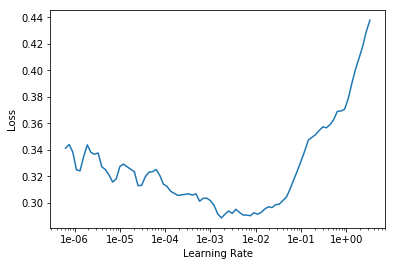

In [163]:
learn.lr_find();learn.recorder.plot()

In [164]:
learn.fit_one_cycle(5, 8e-5)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.294594,0.601908,0.860000,0.396552,00:08
1,0.307323,0.590900,0.861000,0.408511,00:08
2,0.296017,0.578898,0.863000,0.421941,00:08
3,0.304085,0.595933,0.862000,0.410256,00:08
4,0.291582,0.596006,0.862000,0.410256,00:08


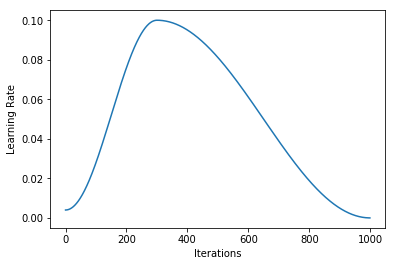

In [288]:
learn.recorder.plot_lr()

In [172]:
interp = ClassificationInterpretation.from_learner(learn)


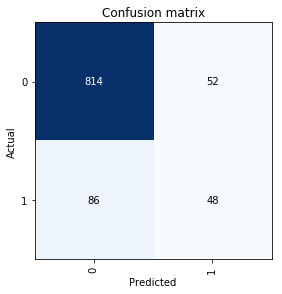

In [173]:
interp.plot_confusion_matrix()

In [174]:
l, i = interp.top_losses()

TypeError: len() of a 0-d tensor

In [175]:
interp.most_confused()

[(1, 0, 86), (0, 1, 52)]

In [169]:
for ix in range(0,10): print(data.valid_ds[i[ix]])

NameError: name 'i' is not defined

In [295]:
neutral_as_offensive = np.nonzero((interp.pred_class != interp.y_true) & (interp.y_true == 0)).reshape(-1)
for ix in neutral_as_offensive: print(data.valid_ds[ix])

(EmbeddingText account wie@@ czna zdra@@ da , nie zdra@@ da , trzeba roz@@ mawi@@ ać , pier@@ dol@@ enie od rzeczy, Category 0)
(EmbeddingText account account to pani kry@@ sia jest two@@ ją oj@@ czy@@ zn@@ ą ?, Category 0)
(EmbeddingText account droga p.@@ kam@@ il@@ ko ! le@@ czyć się . le@@ czyć pó@@ ki czas 😁 😁, Category 0)
(EmbeddingText account du@@ baj w@@ zor@@ em , czy@@ li jednak islam , sal@@ am al@@ ej@@ kum ci@@ em@@ ki@@ e@@ wi@@ cz, Category 0)
(EmbeddingText account a ja za@@ łoż@@ ę fit@@ blo@@ ga 😂 😂 😂, Category 0)
(EmbeddingText account to tak jak ja prze@@ widział@@ em , że cię nie w@@ pusz@@ cza do g@@ b, Category 0)
(EmbeddingText prowad@@ zą@@ cy mówi ze nikt mu nie wy@@ s@@ ła@@ ł sz@@ ki@@ ców projekt@@ ów jak nie jak ja ci wy@@ sł@@ ałam im@@ be@@ cy@@ lu, Category 0)
(EmbeddingText ra@@ fa@@ ł br@@ zo@@ zo@@ w@@ ski ma nar@@ ze@@ cz@@ on@@ ą ? mam na@@ dzie@@ je m , że na co@@ dzień jej aż tak nie fa@@ ł@@ sz@@ uje jak w tym kol@@ e fortun@@ y a jeśli tak to 